In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)
library(ComplexHeatmap)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp


Attaching package: 'ComplexHeatmap'


The following object is masked from 'package:pheatmap':

    pheatmap




In [2]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [5]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'HOT1A3_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'HOT1A3', 'HOT1A3_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [6]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

In [7]:
hpath_df %>% distinct(gene_id)

gene_id               
1    ACZ81_RS00005         
2    ACZ81_RS00010         
3    ACZ81_RS00015         
4    ACZ81_RS00020         
5    ACZ81_RS00025         
6    ACZ81_RS00030         
7    ACZ81_RS00035         
8    ACZ81_RS00040         
9    ACZ81_RS00045         
10   ACZ81_RS00050         
11   ACZ81_RS00055         
12   ACZ81_RS00060         
13   ACZ81_RS00065         
14   ACZ81_RS00070         
15   ACZ81_RS00075         
16   ACZ81_RS00080         
17   ACZ81_RS00085         
18   ACZ81_RS00090         
19   ACZ81_RS00095         
20   ACZ81_RS00100         
21   ACZ81_RS00105         
22   ACZ81_RS00110         
23   ACZ81_RS00115         
24   ACZ81_RS00120         
25   ACZ81_RS00125         
26   ACZ81_RS00130         
27   ACZ81_RS00135         
28   ACZ81_RS00140         
29   ACZ81_RS00145         
30   ACZ81_RS00150         
⋮    ⋮                     
4061 ACZ81_RS21585         
4062 ACZ81_RS21590         
4063 ACZ81_RS21595         
4064 ACZ81_RS21600         
4065 ACZ81_RS21605         
4066 ACZ81_RS21610         
4067 ACZ81_RS21615         
4068 ACZ81_RS21620         
4069 ACZ81_RS21625         
4070 ACZ81_RS21630         
4071 ACZ81_RS21635         
4072 ACZ81_RS21640         
4073 ACZ81_RS21645         
4074 ACZ81_RS21650         
4075 ACZ81_RS21655         
4076 ACZ81_RS21660         
4077 ACZ81_RS21665         
4078 ACZ81_RS21670         
4079 ACZ81_RS21675         
4080 ACZ81_RS21680         
4081 ACZ81_RS21685         
4082 ACZ81_RS21690         
4083 ACZ81_RS21695         
4084 ACZ81_RS21700         
4085 ACZ81_RS21705         
4086 __no_feature          
4087 __ambiguous           
4088 __too_low_aQual       
4089 __not_aligned         
4090 __alignment_not_unique

In [7]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
HCOLOR = '#E26A2C'
HCOLOR = '#984215'
 
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

tpal = brewer.pal(5, "Purples")
gpal = brewer.pal(4, 'Dark2')
ann_colors = list(
    Timepoint = c('1'=tpal[1], '2'=tpal[2], '3'=tpal[3], 
                  '4'=tpal[4], '5'=tpal[5]),
    Group = c(A = HCOLOR_light, C = HCOLOR),
    treatment = c(ref = gpal[2], long.term=gpal[4])
)
#forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
#fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]


# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

In [8]:
rnaseq_dpath = file.path('..', 'RNASEQ', 'DE_results')
list.files(rnaseq_dpath)


[1] "HOT1A3_DE_DESEQ_results.csv"                
 [2] "HOT1A3_DE_DESEQ_results_ref_vs_long.csv"    
 [3] "HOT1A3_DE_DESEQ_vsd.csv"                    
 [4] "HOT1A3_DE_genes_DESEQ_ref_vs_long_wKEGG.csv"
 [5] "HOT1A3_GOSEQ_results_ref_vs_long.csv"       
 [6] "MED4_DE_DESEQ_results.csv"                  
 [7] "MED4_DE_DESEQ_results_ref_vs_long.csv"      
 [8] "MED4_DE_DESEQ_vsd.csv"                      
 [9] "MED4_DE_genes_DESEQ_wKEGG_ref_vs_long.csv"  
[10] "MED4_GOSEQ_results_ref_vs_long.csv"

In [9]:
proteome_dpath = file.path('..', 'Proteome', 'data')
list.files(proteome_dpath)


[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "ALT_Axenic_DE.csv"                                                                              
 [4] "ALT_CC_DE.csv"                                                                                  
 [5] "C_ALT_proteome.txt"                                                                             
 [6] "C_ALT_proteome_norm.txt"                                                                        
 [7] "C_PRO_proteome.txt"                                                                             
 [8] "C_PRO_proteome_norm.txt"                                                                        
 [9] "Nov22_Processing.xlsx"                                                                          
[10] "P_axenic_proteome.txt"                                                                          
[11] "P_axenic_proteome_norm.txt"                                                                     
[12] "PRO_Axenic_DE.csv"                                                                              
[13] "PRO_CC_DE.csv"                                                                                  
[14] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [10]:
df_rnaseq1 = read.csv(file.path(rnaseq_dpath,'HOT1A3_DE_DESEQ_results_ref_vs_long.csv'))  %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

df_rnaseq2 = read.csv(file.path(rnaseq_dpath,'HOT1A3_DE_DESEQ_results.csv')) %>% 
   mutate(gene_id = str_replace(gene_id, '\\.\\.\\.\\d+', '')) 

In [11]:
unique(df_rnaseq2$contrast)

[1] "A2vsA1" "A3vsA1" "C1vsA1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

In [12]:
df_prot1 = read.csv(file.path(proteome_dpath,'ALT_CC_DE.csv'))
df_prot2 = read.csv(file.path(proteome_dpath,'ALT_Axenic_DE.csv'))

In [13]:
names(df_rnaseq1)
names(df_rnaseq2)
names(df_prot1)
names(df_prot2)



[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "gene_id"        "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "contrast"      
 [9] "na_pvalue"      "na_padj"        "significant"    "direction"     
[13] "status"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

[1] "X.1"           "logFC"         "AveExpr"       "t"            
 [5] "P.Value"       "adj.P.Val"     "B"             "gene"         
 [9] "count"         "sca.t"         "sca.P.Value"   "sca.adj.pval" 
[13] "contrast"      "gene_id"       "gene.y"        "product"      
[17] "old_locus_tag" "X"             "path_id"       "main"         
[21] "sub"           "path"          "ecpath"        "log.sca.pval"

In [14]:
unique(df_prot1$contrast)
unique(df_prot2$contrast)
unique(df_rnaseq1$contrast)
unique(df_rnaseq2$contrast)


[1] "C2 - C1"        "C3 - C1"        "C4 - C1"        "C5 - C1"       
[5] "Clongterm - C1"

[1] "A2 - A1" "A3 - A1"

[1] "Intercept"                  "treatment_long.term_vs_ref"

[1] "A2vsA1" "A3vsA1" "C1vsA1" "C2vsC1" "C3vsC1" "C4vsC1" "C5vsC1"

# LONG TERM - compare proteome to RNASEQ

In [15]:
lc_prot = df_prot1 %>% filter(contrast=='Clongterm - C1') %>% select(
    'gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC.proteome' = 'logFC','AveExpr.proteome' = 'AveExpr',
    'pvalue.proteome' = 'sca.P.Value','padj.proteome' = 'sca.adj.pval')
head(lc_prot)


gene_id       logFC.proteome AveExpr.proteome pvalue.proteome padj.proteome
1 ACZ81_RS19455 3.425751        0.4518796       3.279169e-13    7.292872e-10 
2 ACZ81_RS09835 3.814822       -1.6259760       9.219157e-13    1.025170e-09 
3 ACZ81_RS17215 4.431088        0.7089464       2.765118e-12    2.049874e-09 
4 ACZ81_RS18535 6.371636       -1.6227350       5.356480e-12    2.978203e-09 
5 ACZ81_RS16015 2.278657        0.8062054       9.740853e-12    4.332731e-09 
6 ACZ81_RS08650 2.519997        0.5599381       1.357234e-11    5.030813e-09

In [16]:
lc_rna = df_rnaseq1 %>% filter(contrast=='treatment_long.term_vs_ref') %>% 
    select(
        'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC.rna' = 'log2FoldChange','AveExpr.rna' = 'baseMean',
    'pvalue.rna' = 'pvalue','padj.rna' = 'padj') 
head(lc_rna)
    



gene_id       AveExpr.rna logFC.rna   pvalue.rna padj.rna
1 ACZ81_RS00005 4746.9478   -0.49038345 1          1       
2 ACZ81_RS00010 1970.9347   -0.41743780 1          1       
3 ACZ81_RS00015  536.4317   -0.02681061 1          1       
4 ACZ81_RS00020 2930.1125   -0.35225750 1          1       
5 ACZ81_RS00025  150.2139   -0.06732803 1          1       
6 ACZ81_RS00030 2610.2883    0.30138533 1          1

In [17]:
lc_df = left_join(lc_rna, lc_prot, by='gene_id')

In [18]:
lc_df = left_join(lc_df, hpath_df_to_export, by='gene_id')

In [19]:
head(lc_df)

gene_id       AveExpr.rna logFC.rna   pvalue.rna padj.rna logFC.proteome
1 ACZ81_RS00005 4746.9478   -0.49038345 1          1        -0.1623306    
2 ACZ81_RS00010 1970.9347   -0.41743780 1          1         0.4284246    
3 ACZ81_RS00015  536.4317   -0.02681061 1          1                NA    
4 ACZ81_RS00020 2930.1125   -0.35225750 1          1        -0.8446416    
5 ACZ81_RS00025  150.2139   -0.06732803 1          1         0.1831366    
6 ACZ81_RS00030 2610.2883    0.30138533 1          1        -0.1847481    
  AveExpr.proteome pvalue.proteome padj.proteome gene
1 -0.07594878      3.414587e-01    0.4534231513  dnaA
2  1.18859870      1.290540e-03    0.0047284364  dnaN
3          NA                NA              NA  recF
4  2.56286729      1.577071e-05    0.0001402962  gyrB
5 -1.92600613      5.321161e-01    0.6320867016      
6  2.72796319      9.724708e-02    0.1602055623  glyS
  product                                        protein_id     old_locus_tag
1 chromosomal replication initiator protein DnaA WP_232375975.1 NA           
2 DNA polymerase III subunit beta                WP_012516526.1 NA           
3 DNA replication/repair protein RecF            WP_061438857.1 NA           
4 DNA topoisomerase (ATP-hydrolyzing) subunit B  WP_014977848.1 NA           
5 hypothetical protein                           WP_039234509.1 NA           
6 glycine--tRNA ligase subunit beta              WP_061438859.1 NA           
  X    path_id
1 6043 K02313 
2    4 K02338 
3 3071 K03629 
4 2388 K02470 
5 2824        
6 3073 K01879 
  main                                                                                       
1 09130 Environmental Information Processing;09140 Cellular Processes;09180 Brite Hierarchies
2 09120 Genetic Information Processing;09180 Brite Hierarchies                               
3 09120 Genetic Information Processing;09180 Brite Hierarchies                               
4 09180 Brite Hierarchies                                                                    
5                                                                                            
6 09120 Genetic Information Processing;09180 Brite Hierarchies                               
  sub                                                                                                         
1 09132 Signal transduction;09143 Cell growth and death;09182 Protein families: genetic information processing
2 09124 Replication and repair;09182 Protein families: genetic information processing                         
3 09124 Replication and repair;09182 Protein families: genetic information processing                         
4 09182 Protein families: genetic information processing                                                      
5                                                                                                             
6 09122 Translation;09181 Protein families: metabolism;09182 Protein families: genetic information processing 
  path                                                                                                                                                                                                                        
1 02020 Two-component system [PATH:ko02020];04112 Cell cycle - Caulobacter [PATH:ko04112];03032 DNA replication proteins [BR:ko03032];03036 Chromosome and associated proteins [BR:ko03036]                                   
2 03030 DNA replication [PATH:ko03030];03430 Mismatch repair [PATH:ko03430];03440 Homologous recombination [PATH:ko03440];03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400]
3 03440 Homologous recombination [PATH:ko03440];03400 DNA repair and recombination proteins [BR:ko03400]                                                                                                                      
4 03032 DNA replication proteins [BR:ko03032];03400 DNA repair and recombination proteins [BR:ko03400]                   

In [20]:
lc_df = lc_df %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [21]:
lc_df$Category = factor(lc_df$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))

In [22]:
subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)) %>% 
select(Category) %>%table() %>% as.data.frame() %>% arrange(Freq) #%>% dput


Category                   Freq
1 Secondary                   19 
2 Lipid                       26 
3 Nucleotide                  28 
4 Amino acid                  36 
5 Genetic                     58 
6 Energy/Carbohydrate/Glycan  91 
7 Transport/Signaling        206 
8 Other                      511

In [23]:
subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)) %>% 
filter(Category == 'Other') %>%
select(sub) %>%table() %>% as.data.frame() %>% arrange(Freq) #%>% dput


sub                                                                Freq
1 09110 Biosynthesis of other secondary metabolites                    1 
2 09132 Signal transduction;09145 Cellular community - prokaryotes     1 
3 09164 Neurodegenerative disease;09181 Protein families: metabolism   1 
4 09111 Xenobiotics biodegradation and metabolism                      3 
5 09181 Protein families: metabolism                                  10 
6 NA                                                                  11 
7 09194 Poorly characterized                                          25 
8 09191 Unclassified: metabolism                                      34 
9                                                                    425

In [24]:
lc_df = lc_df %>% replace_na(list(logFC.rna=0, logFC.proteome=0))

In [25]:
my.cols <- c(brewer.pal(7, "Set1"), 'grey34')
my.cols[6] = '#FFC000'

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


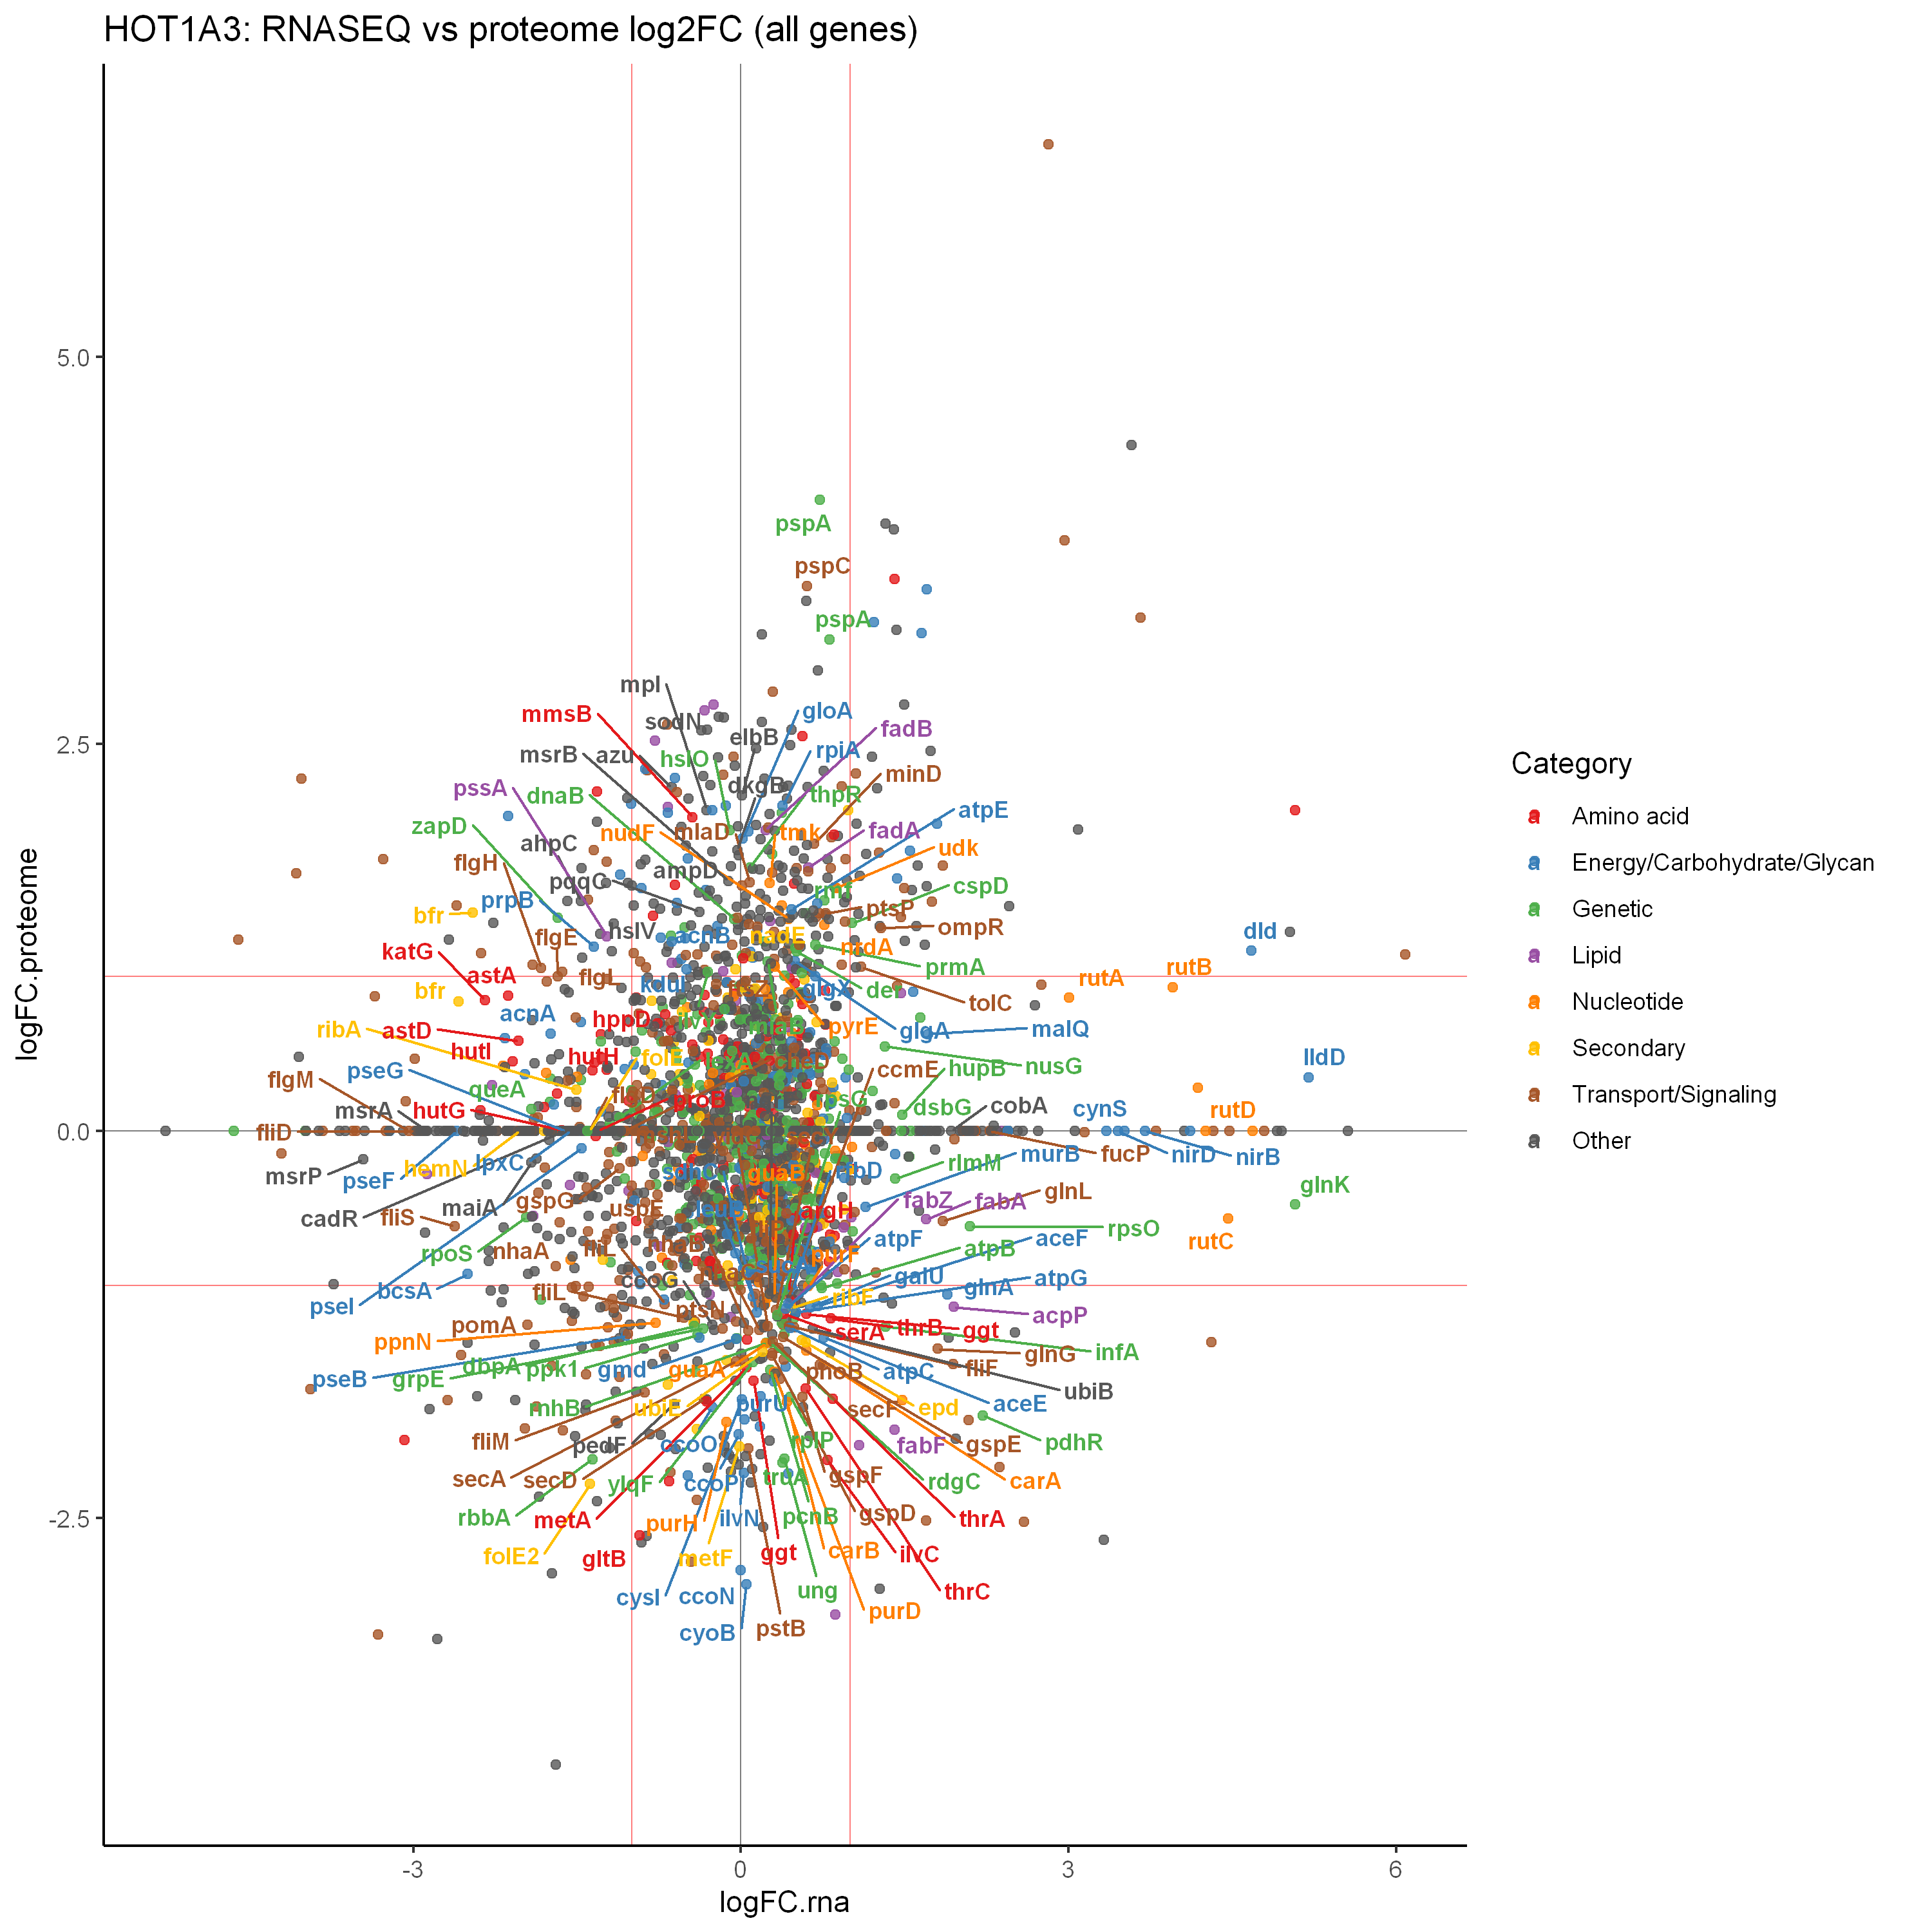

In [26]:
ggplot(lc_df, aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3, fontface='bold') + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('HOT1A3: RNASEQ vs proteome log2FC (all genes)') +
#scale_colour_brewer(palette = "Set1") +
    theme_classic()

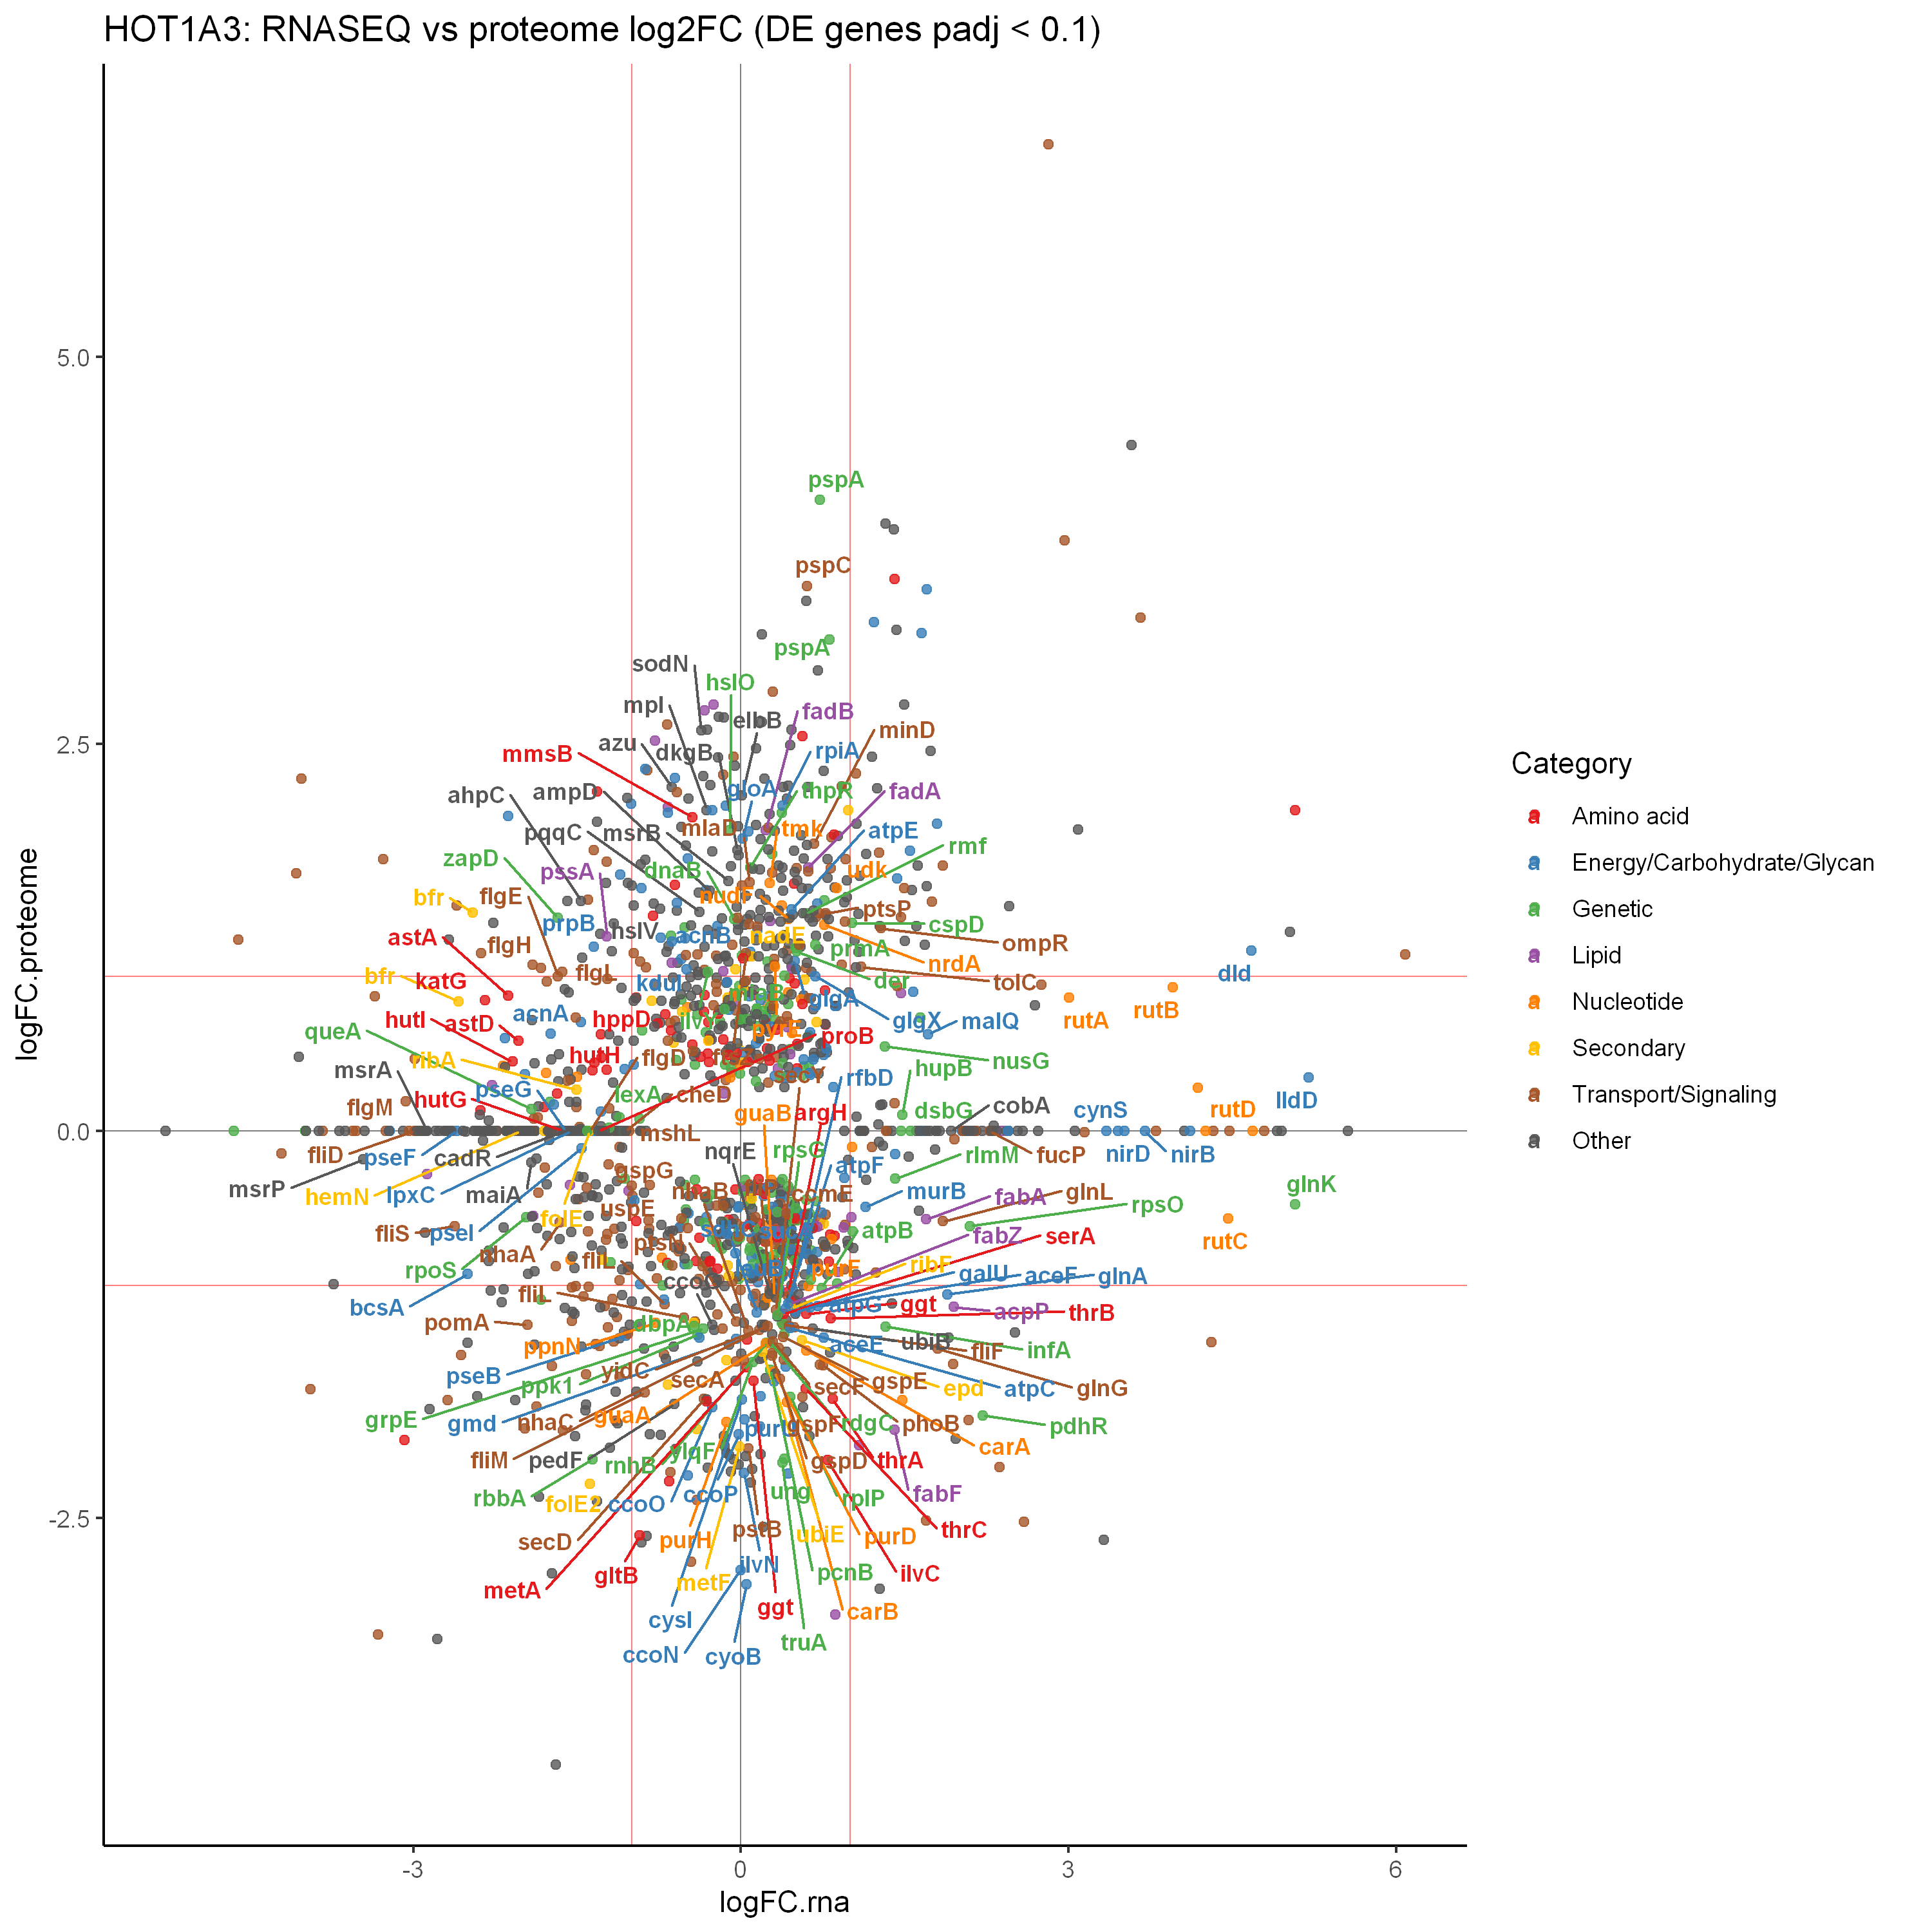

In [27]:
ggplot(subset(lc_df, (padj.proteome<0.1)|(padj.rna<0.1)), 
       aes(x=logFC.rna, y=logFC.proteome, color=Category, #, size=-log10(pvalue.proteome)
                 )) +
    geom_vline(xintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add fold change cutoffs
    geom_hline(yintercept = c(-1,1), colour = "red", size = 0.3, alpha=0.5) + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
    geom_hline(yintercept = 0, colour = "black", size = 0.3, alpha=0.5) + # Add 0 lines
   geom_point(size=1.5, alpha=0.8) + 
   geom_text_repel(data=subset(lc_df, ((abs(logFC.proteome)>1)&padj.proteome<0.1)|((abs(logFC.rna)>1)&padj.rna<0.1)),
                    aes( x=logFC.rna, y=logFC.proteome,label=gene), max.overlaps = Inf, size=3, fontface='bold') + # add gene label
    scale_color_manual(values=my.cols) +
    ggtitle('HOT1A3: RNASEQ vs proteome log2FC (DE genes padj < 0.1)') +

#scale_colour_brewer(palette = "Set1") +
    theme_classic()

# upset plots

In [28]:
set_size = function(w, h, factor=1.5) {
    s = 1 * factor
    options(
        repr.plot.width=w * s,
        repr.plot.height=h * s,
        repr.plot.res=100 / factor,
        jupyter.plot_mimetypes='image/png',
        jupyter.plot_scale=1
    )
}

In [29]:
df_DElist_prot1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval') %>%
    mutate(Assay = 'Proteome')
df_DElist_prot2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')%>%
    mutate(Assay = 'Proteome')


In [30]:
df_DElist_rna1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
df_DElist_rna2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
    


In [31]:
df_DElist = bind_rows(df_DElist_prot1, df_DElist_prot2, df_DElist_rna1, df_DElist_rna2)

In [32]:
dput(unique(df_DElist$contrast))

c("C2 - C1", "C3 - C1", "C4 - C1", "C5 - C1", "Clongterm - C1", 
"A2 - A1", "A3 - A1", "Intercept", "treatment_long.term_vs_ref", 
"A2vsA1", "A3vsA1", "C1vsA1", "C2vsC1", "C3vsC1", "C4vsC1", "C5vsC1"
)


In [33]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "A2 - A1" = 'A2vsA1_prot',
    "A3 - A1" = 'A3vsA1_prot',
    "A5 - A1" = 'A5vsA1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "A2vsA1" = 'A2vsA1_rna', 
    "A3vsA1" = 'A3vsA1_rna', 
    "C1vsA1" = 'C1vsP1_rna', 
    "C2vsC1" = 'C2vsC1_rna', 
    "C3vsC1" = 'C3vsC1_rna', 
    "C4vsC1" = 'C4vsC1_rna', 
    "C5vsC1" = 'C5vsC1_rna')
    
    
df_DElist = df_DElist %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [34]:
table(df_DElist$contrast1)


   A2vsA1_prot     A2vsA1_rna    A3vsA1_prot     A3vsA1_rna     C1vsP1_rna 
          2229           4015           2229           4015           4015 
   C2vsC1_prot     C2vsC1_rna    C3vsC1_prot     C3vsC1_rna    C4vsC1_prot 
          2229           4015           2229           4015           2229 
    C4vsC1_rna    C5vsC1_prot     C5vsC1_rna  LATEvsC1_prot LATEvsC1P1_rna 
          4015           2229           4015           2229           4015 

In [35]:
df_DElist = left_join(df_DElist, hpath_df_to_export, by='gene_id')


In [36]:
df_DElist

contrast gene_id       logFC        AveExpr     pvalue       padj        
1     C2 - C1  ACZ81_RS16015  1.5362447    0.8062054  4.418240e-08 9.826165e-05
2     C2 - C1  ACZ81_RS19455  1.5648136    0.4518796  1.133719e-07 1.260696e-04
3     C2 - C1  ACZ81_RS03205  1.8519732   -0.9340314  2.173784e-07 1.611498e-04
4     C2 - C1  ACZ81_RS08660  1.2073415   -1.0444874  3.978691e-07 2.212152e-04
5     C2 - C1  ACZ81_RS11690 -0.7880224    2.6035957  6.292978e-07 2.439240e-04
6     C2 - C1  ACZ81_RS08650  1.5014521    0.5599381  6.984270e-07 2.439240e-04
7     C2 - C1  ACZ81_RS09955  1.8006045   -0.3495981  7.735888e-07 2.439240e-04
8     C2 - C1  ACZ81_RS17215  1.8835011    0.7089464  8.774244e-07 2.439240e-04
9     C2 - C1  ACZ81_RS15340 -2.1834545    3.6445136  1.587079e-06 3.921848e-04
10    C2 - C1  ACZ81_RS18525  2.0943302   -3.1175997  2.733987e-06 6.080387e-04
11    C2 - C1  ACZ81_RS09835  1.7344233   -1.6259760  4.027037e-06 8.141936e-04
12    C2 - C1  ACZ81_RS15055 -1.0454865    2.2954966  4.991772e-06 9.114238e-04
13    C2 - C1  ACZ81_RS09825  1.8332443    1.1592713  6.195695e-06 9.114238e-04
14    C2 - C1  ACZ81_RS01015 -0.9223156    4.0407804  6.430311e-06 9.114238e-04
15    C2 - C1  ACZ81_RS10180  1.2505938   -0.8175371  6.509604e-06 9.114238e-04
16    C2 - C1  ACZ81_RS09365  1.1807168    0.2635481  6.888766e-06 9.114238e-04
17    C2 - C1  ACZ81_RS05350  1.6174717    3.8128636  6.966818e-06 9.114238e-04
18    C2 - C1  ACZ81_RS01010  1.4089025    2.7627832  7.739724e-06 9.337900e-04
19    C2 - C1  ACZ81_RS09905  1.6486950   -0.6107133  8.828159e-06 9.337900e-04
20    C2 - C1  ACZ81_RS14000  1.2748311   -1.1517385  9.146294e-06 9.337900e-04
21    C2 - C1  ACZ81_RS15345 -1.9073950    3.7490007  9.153463e-06 9.337900e-04
22    C2 - C1  ACZ81_RS18915  1.6253846    0.2392328  9.237132e-06 9.337900e-04
23    C2 - C1  ACZ81_RS13985  2.1771145   -2.5891840  1.063920e-05 1.022577e-03
24    C2 - C1  ACZ81_RS16805 -1.2245750    3.1408424  1.103500e-05 1.022577e-03
25    C2 - C1  ACZ81_RS18035 -0.6495393    5.3171125  1.162423e-05 1.034091e-03
26    C2 - C1  ACZ81_RS07895  1.1656793    0.1834894  1.404256e-05 1.201179e-03
27    C2 - C1  ACZ81_RS18535  2.4523513   -1.6227350  1.940628e-05 1.598502e-03
28    C2 - C1  ACZ81_RS05345  3.4183470    2.2844183  2.115846e-05 1.679652e-03
29    C2 - C1  ACZ81_RS10115  1.5955143    1.0120652  2.278612e-05 1.679652e-03
30    C2 - C1  ACZ81_RS08640  2.0109345   -3.3911413  2.319947e-05 1.679652e-03
⋮     ⋮        ⋮             ⋮            ⋮           ⋮            ⋮           
47694 C5vsC1   ACZ81_RS21530 -0.707322121   16.458322 0.389339501  0.55781937  
47695 C5vsC1   ACZ81_RS21535 -2.441832407    4.892674 0.065335862  0.15248835  
47696 C5vsC1   ACZ81_RS21540 -0.003272177  260.492812 0.995461868  0.99888965  
47697 C5vsC1   ACZ81_RS21545 -0.453640579  693.194711 0.166204592  0.31129356  
47698 C5vsC1   ACZ81_RS21550 -1.447490920  419.425404 0.010798519  0.04004035  
47699 C5vsC1   ACZ81_RS21555  1.246671195  202.955100 0.002607795  0.01321019  
47700 C5vsC1   ACZ81_RS21560 -0.192082681  216.365777 0.611895951  0.75327602  
47701 C5vsC1   ACZ81_RS21565 -0.238135266  398.129939 0.431718774  0.60026697  
47702 C5vsC1   ACZ81_RS21570 -1.063750735   10.858158 0.173865328  0.32026983  
47703 C5vsC1   ACZ81_RS21580 -0.284702650   10.442482 0.693658870  0.81349295  
47704 C5vsC1   ACZ81_RS21590 -1.490111132  211.317181 0.027473979  0.08016408  
47705 C5vsC1   ACZ81_RS21595 -1.331445926  137.712232 0.062243750  0.14785194  
47706 C5vsC1   ACZ81_RS21605 -0.189354017   37.973335 0.778194540  0.86962712  
47707 C5vsC1   ACZ81_RS21610  0.740781645   70.683557 0.250886159  0.41000215  
47708 C5vsC1   ACZ81_RS21615  0.137941730   80.145559 0.774090614  0.86653224  
47709 C5vsC1   ACZ81_RS21620  0.132888931   63.049906 0.741856519  0.84590237  
47710 C5vsC1   ACZ81_RS21625  0.466364029   51.379004 0.265478394  0.42451148  
47711 C5vsC1   ACZ81_RS21630 -0.965786290  151.158524 0.093999460  0.20176510  
47712 

In [37]:
df_DElist = df_DElist %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 

In [38]:
df_DElist$Category = factor(df_DElist$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
#my.cols <- c(brewer.pal(7, "Set2"), 'grey34')


In [39]:
contrast_list = unique(df_DElist$contrast1)
contrast_list = unique(df_DElist$contrast)


In [40]:
dput(contrast_list)

c("C2 - C1", "C3 - C1", "C4 - C1", "C5 - C1", "Clongterm - C1", 
"A2 - A1", "A3 - A1", "treatment_long.term_vs_ref", "A2vsA1", 
"A3vsA1", "C1vsA1", "C2vsC1", "C3vsC1", "C4vsC1", "C5vsC1")


In [41]:
rna_CC_list = c(#"C1vsP1_rna", 
                "C2vsC1_rna", "C3vsC1_rna", "C4vsC1_rna", "C5vsC1_rna")
prot_CC_list = c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot")
latelist = c("LATEvsC1_prot","LATEvsC1P1_rna")


c("C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot", 
"LATEvsC1_prot", "P2vsP1_prot", "P3vsP1_prot", "P5vsP1_prot", 
"LATEvsC1P1_rna", "P2vsP1_rna", "C1vsP1_rna", "C2vsP1_rna", "C3vsP1_rna", 
"C4vsP1_rna", "C5vsP1_rna")

[1] "C2vsC1_prot"    "C3vsC1_prot"    "C4vsC1_prot"    "C5vsC1_prot"   
 [5] "LATEvsC1_prot"  "P2vsP1_prot"    "P3vsP1_prot"    "P5vsP1_prot"   
 [9] "LATEvsC1P1_rna" "P2vsP1_rna"     "C1vsP1_rna"     "C2vsP1_rna"    
[13] "C3vsP1_rna"     "C4vsP1_rna"     "C5vsP1_rna"

In [42]:

contrast_meta_df = df_DElist %>% distinct(contrast1, Assay) %>% rename(set = contrast1)


In [43]:
contrast_meta_df

set            Assay   
1  C2vsC1_prot    Proteome
2  C3vsC1_prot    Proteome
3  C4vsC1_prot    Proteome
4  C5vsC1_prot    Proteome
5  LATEvsC1_prot  Proteome
6  A2vsA1_prot    Proteome
7  A3vsA1_prot    Proteome
8  LATEvsC1P1_rna RNA     
9  A2vsA1_rna     RNA     
10 A3vsA1_rna     RNA     
11 C1vsP1_rna     RNA     
12 C2vsC1_rna     RNA     
13 C3vsC1_rna     RNA     
14 C4vsC1_rna     RNA     
15 C5vsC1_rna     RNA

In [44]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 300)

Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: C2vsC1_rna, C3vsC1_rna, C4vsC1_rna, C5vsC1_rna, C2vsC1_prot, C3vsC1_prot, C4vsC1_prot, C5vsC1_prot"


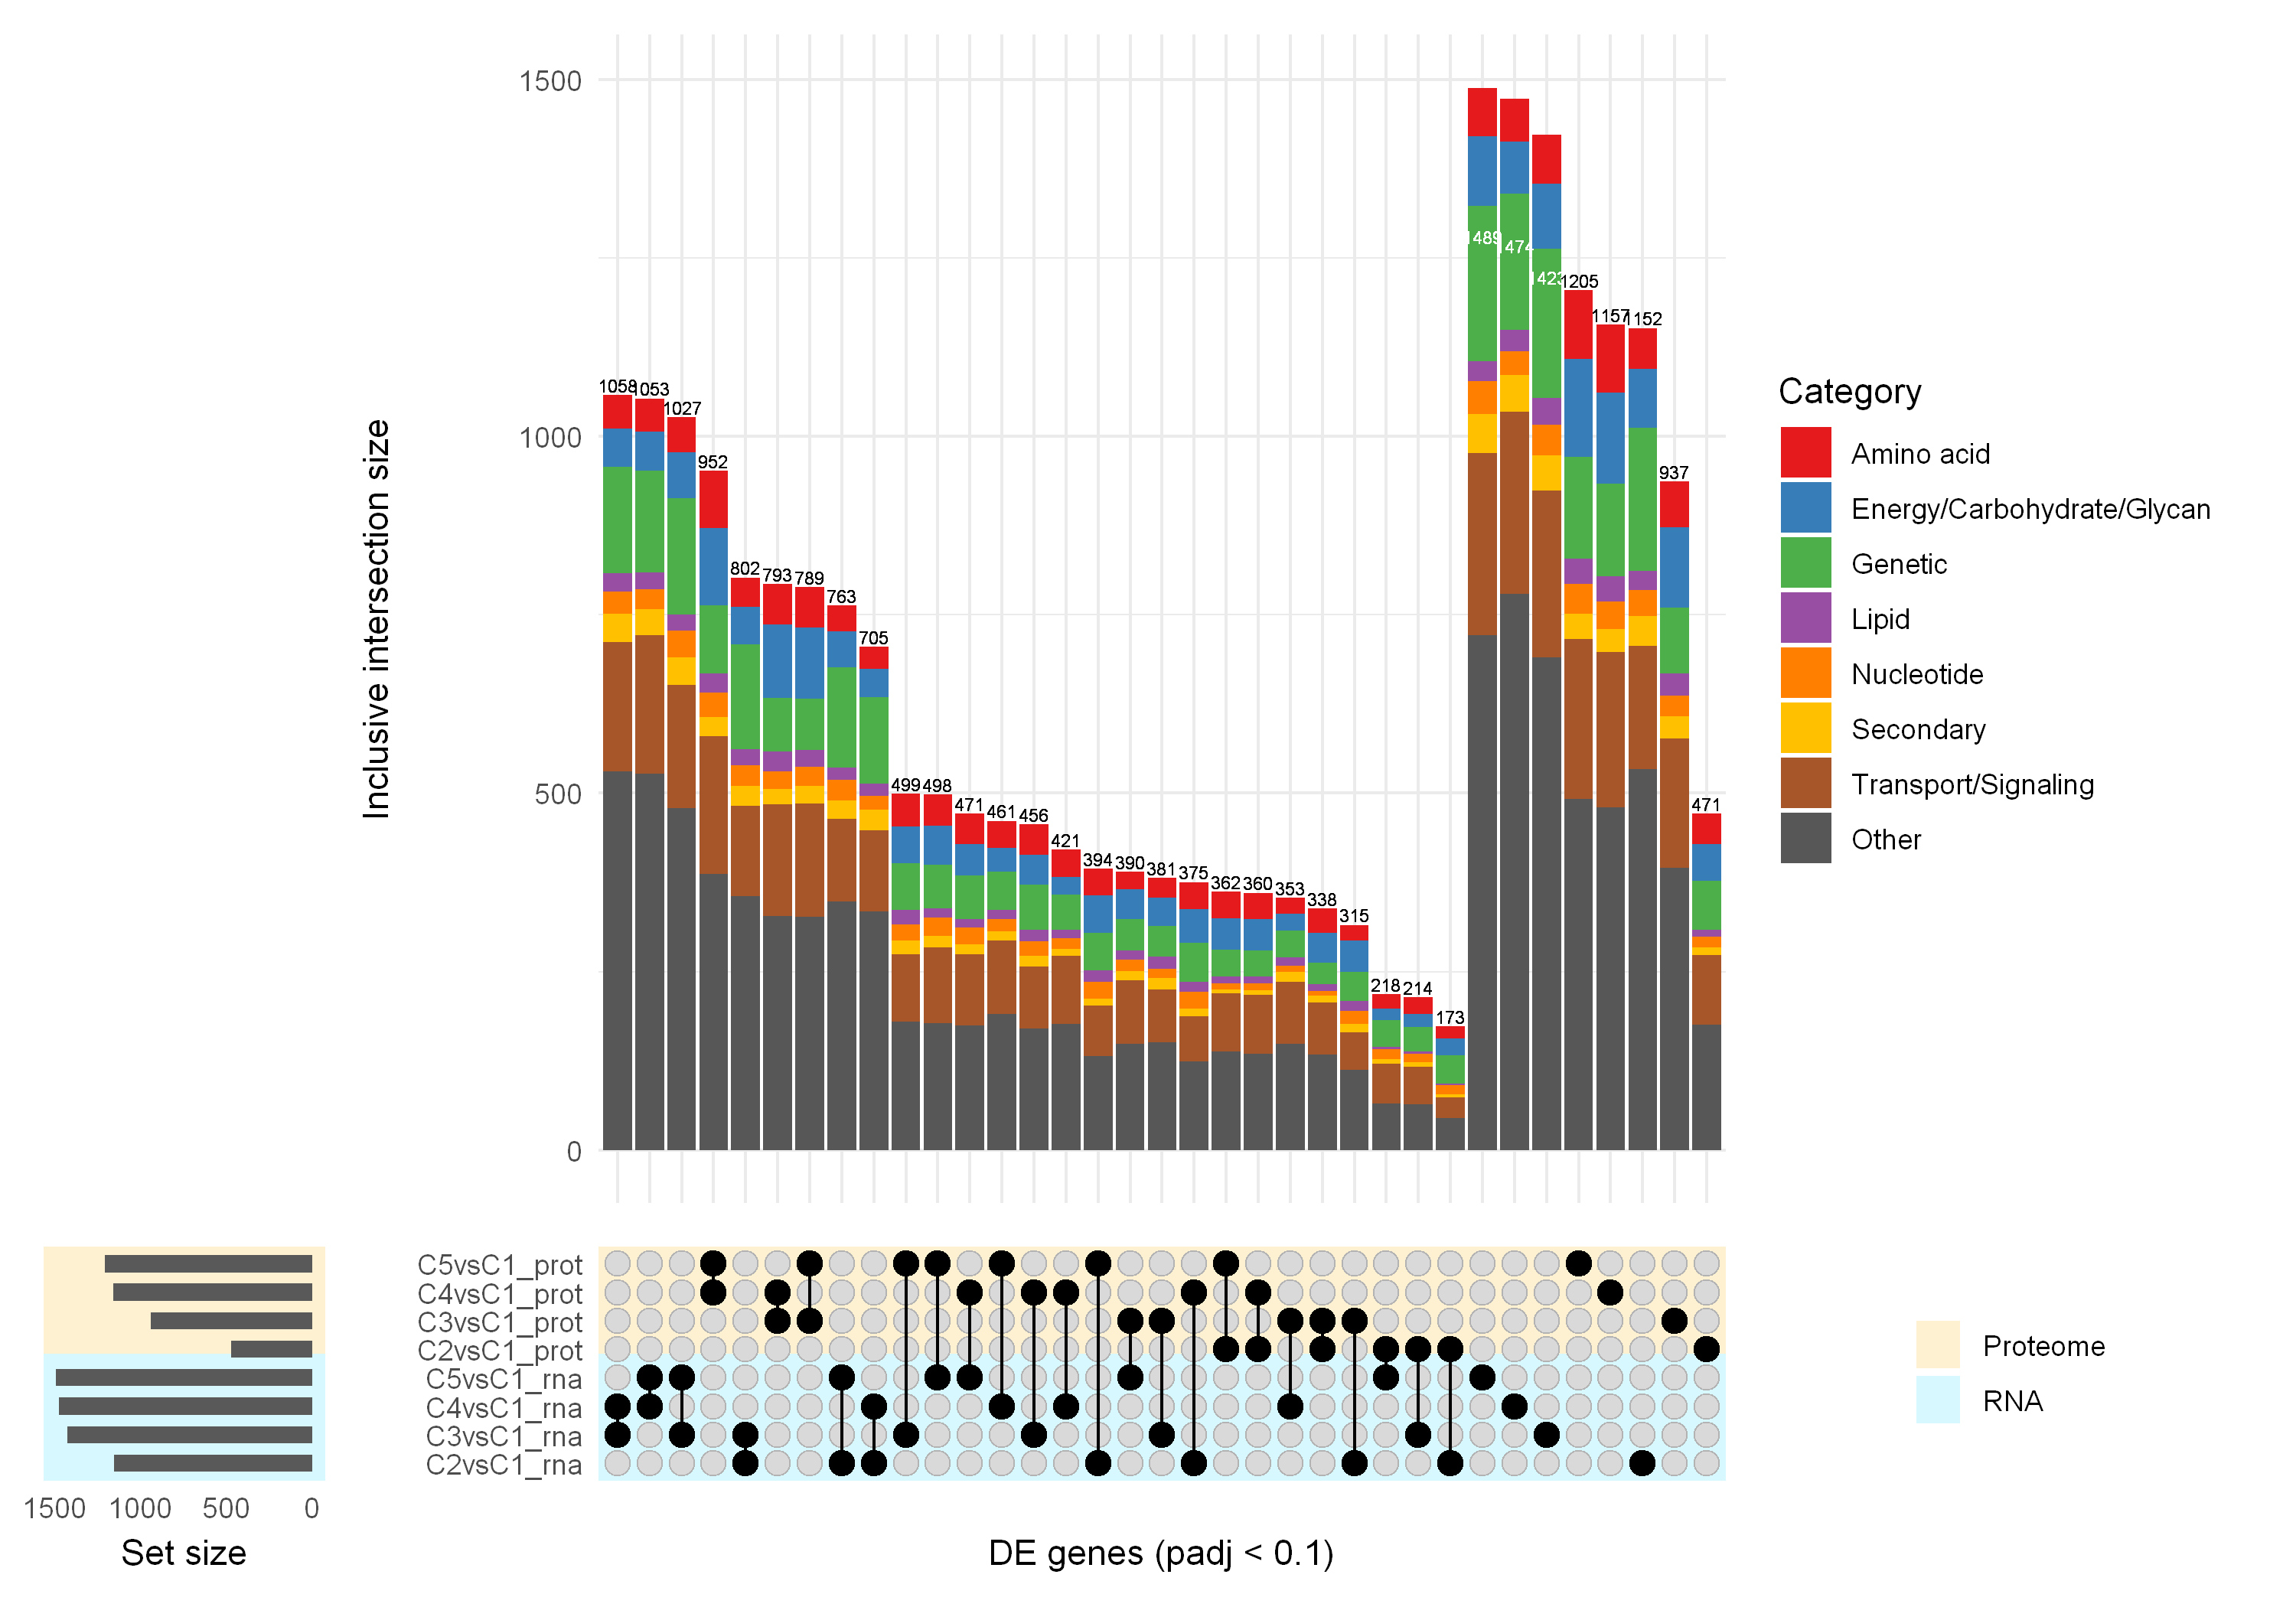

In [45]:
#set_size(10,10 )
df_DElist %>%
    filter(padj < 0.1, #abs(logFC) > 1, 
           contrast != 'Intercept') %>%
    pivot_wider(id_cols = c(gene_id,Category), names_from = contrast1, values_from = logFC, values_fill = FALSE) %>% 
upset(c(rna_CC_list, prot_CC_list), name='DE genes (padj < 0.1)', 
      mode='inclusive_intersection',
      base_annotations=list(
        'Intersection size'=intersection_size(
            mode='inclusive_intersection',
            mapping=aes(fill=Category),
            text=list(size=2)
        )
            + scale_fill_manual(values=my.cols)
    ),      
#     annotations = list(
#         'Categories'=(
#             ggplot(mapping=aes(fill=Category))
#             + geom_bar(stat='count', position='fill')
#             + scale_y_continuous(labels=scales::percent_format())
#             + scale_fill_manual(values=my.cols
#             )
#             + ylab('Category')
#         )
#     ),
      width_ratio=0.2, 
      height_ratio=0.2,
      sort_sets=FALSE,
      #min_size=10, 
      #mode='inclusive_intersection',
      min_degree=1, max_degree=2,
     sort_intersections_by=c('degree', 'cardinality'),
    stripes=upset_stripes(
        mapping=aes(color=Assay),
        colors=c(
            'Proteome'='#fef1d2',
            'RNA'='#d7f8ff'
        ),
        data=contrast_meta_df
    )) #+
#theme_classic(base_size = 15)

In [46]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

Warning message in upset_data(data, intersect, mode = mode, encode_sets = encode_sets, :
"Converting non-logical columns to binary: Proteome, RNA"


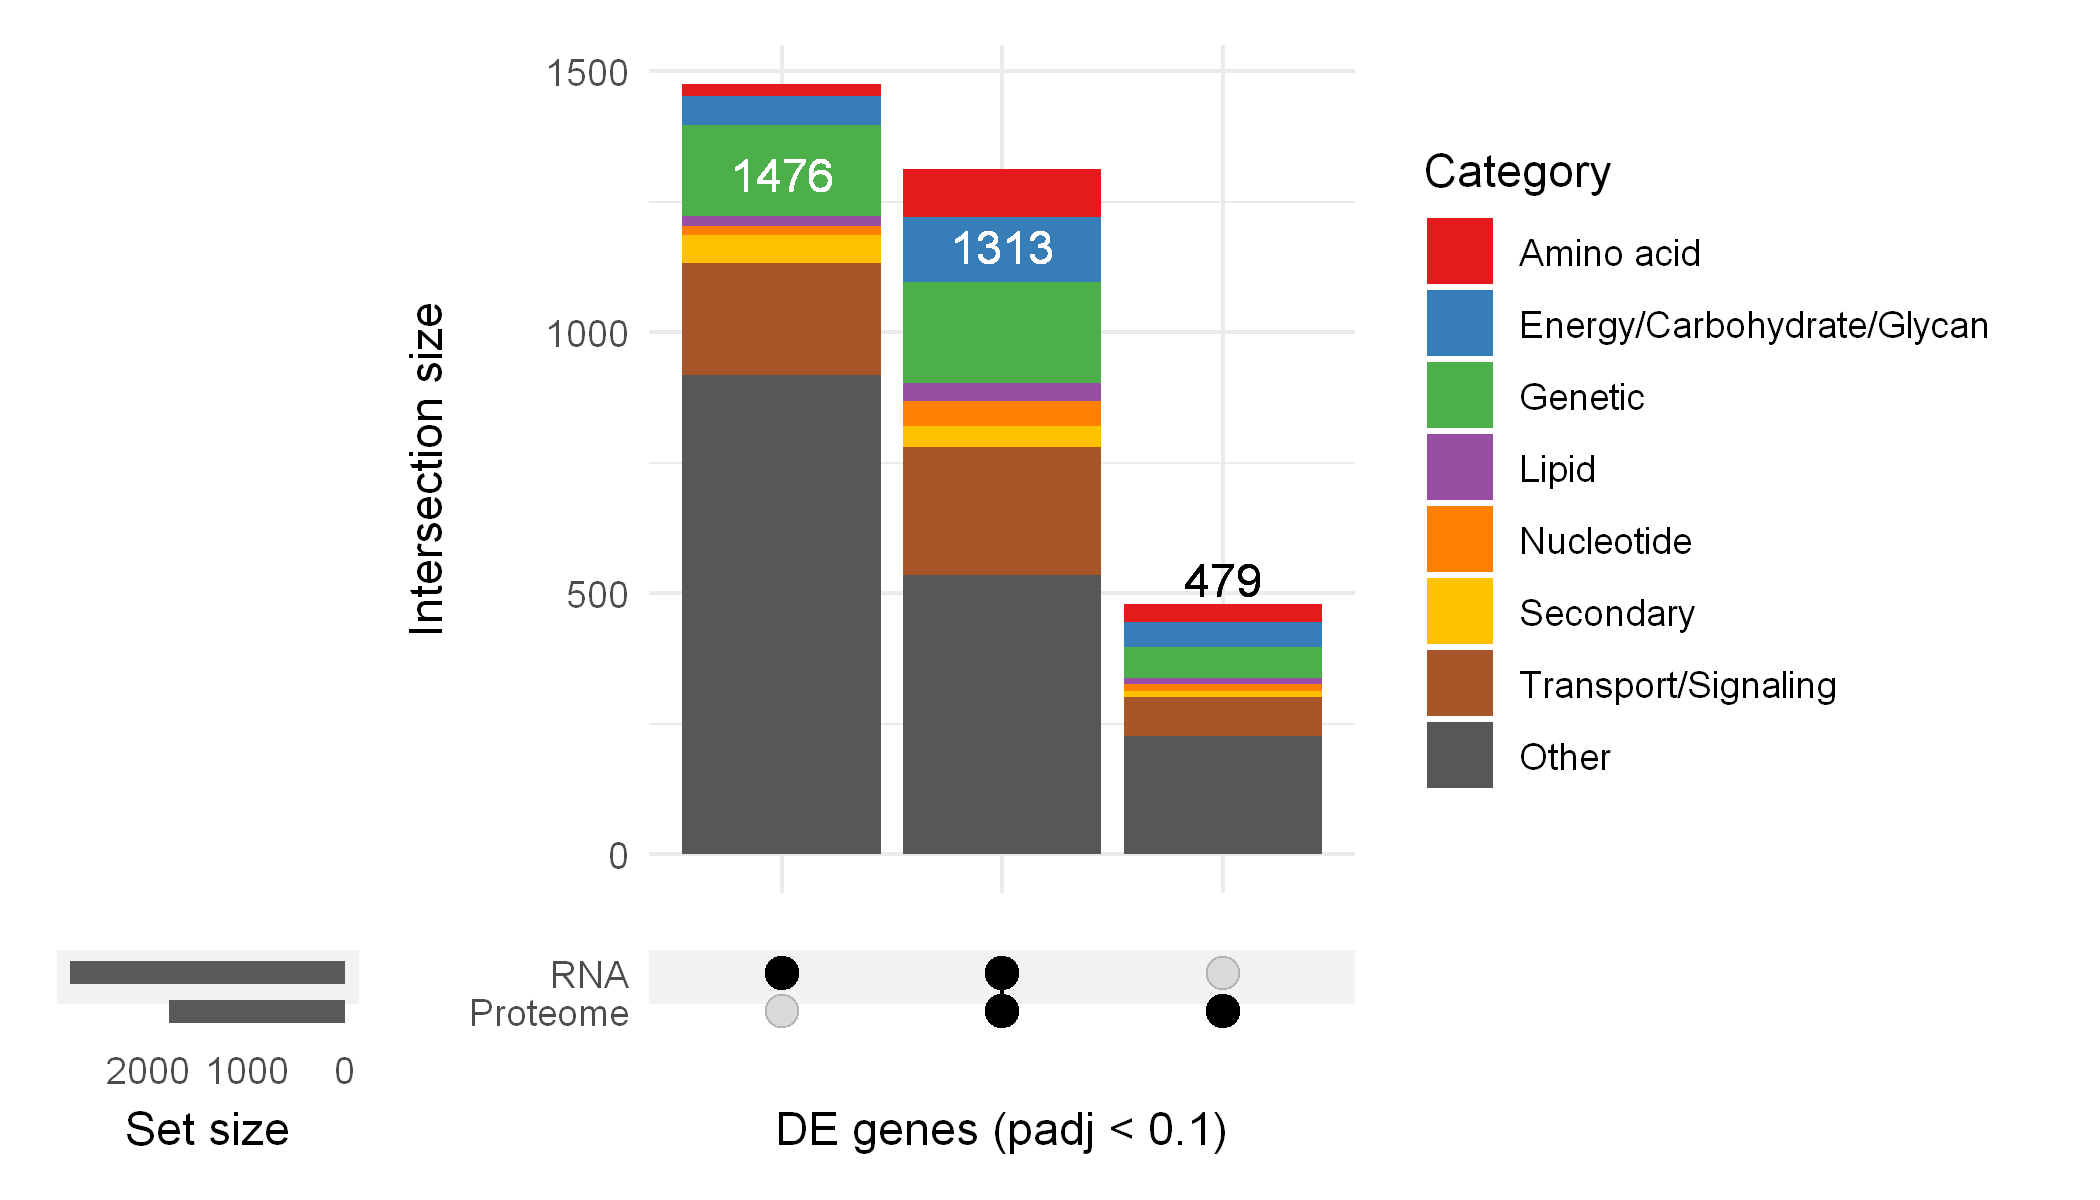

In [47]:
#set_size(10,10 )
df_DElist %>%
    filter(padj < 0.1, #abs(logFC) > 1, 
           contrast != 'Intercept') %>%
    distinct(gene_id, Assay, .keep_all =TRUE) %>%
     pivot_wider(id_cols = c(gene_id,Category), names_from = Assay, values_from = logFC, values_fill = FALSE) %>% 
 upset(c('Proteome', 'RNA'), name='DE genes (padj < 0.1)',
       height_ratio=0.1,
#       mode='inclusive_intersection',
      base_annotations=list(
        'Intersection size'=intersection_size(
#            mode='inclusive_intersection',
            mapping=aes(fill=Category)
        )
            + scale_fill_manual(values=my.cols)
    )
       )
# #     annotations = list(
# #         'Categories'=(
# #             ggplot(mapping=aes(fill=Category))
# #             + geom_bar(stat='count', position='fill')
# #             + scale_y_continuous(labels=scales::percent_format())
# #             + scale_fill_manual(values=my.cols
# #             )
# #             + ylab('Category')
# #         )
# #     ),
#       width_ratio=0.1, 
#       #min_size=10, 
#       #mode='inclusive_intersection',
#       #min_degree=1, max_degree=2,
#      #sort_intersections_by=c('degree', 'cardinality'),
#     ) #+
# #theme_classic(base_size = 15)

# GOSEQ

In [48]:
dp1 = df_prot1 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval') %>%
    mutate(Assay = 'Proteome')
dp2 = df_prot2 %>%  select(
    'contrast','gene_id','logFC','AveExpr',
    'sca.P.Value','sca.adj.pval') %>%
    rename('logFC' = 'logFC','AveExpr' = 'AveExpr',
    'pvalue' = 'sca.P.Value','padj' = 'sca.adj.pval')%>%
    mutate(Assay = 'Proteome')


In [49]:
dr1 = df_rnaseq1 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
dr2 = df_rnaseq2 %>% 
    select(
        'contrast', 'gene_id','baseMean','log2FoldChange',
        'pvalue','padj',
    ) %>%
    rename('logFC' = 'log2FoldChange','AveExpr' = 'baseMean',
    'pvalue' = 'pvalue','padj' = 'padj') %>%
    mutate(Assay = 'RNA')
    


In [50]:
df_all = bind_rows(dp1, dp2, dr1, dr2)

In [51]:
lookup <- c(
    "C2 - C1" = 'C2vsC1_prot', 
    "C3 - C1" = 'C3vsC1_prot', 
    "C4 - C1" = 'C4vsC1_prot', 
    "C5 - C1" = 'C5vsC1_prot', 
    "Clongterm - C1" = 'LATEvsC1_prot', 
    "A2 - A1" = 'A2vsA1_prot',
    "A3 - A1" = 'A3vsA1_prot',
    "A5 - A1" = 'A5vsA1_prot',
    "Intercept" = "Intercept",
    "treatment_long.term_vs_ref" = 'LATEvsC1P1_rna', 
    "A2vsA1" = 'A2vsA1_rna', 
    "A3vsA1" = 'A3vsA1_rna', 
    "C1vsA1" = 'C1vsA1_rna', 
    "C2vsC1" = 'C2vsC1_rna', 
    "C3vsC1" = 'C3vsC1_rna', 
    "C4vsC1" = 'C4vsC1_rna', 
    "C5vsC1" = 'C5vsC1_rna')
    
    
df_all = df_all %>% 
    mutate(contrast1 = lookup[contrast]) %>%
    filter(contrast != 'Intercept')

In [52]:
gtf_fpath = file.path('..','genomes', 'HOT1A3', 'genomic.gtf')
SAF <- Rsubread::flattenGTF(gtf_fpath, GTF.featureType = "CDS")
GeneLength <- rowsum(SAF$End-SAF$Start+1, SAF$GeneID)
GeneLength = as.data.frame(GeneLength) 
names(GeneLength) = 'Length'
GeneLength = GeneLength %>% rownames_to_column('gene_id')


Flattening GTF file: C:\Users\oweisberg\Documents\GitHub\CC1A3\genomes\HOT1A3\genomic.gtf
Output SAF file: ./.Rsubread_flattenGTF_pid19232

Looking for 'CDS' features... (grouped by 'gene_id')

Finished.



In [53]:
df_all = left_join(df_all, GeneLength, by = 'gene_id')

In [54]:
df_all

contrast gene_id       logFC        AveExpr     pvalue       padj        
1     C2 - C1  ACZ81_RS16015  1.5362447    0.8062054  4.418240e-08 9.826165e-05
2     C2 - C1  ACZ81_RS19455  1.5648136    0.4518796  1.133719e-07 1.260696e-04
3     C2 - C1  ACZ81_RS03205  1.8519732   -0.9340314  2.173784e-07 1.611498e-04
4     C2 - C1  ACZ81_RS08660  1.2073415   -1.0444874  3.978691e-07 2.212152e-04
5     C2 - C1  ACZ81_RS11690 -0.7880224    2.6035957  6.292978e-07 2.439240e-04
6     C2 - C1  ACZ81_RS08650  1.5014521    0.5599381  6.984270e-07 2.439240e-04
7     C2 - C1  ACZ81_RS09955  1.8006045   -0.3495981  7.735888e-07 2.439240e-04
8     C2 - C1  ACZ81_RS17215  1.8835011    0.7089464  8.774244e-07 2.439240e-04
9     C2 - C1  ACZ81_RS15340 -2.1834545    3.6445136  1.587079e-06 3.921848e-04
10    C2 - C1  ACZ81_RS18525  2.0943302   -3.1175997  2.733987e-06 6.080387e-04
11    C2 - C1  ACZ81_RS09835  1.7344233   -1.6259760  4.027037e-06 8.141936e-04
12    C2 - C1  ACZ81_RS15055 -1.0454865    2.2954966  4.991772e-06 9.114238e-04
13    C2 - C1  ACZ81_RS09825  1.8332443    1.1592713  6.195695e-06 9.114238e-04
14    C2 - C1  ACZ81_RS01015 -0.9223156    4.0407804  6.430311e-06 9.114238e-04
15    C2 - C1  ACZ81_RS10180  1.2505938   -0.8175371  6.509604e-06 9.114238e-04
16    C2 - C1  ACZ81_RS09365  1.1807168    0.2635481  6.888766e-06 9.114238e-04
17    C2 - C1  ACZ81_RS05350  1.6174717    3.8128636  6.966818e-06 9.114238e-04
18    C2 - C1  ACZ81_RS01010  1.4089025    2.7627832  7.739724e-06 9.337900e-04
19    C2 - C1  ACZ81_RS09905  1.6486950   -0.6107133  8.828159e-06 9.337900e-04
20    C2 - C1  ACZ81_RS14000  1.2748311   -1.1517385  9.146294e-06 9.337900e-04
21    C2 - C1  ACZ81_RS15345 -1.9073950    3.7490007  9.153463e-06 9.337900e-04
22    C2 - C1  ACZ81_RS18915  1.6253846    0.2392328  9.237132e-06 9.337900e-04
23    C2 - C1  ACZ81_RS13985  2.1771145   -2.5891840  1.063920e-05 1.022577e-03
24    C2 - C1  ACZ81_RS16805 -1.2245750    3.1408424  1.103500e-05 1.022577e-03
25    C2 - C1  ACZ81_RS18035 -0.6495393    5.3171125  1.162423e-05 1.034091e-03
26    C2 - C1  ACZ81_RS07895  1.1656793    0.1834894  1.404256e-05 1.201179e-03
27    C2 - C1  ACZ81_RS18535  2.4523513   -1.6227350  1.940628e-05 1.598502e-03
28    C2 - C1  ACZ81_RS05345  3.4183470    2.2844183  2.115846e-05 1.679652e-03
29    C2 - C1  ACZ81_RS10115  1.5955143    1.0120652  2.278612e-05 1.679652e-03
30    C2 - C1  ACZ81_RS08640  2.0109345   -3.3911413  2.319947e-05 1.679652e-03
⋮     ⋮        ⋮             ⋮            ⋮           ⋮            ⋮           
47694 C5vsC1   ACZ81_RS21530 -0.707322121   16.458322 0.389339501  0.55781937  
47695 C5vsC1   ACZ81_RS21535 -2.441832407    4.892674 0.065335862  0.15248835  
47696 C5vsC1   ACZ81_RS21540 -0.003272177  260.492812 0.995461868  0.99888965  
47697 C5vsC1   ACZ81_RS21545 -0.453640579  693.194711 0.166204592  0.31129356  
47698 C5vsC1   ACZ81_RS21550 -1.447490920  419.425404 0.010798519  0.04004035  
47699 C5vsC1   ACZ81_RS21555  1.246671195  202.955100 0.002607795  0.01321019  
47700 C5vsC1   ACZ81_RS21560 -0.192082681  216.365777 0.611895951  0.75327602  
47701 C5vsC1   ACZ81_RS21565 -0.238135266  398.129939 0.431718774  0.60026697  
47702 C5vsC1   ACZ81_RS21570 -1.063750735   10.858158 0.173865328  0.32026983  
47703 C5vsC1   ACZ81_RS21580 -0.284702650   10.442482 0.693658870  0.81349295  
47704 C5vsC1   ACZ81_RS21590 -1.490111132  211.317181 0.027473979  0.08016408  
47705 C5vsC1   ACZ81_RS21595 -1.331445926  137.712232 0.062243750  0.14785194  
47706 C5vsC1   ACZ81_RS21605 -0.189354017   37.973335 0.778194540  0.86962712  
47707 C5vsC1   ACZ81_RS21610  0.740781645   70.683557 0.250886159  0.41000215  
47708 C5vsC1   ACZ81_RS21615  0.137941730   80.145559 0.774090614  0.86653224  
47709 C5vsC1   ACZ81_RS21620  0.132888931   63.049906 0.741856519  0.84590237  
47710 C5vsC1   ACZ81_RS21625  0.466364029   51.379004 0.265478394  0.42451148  
47711 C5vsC1   ACZ81_RS21630 -0.965786290  151.158524 0.093999460  0.20176510  
47712 

In [55]:
df_all = df_all %>% 
    mutate(
        down = ((logFC < 0) & (padj < 0.1)),
        up   = ((logFC > 0) & (padj < 0.1)),
)

In [56]:
hpath_df = hpath_df %>% mutate(gene = if_else(gene != '', gene, gene_id))

In [57]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [58]:
run_enrichment <- function(contrastname, encolname, testcolname) {
    #cat_df = path_df %>% select(encolname, main) %>% distinct()    
    mpath_df = hpath_df %>%
       #filter(main != '')  %>%
       pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
       mutate(PATH = word(PATH)) %>%
       distinct(PATH, gene_id, .keep_all= TRUE) %>%
       select(gene_id, PATH)
    path_names = hpath_df %>%
       #filter(main != '')  %>%
       pivot_longer(cols = all_of(encolname), values_to = 'PATH') %>%
       mutate(category = word(PATH)) %>%
       distinct(category, .keep_all= TRUE) %>%
       select(category, PATH, main)
    test_df = df_all %>% drop_na(padj) %>% filter(contrast1 == contrastname)
    test_df$sigval = if_else(test_df[[testcolname]], 1, 0)
    DEgenes = test_df$sigval
    names(DEgenes) = test_df$gene_id
    table(DEgenes)
    LENgenes = test_df$Length
    names(LENgenes) = test_df$gene_id
    pwf = nullp(DEgenes, bias.data=LENgenes)
    goseq_res = goseq(pwf, gene2cat = as.data.frame(mpath_df))
    goseq_res = left_join(goseq_res, path_names)
    goseq_res = goseq_res %>% filter(numInCat>=5) %>% filter(!main %in% ignore_main)
    goseq_res$padj = p.adjust(goseq_res$over_represented_pvalue, method="BH")
    goseq_res = goseq_res %>%
       relocate(padj, .after = over_represented_pvalue) %>%
       relocate(PATH, .after = category) 
    goseq_res$type = testcolname
    goseq_res$enrich = encolname
    goseq_res$contrast = contrastname
    goseq_res$organism = 'HOT1A3'
    #return(mpath_df)
    return (goseq_res)
}

In [59]:
unique(df_all$contrast1)

[1] "C2vsC1_prot"    "C3vsC1_prot"    "C4vsC1_prot"    "C5vsC1_prot"   
 [5] "LATEvsC1_prot"  "A2vsA1_prot"    "A3vsA1_prot"    "LATEvsC1P1_rna"
 [9] "A2vsA1_rna"     "A3vsA1_rna"     "C1vsA1_rna"     "C2vsC1_rna"    
[13] "C3vsC1_rna"     "C4vsC1_rna"     "C5vsC1_rna"

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


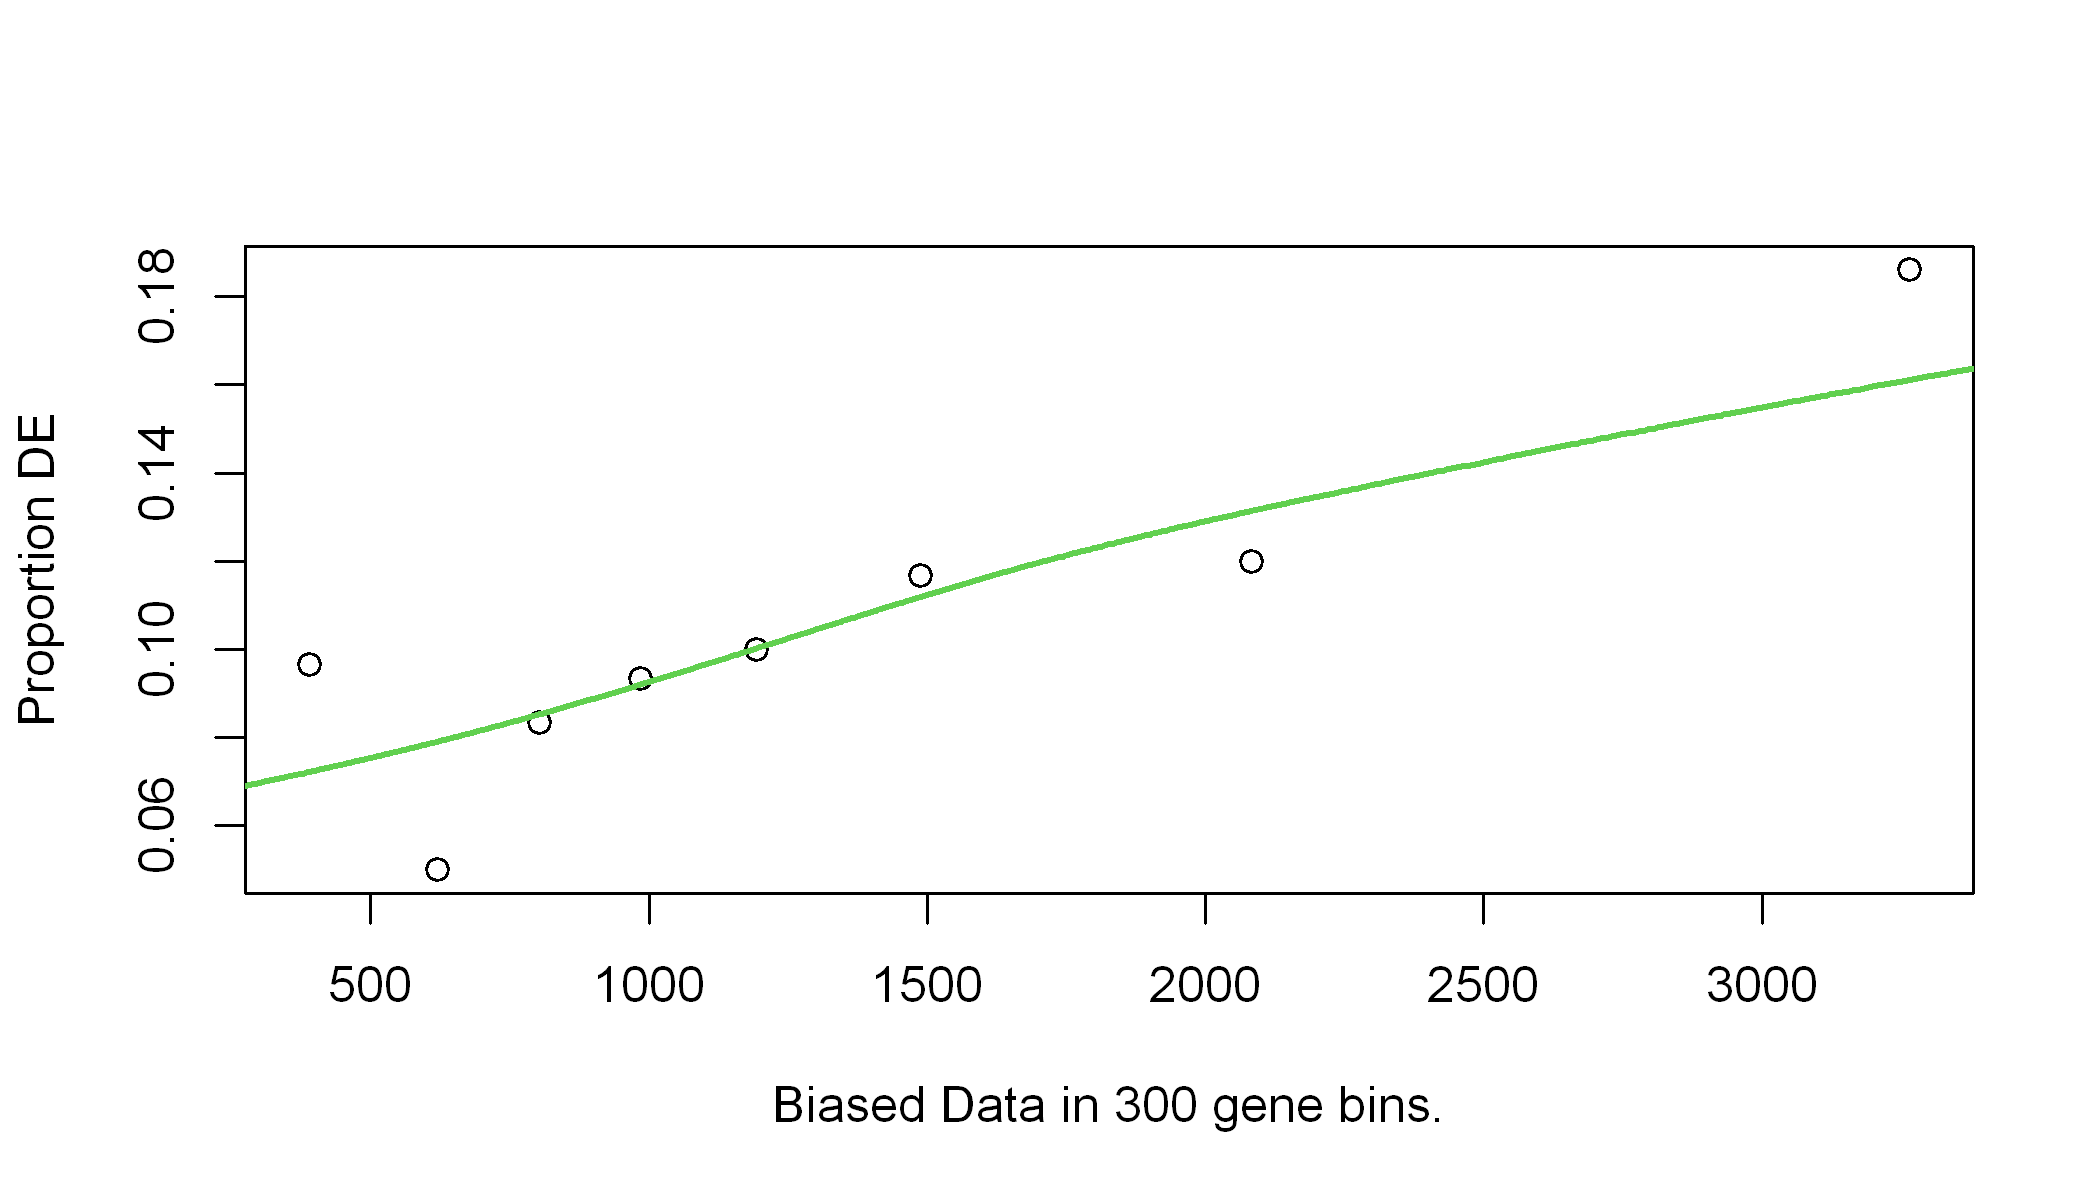

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


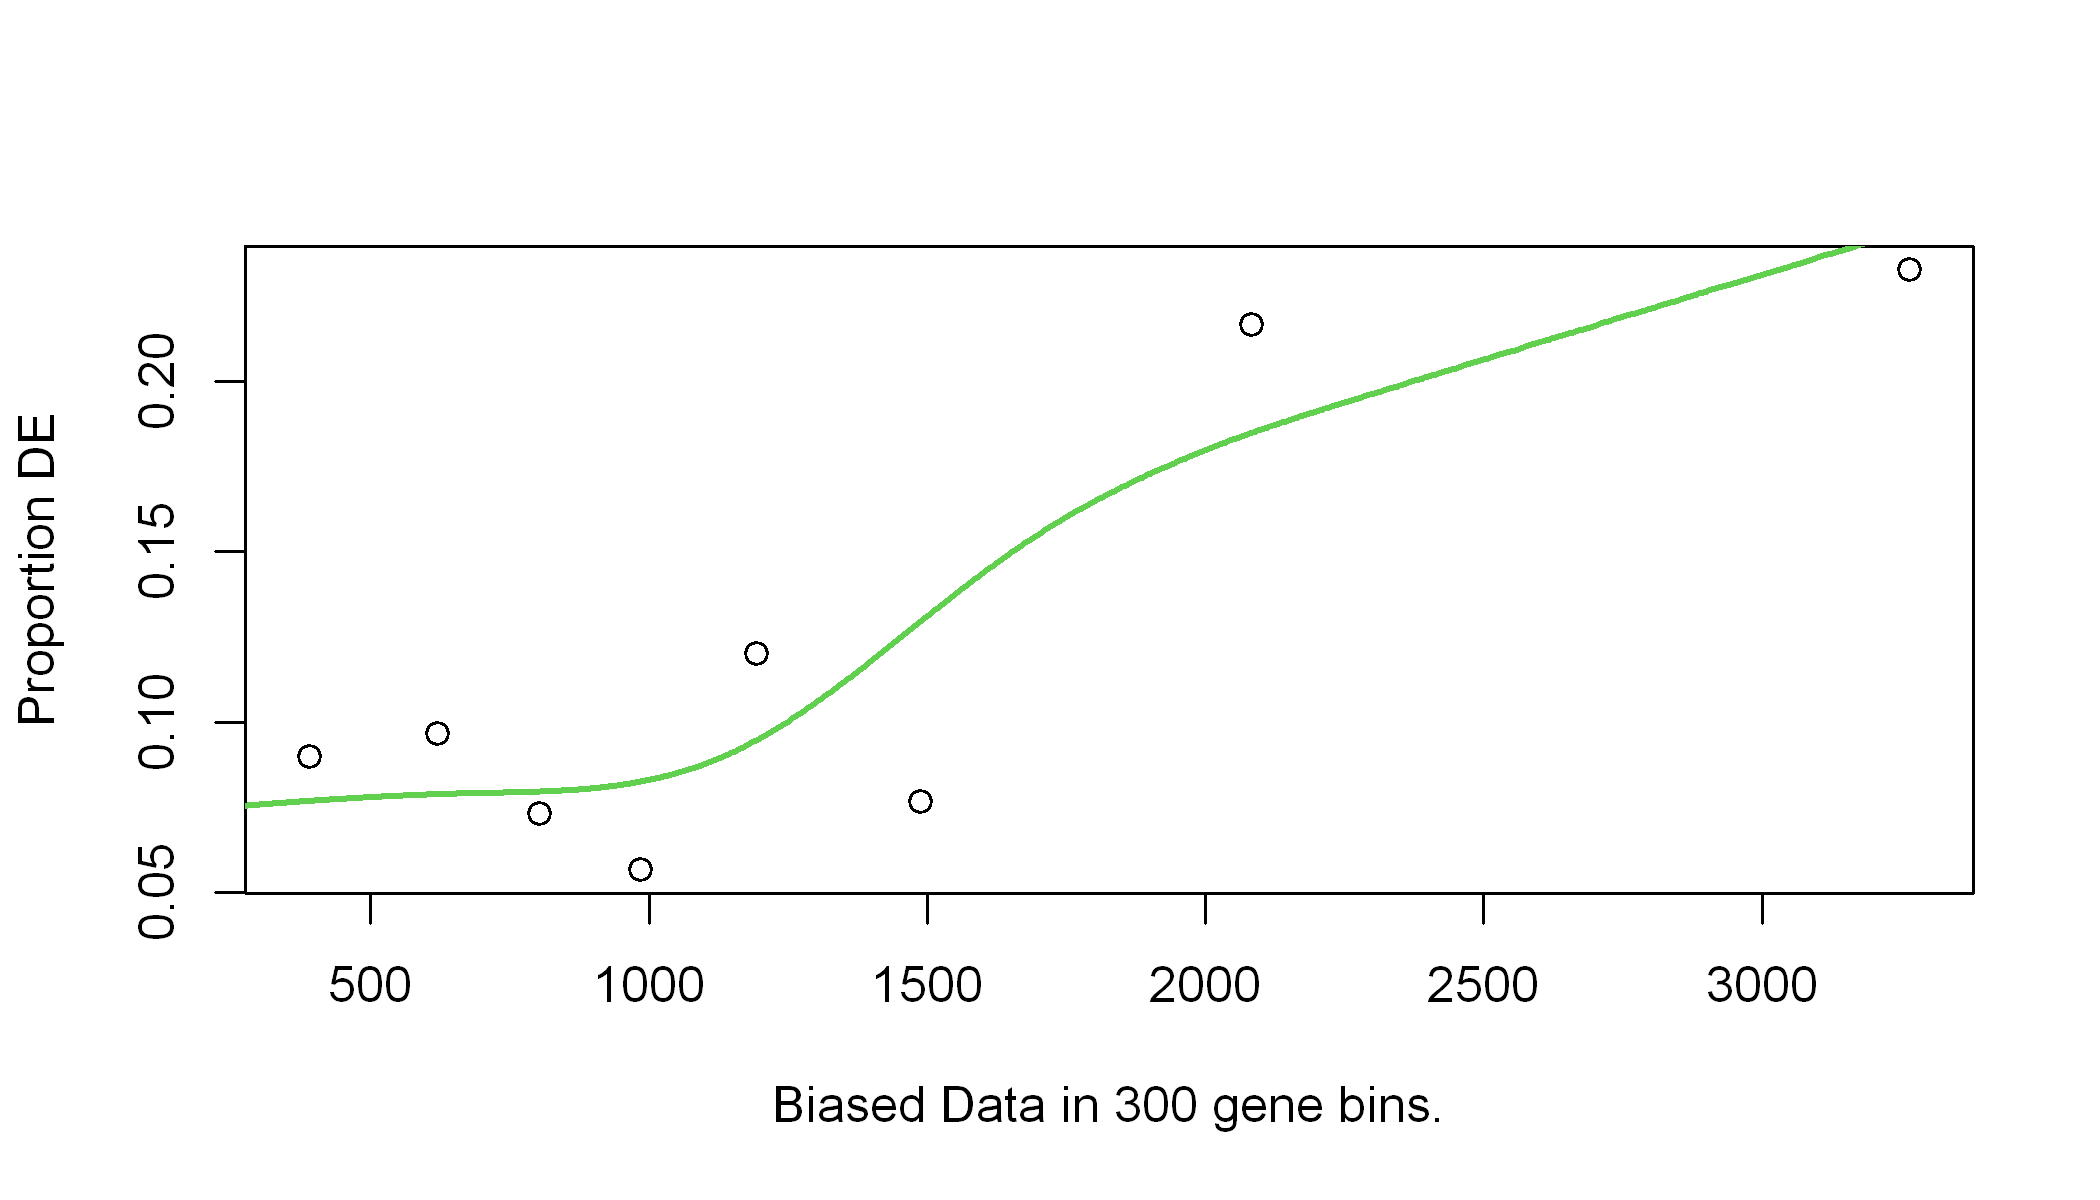

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


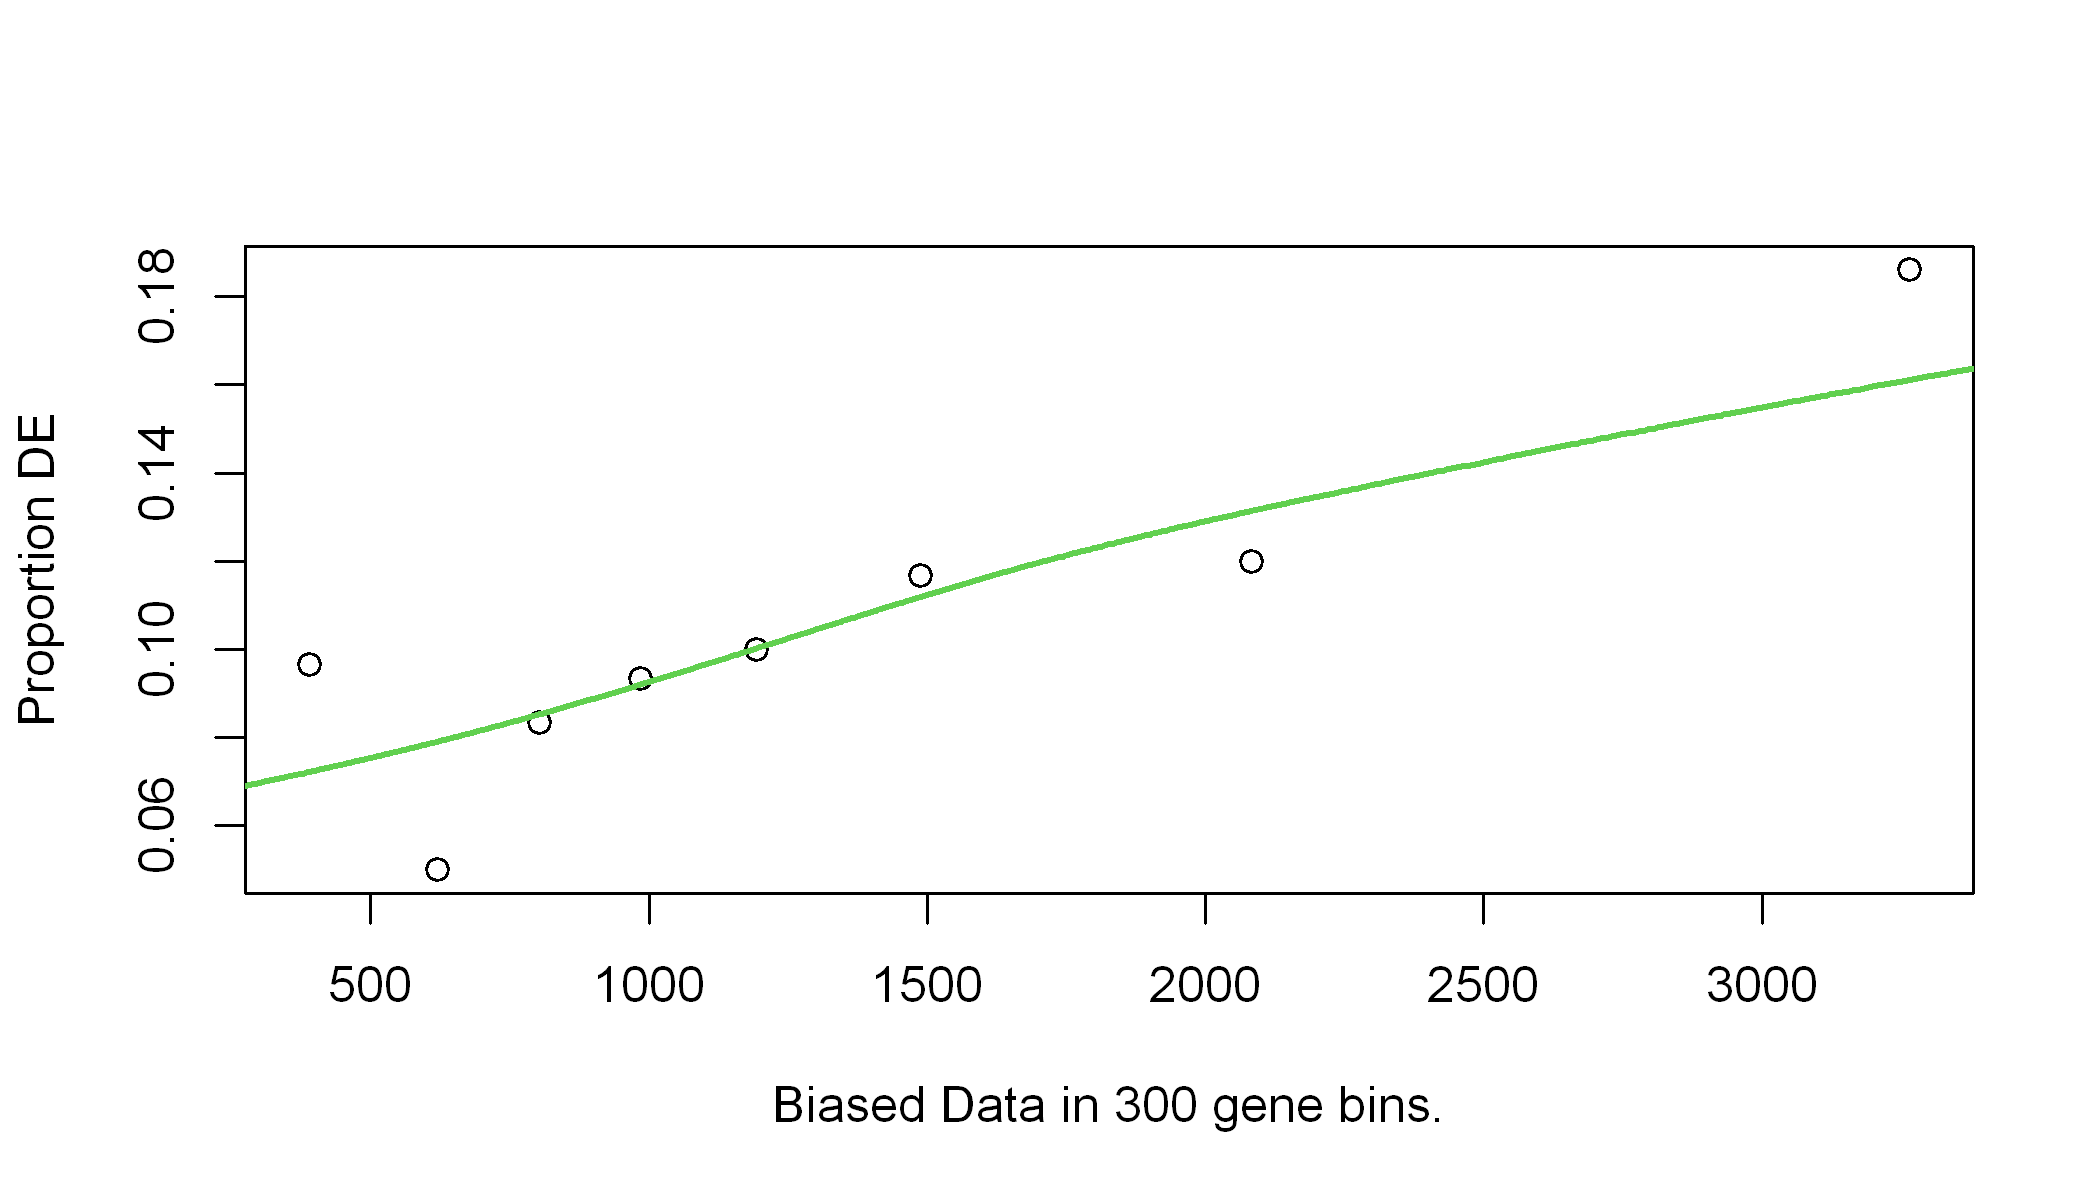

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


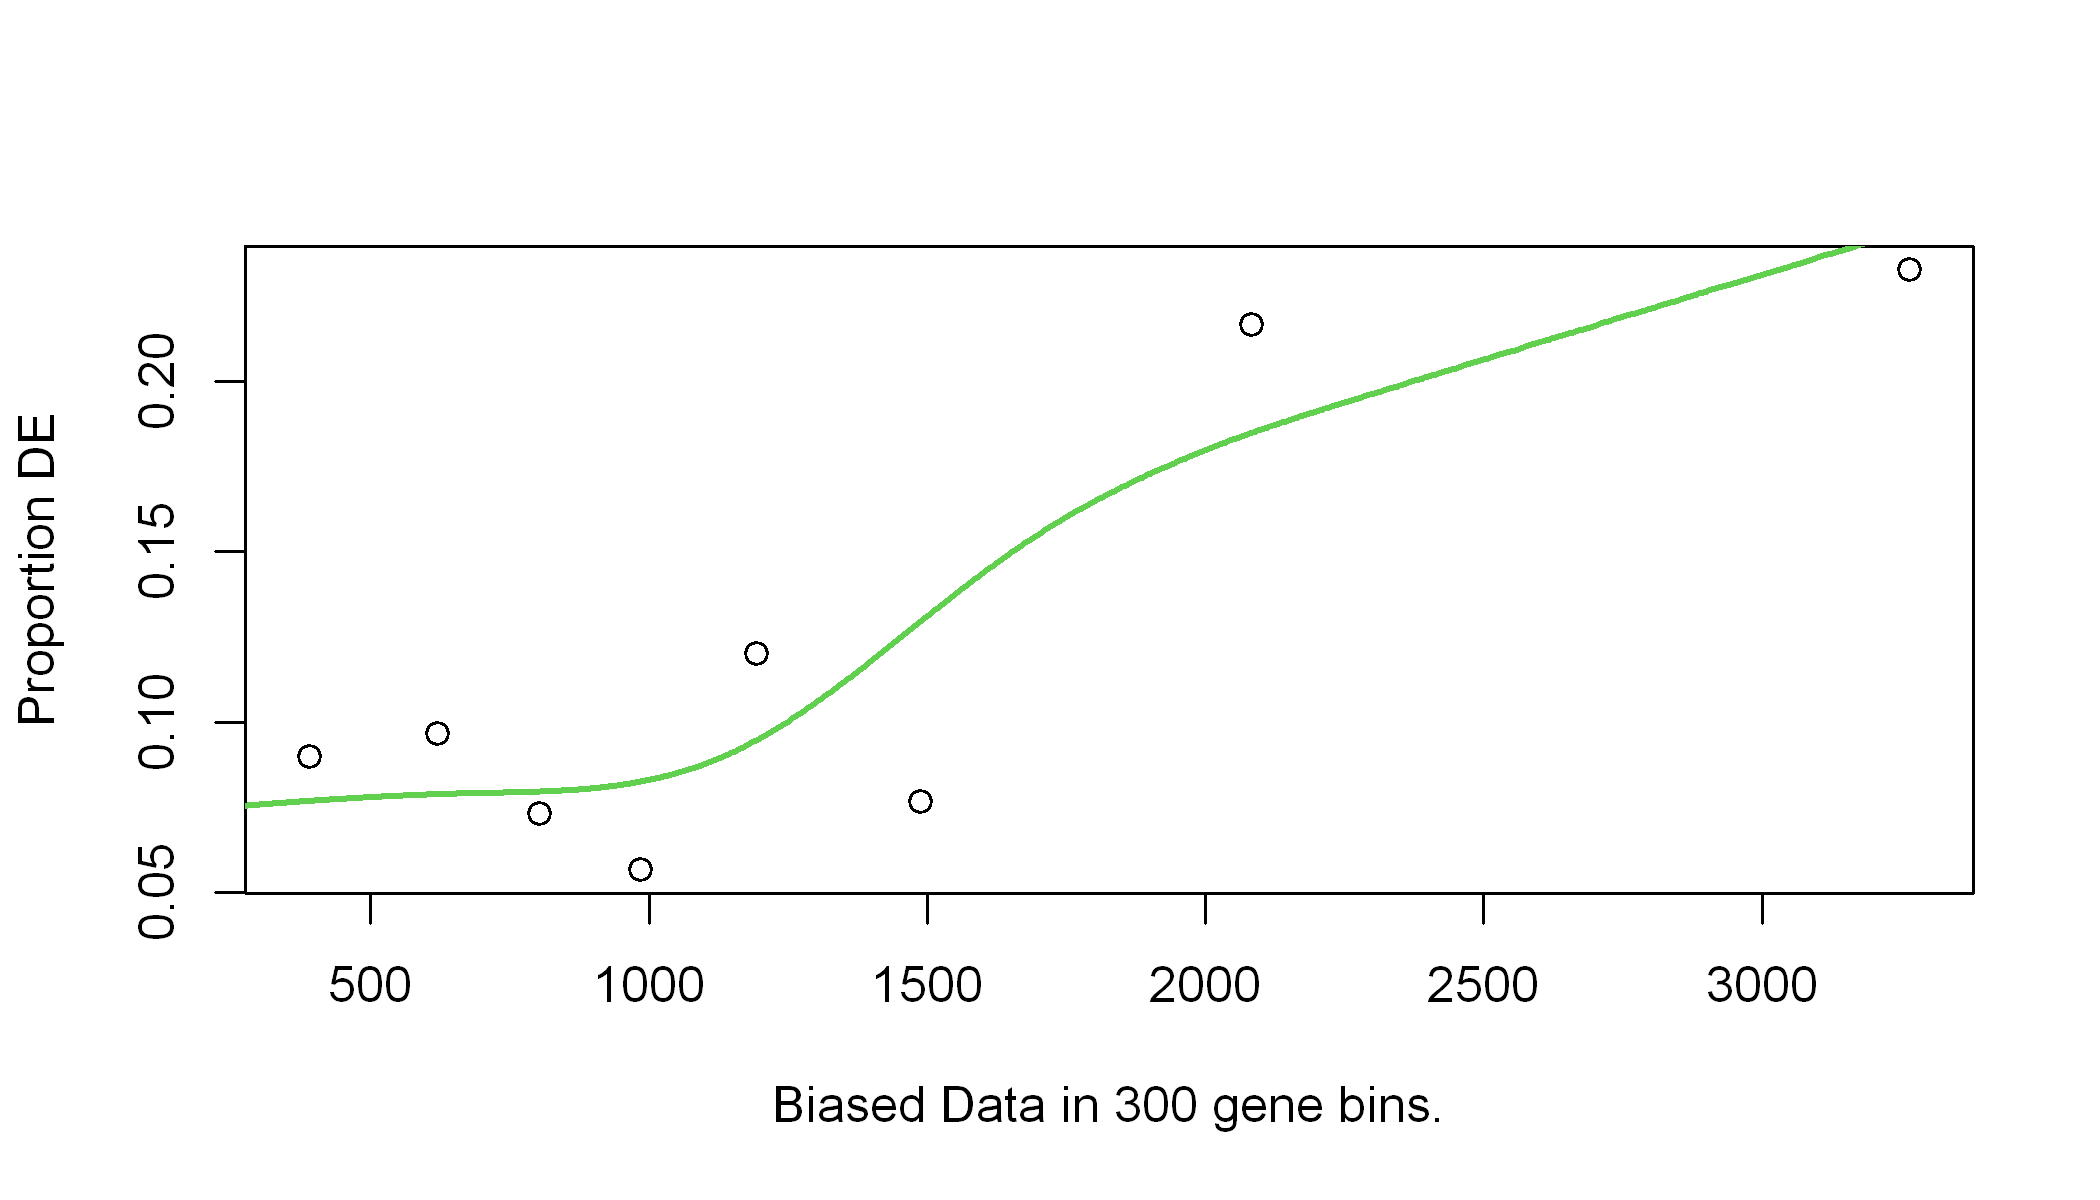

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


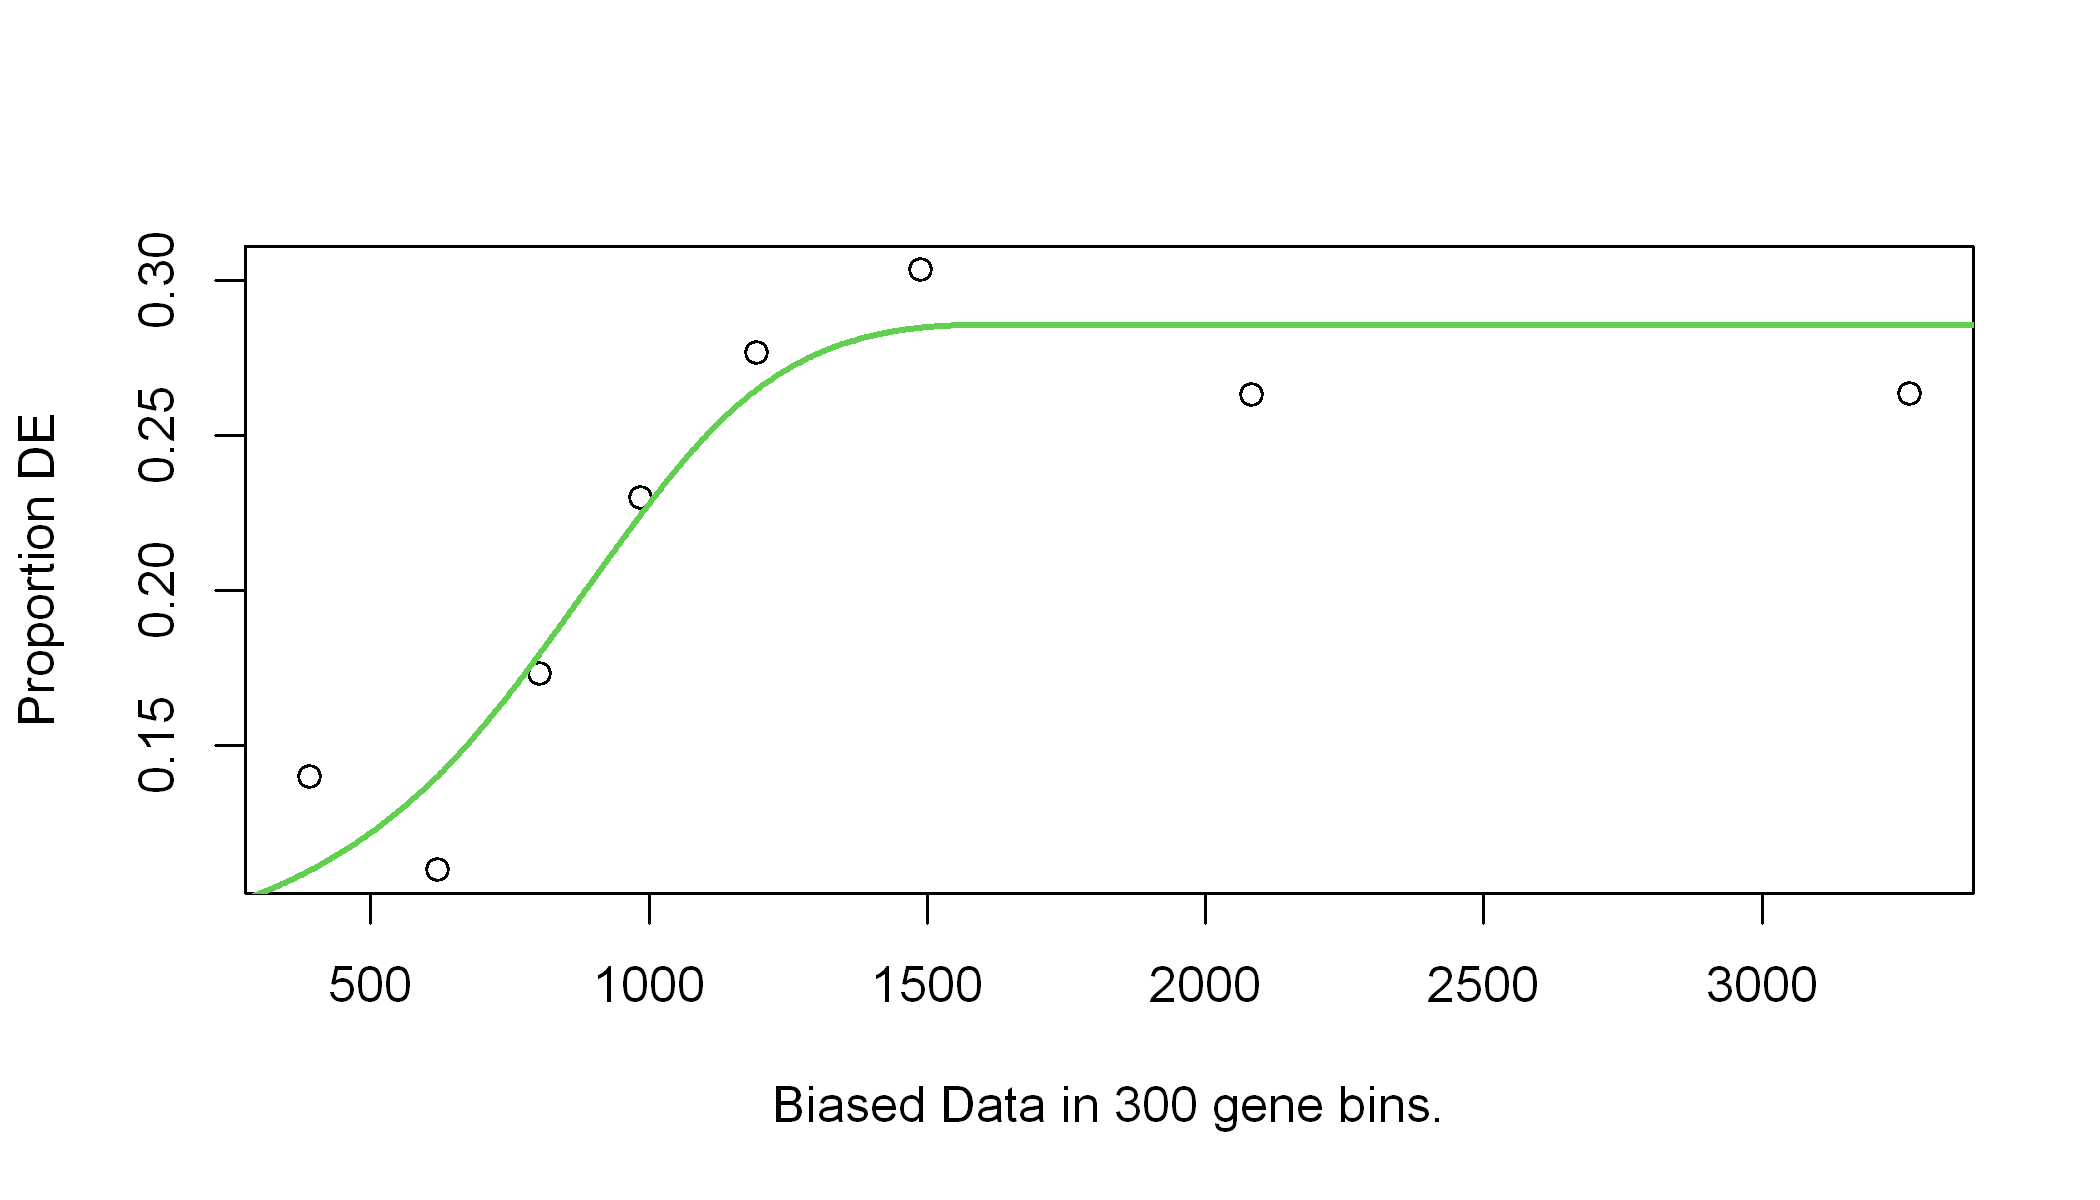

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


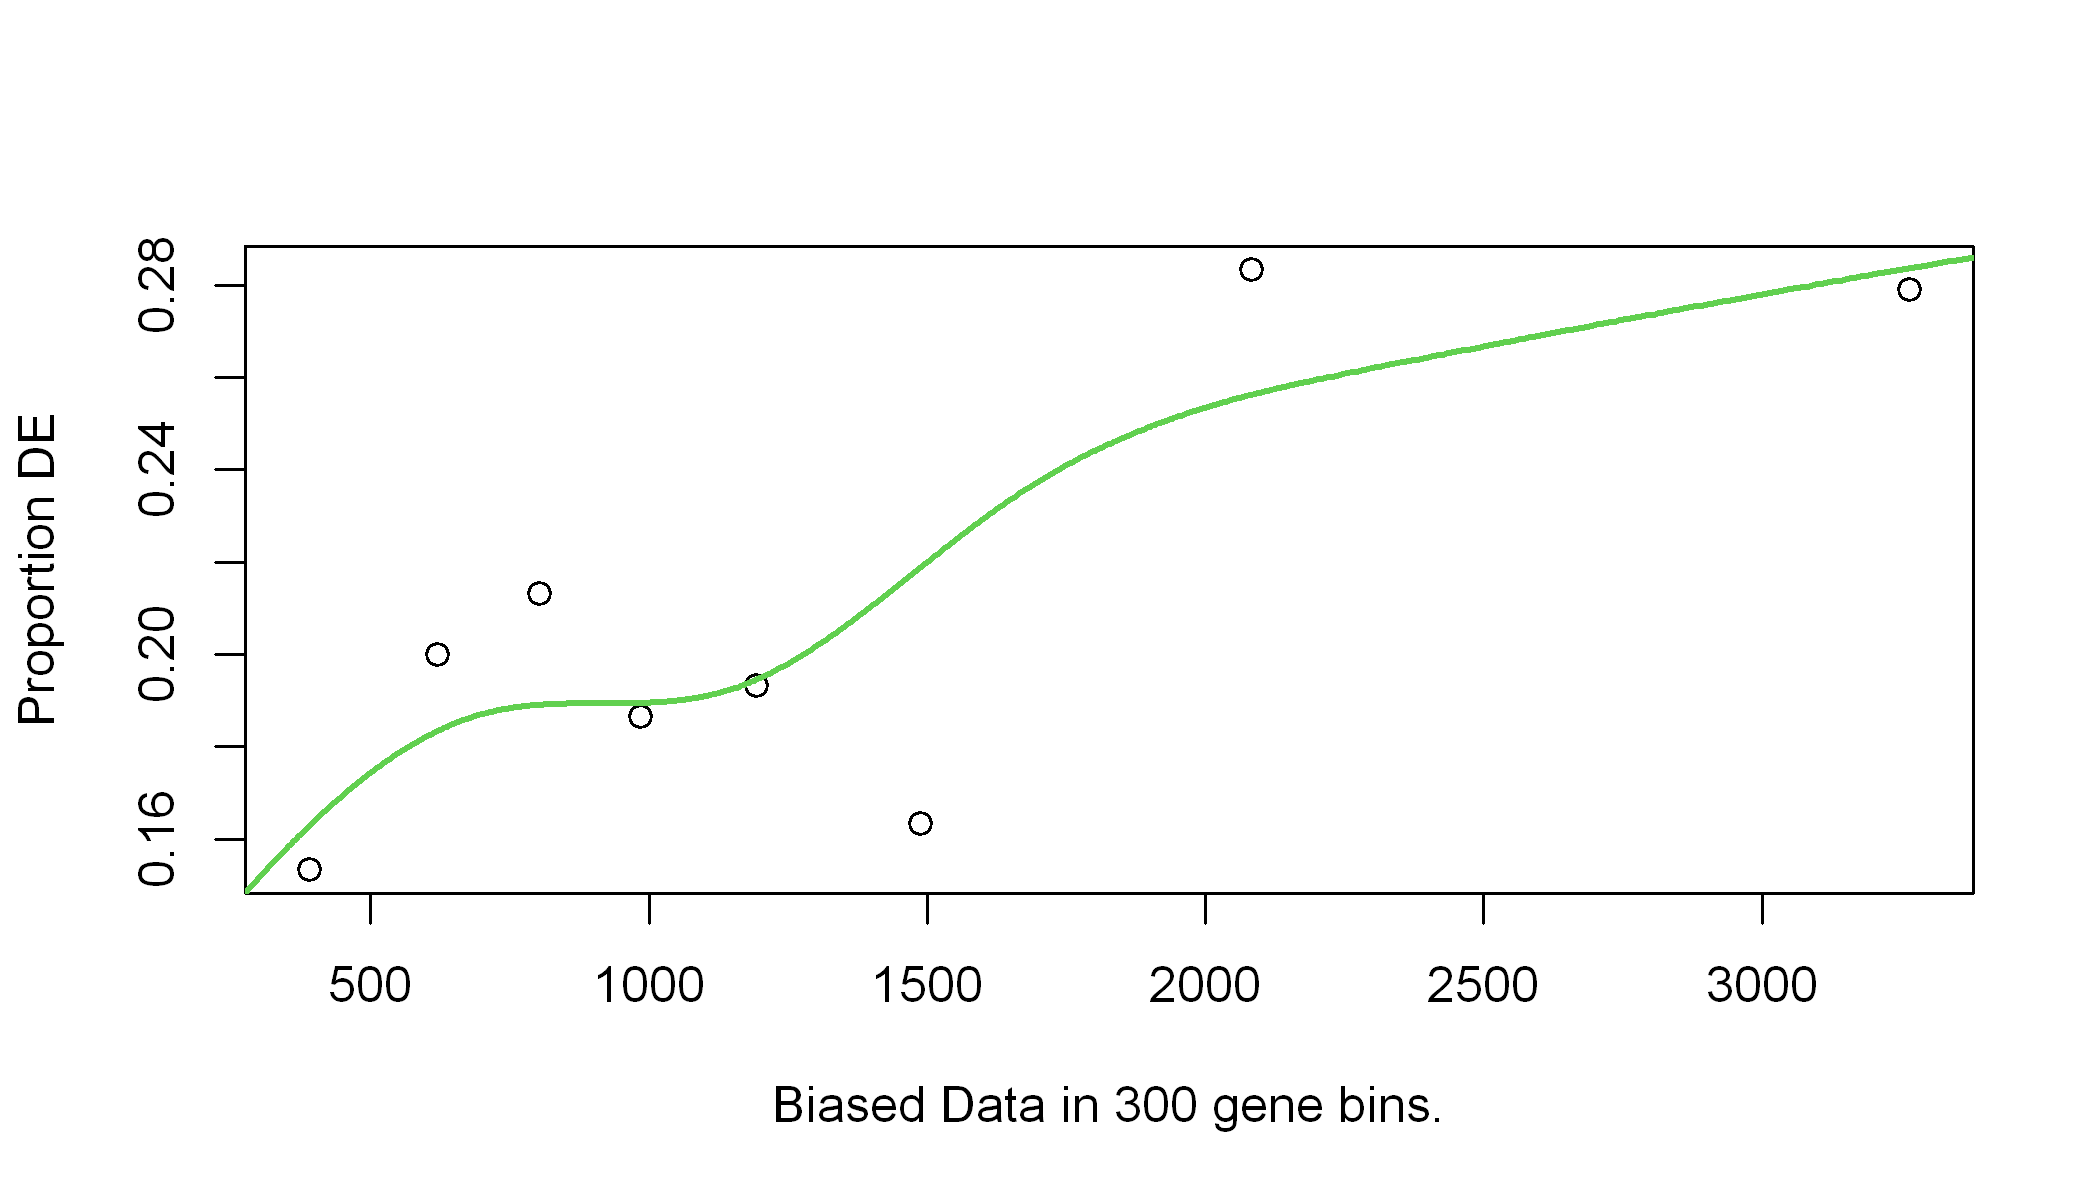

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


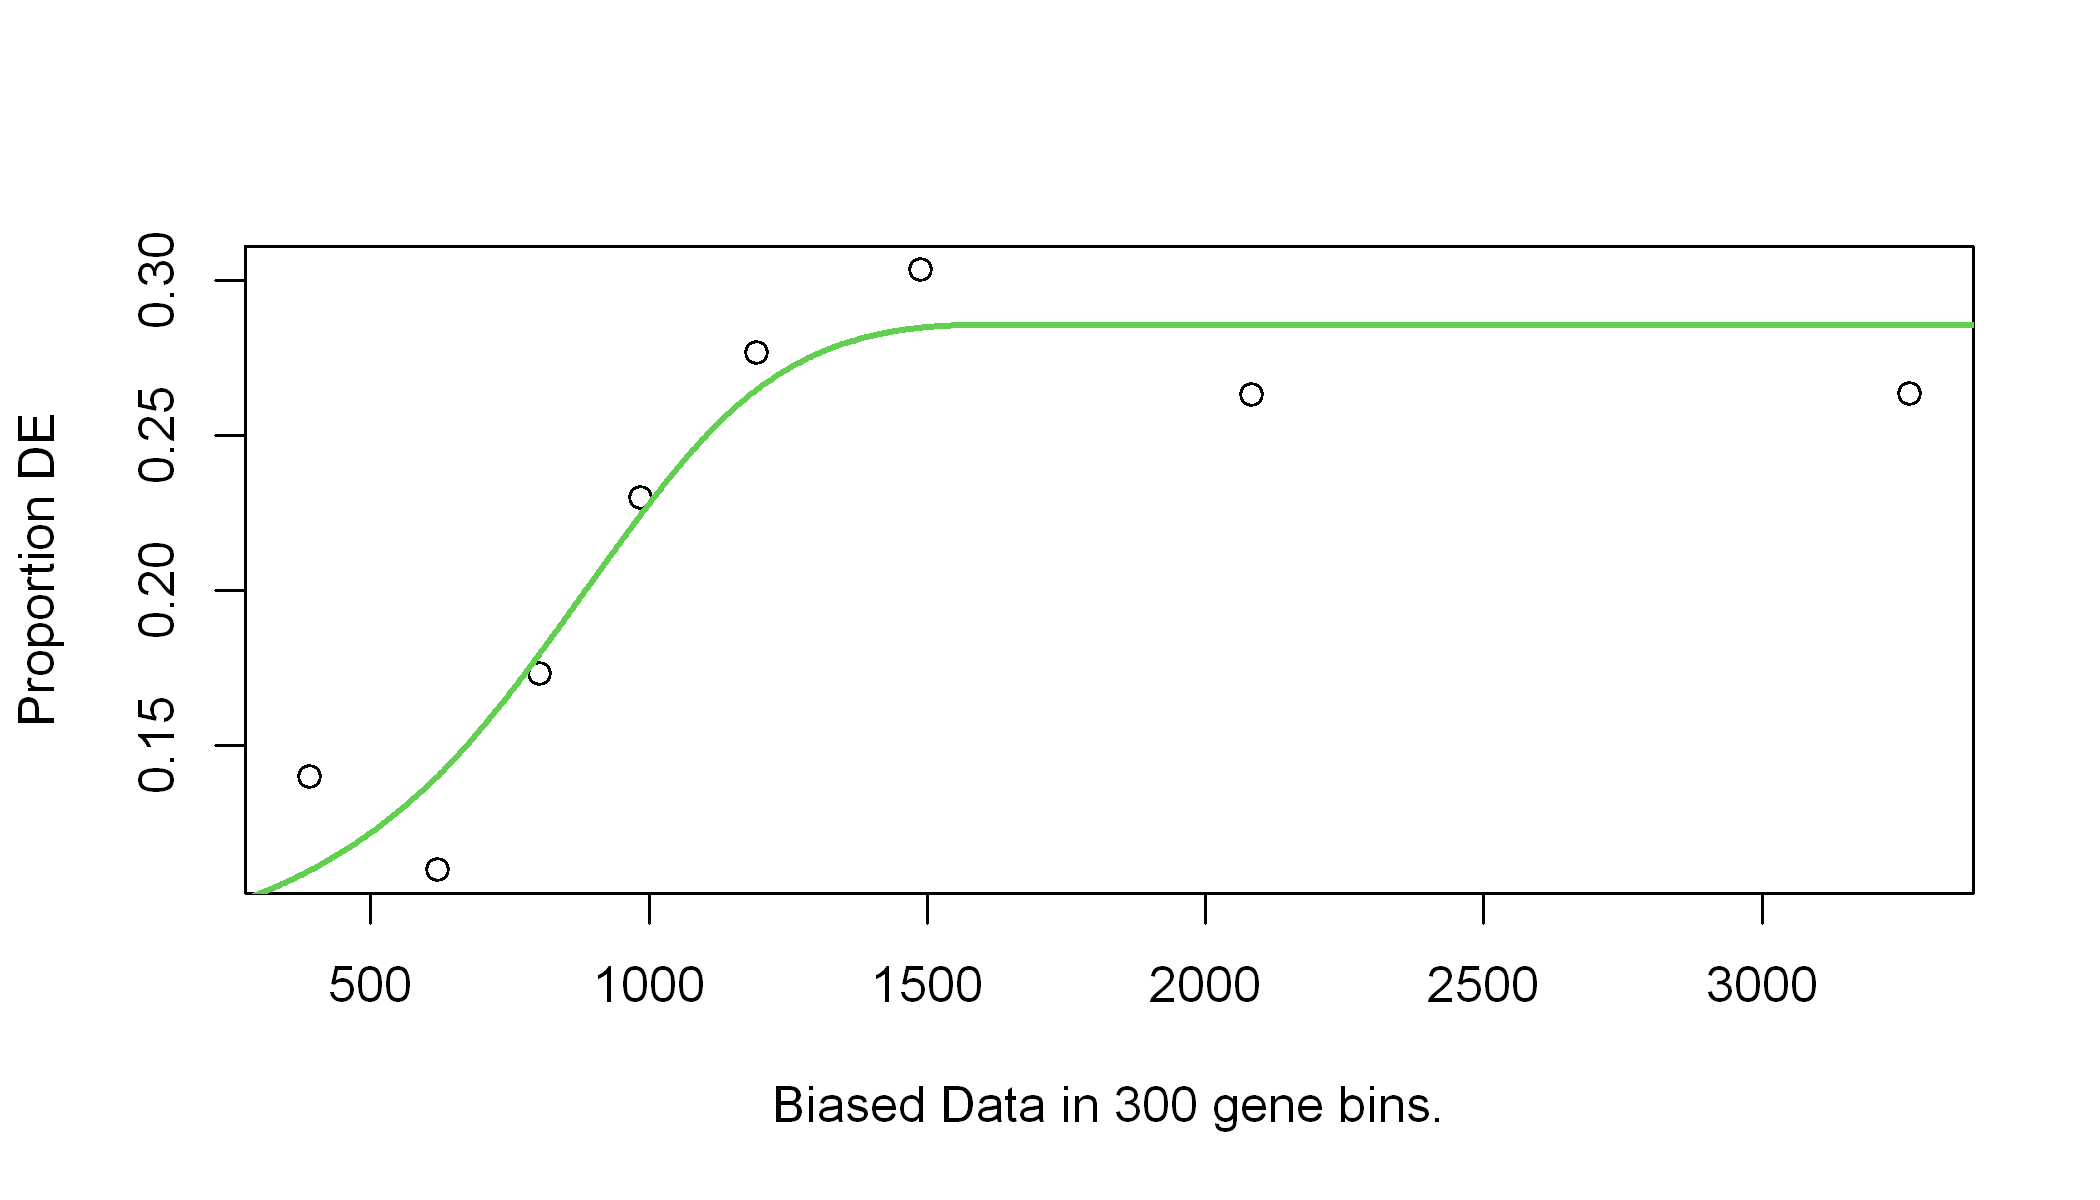

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


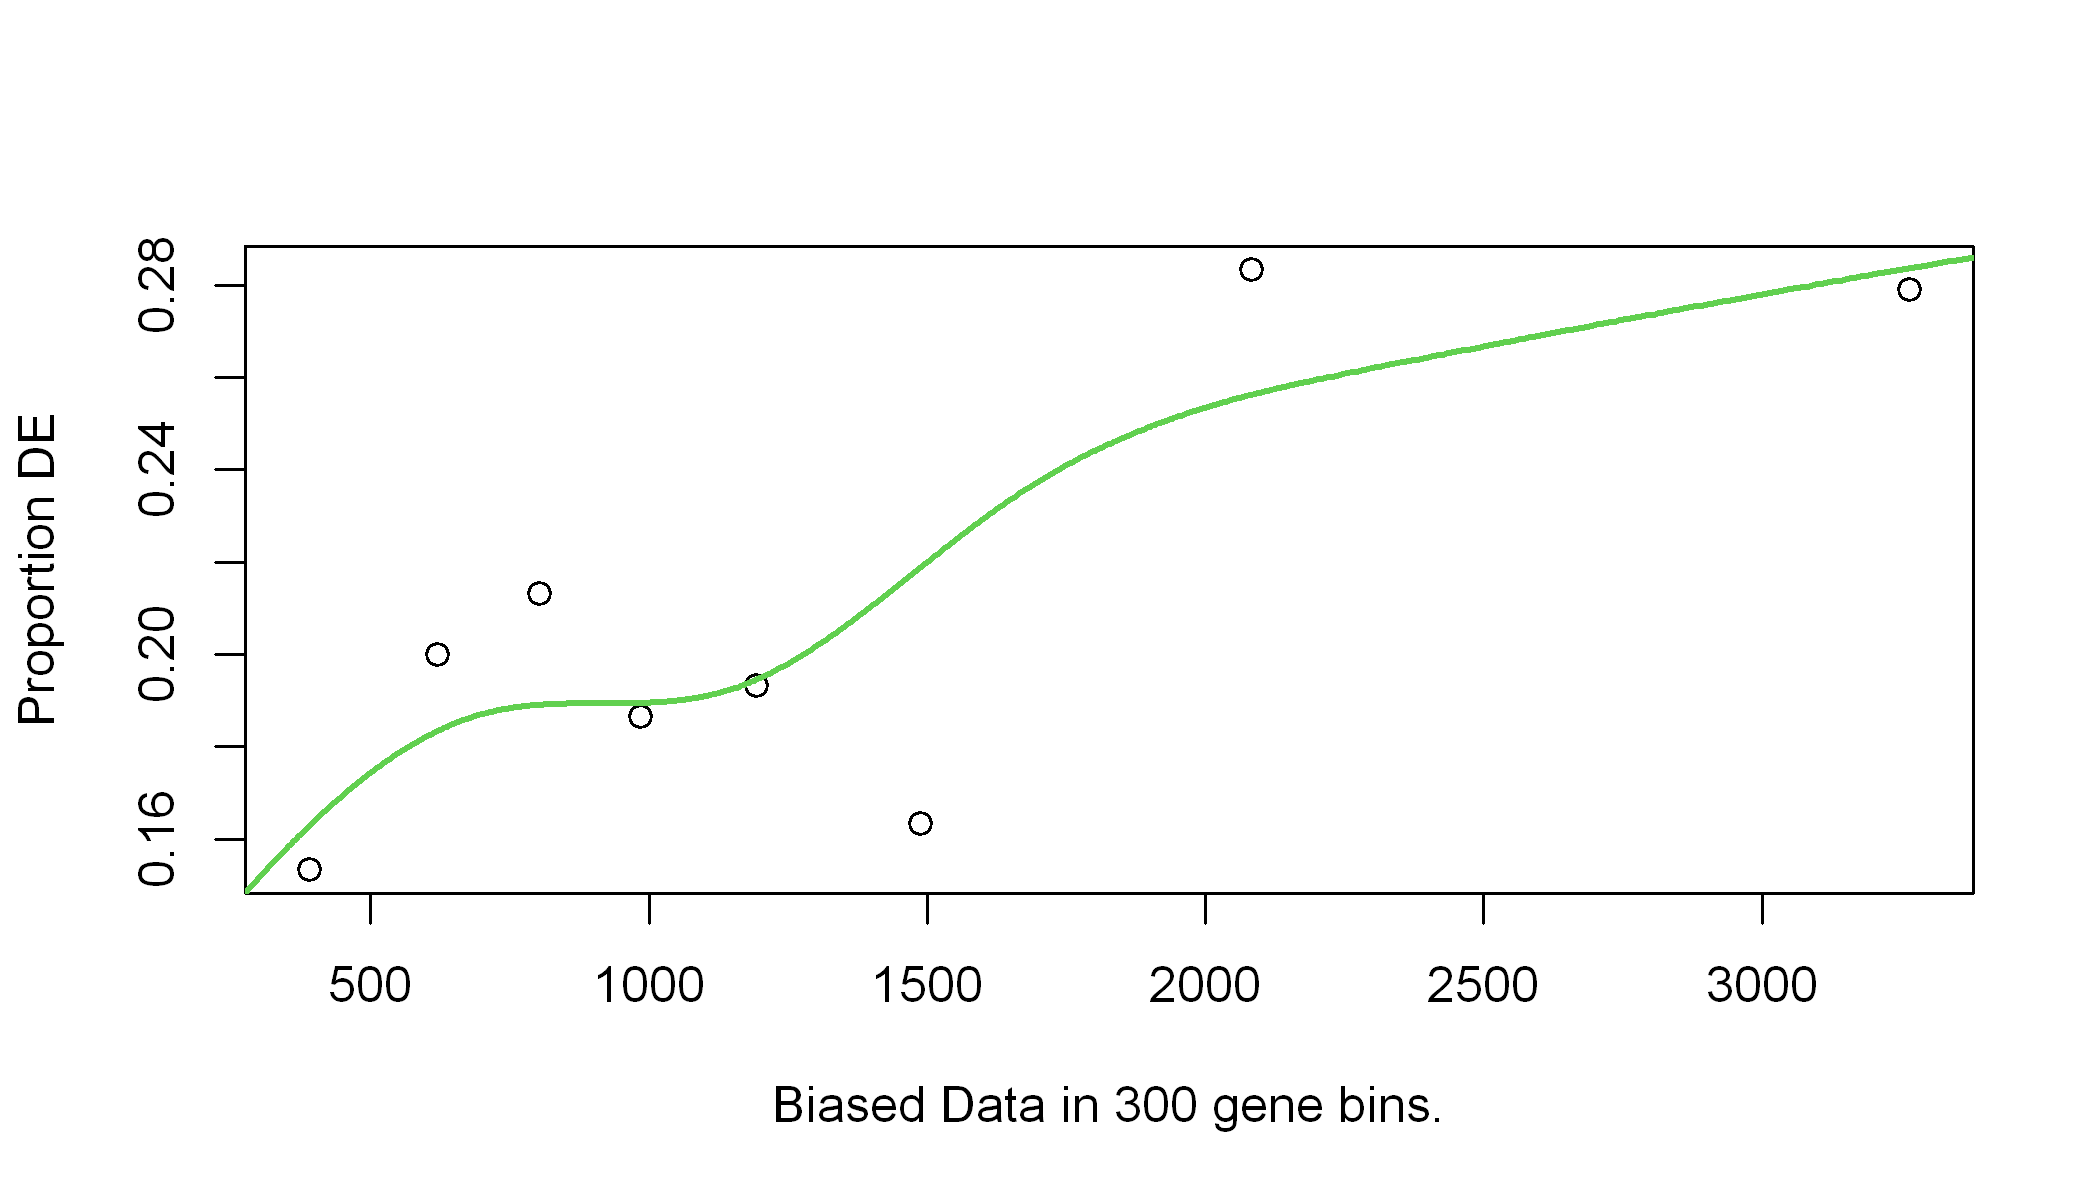

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


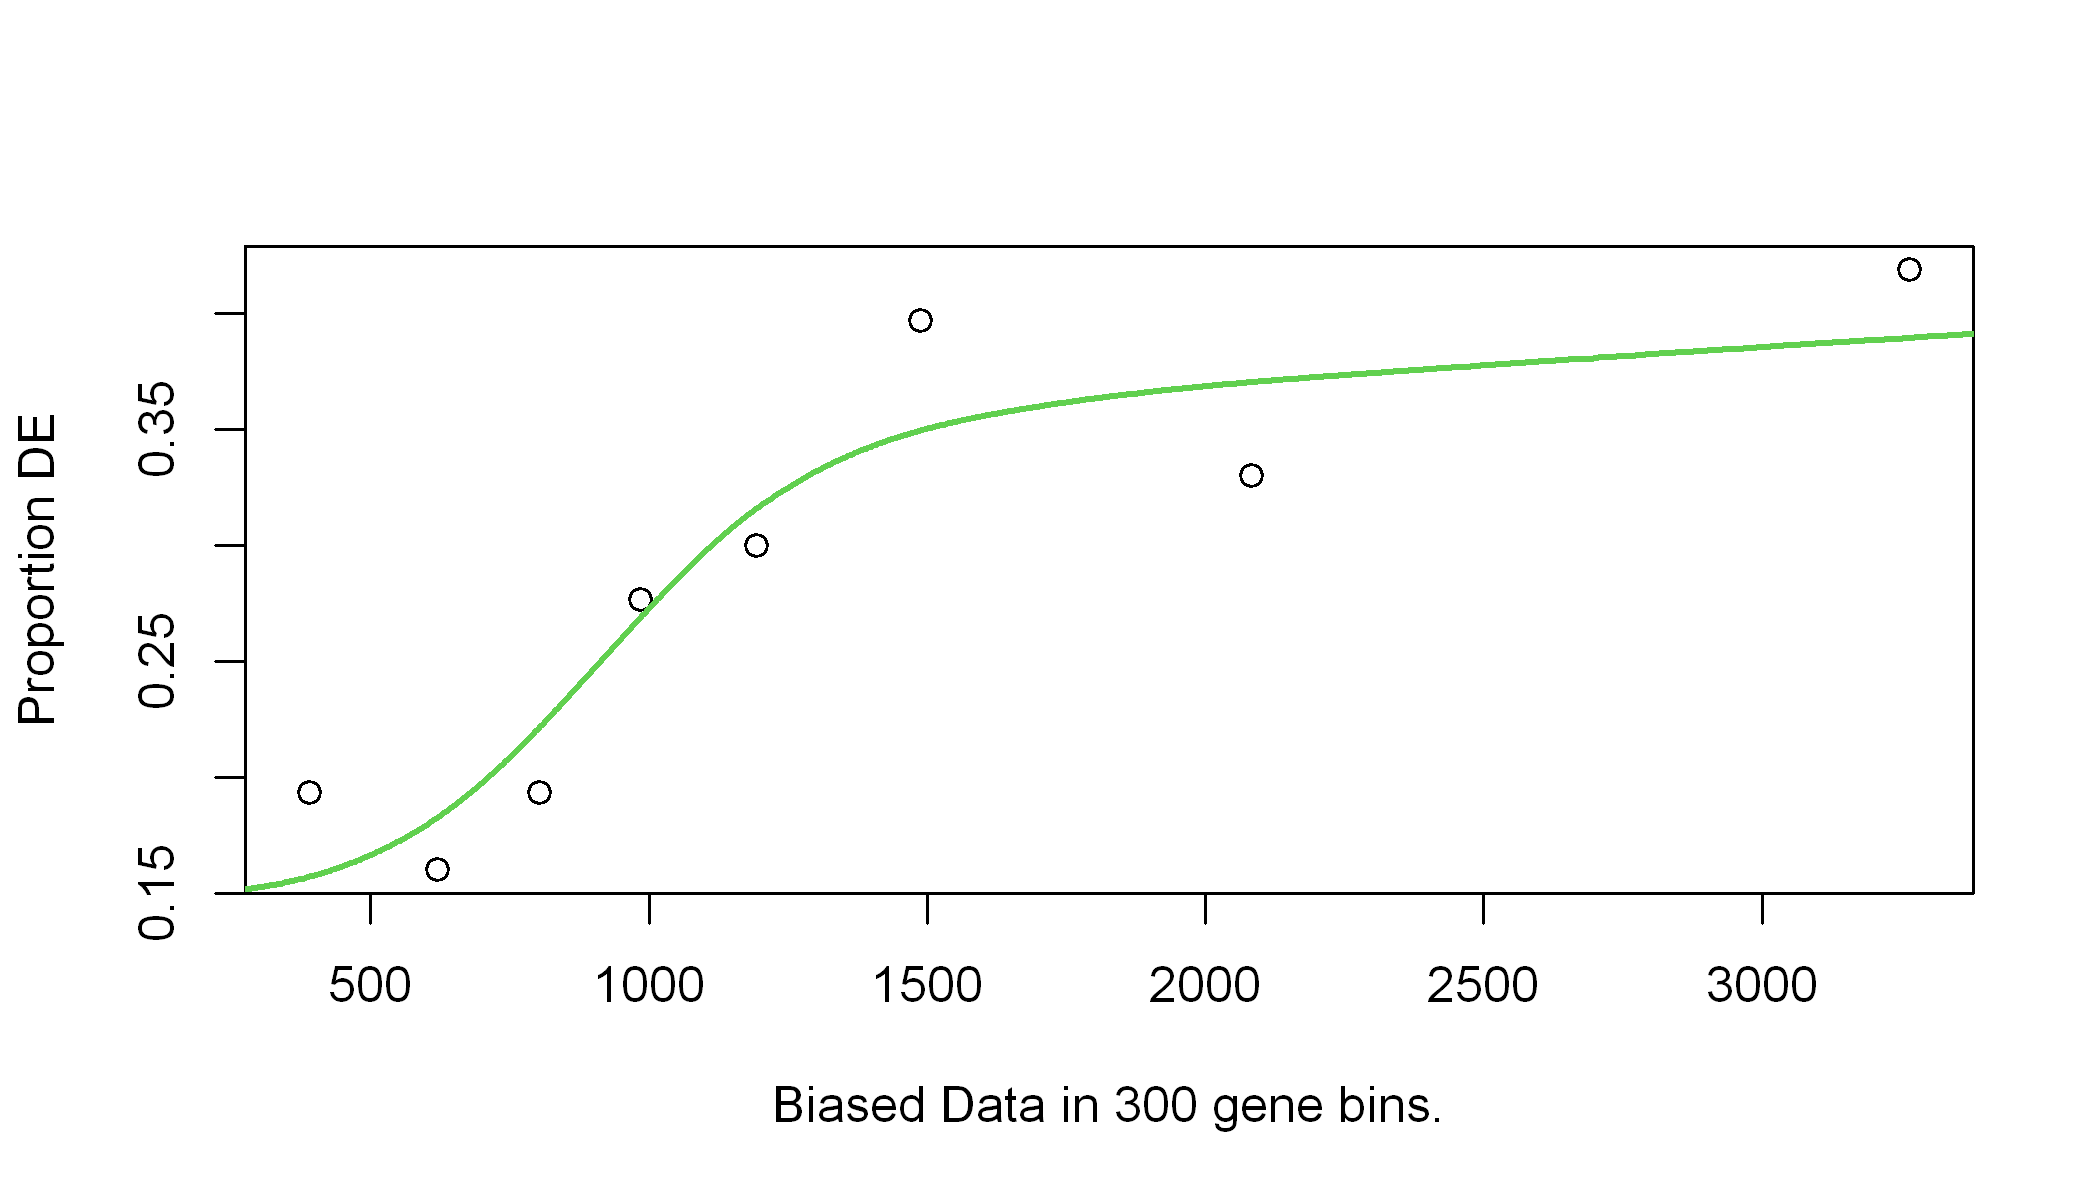

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


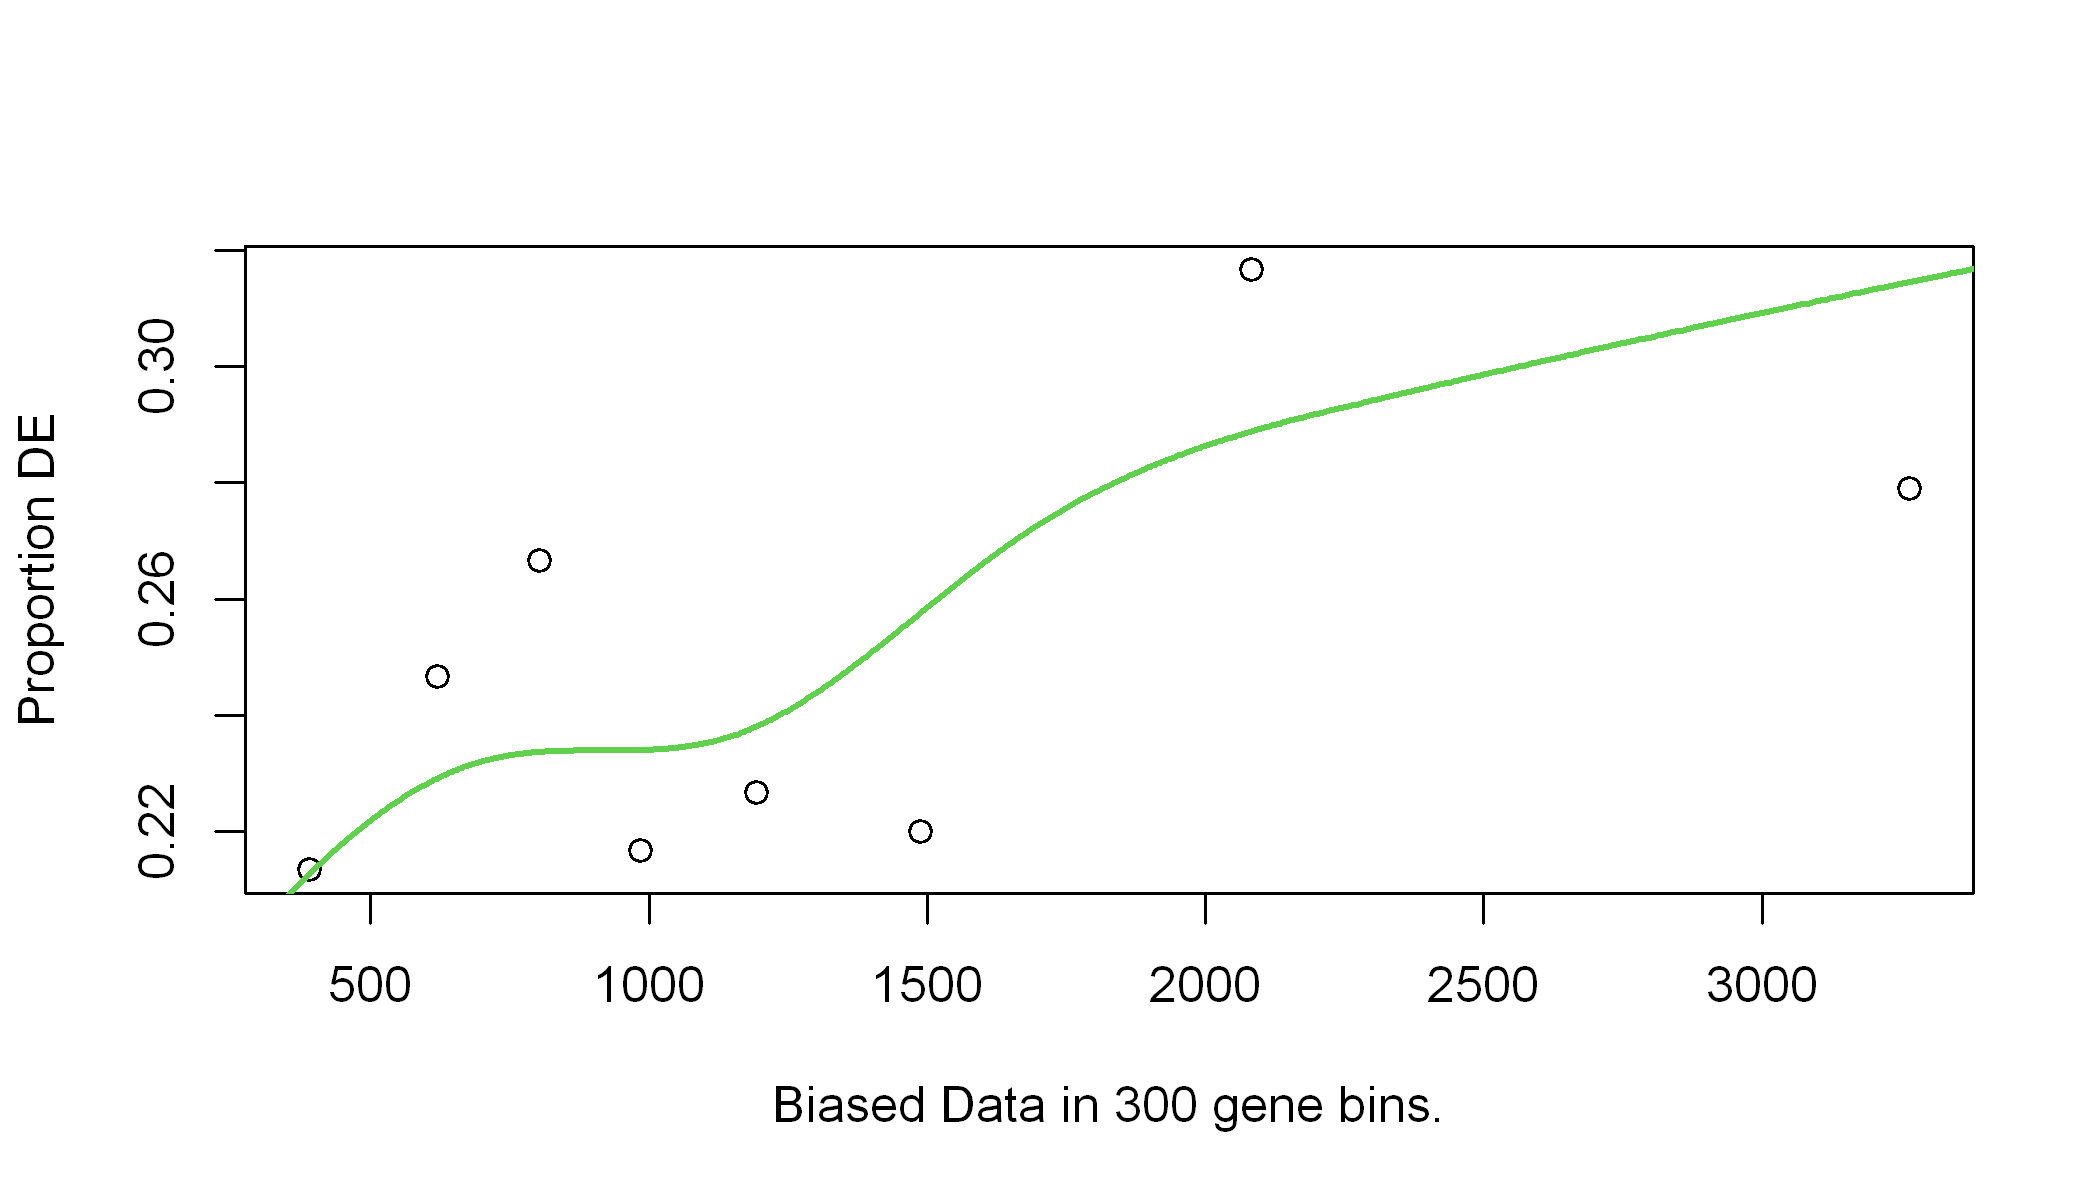

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


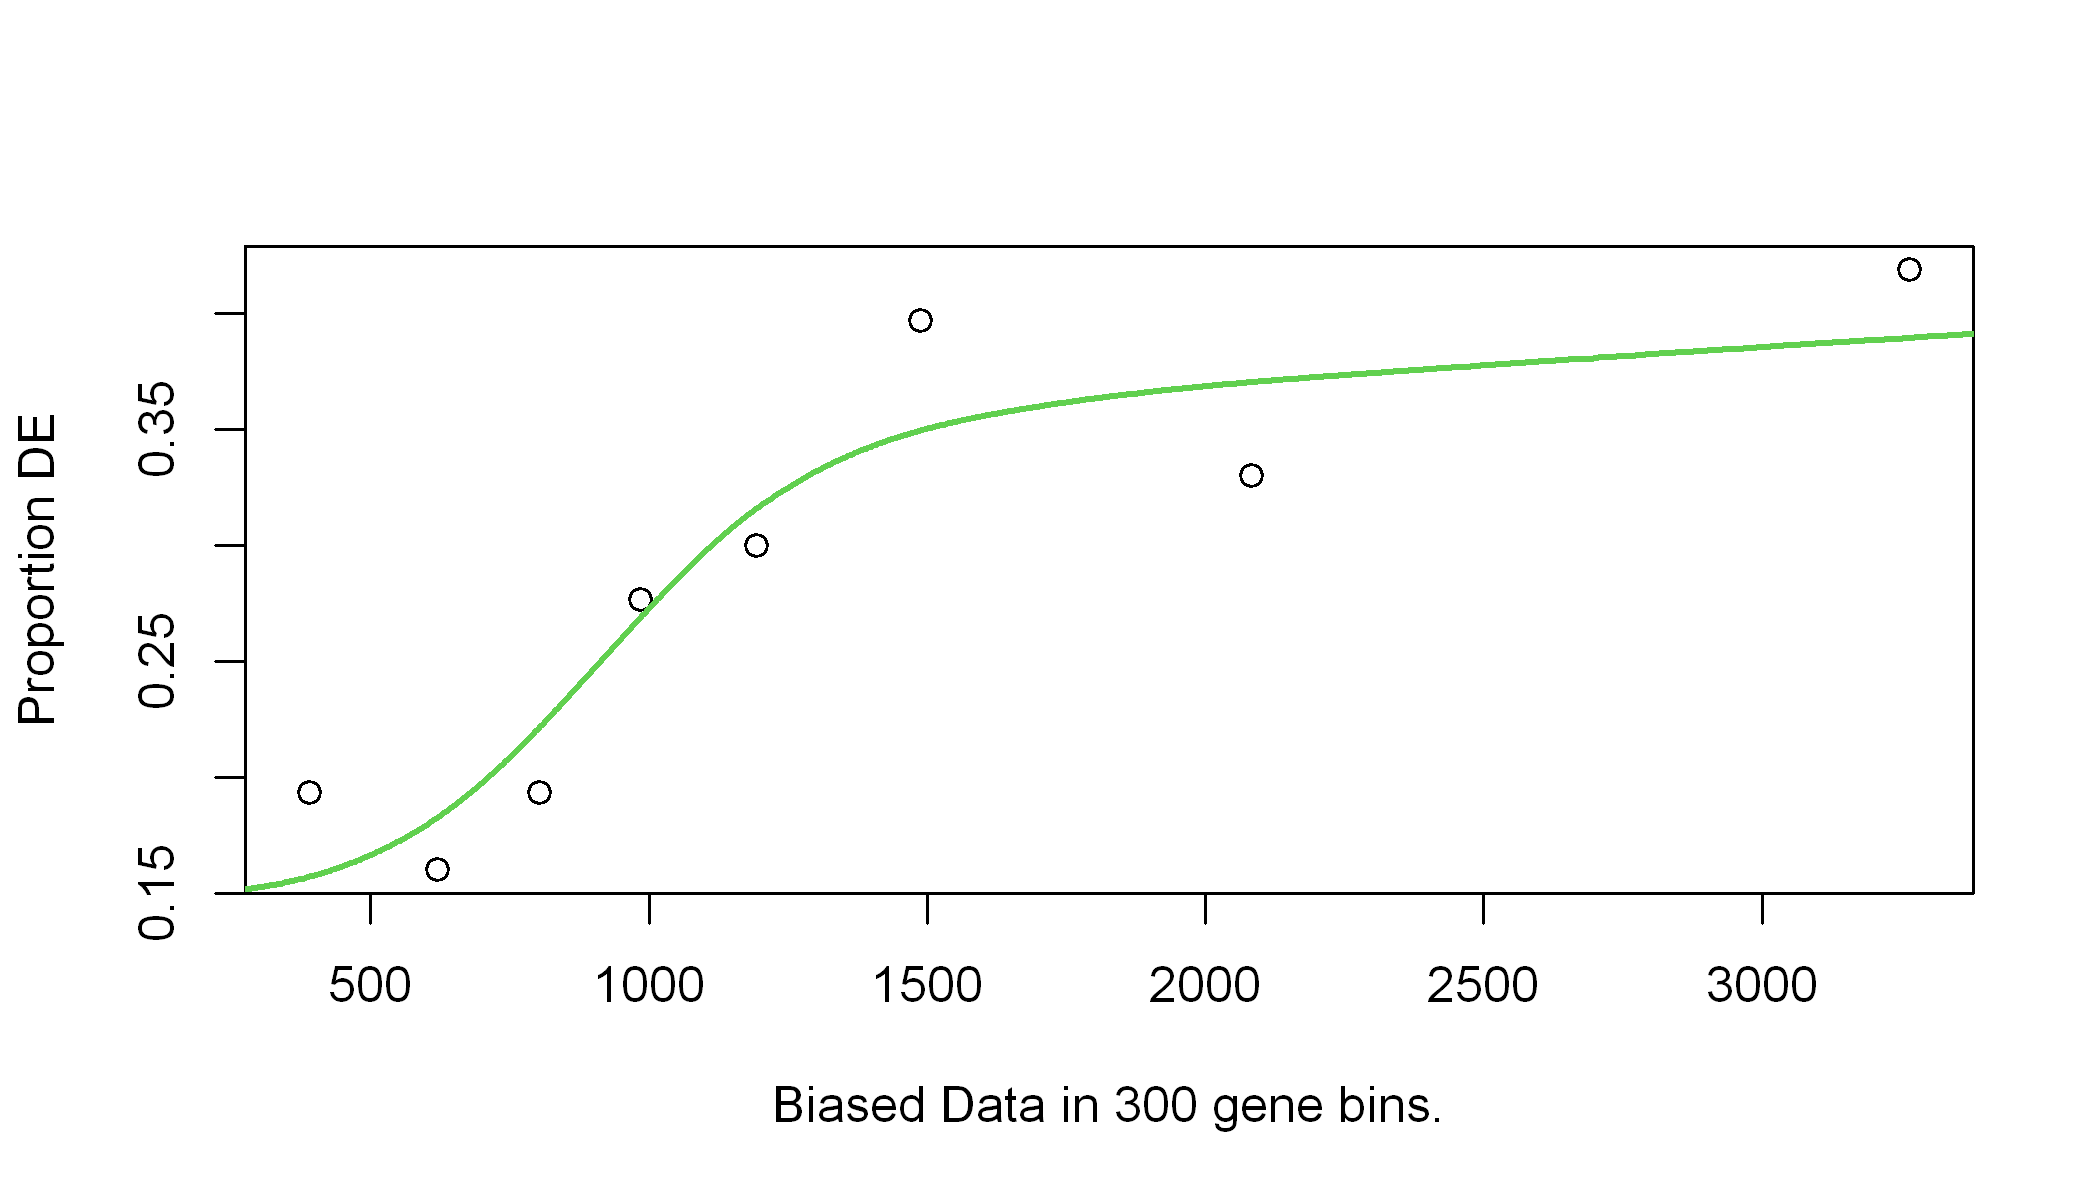

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


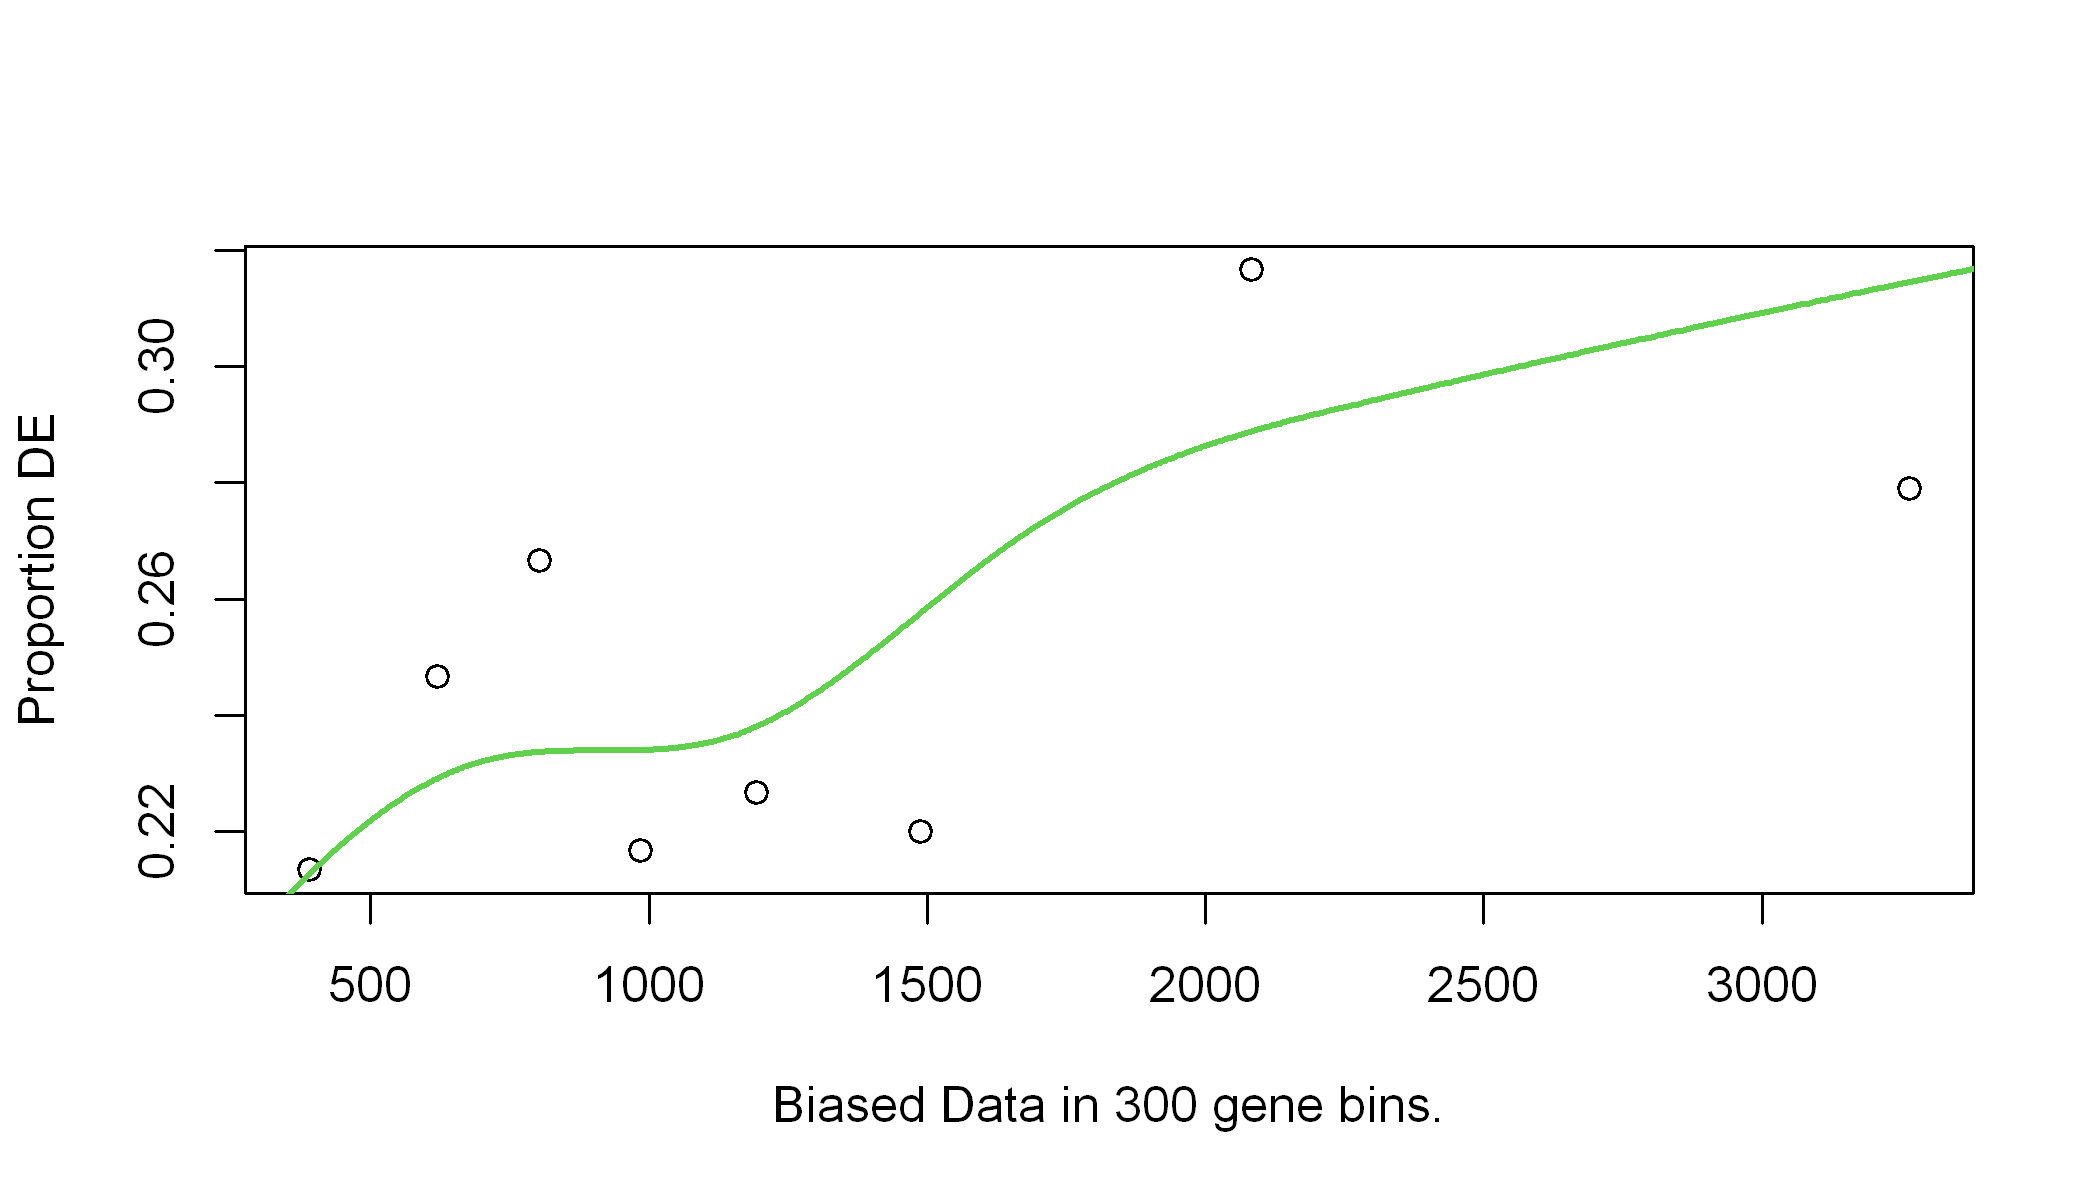

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


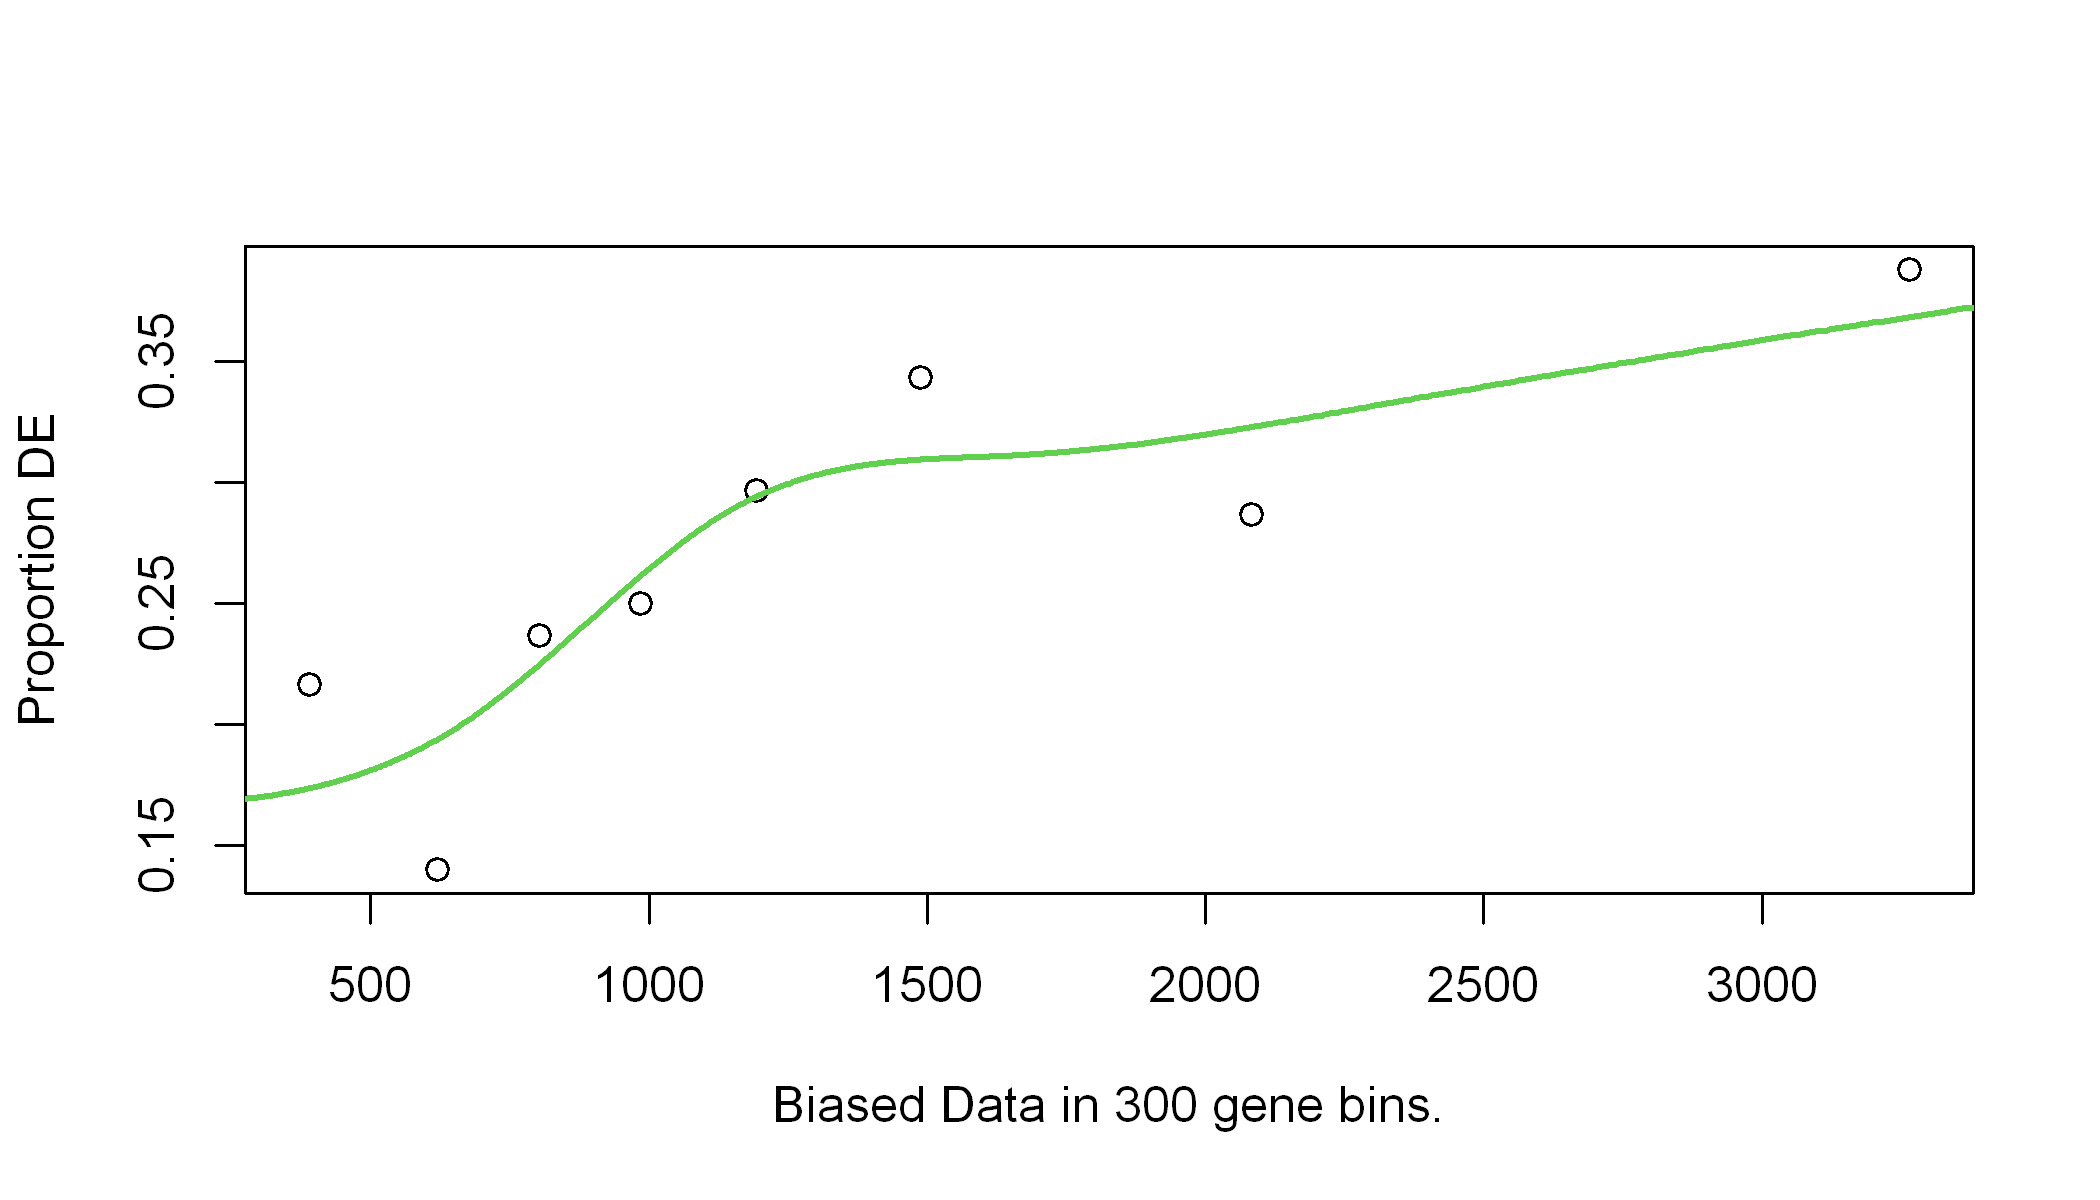

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


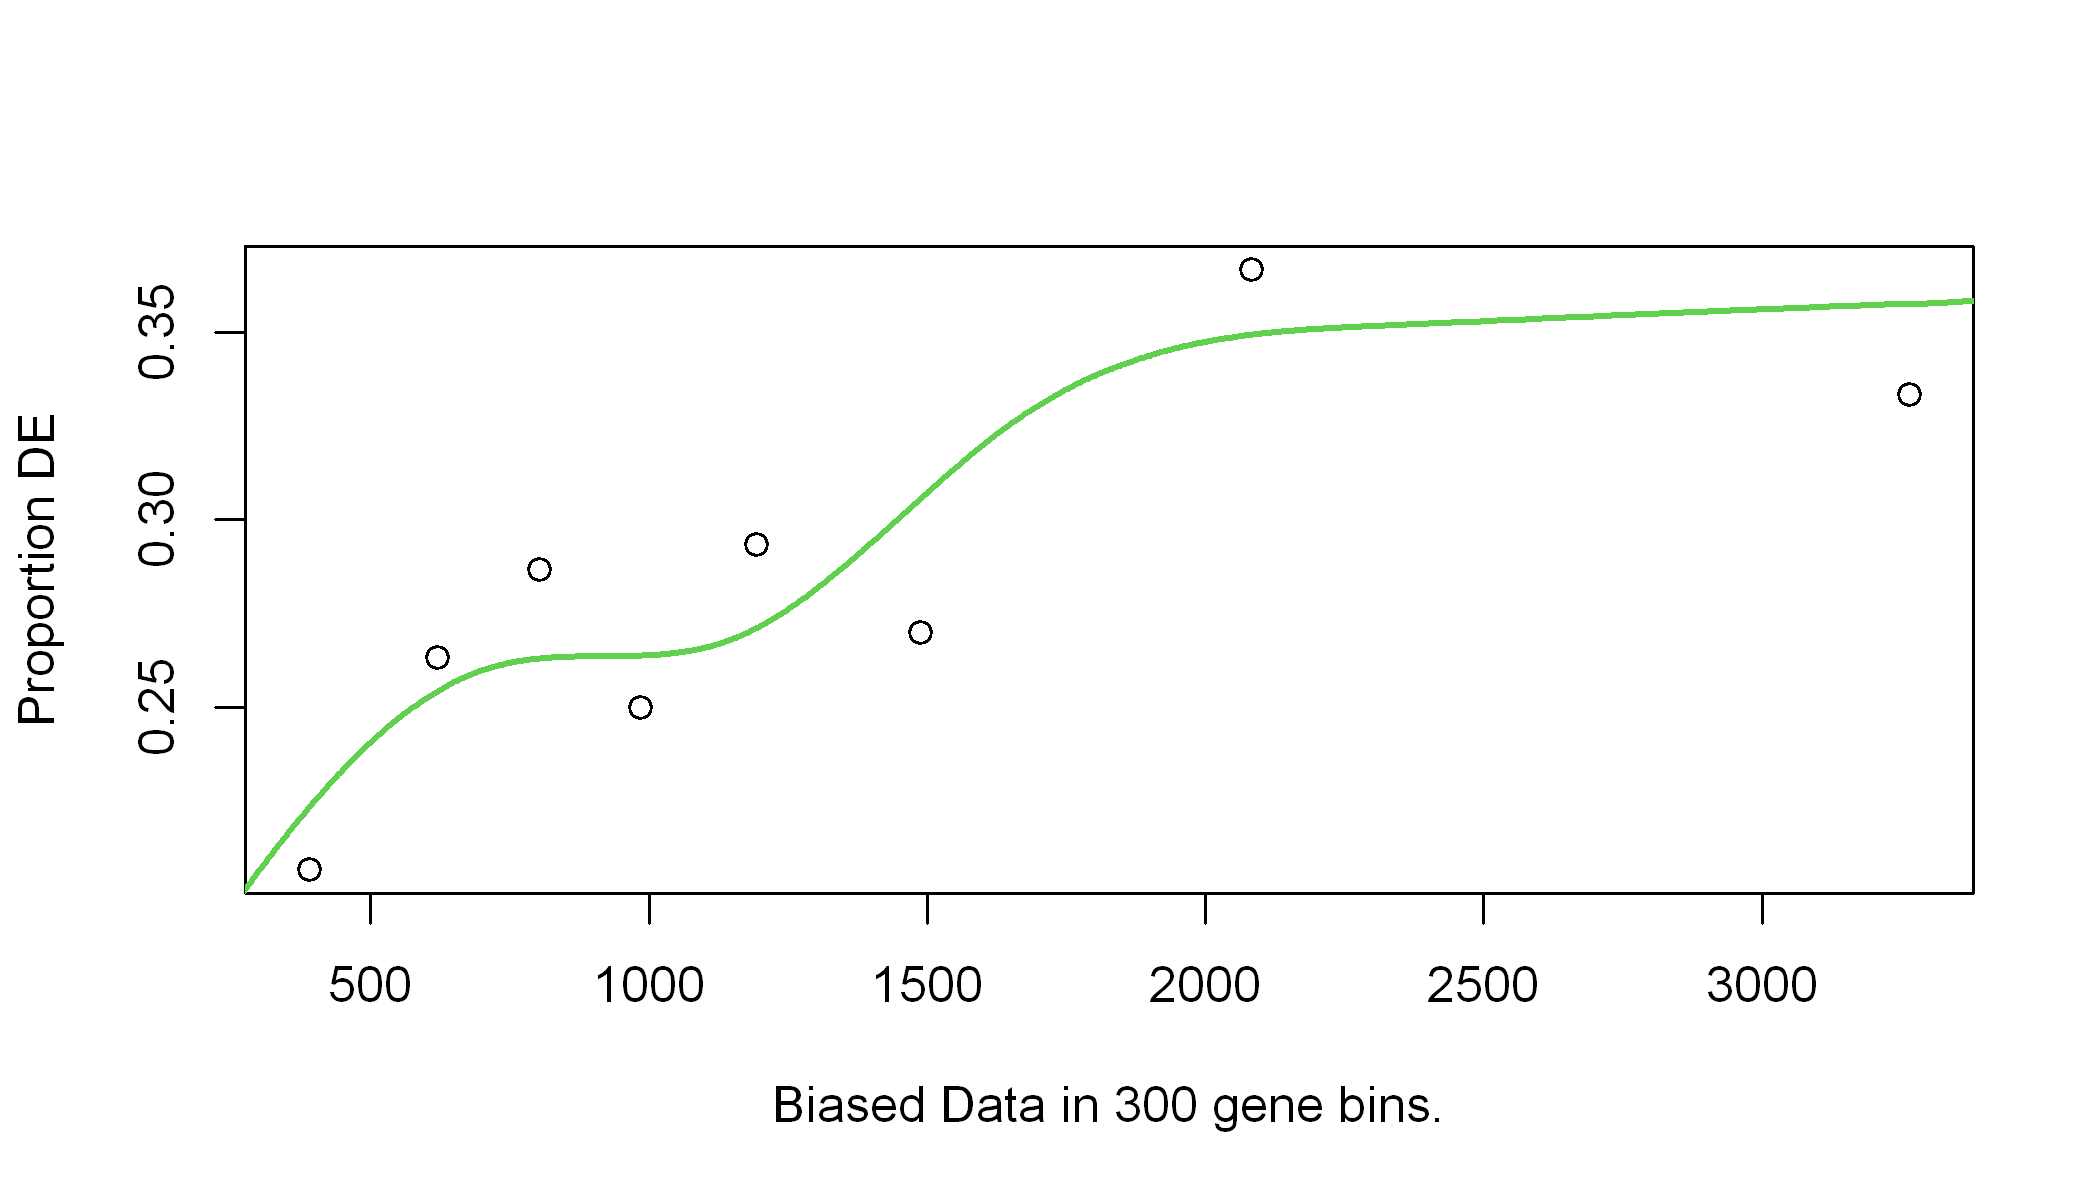

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


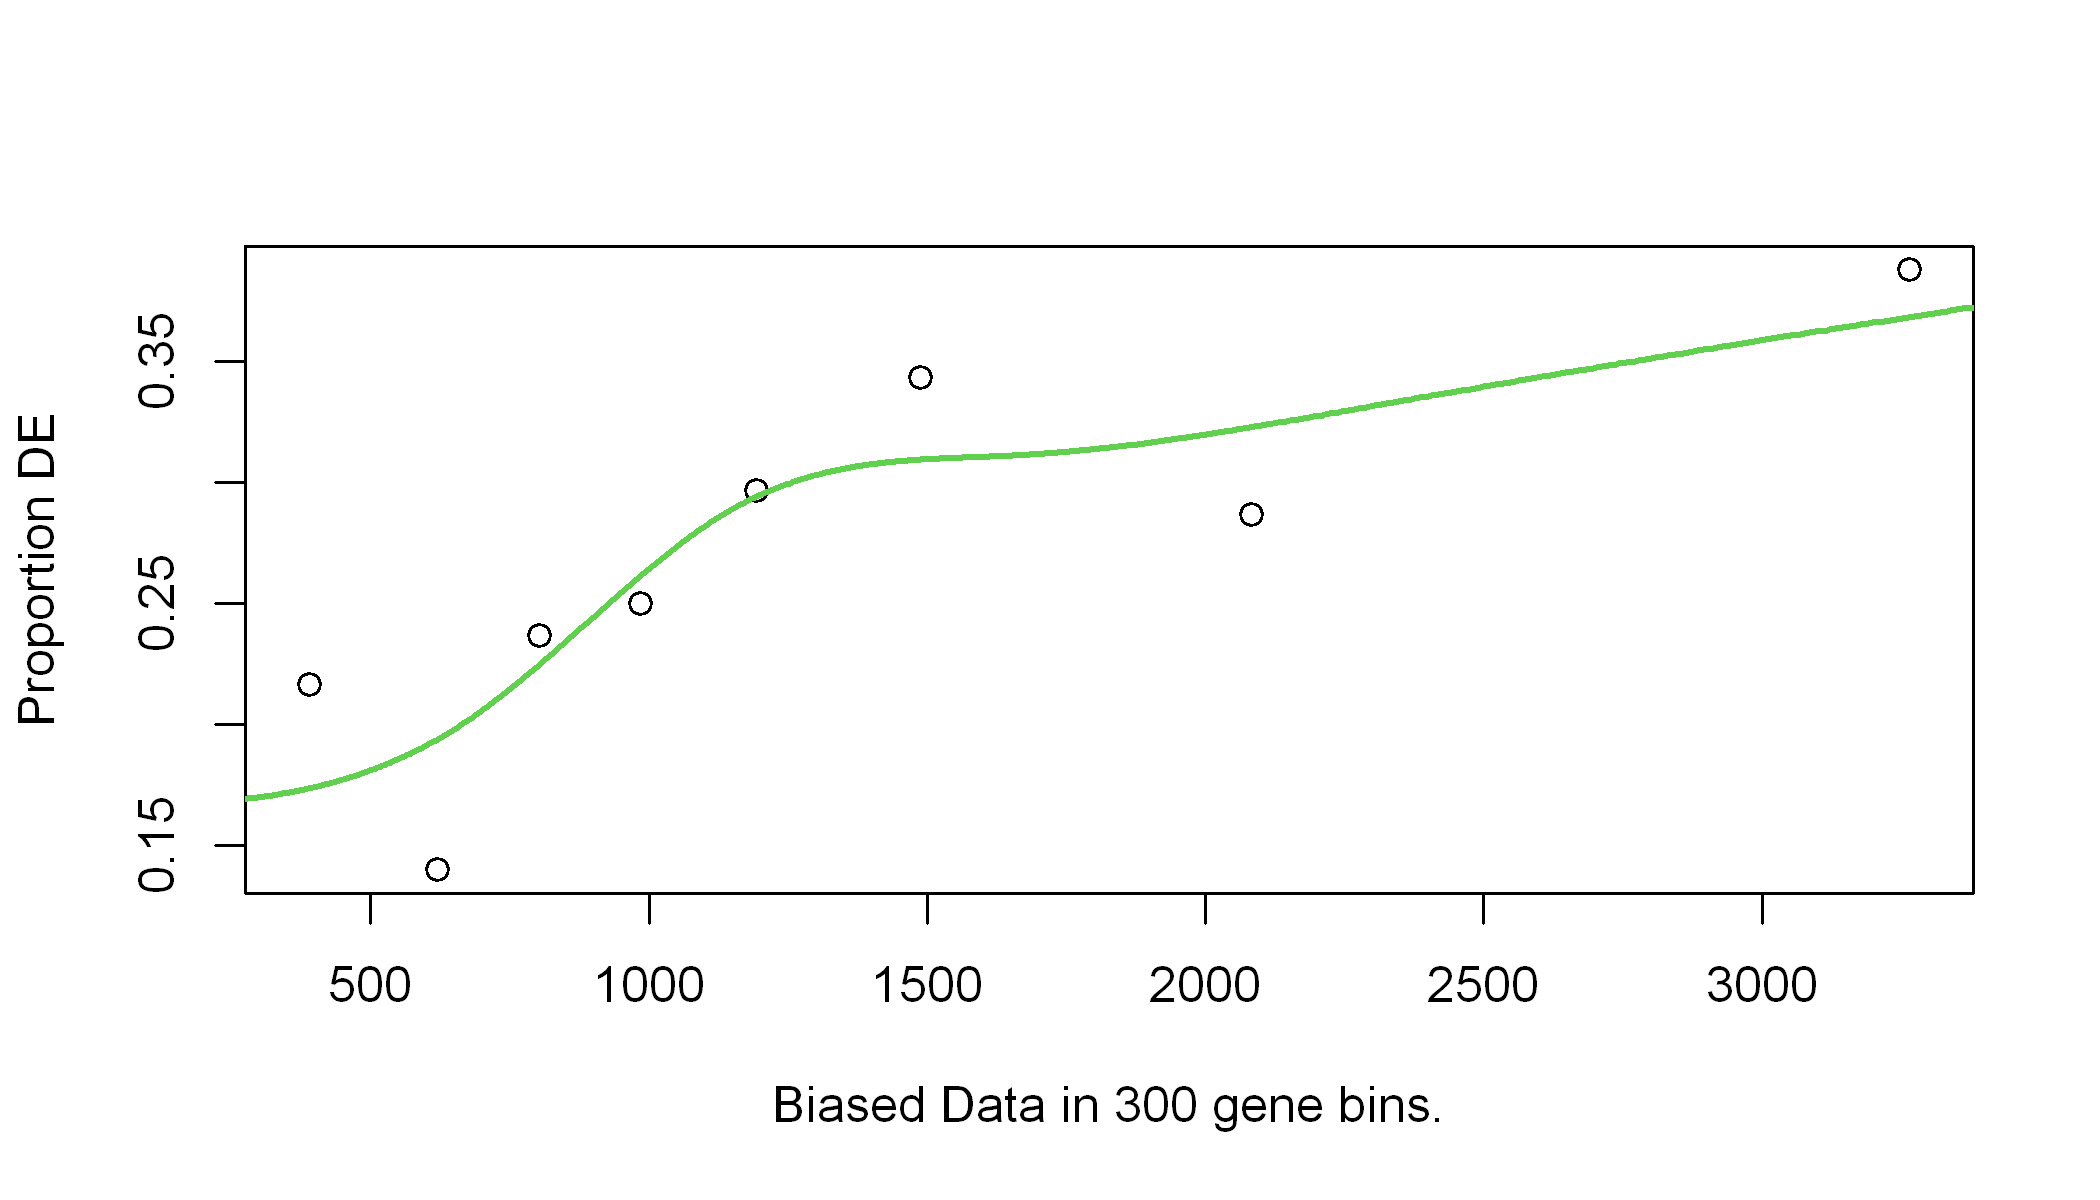

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


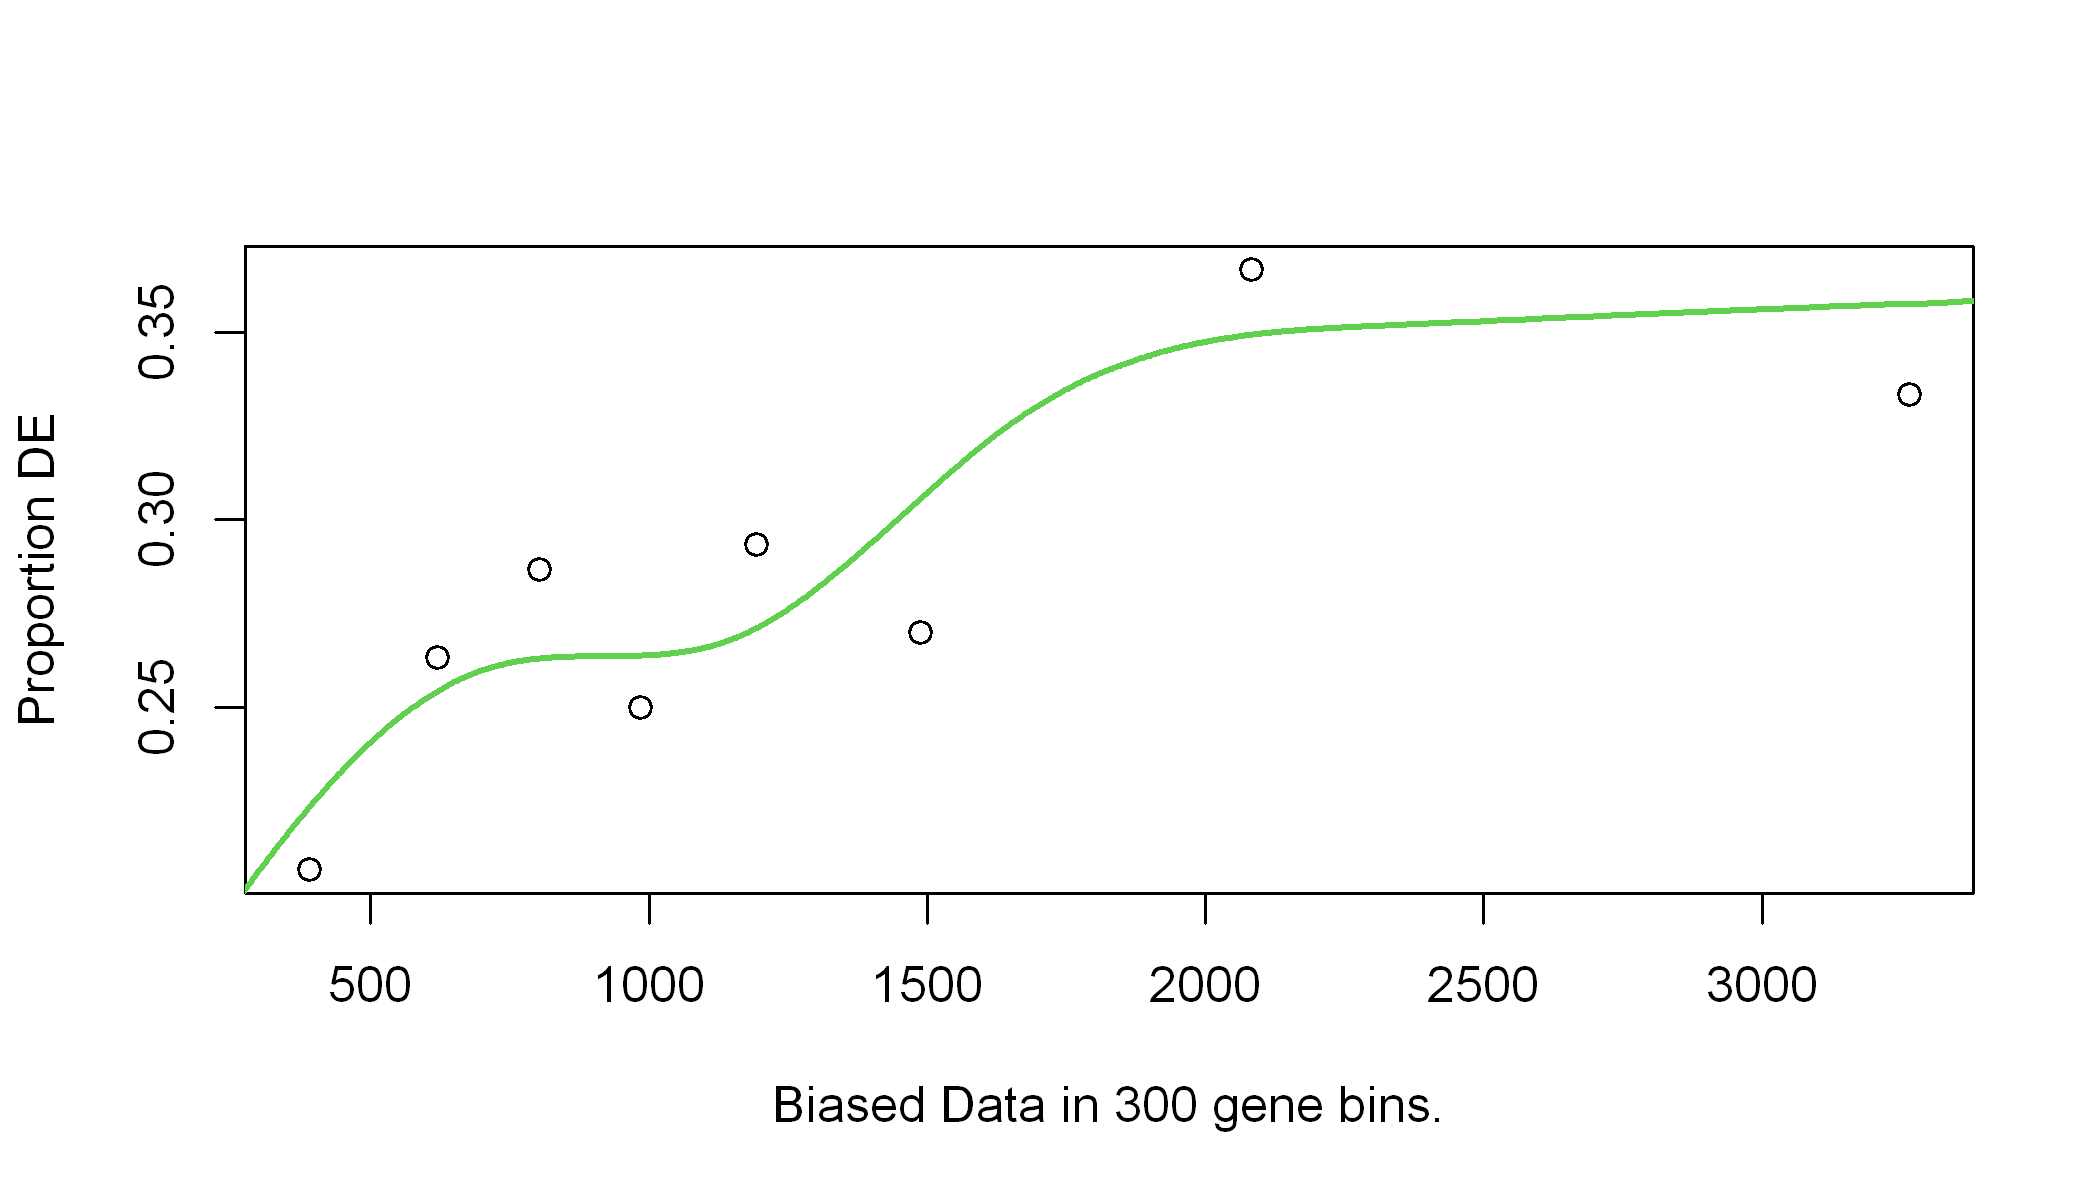

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


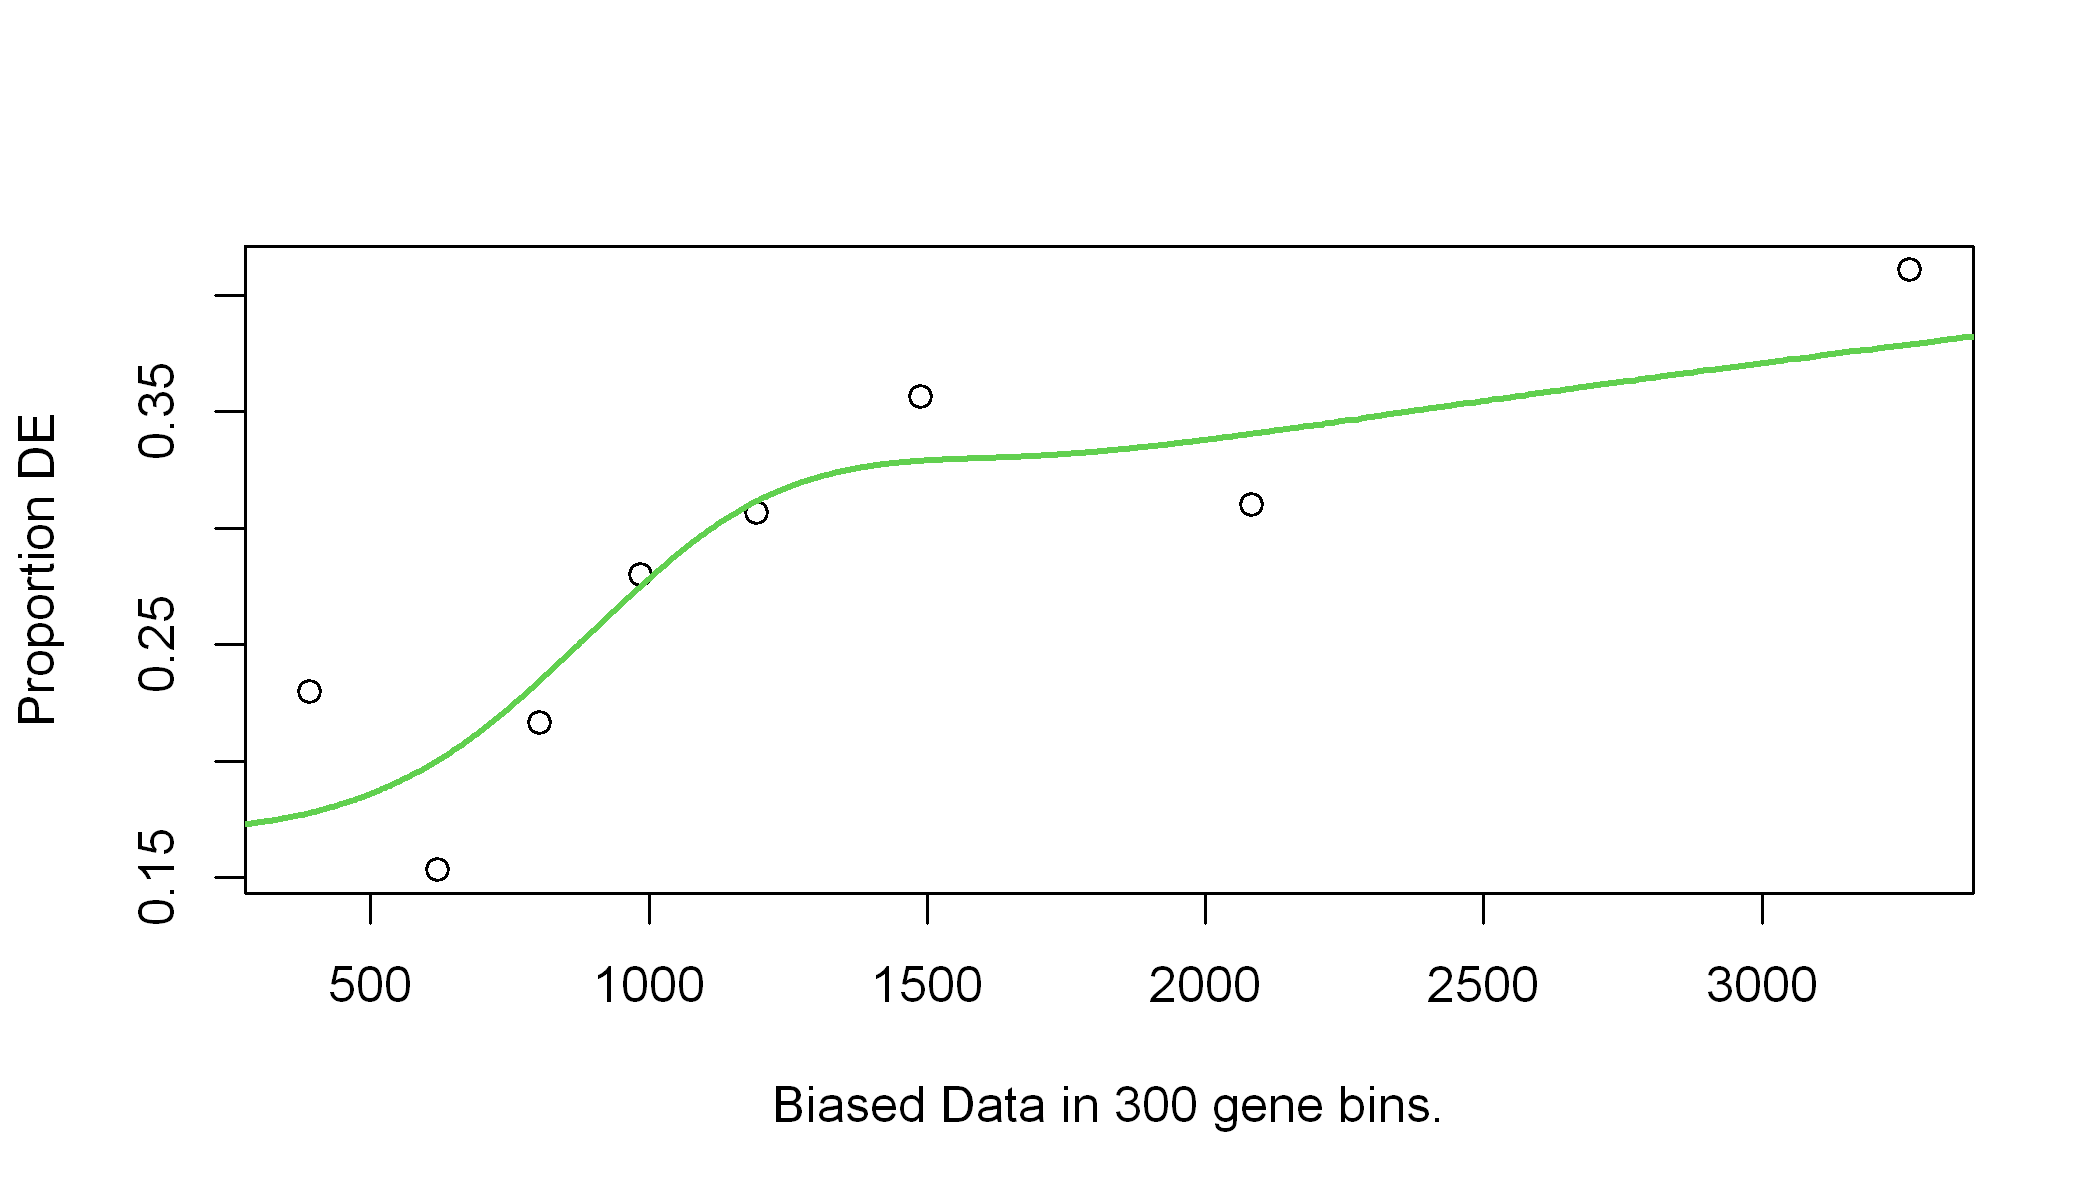

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


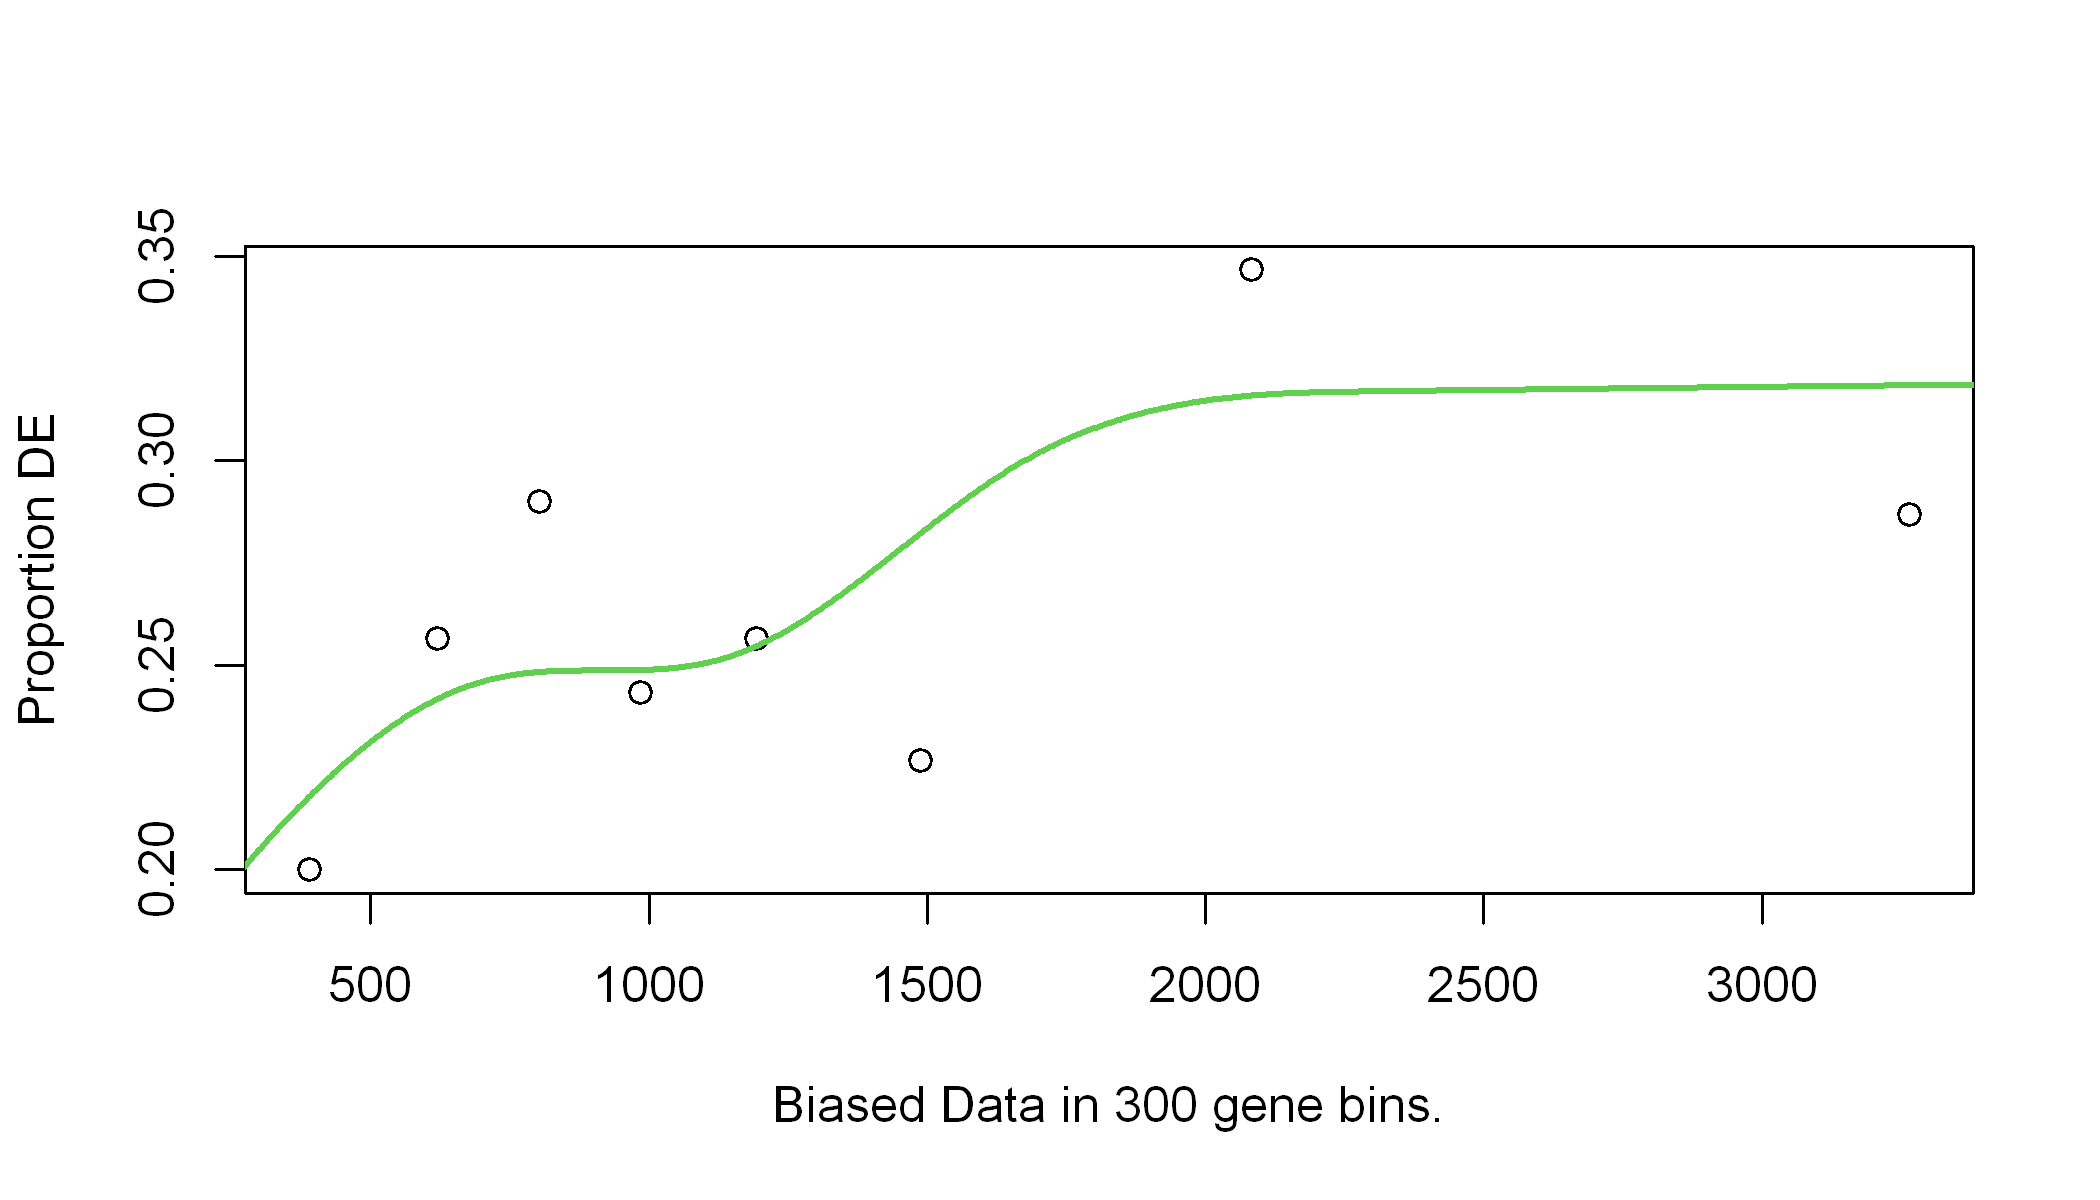

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


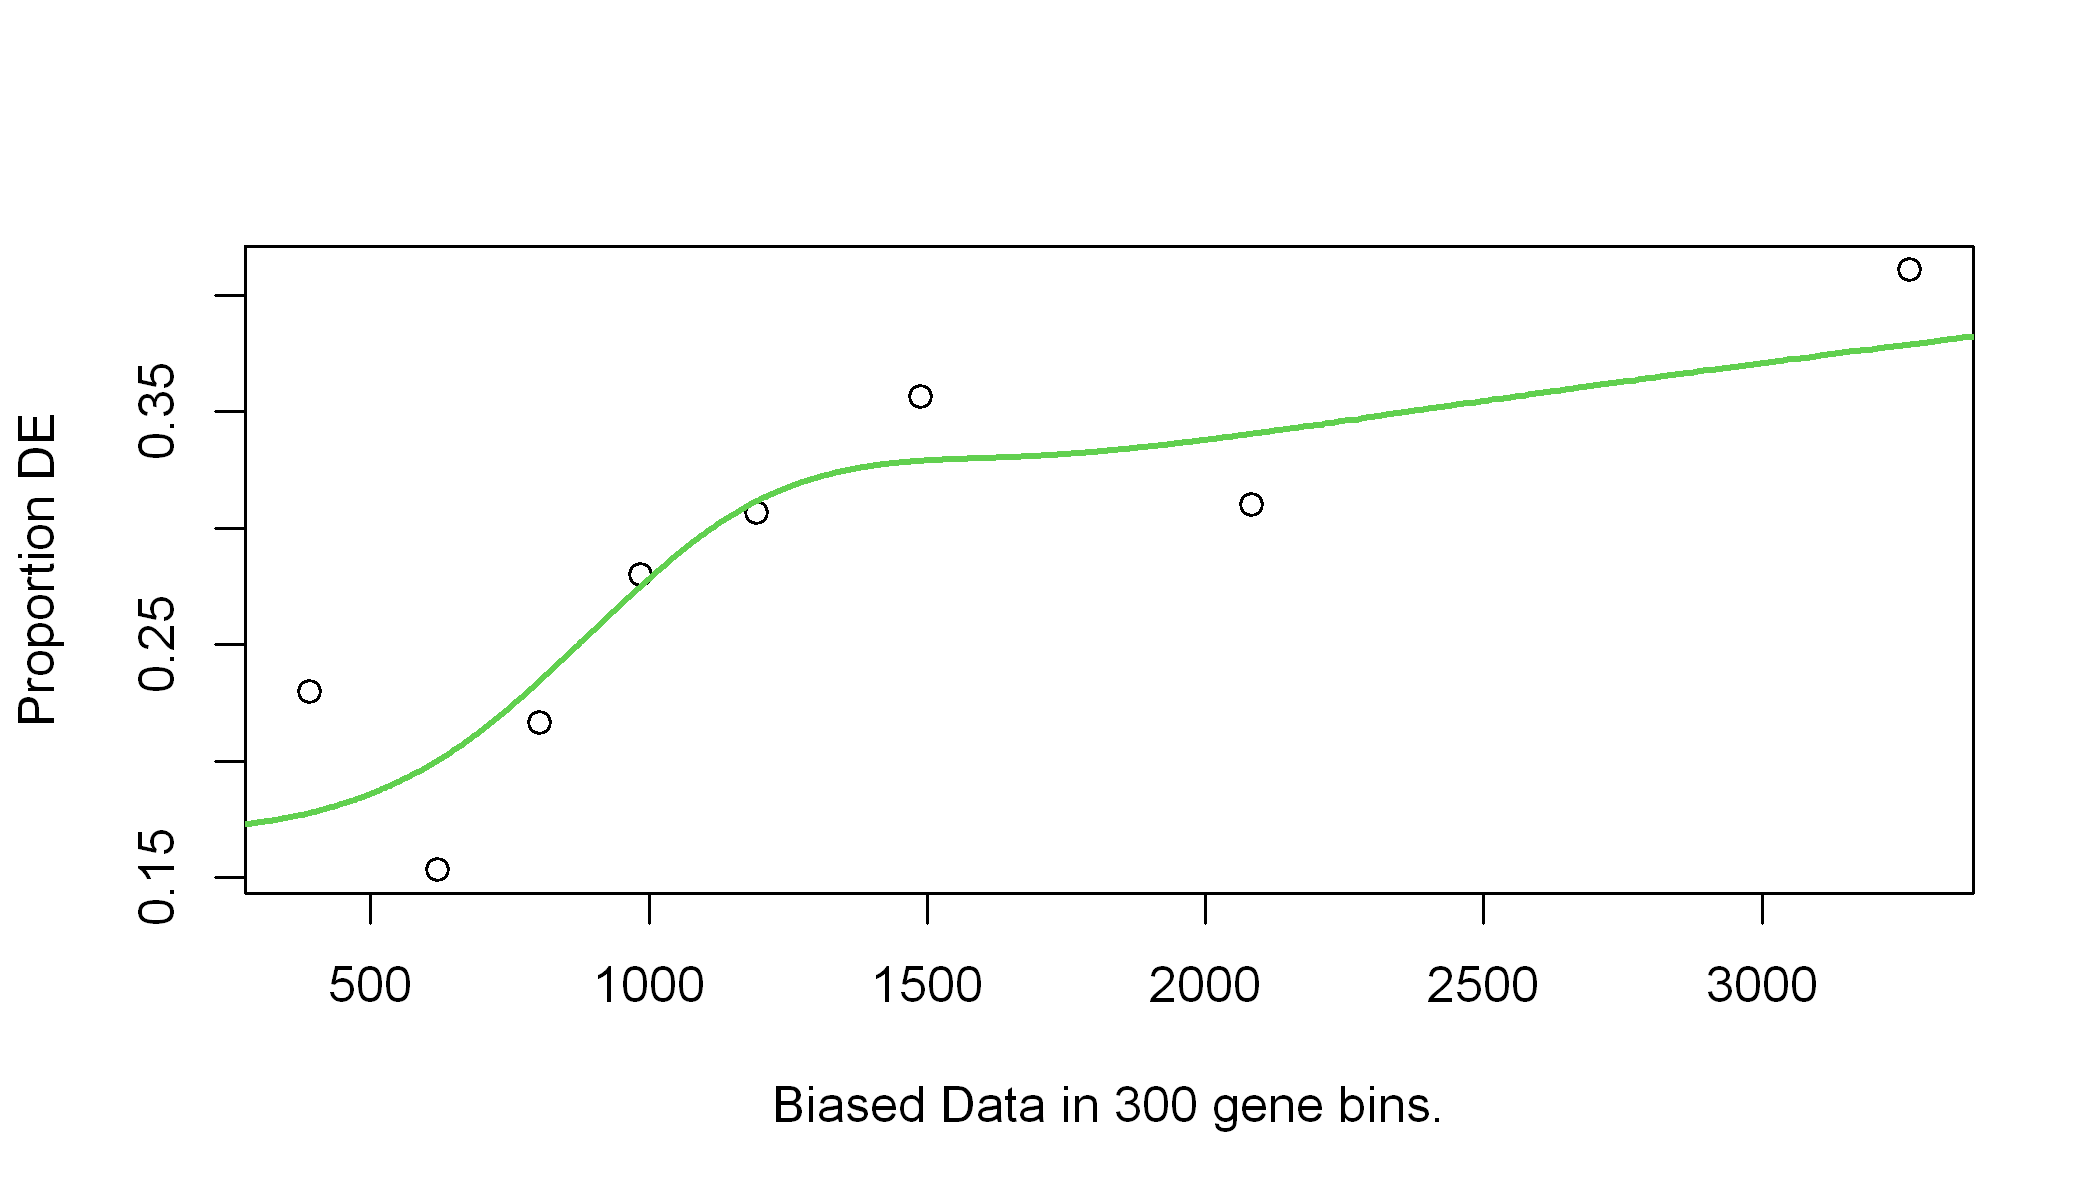

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


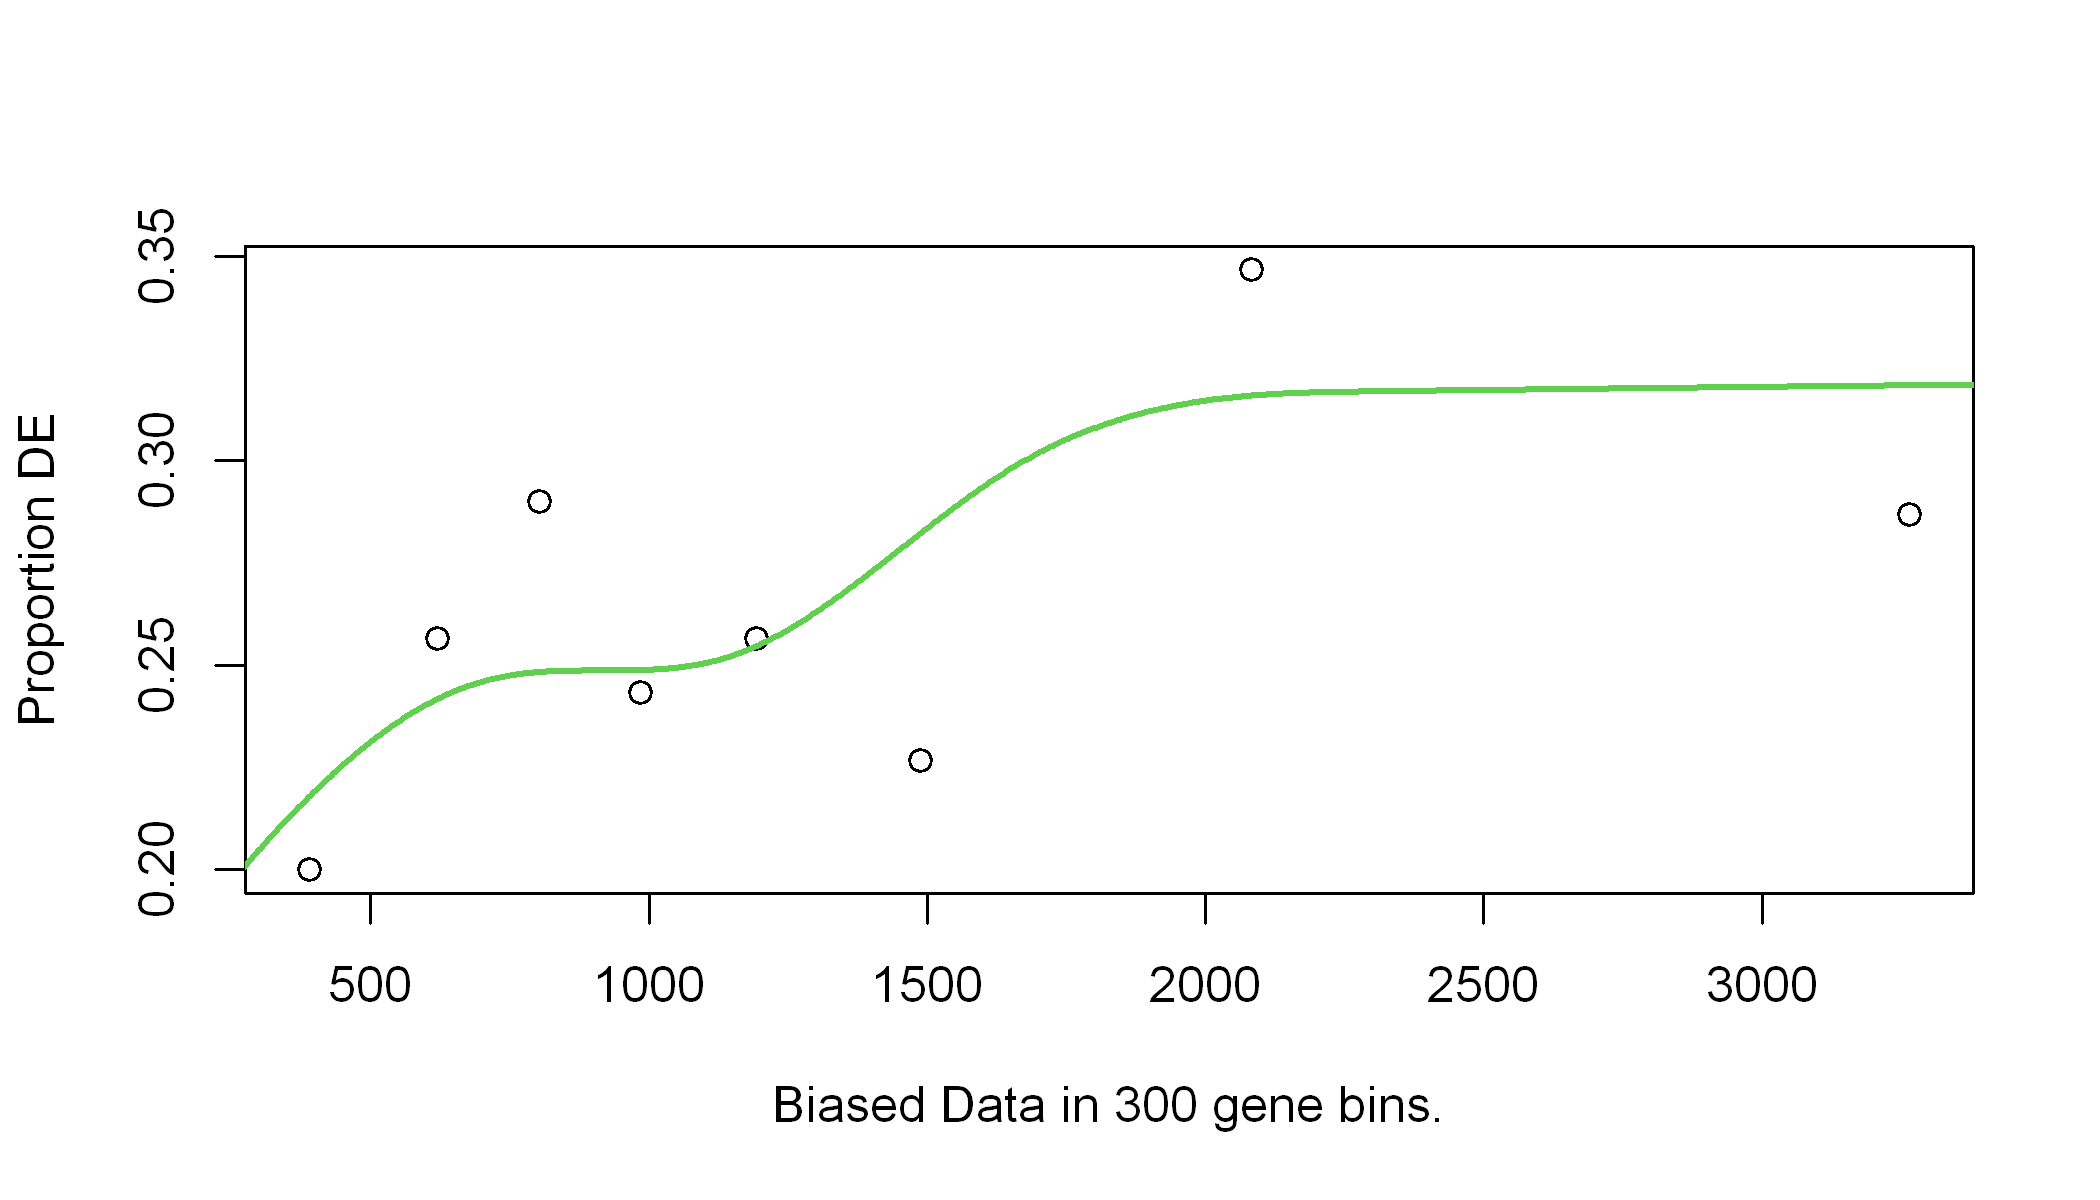

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


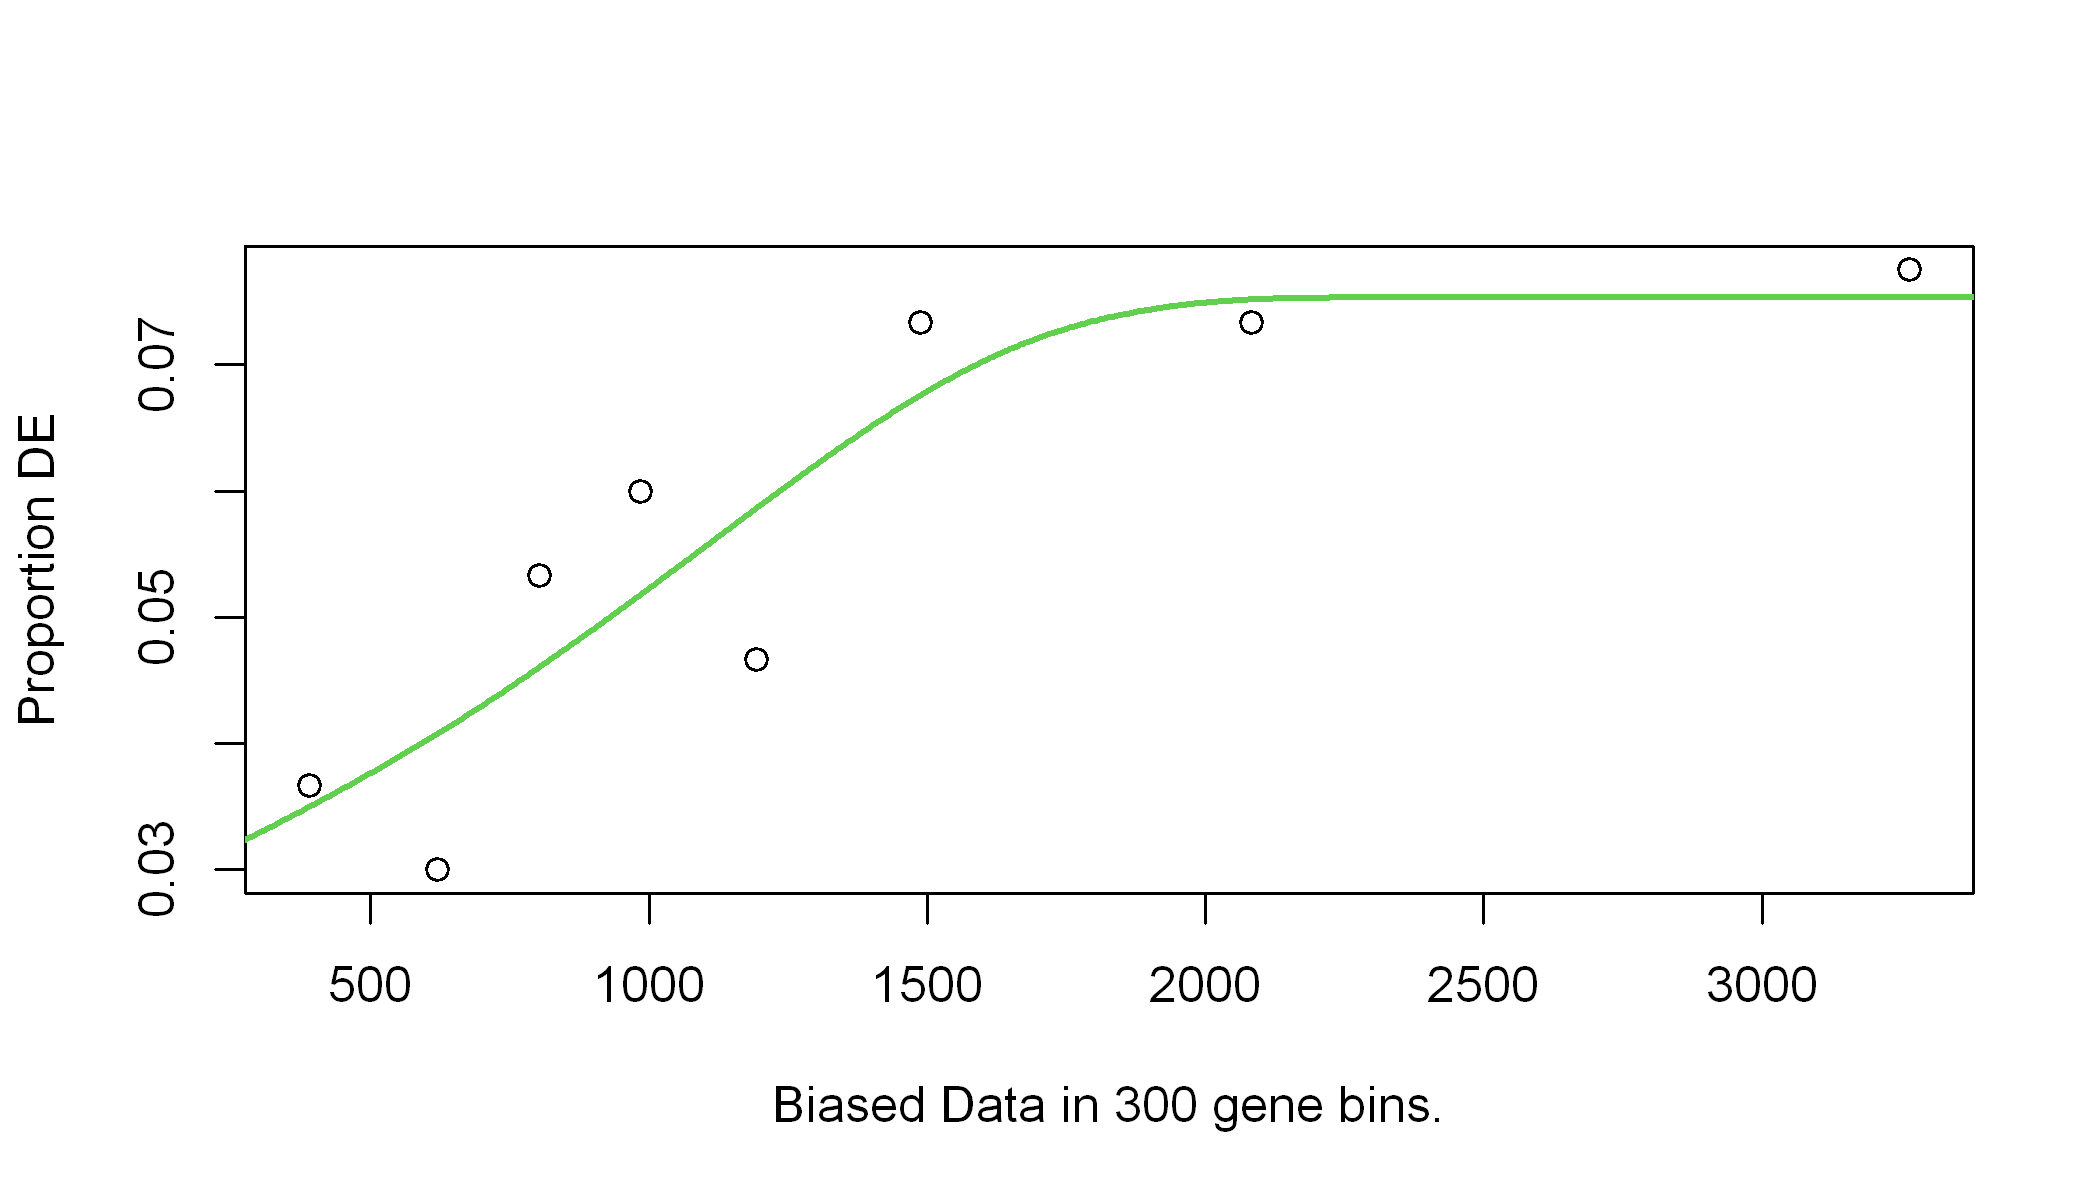

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


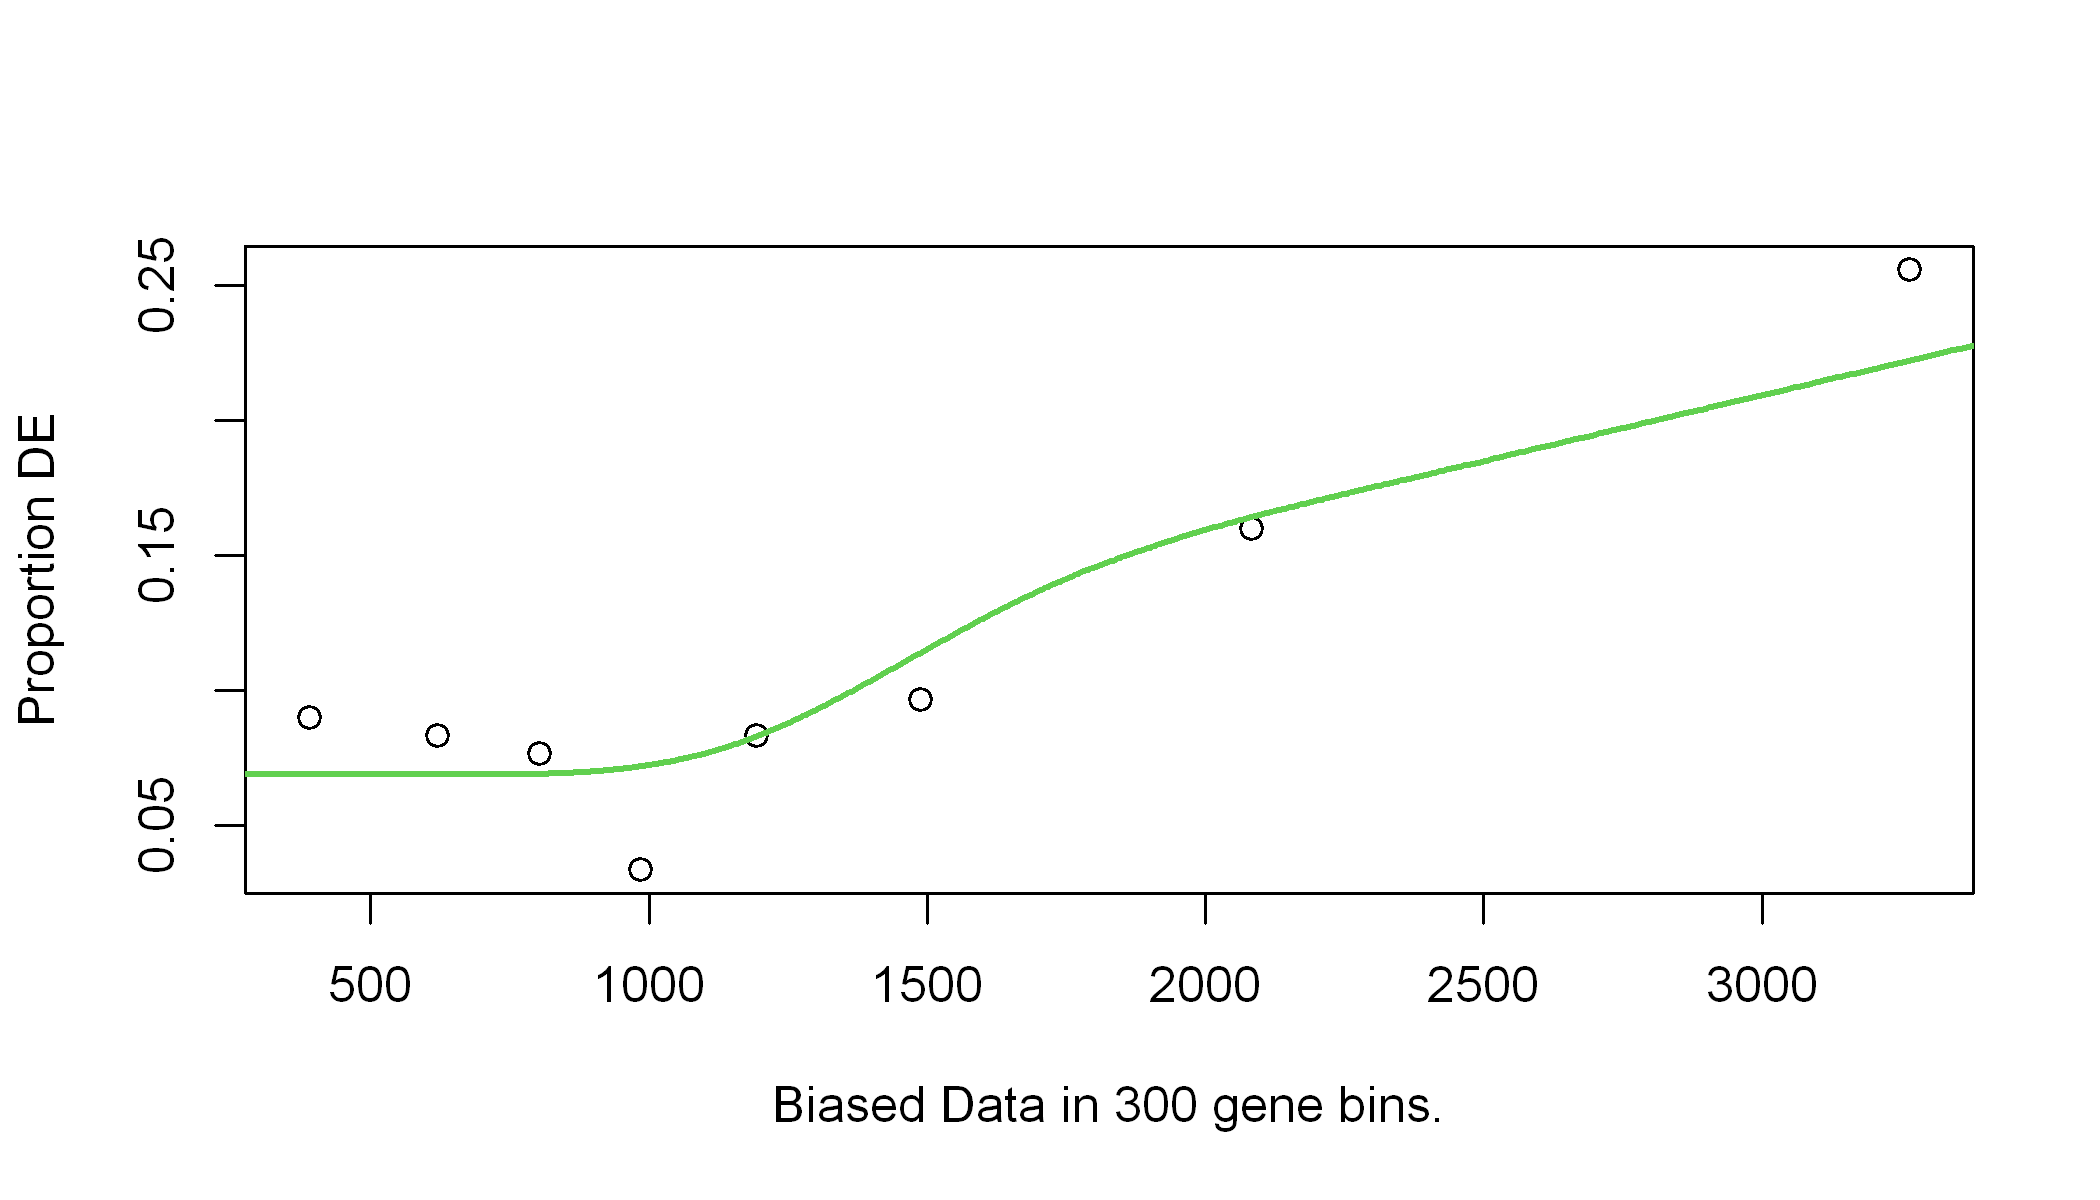

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


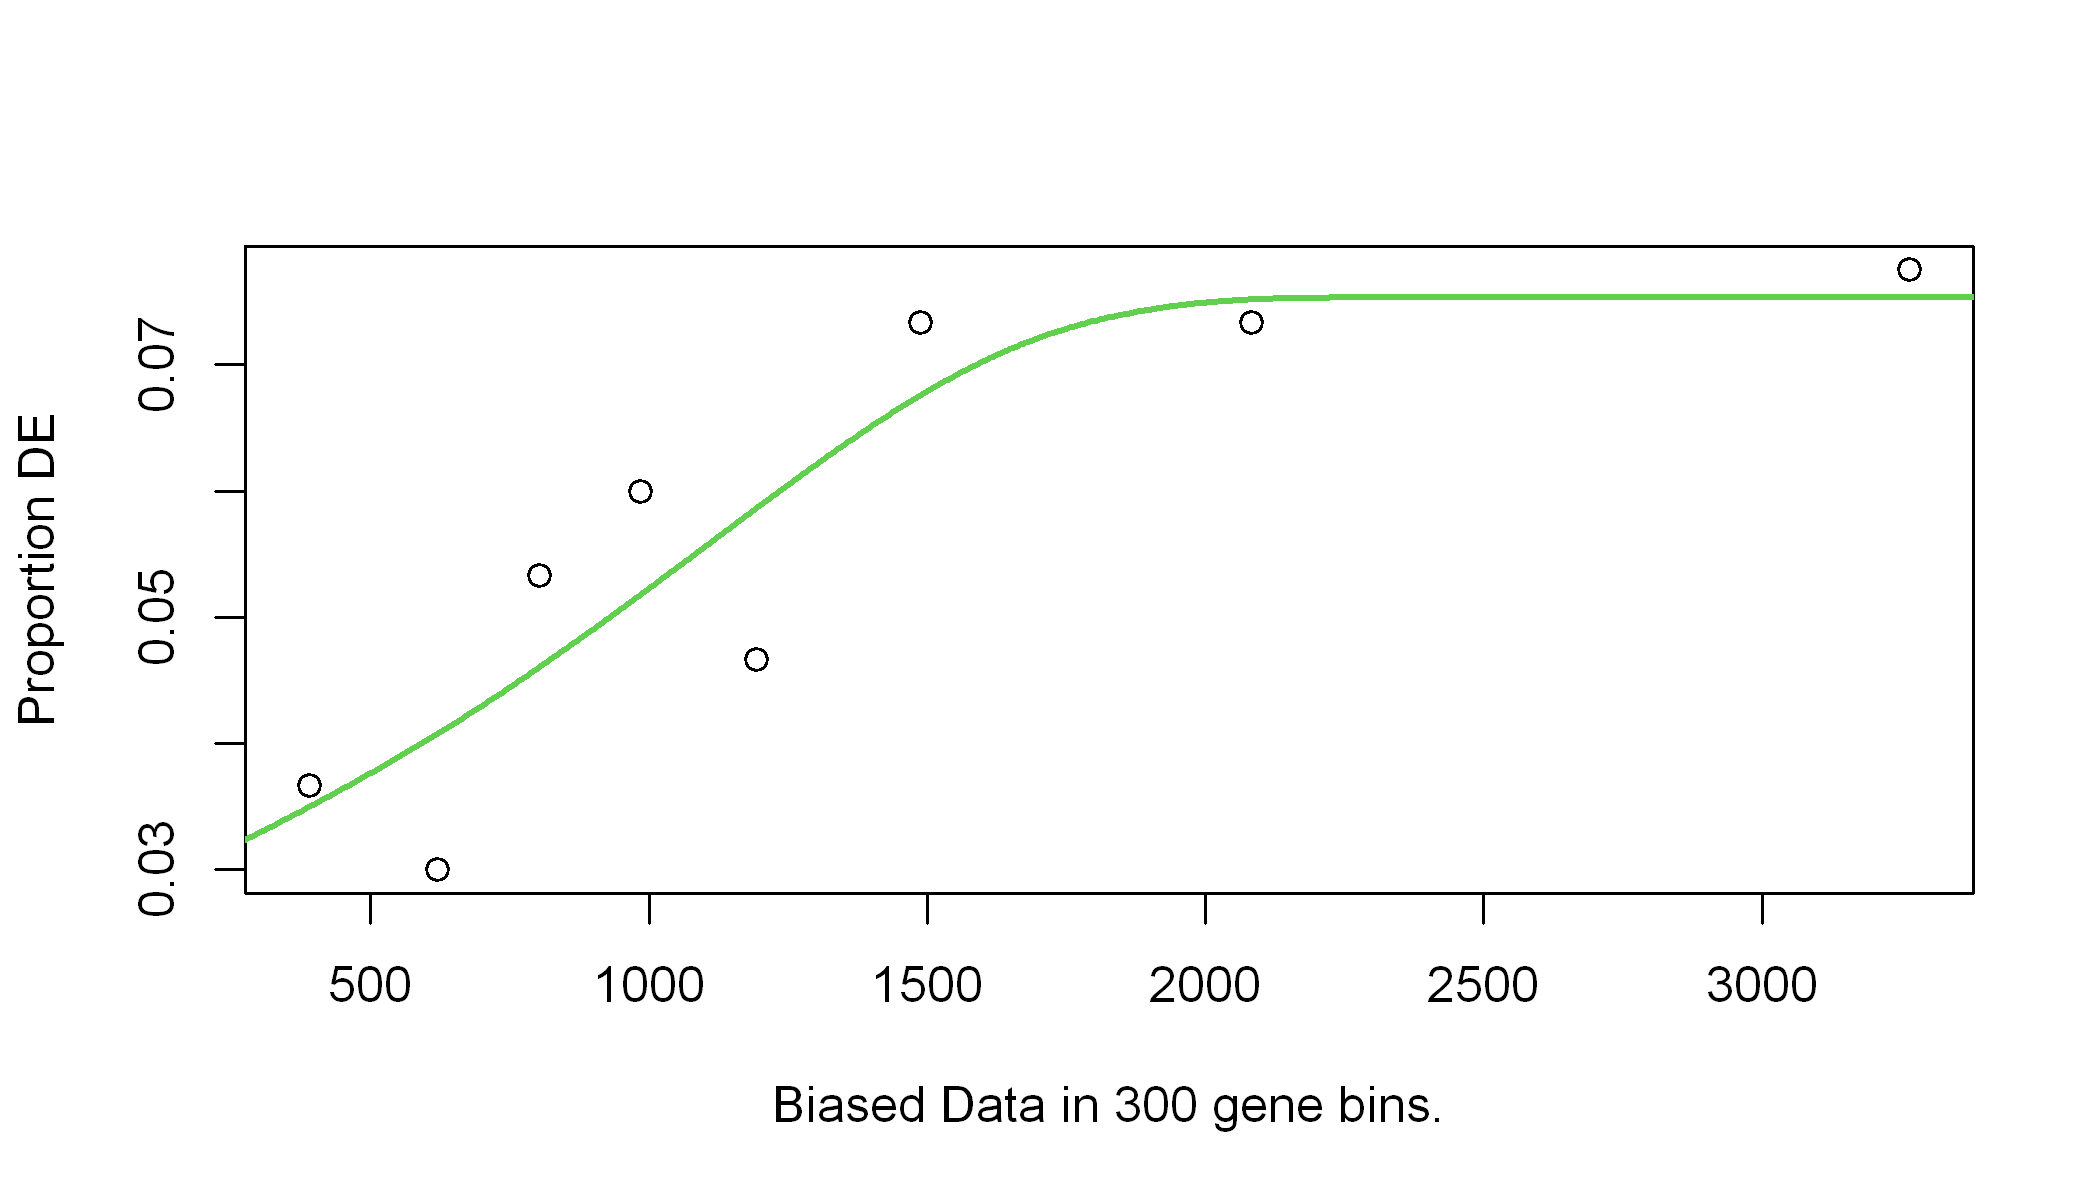

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


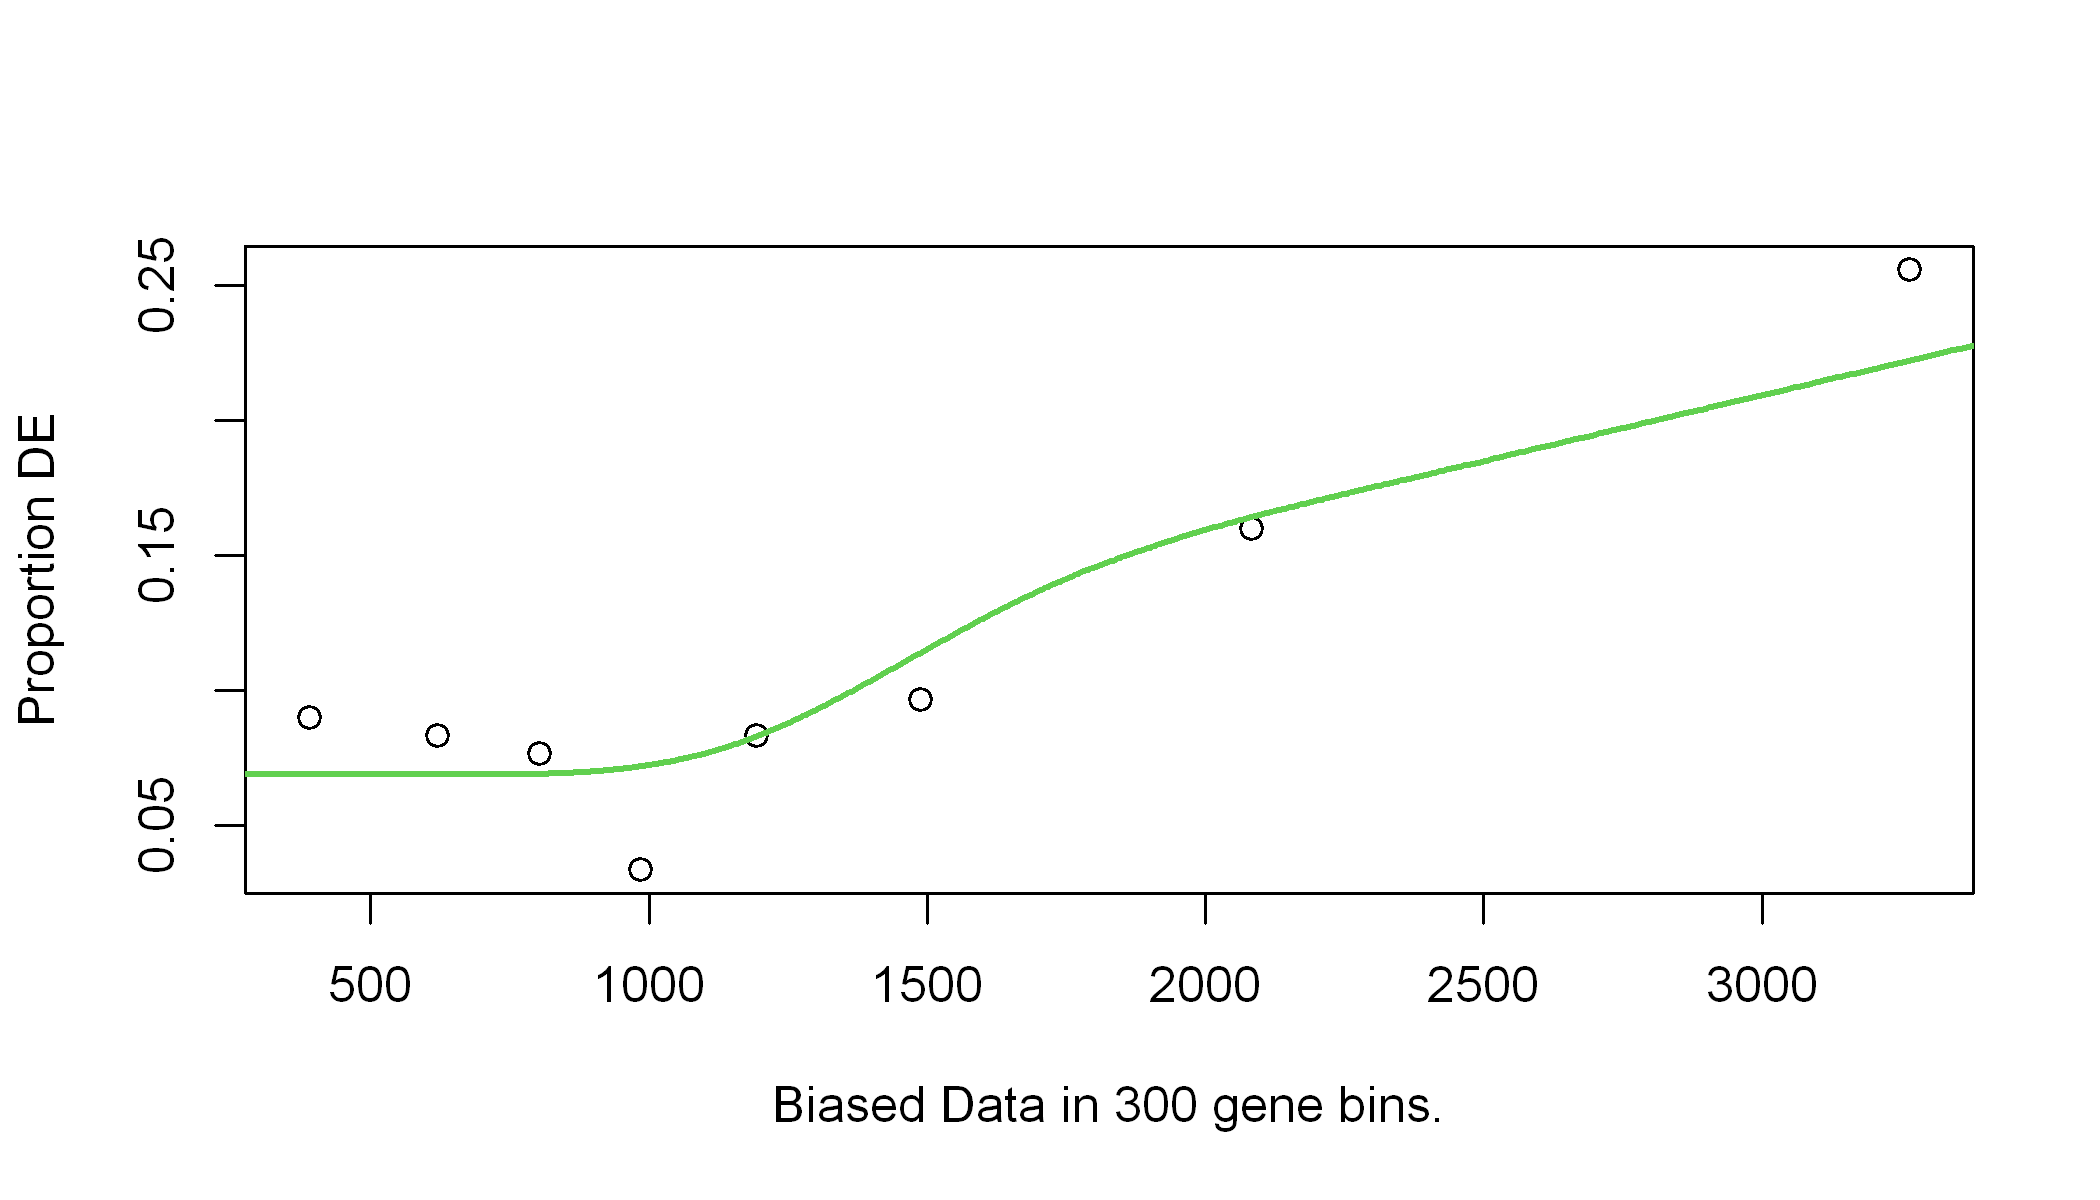

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


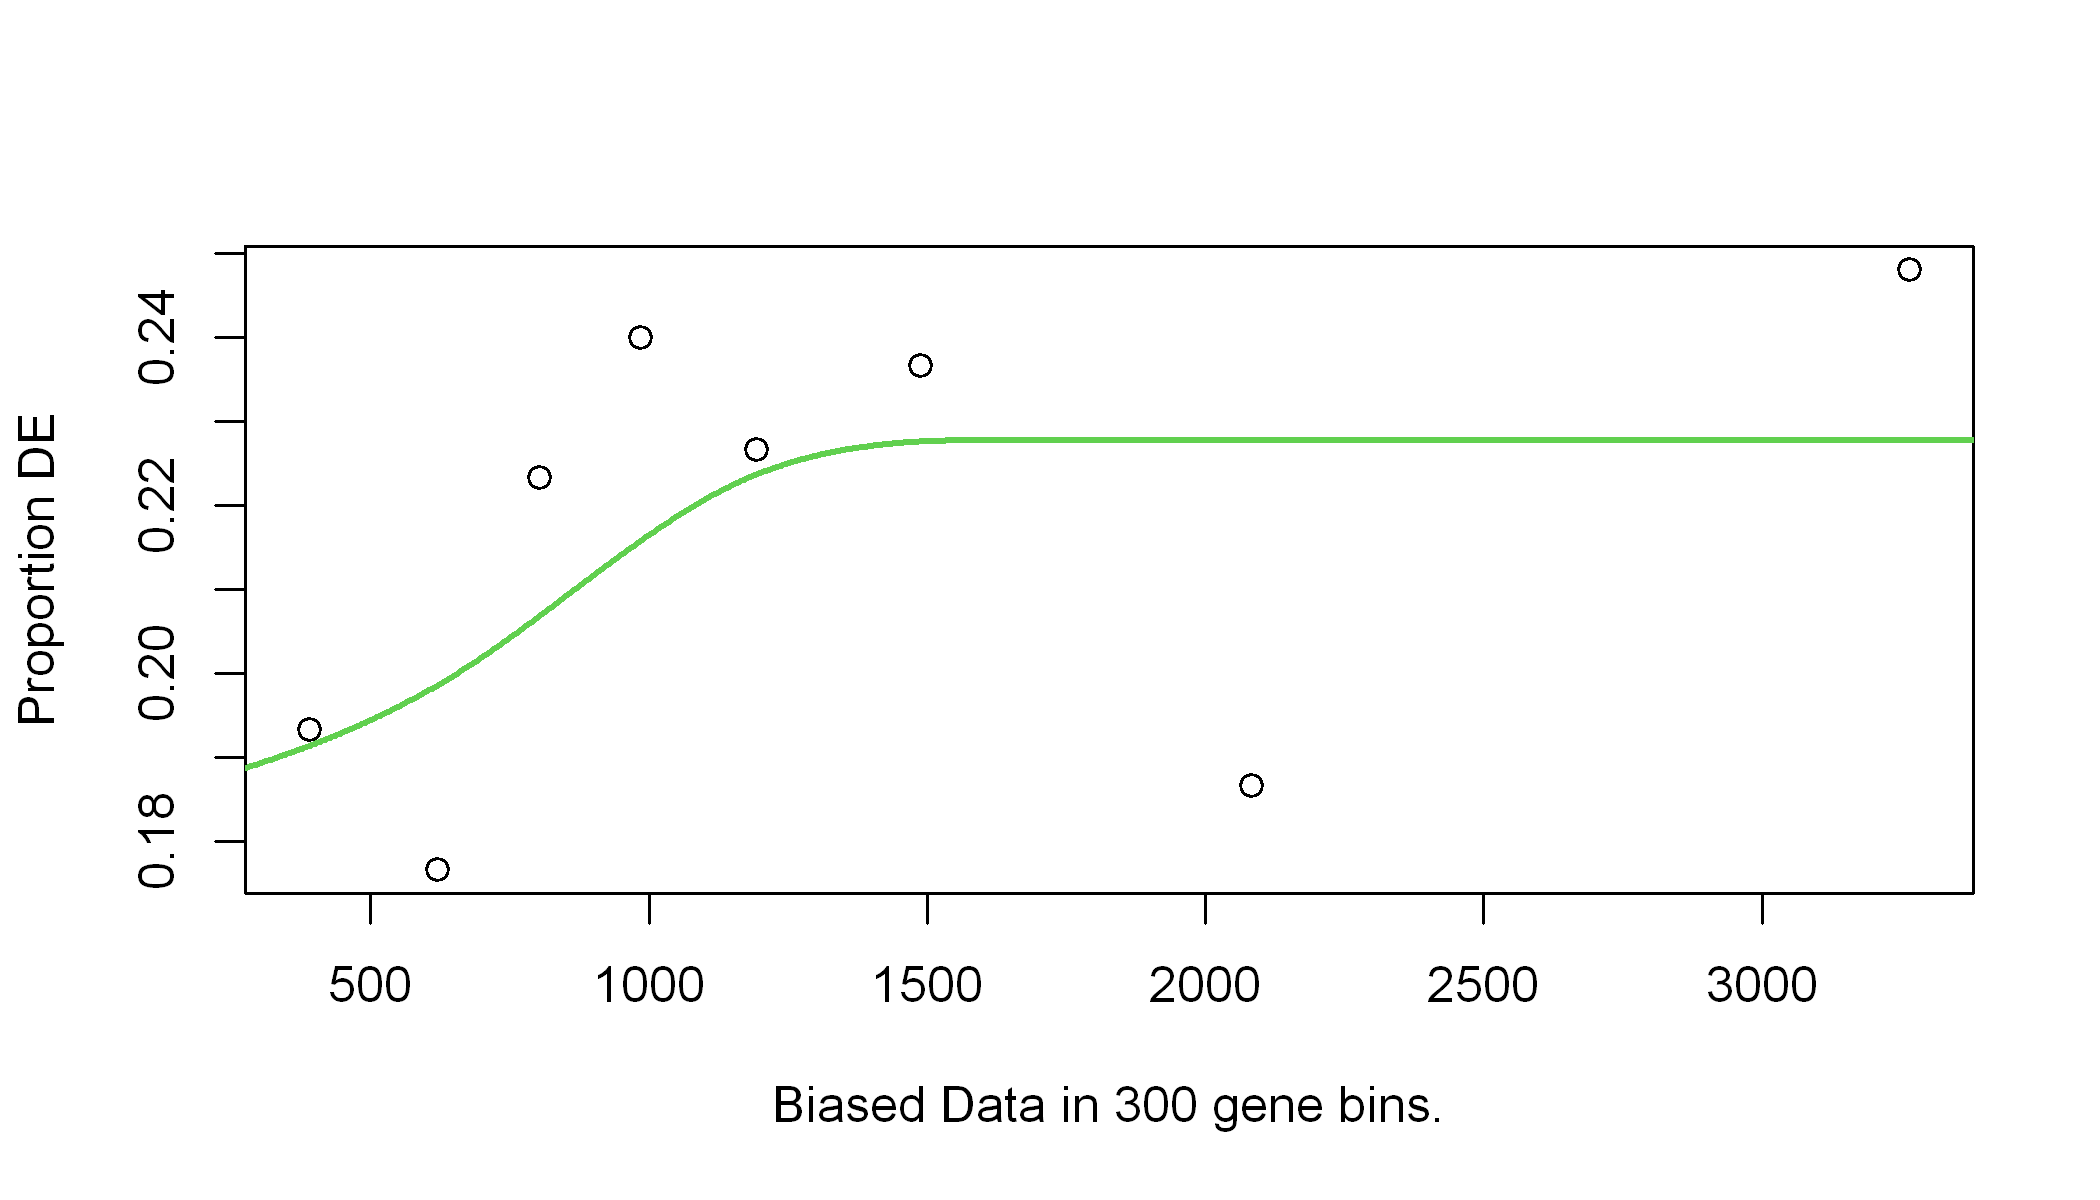

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


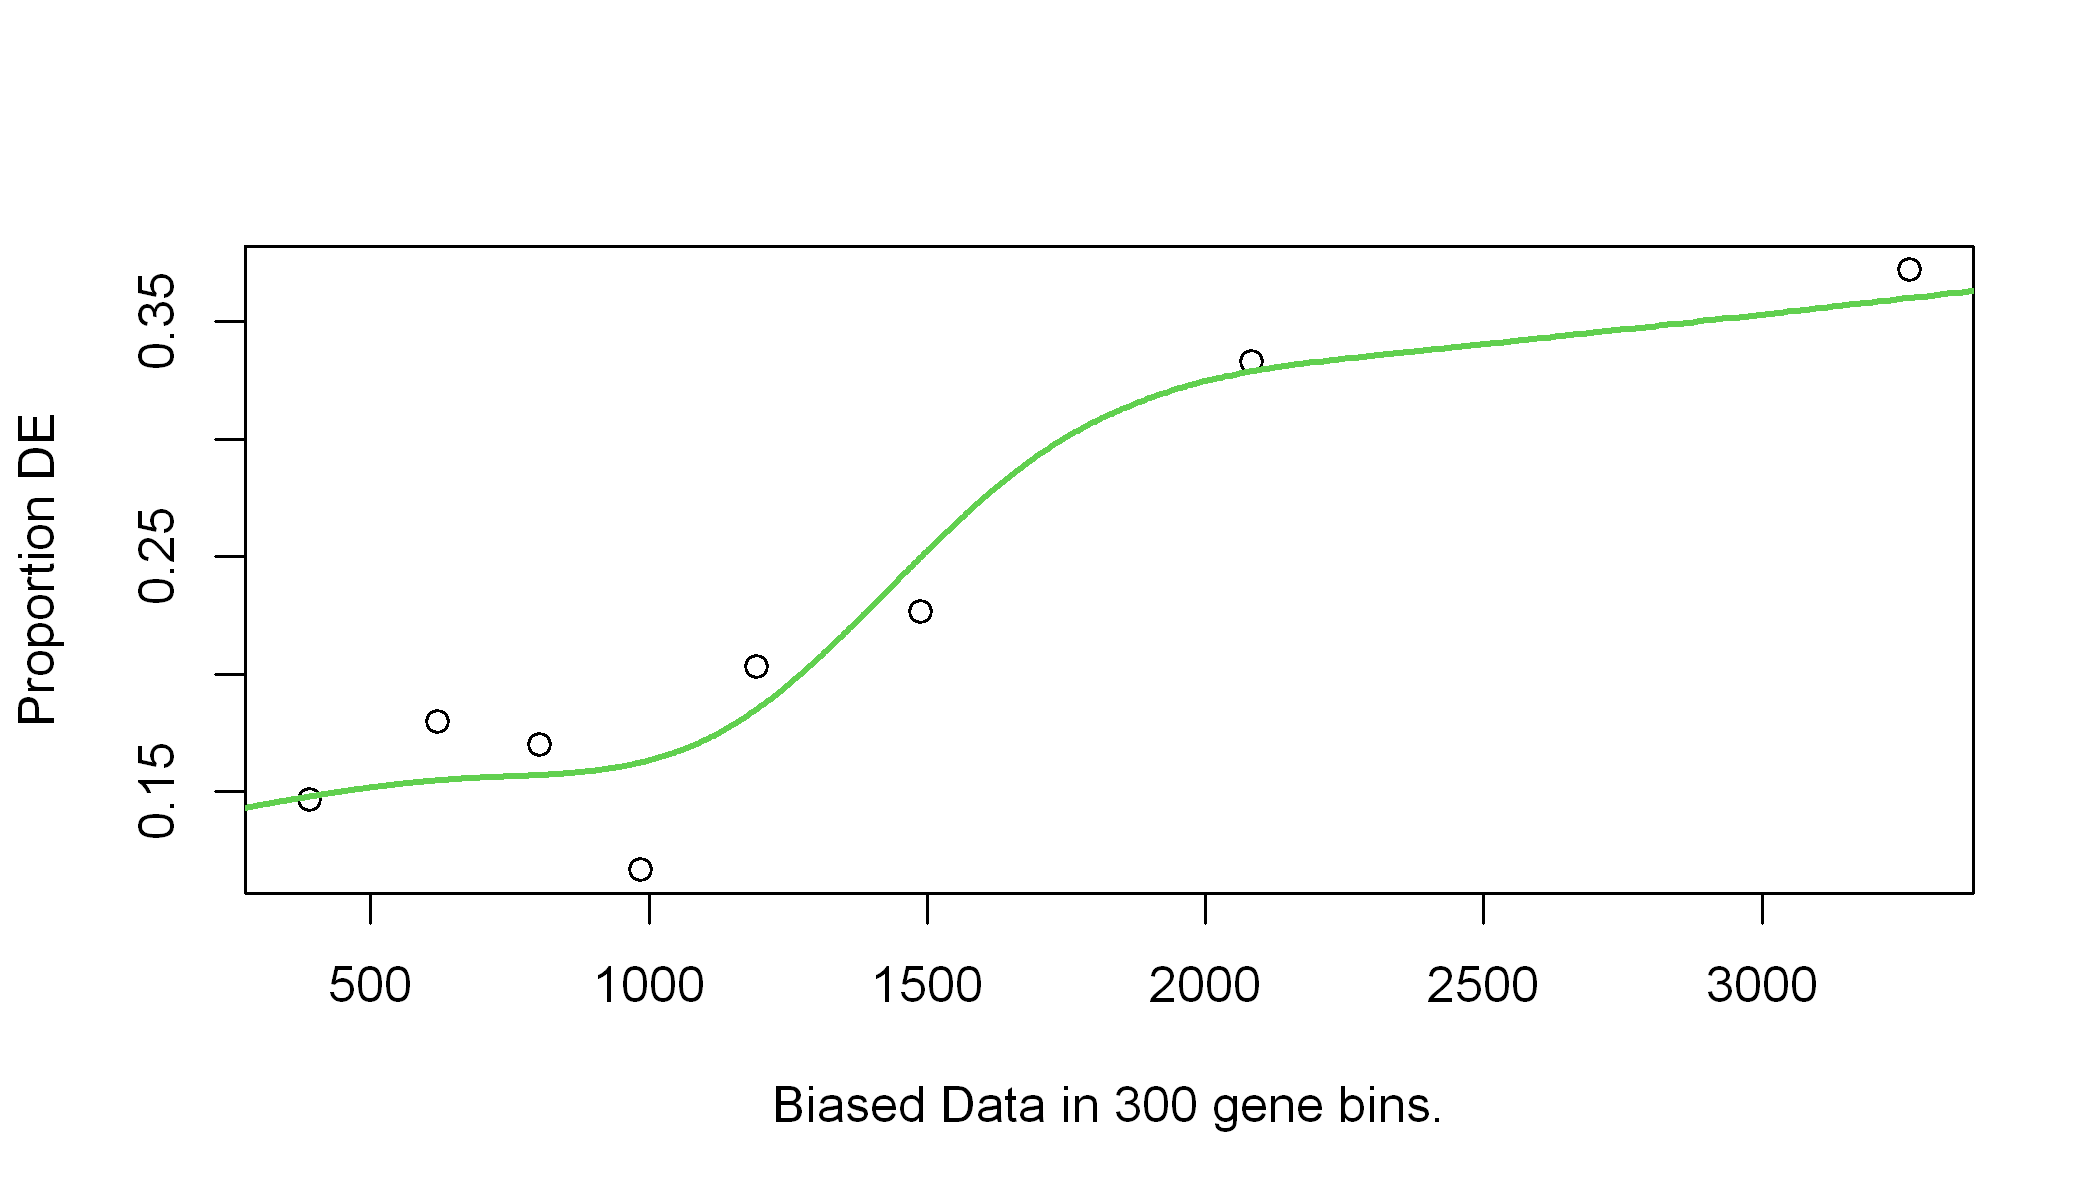

Using manually entered categories.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


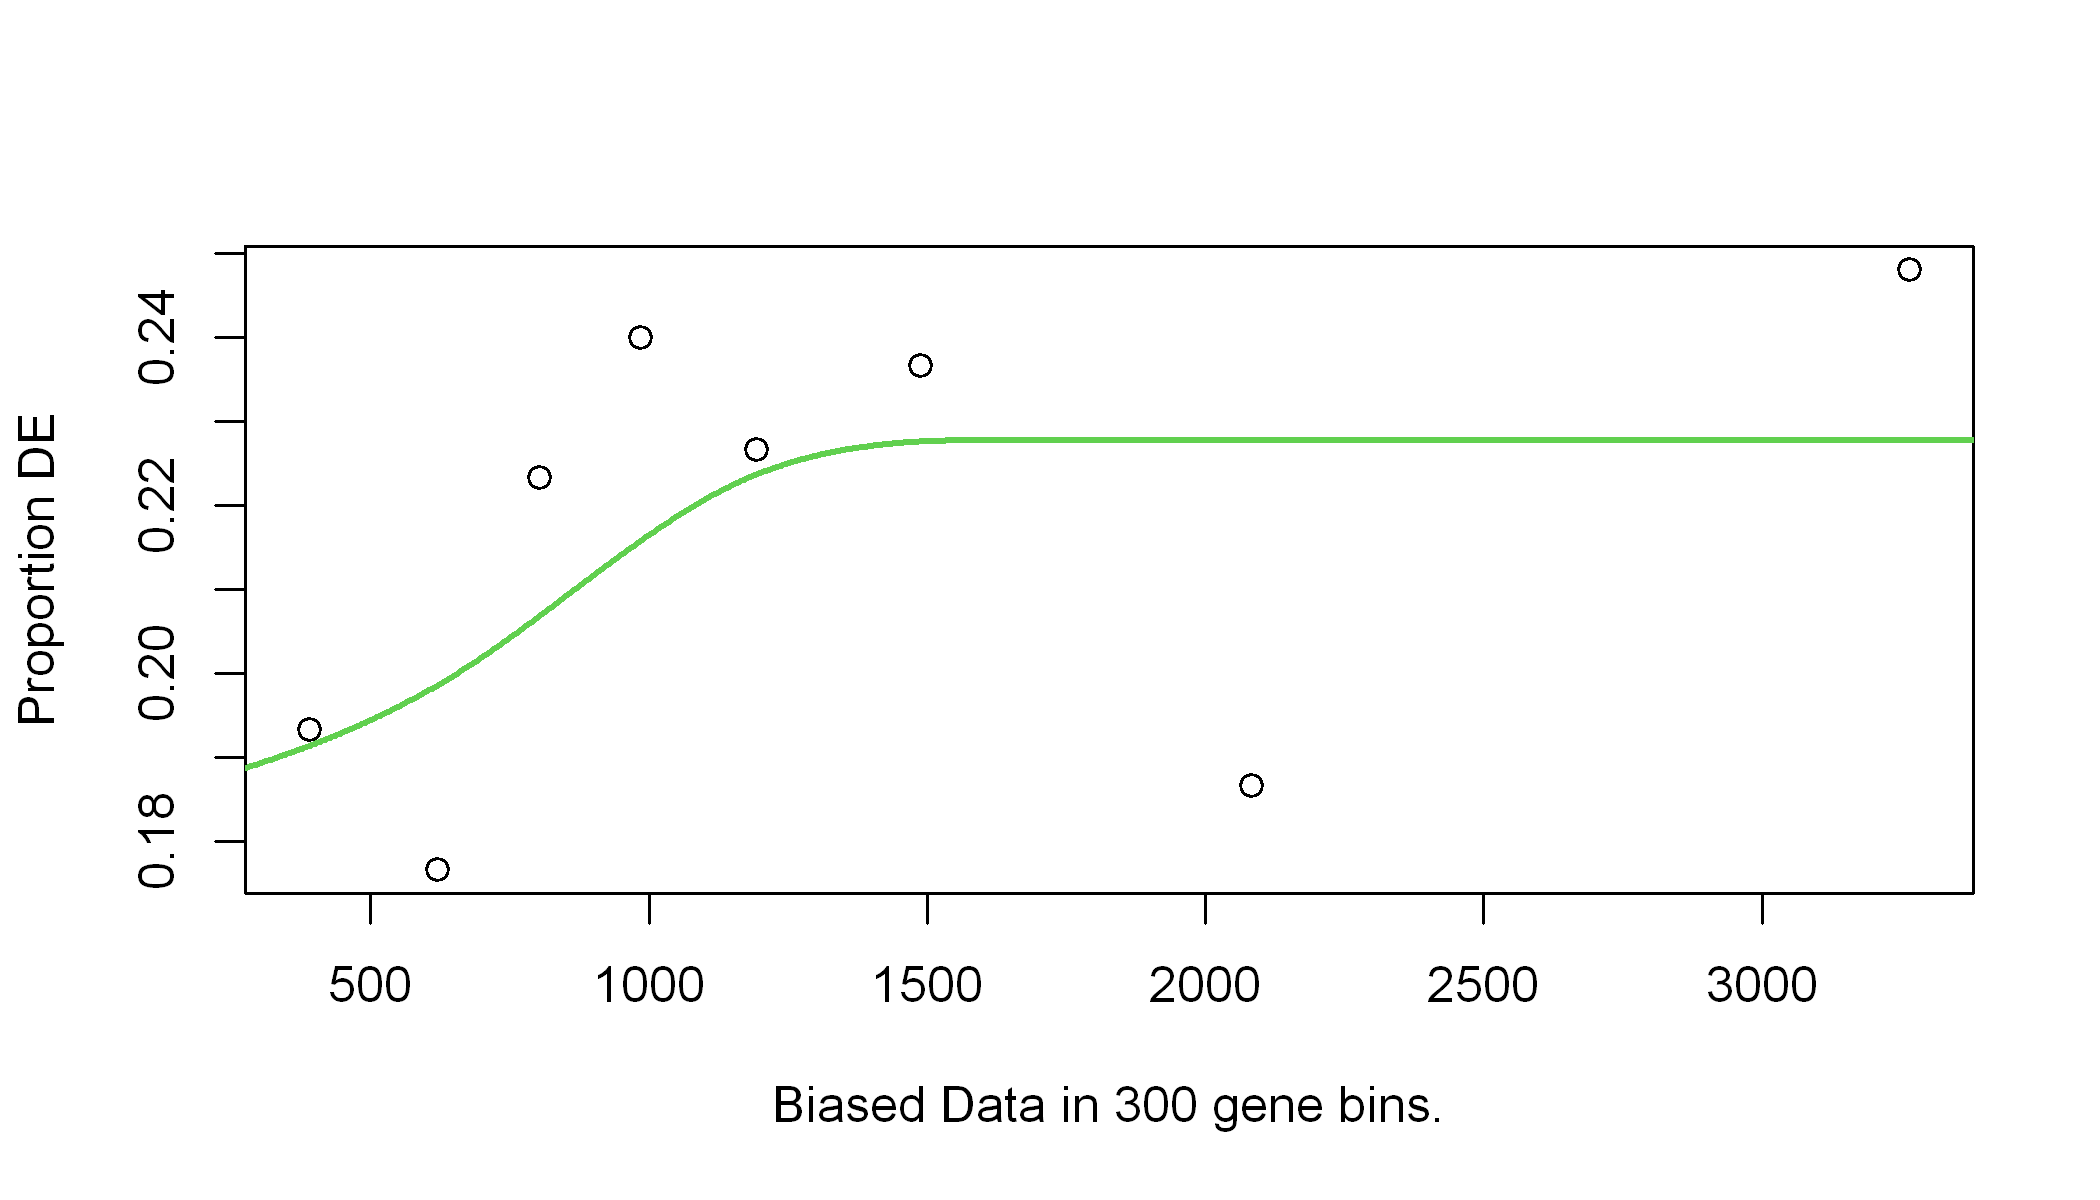

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


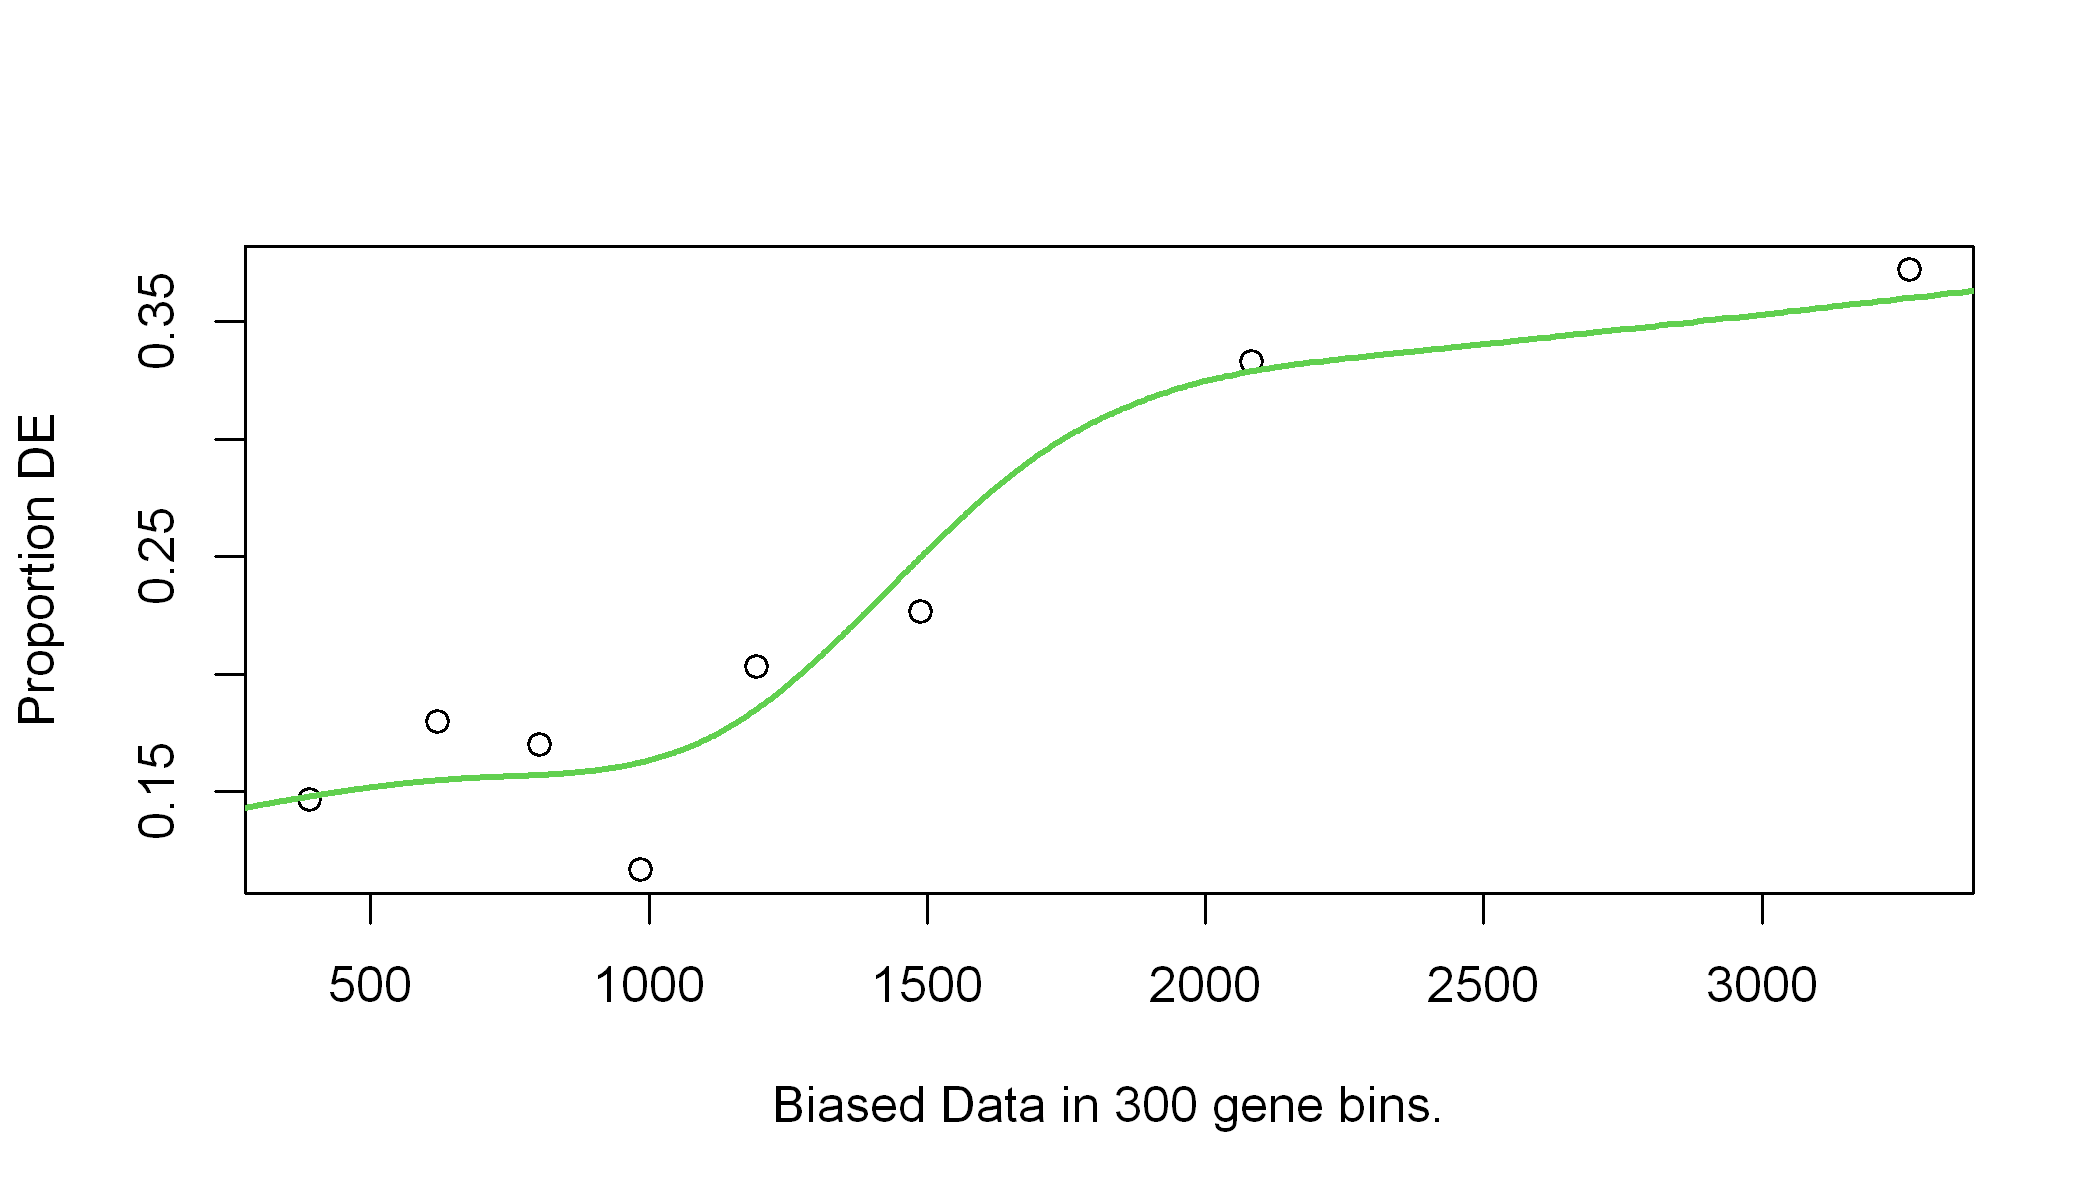

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


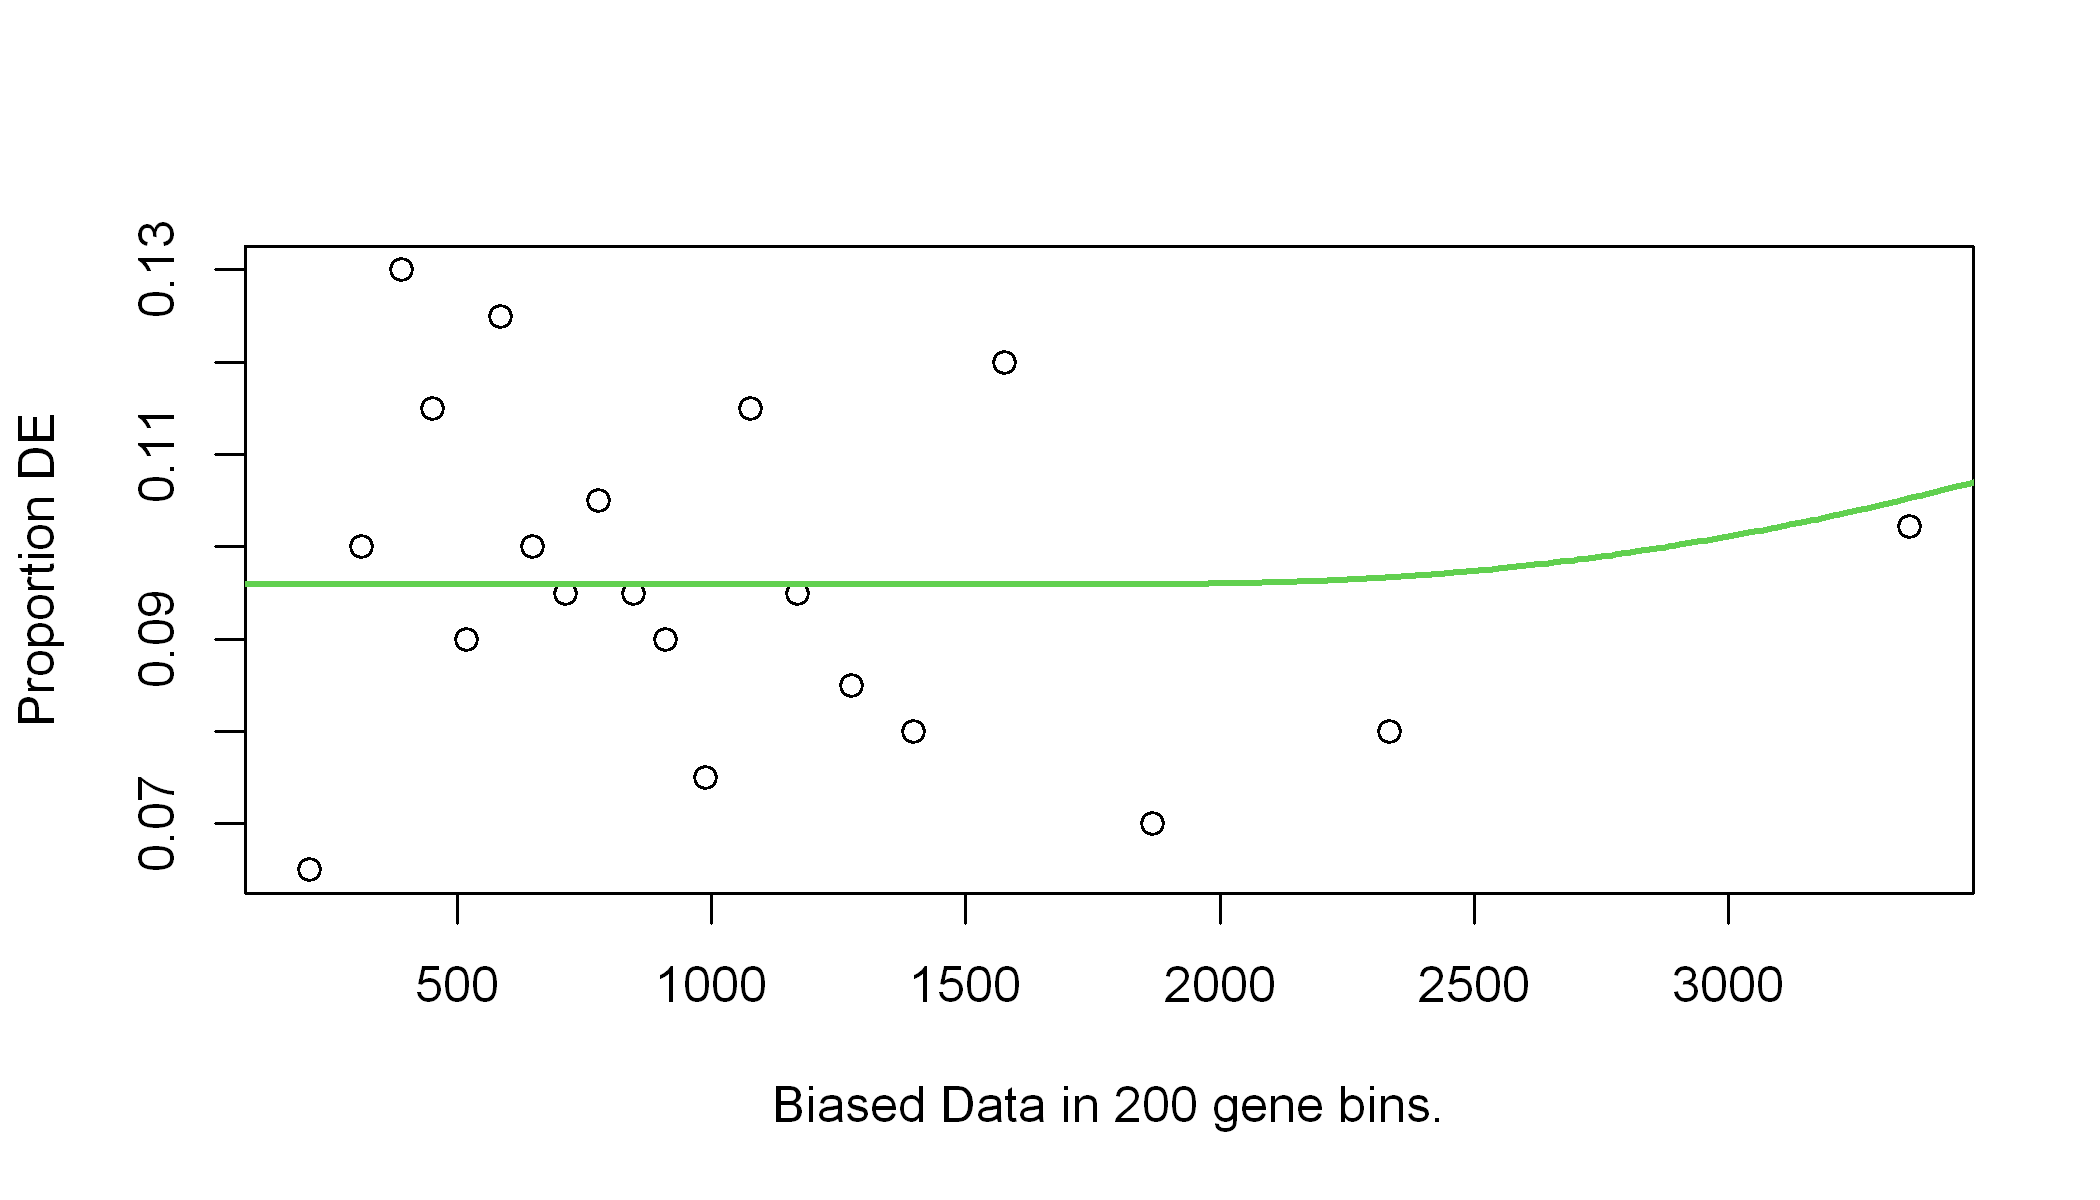

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


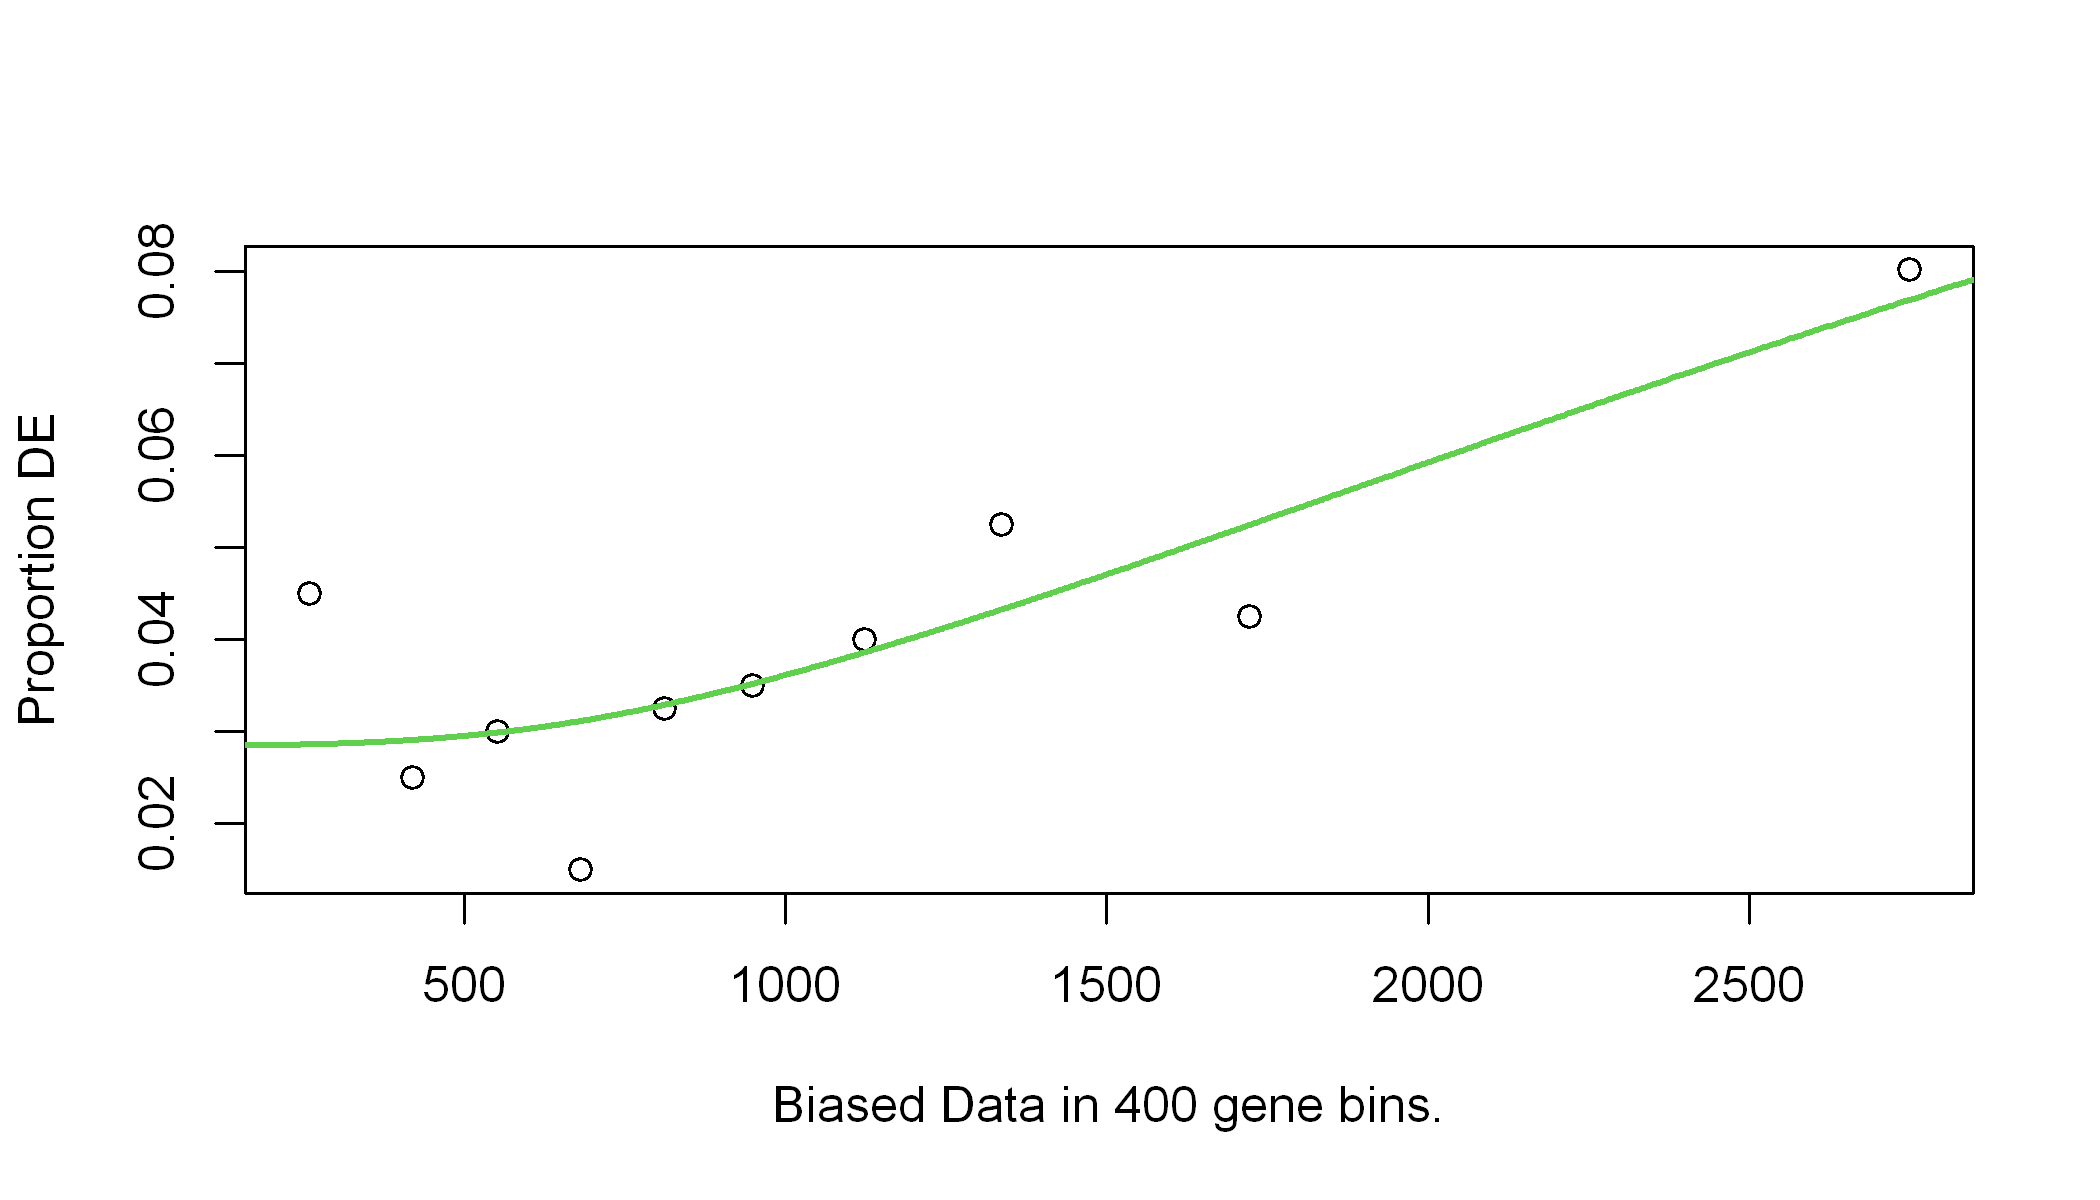

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


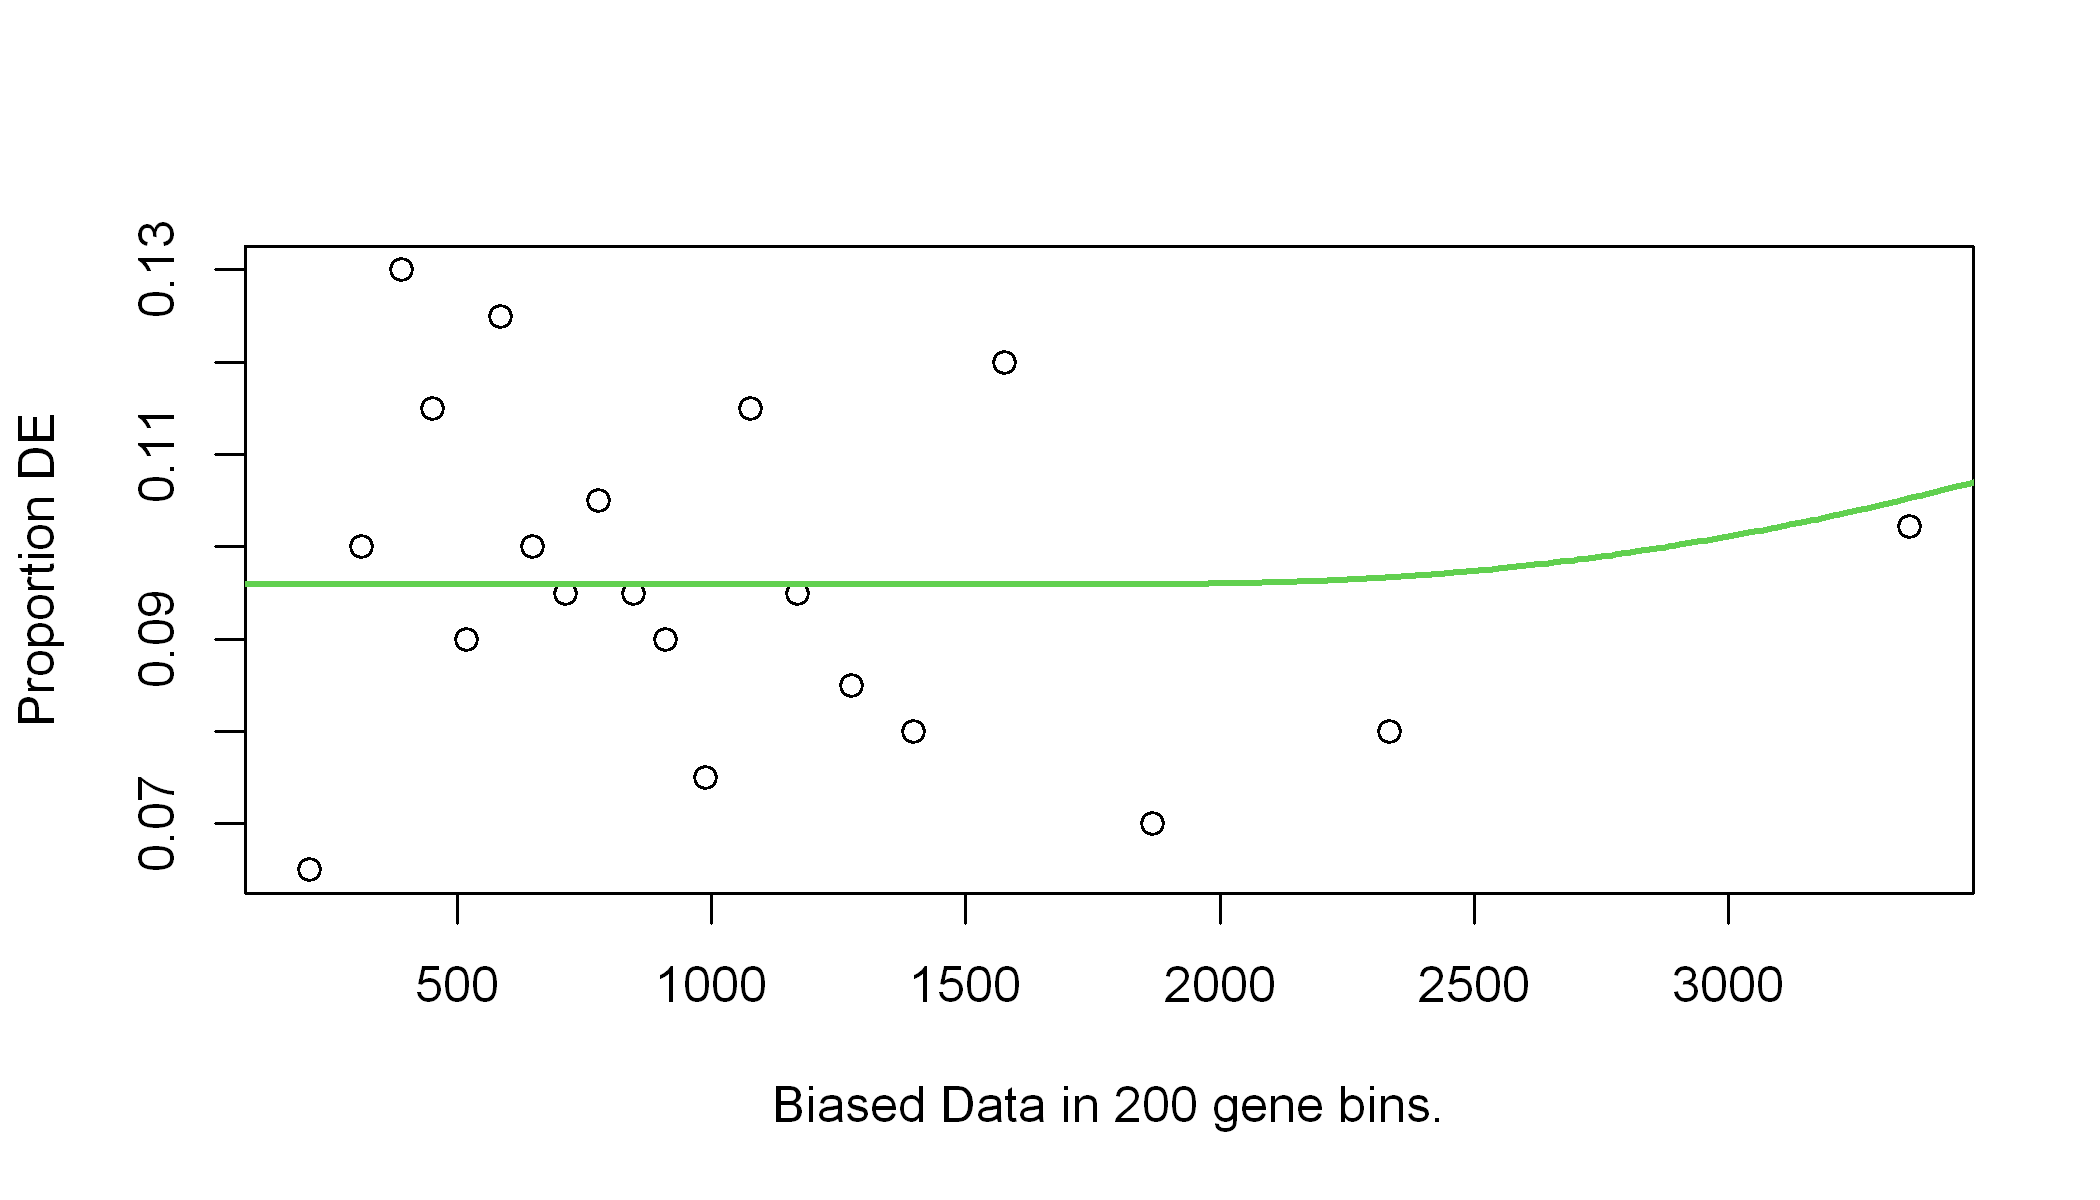

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


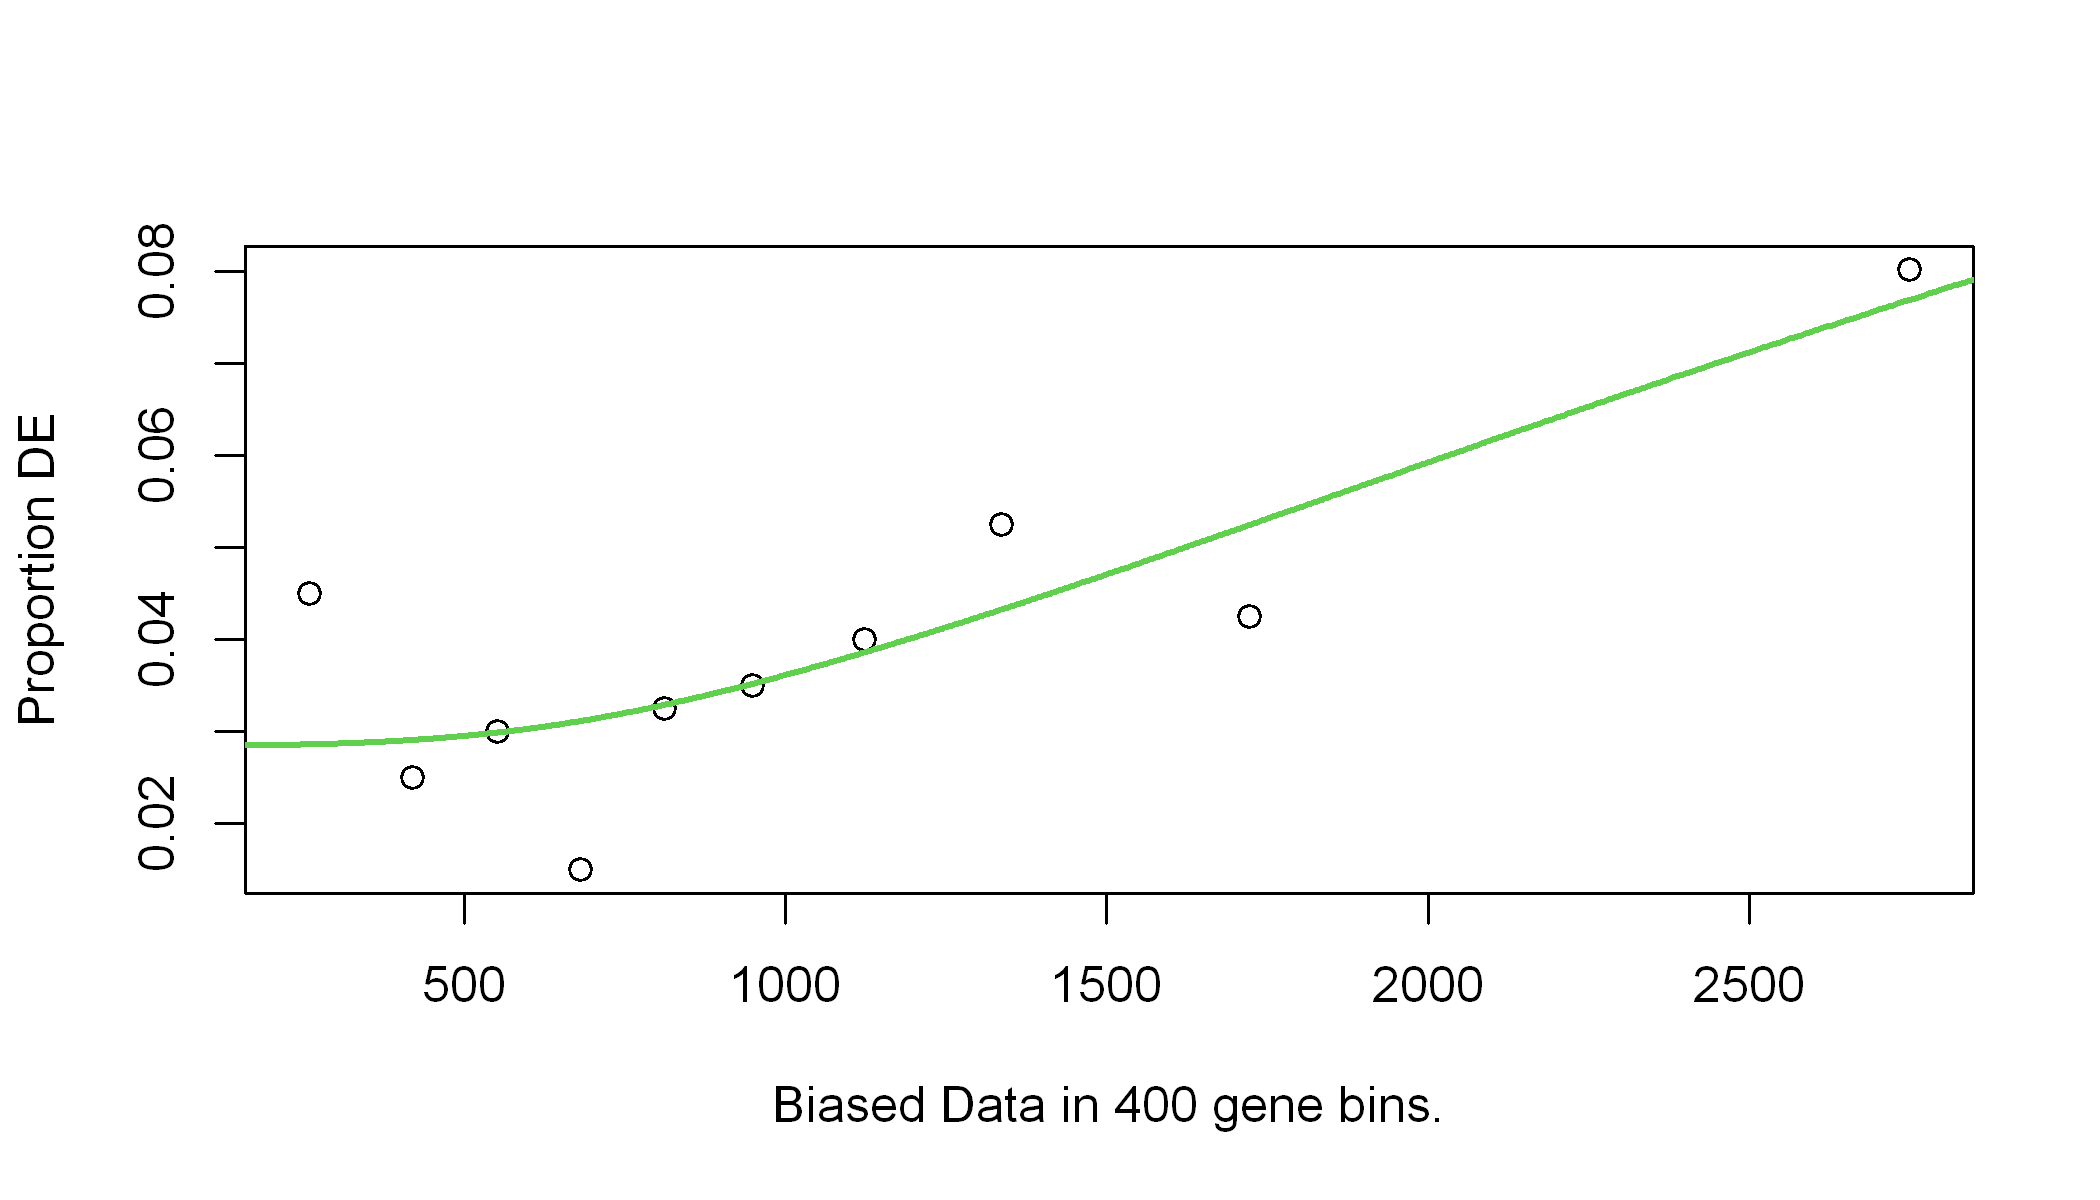

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


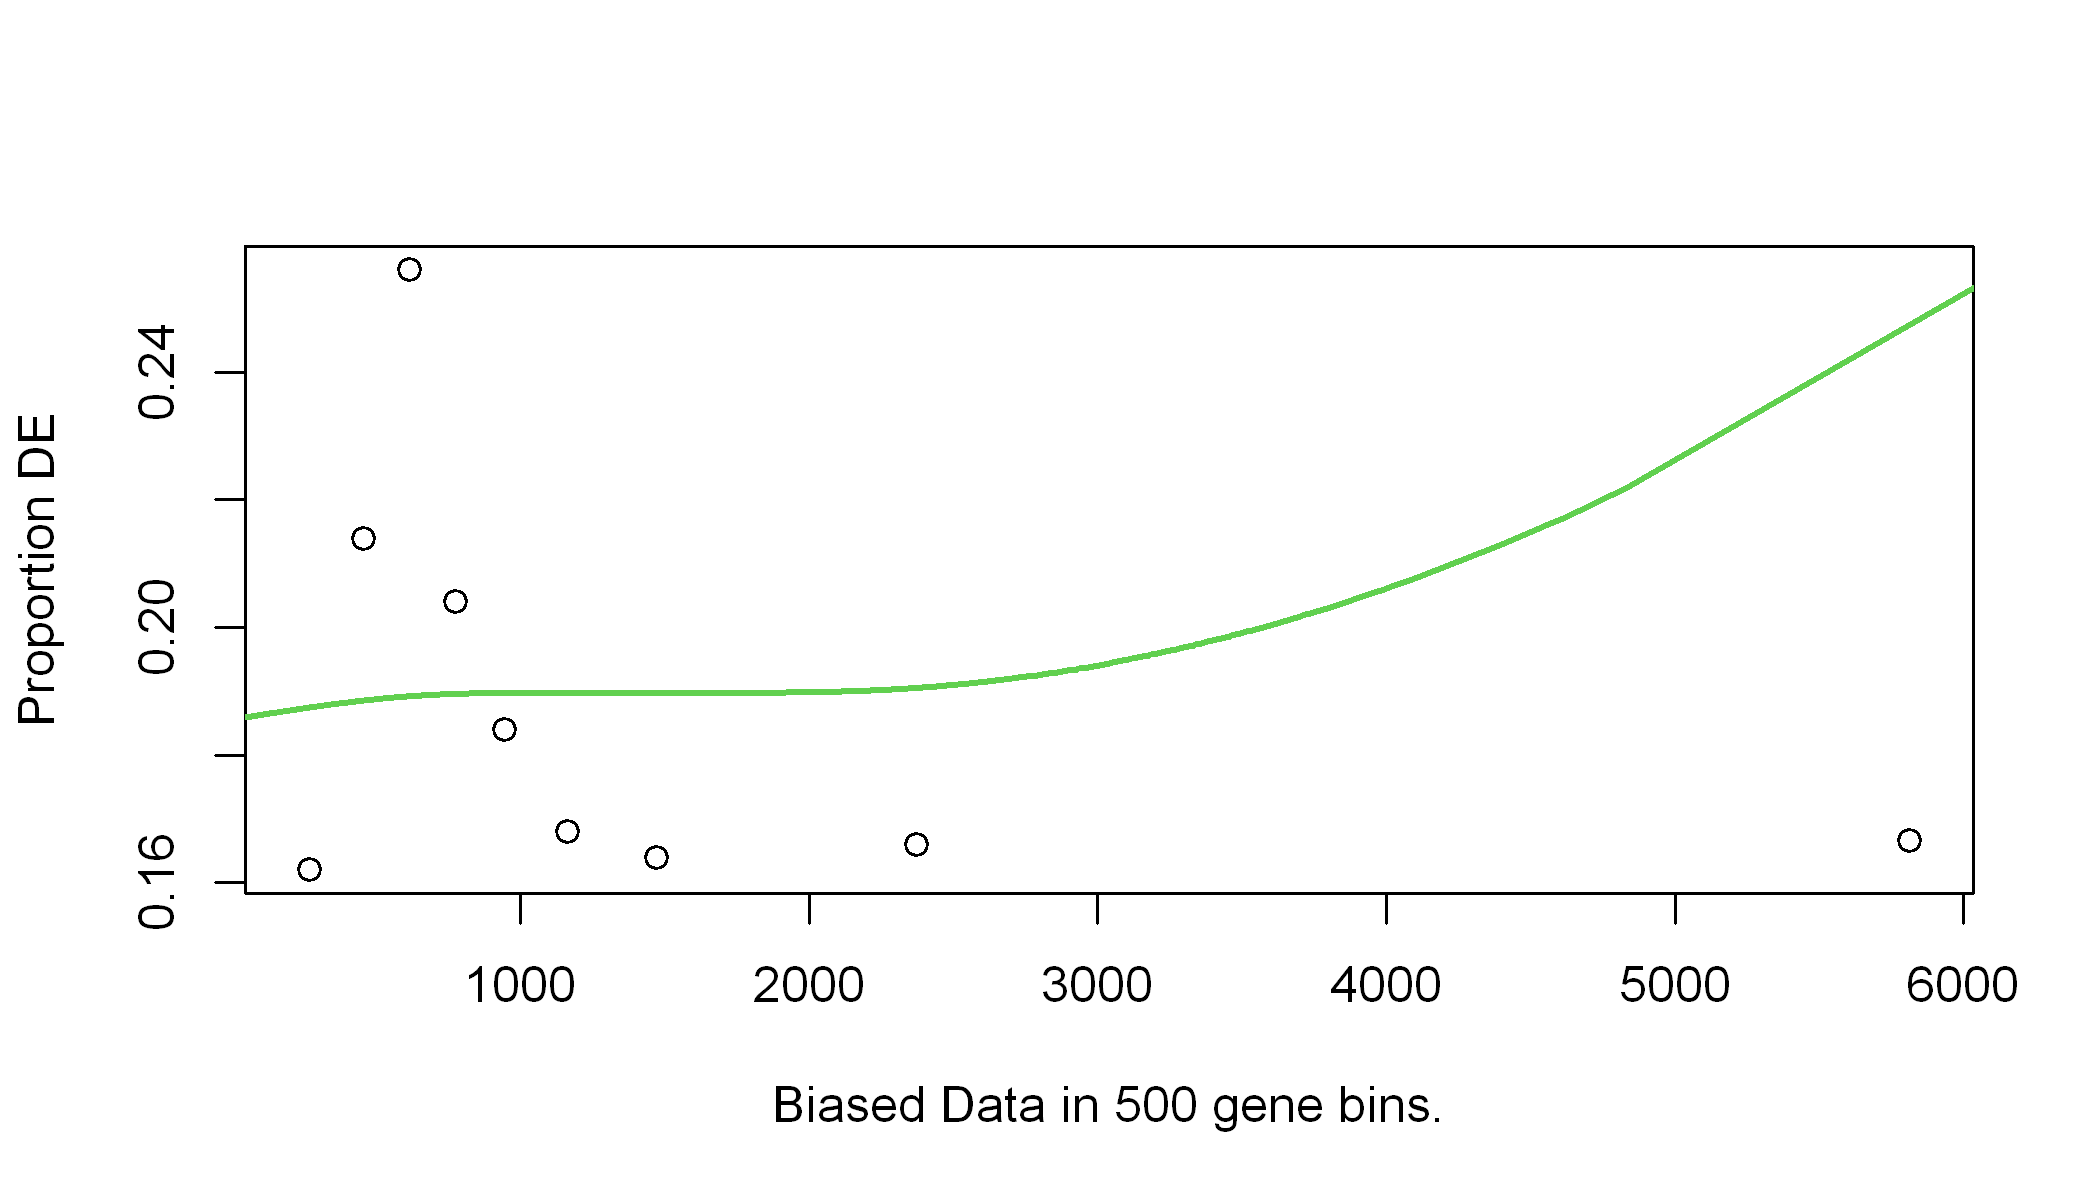

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


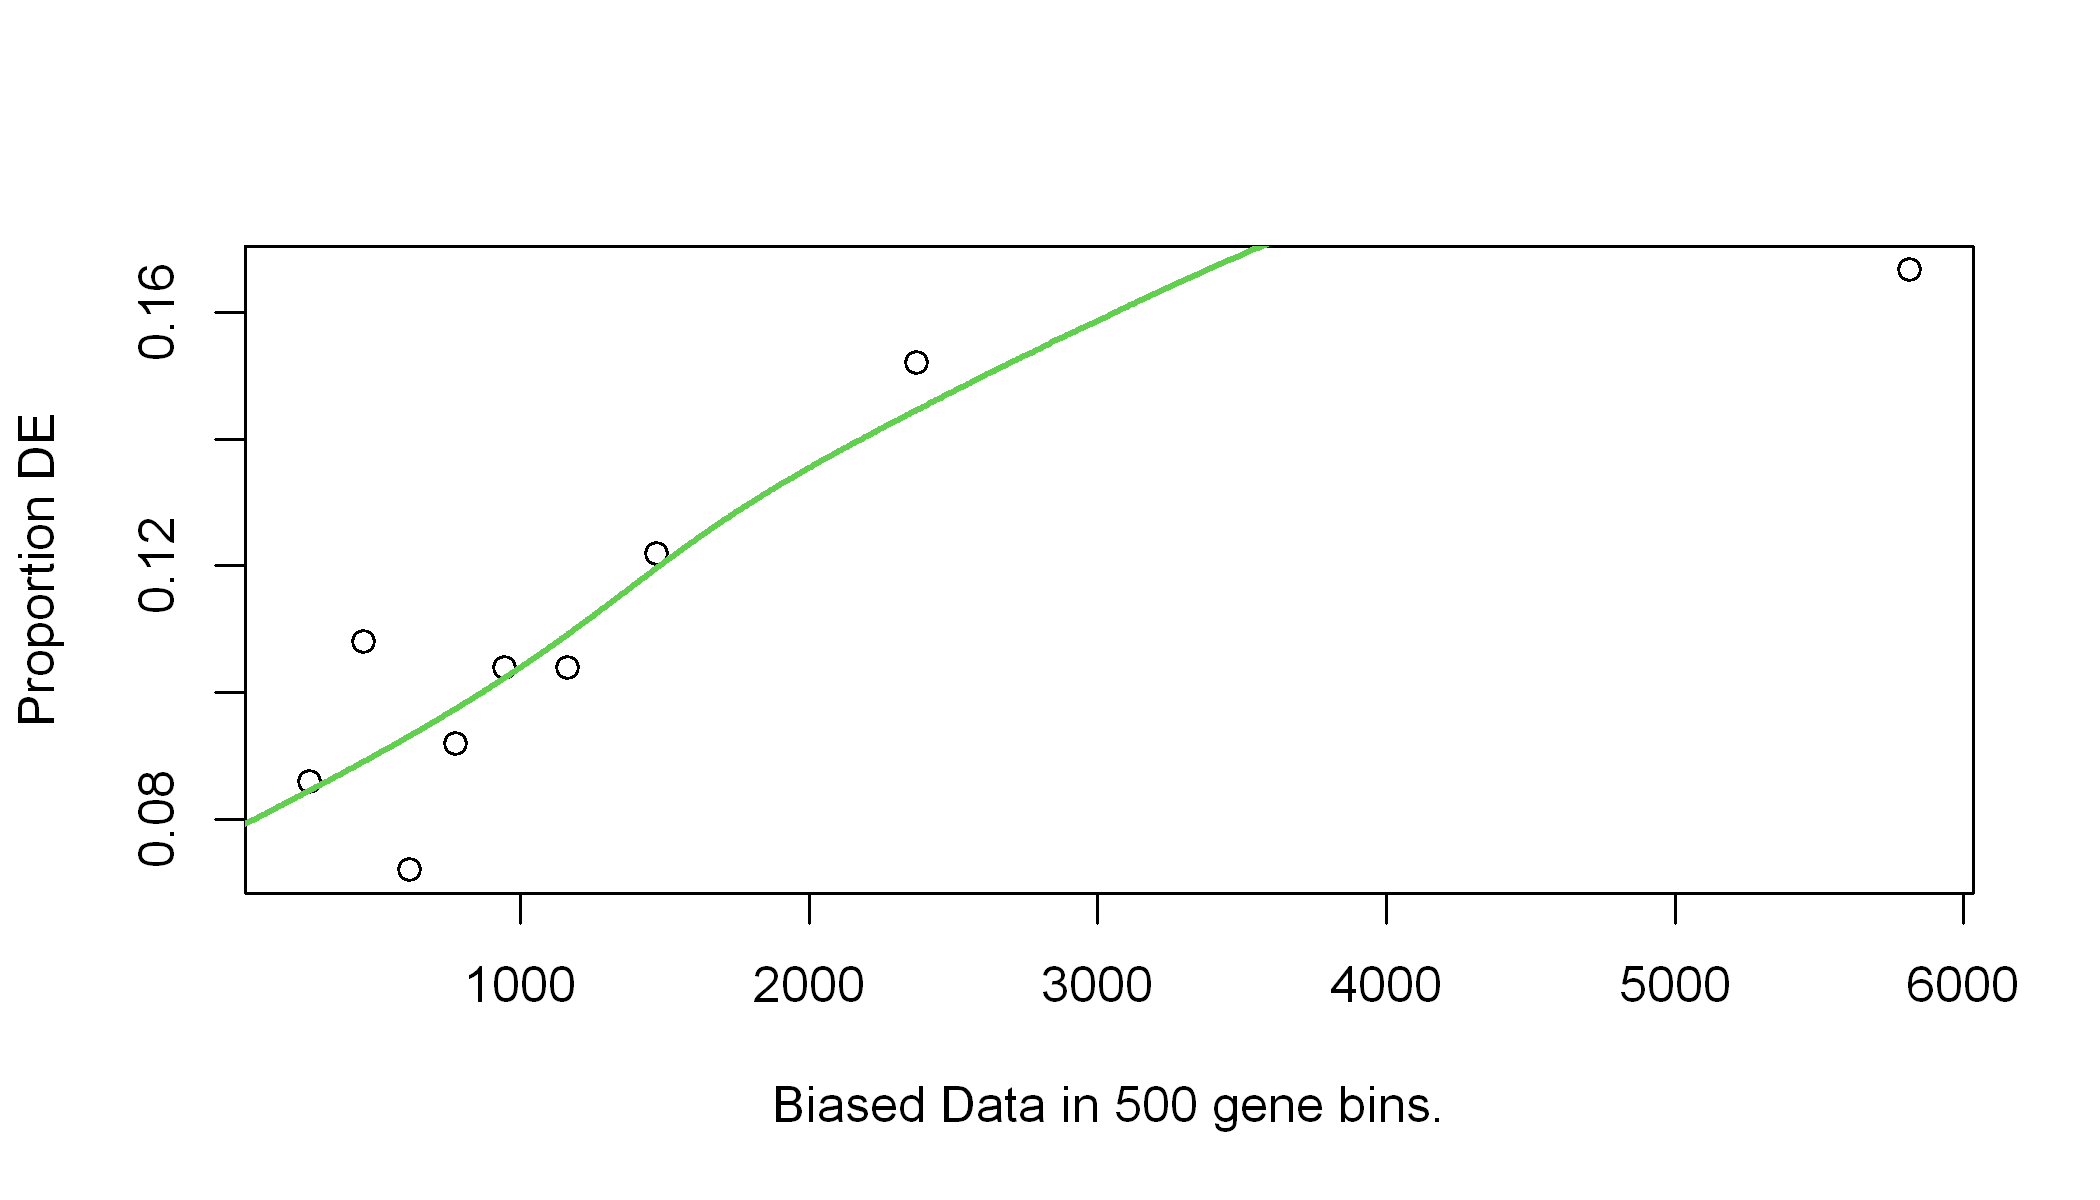

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


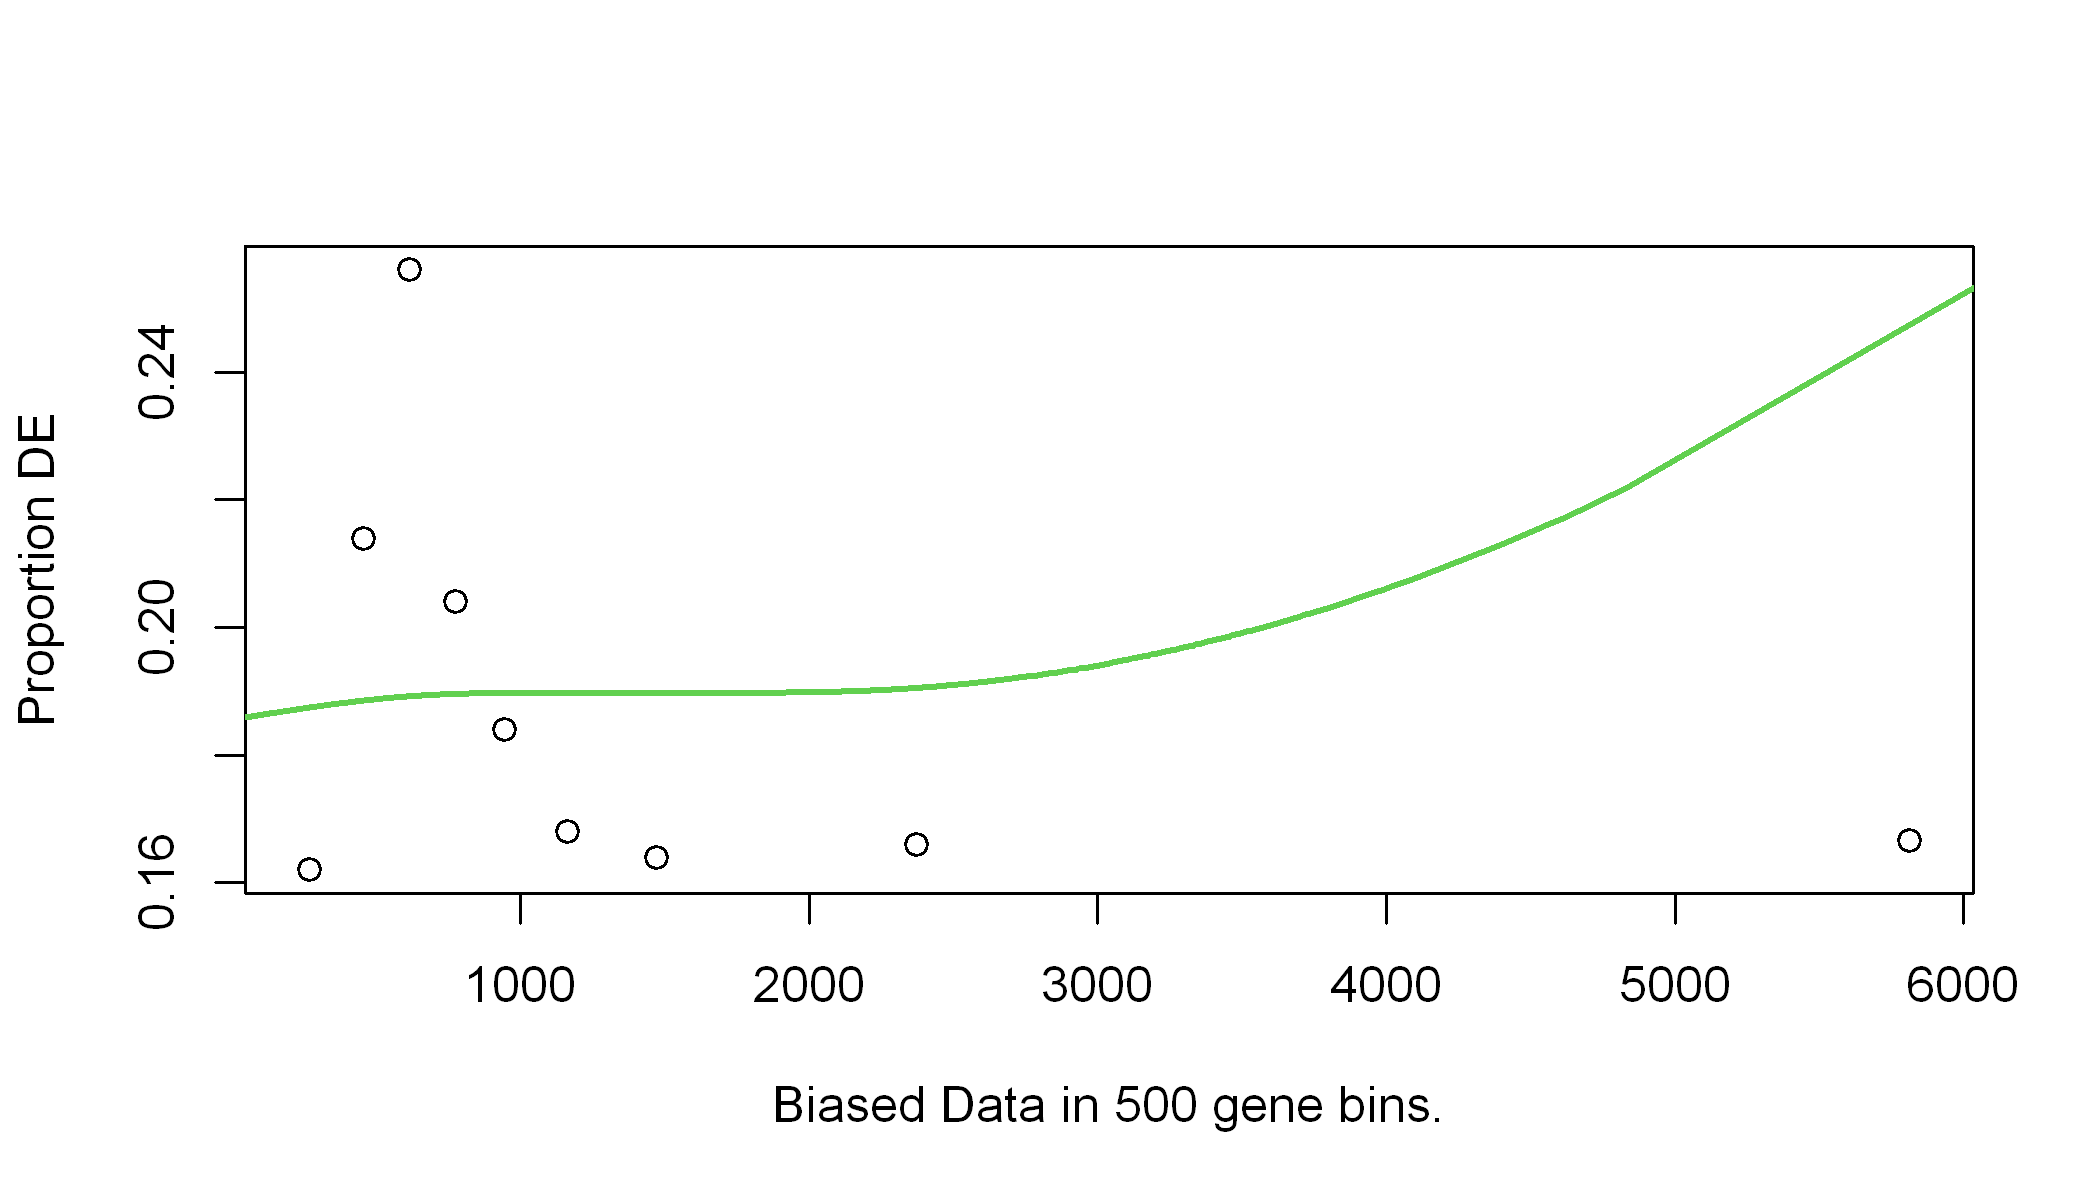

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


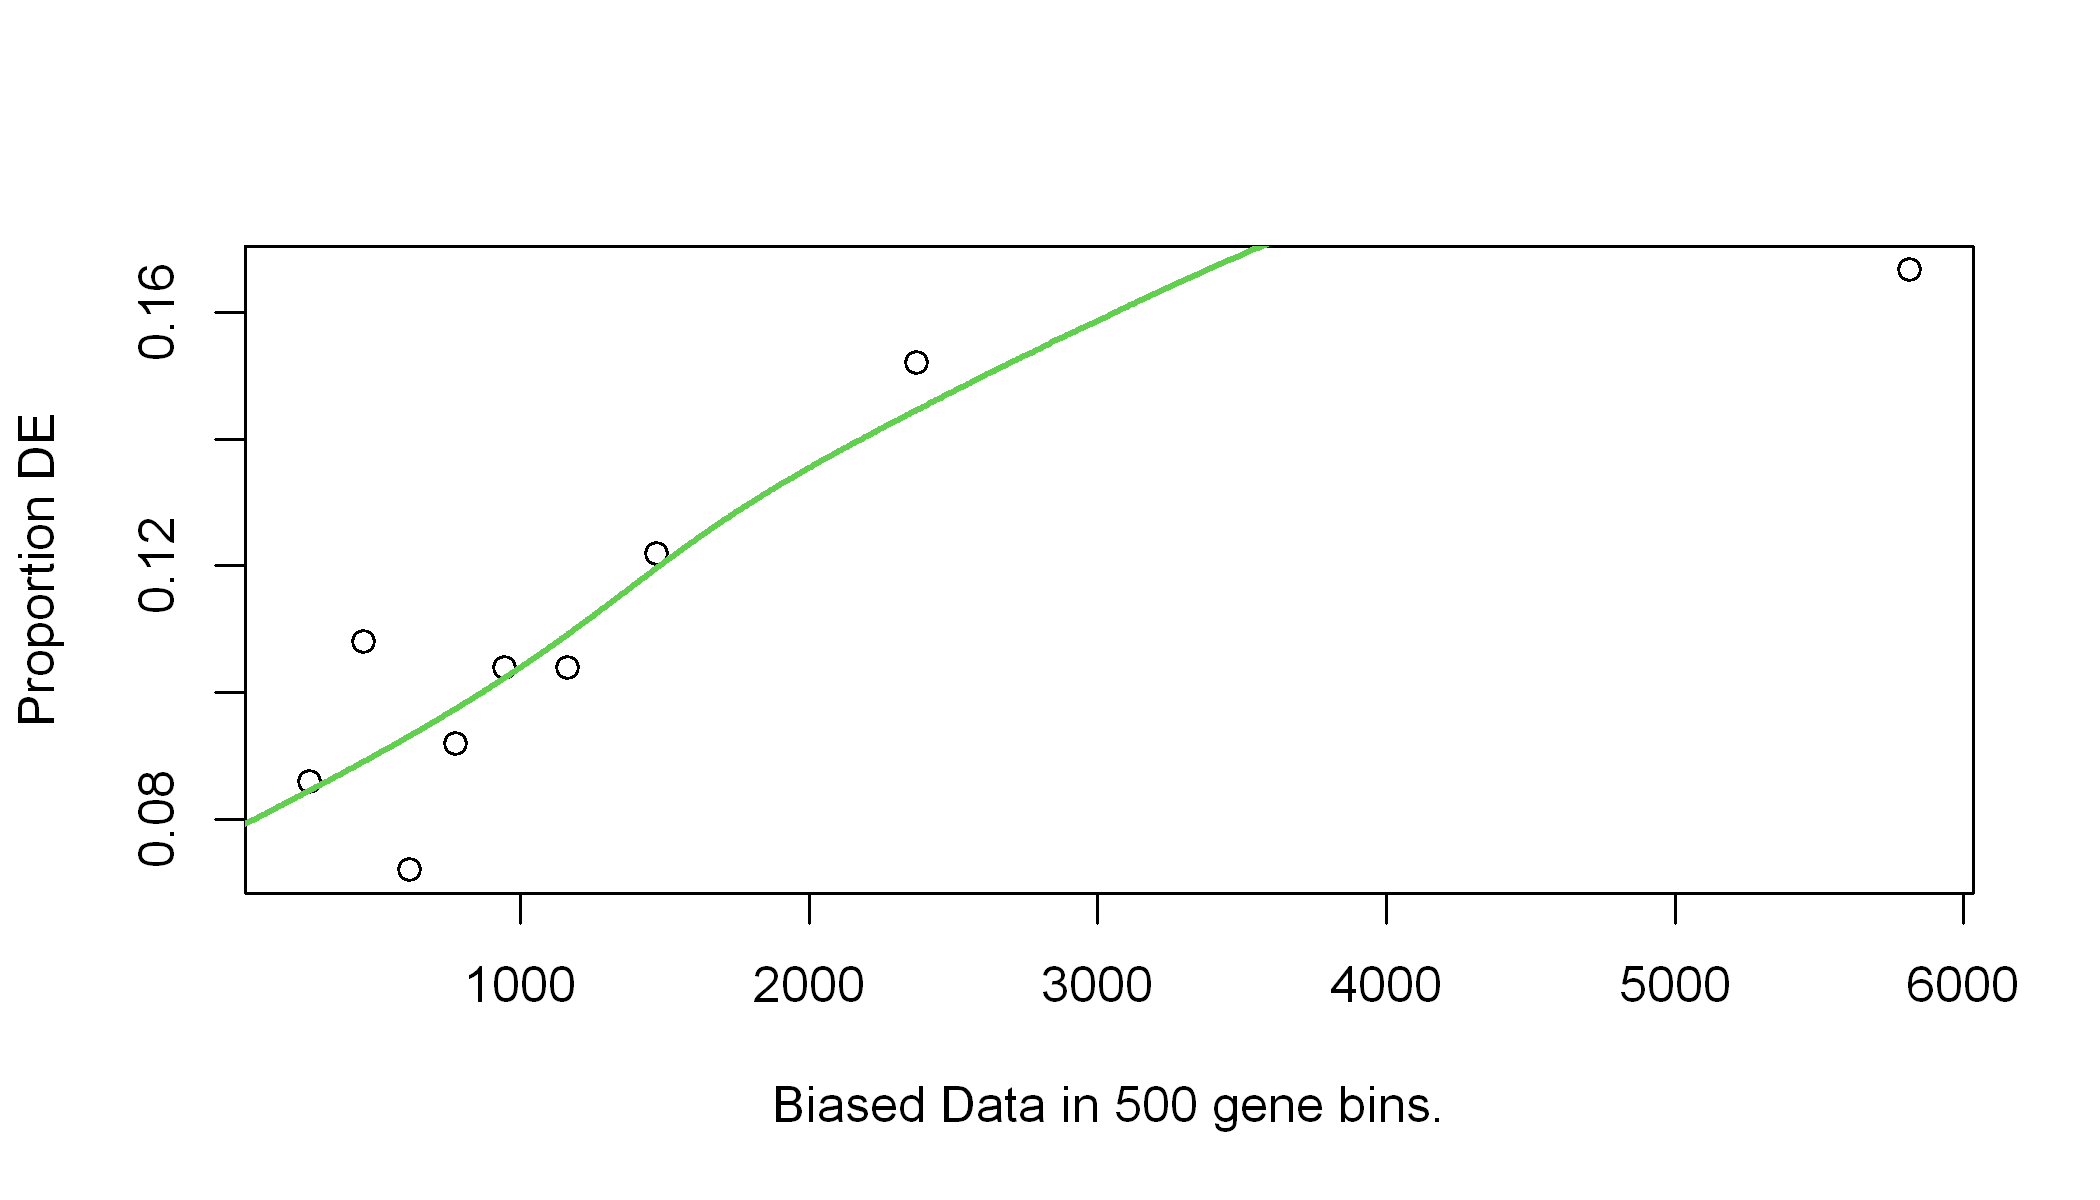

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


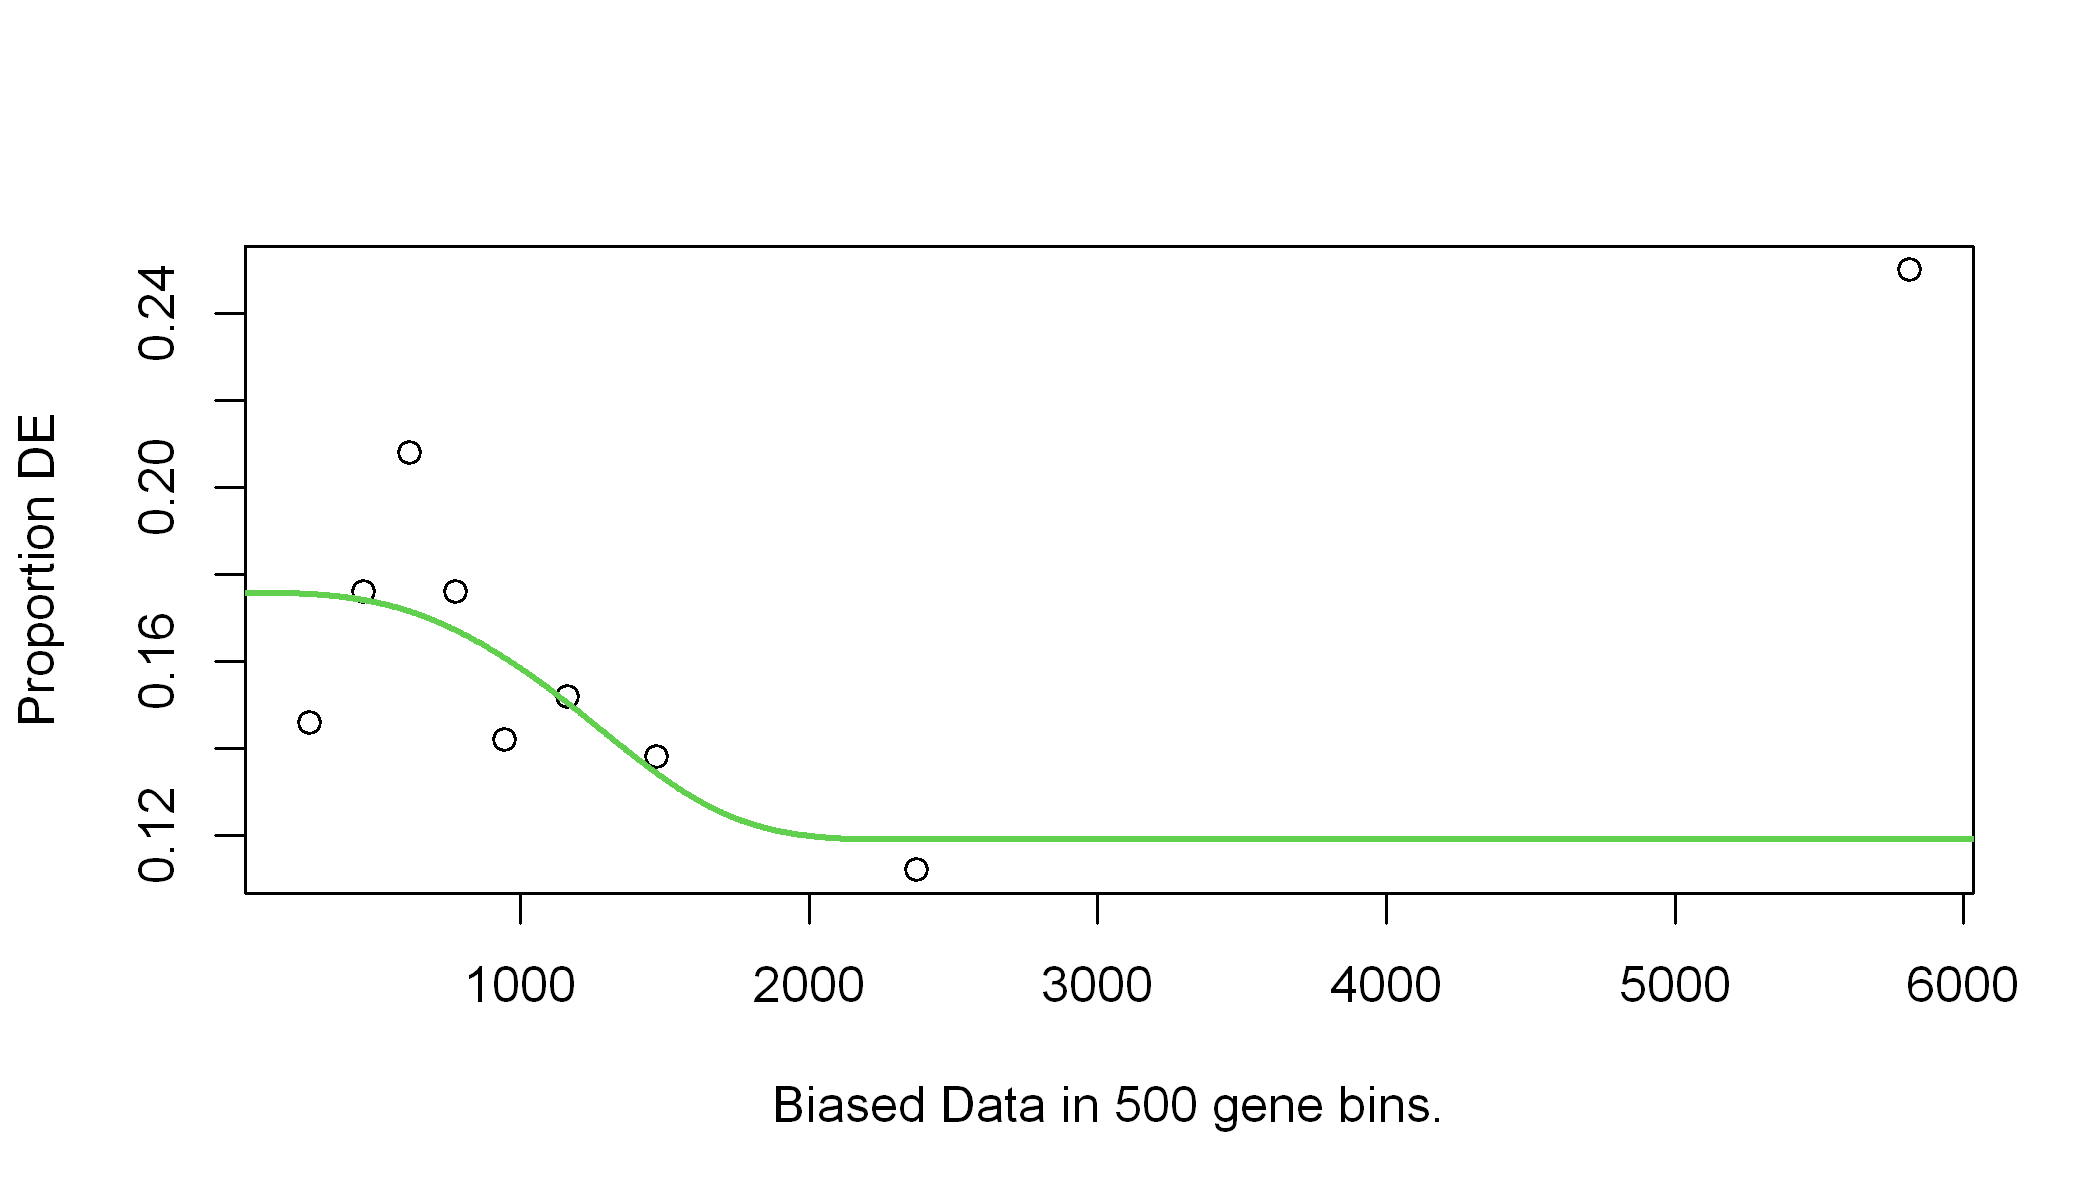

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


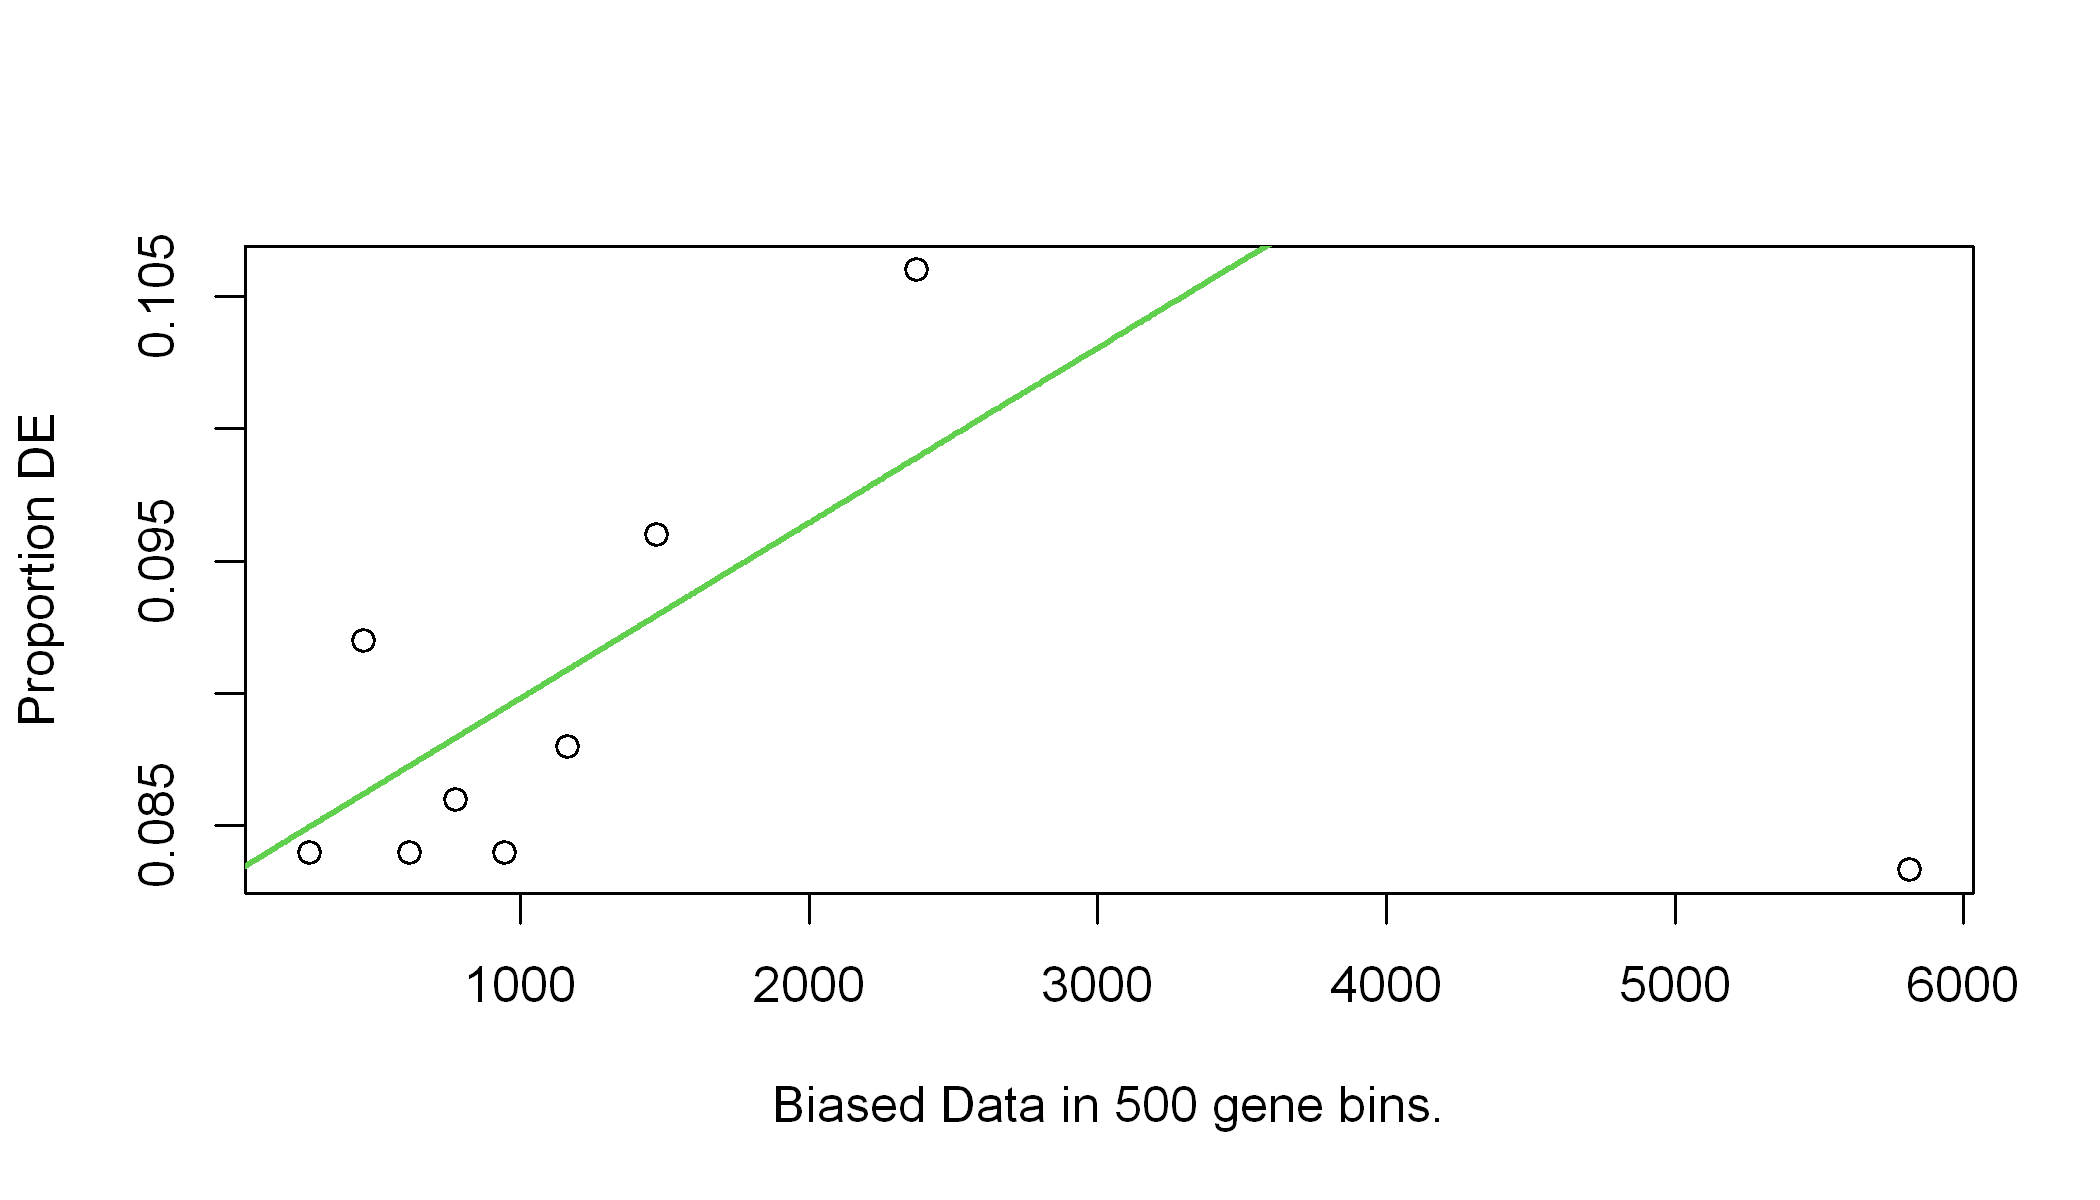

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


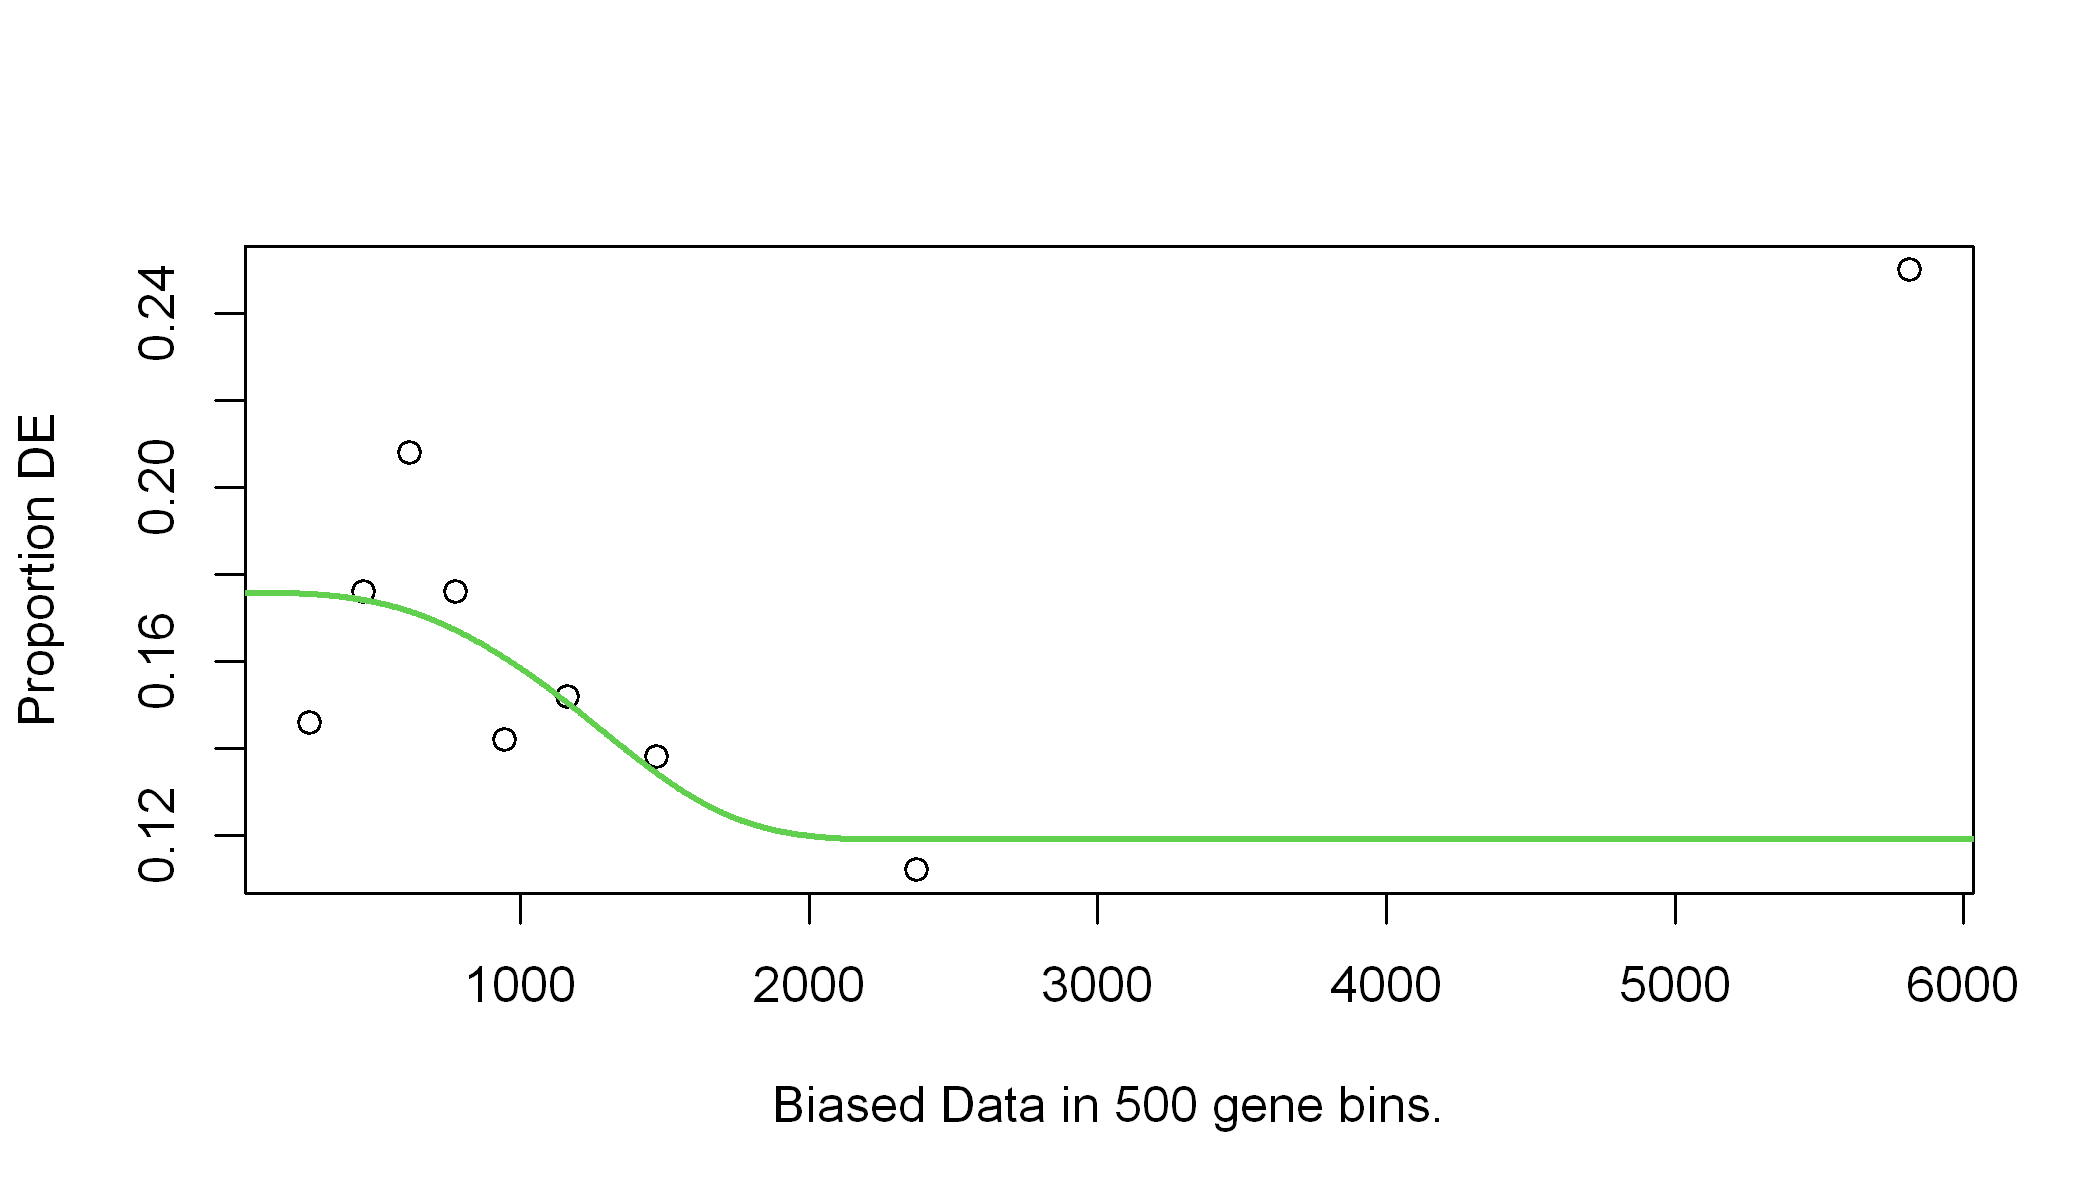

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


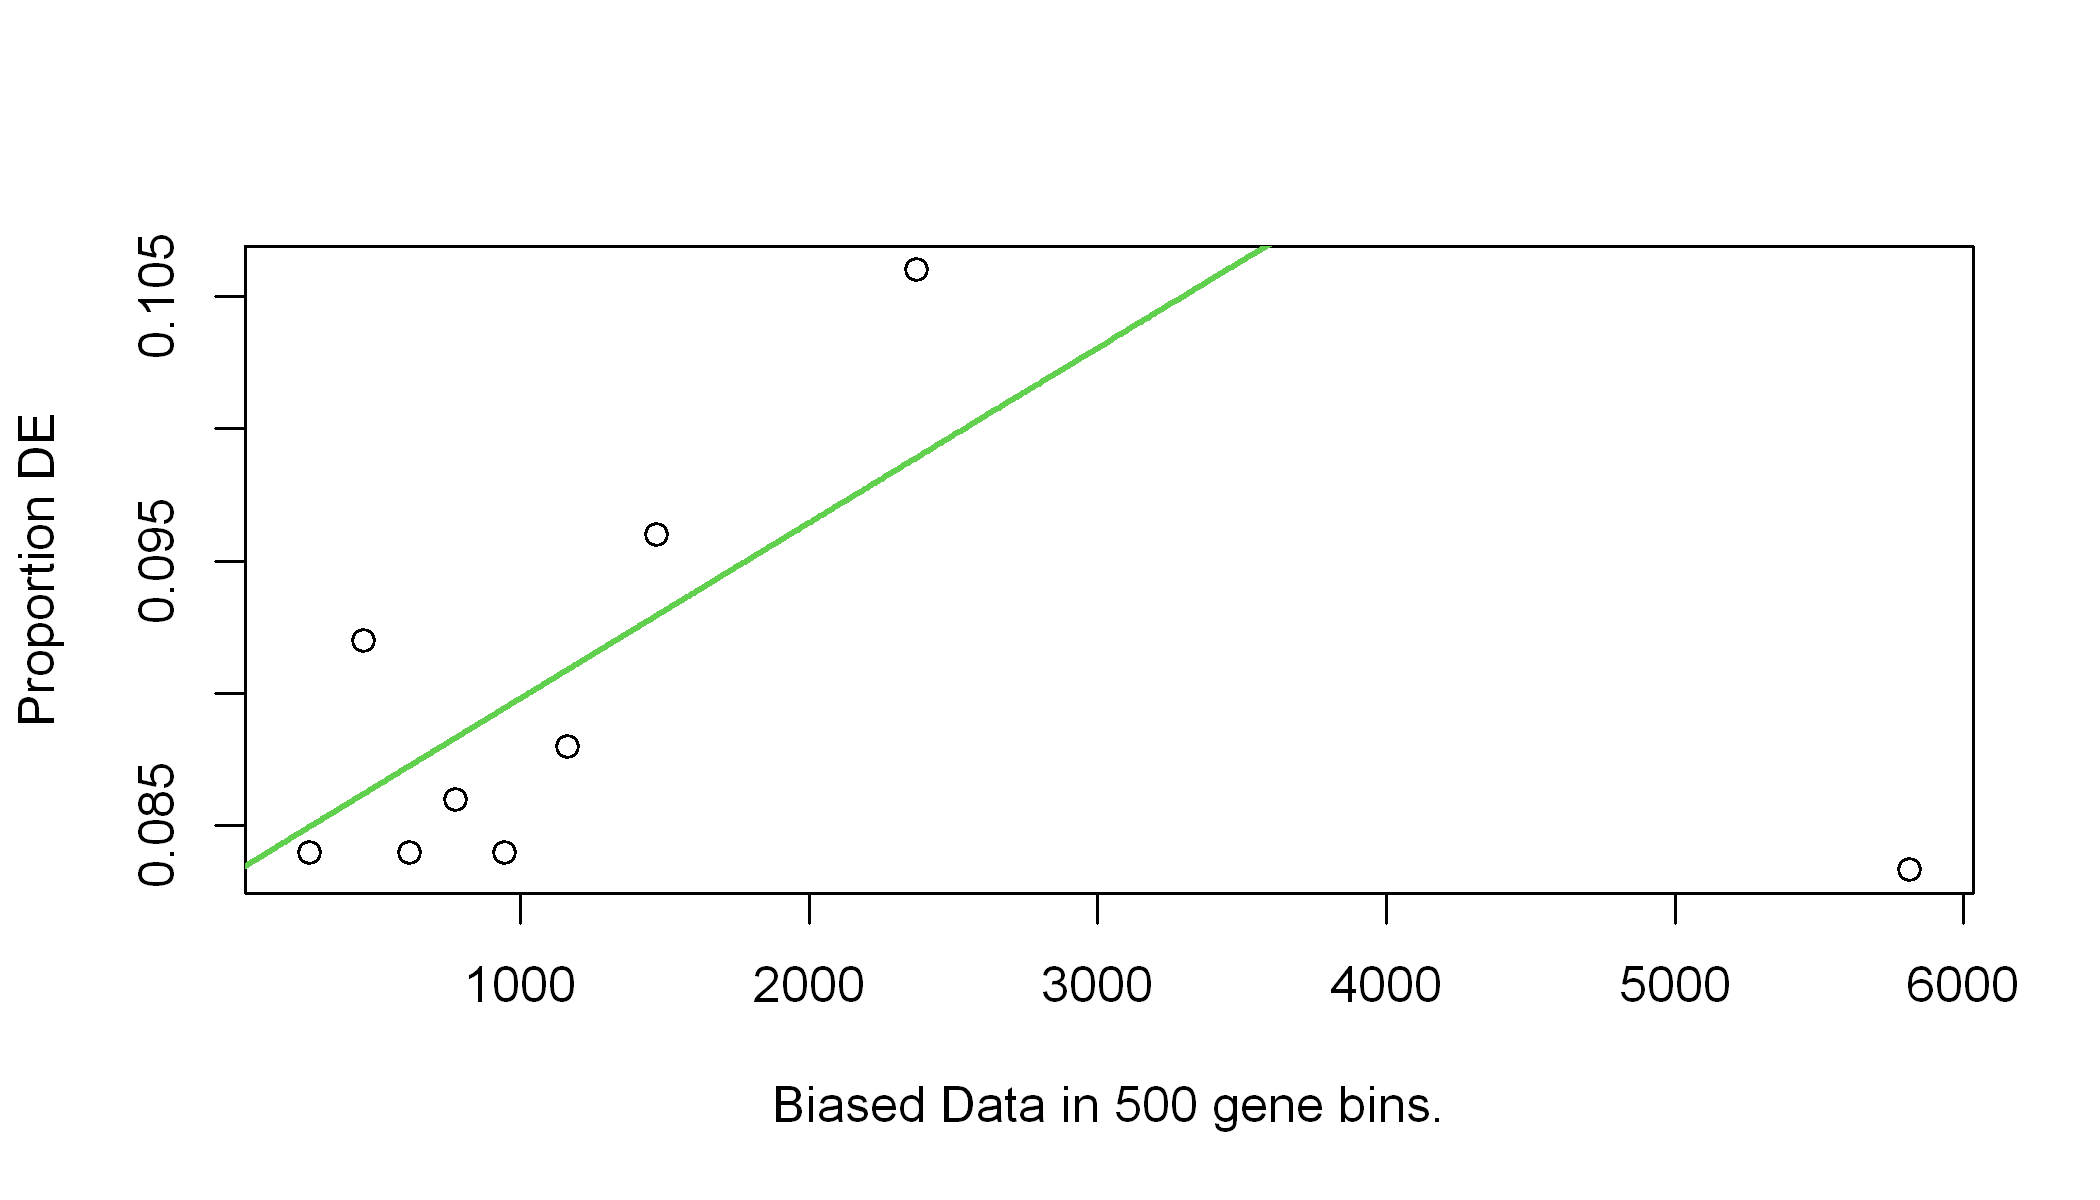

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


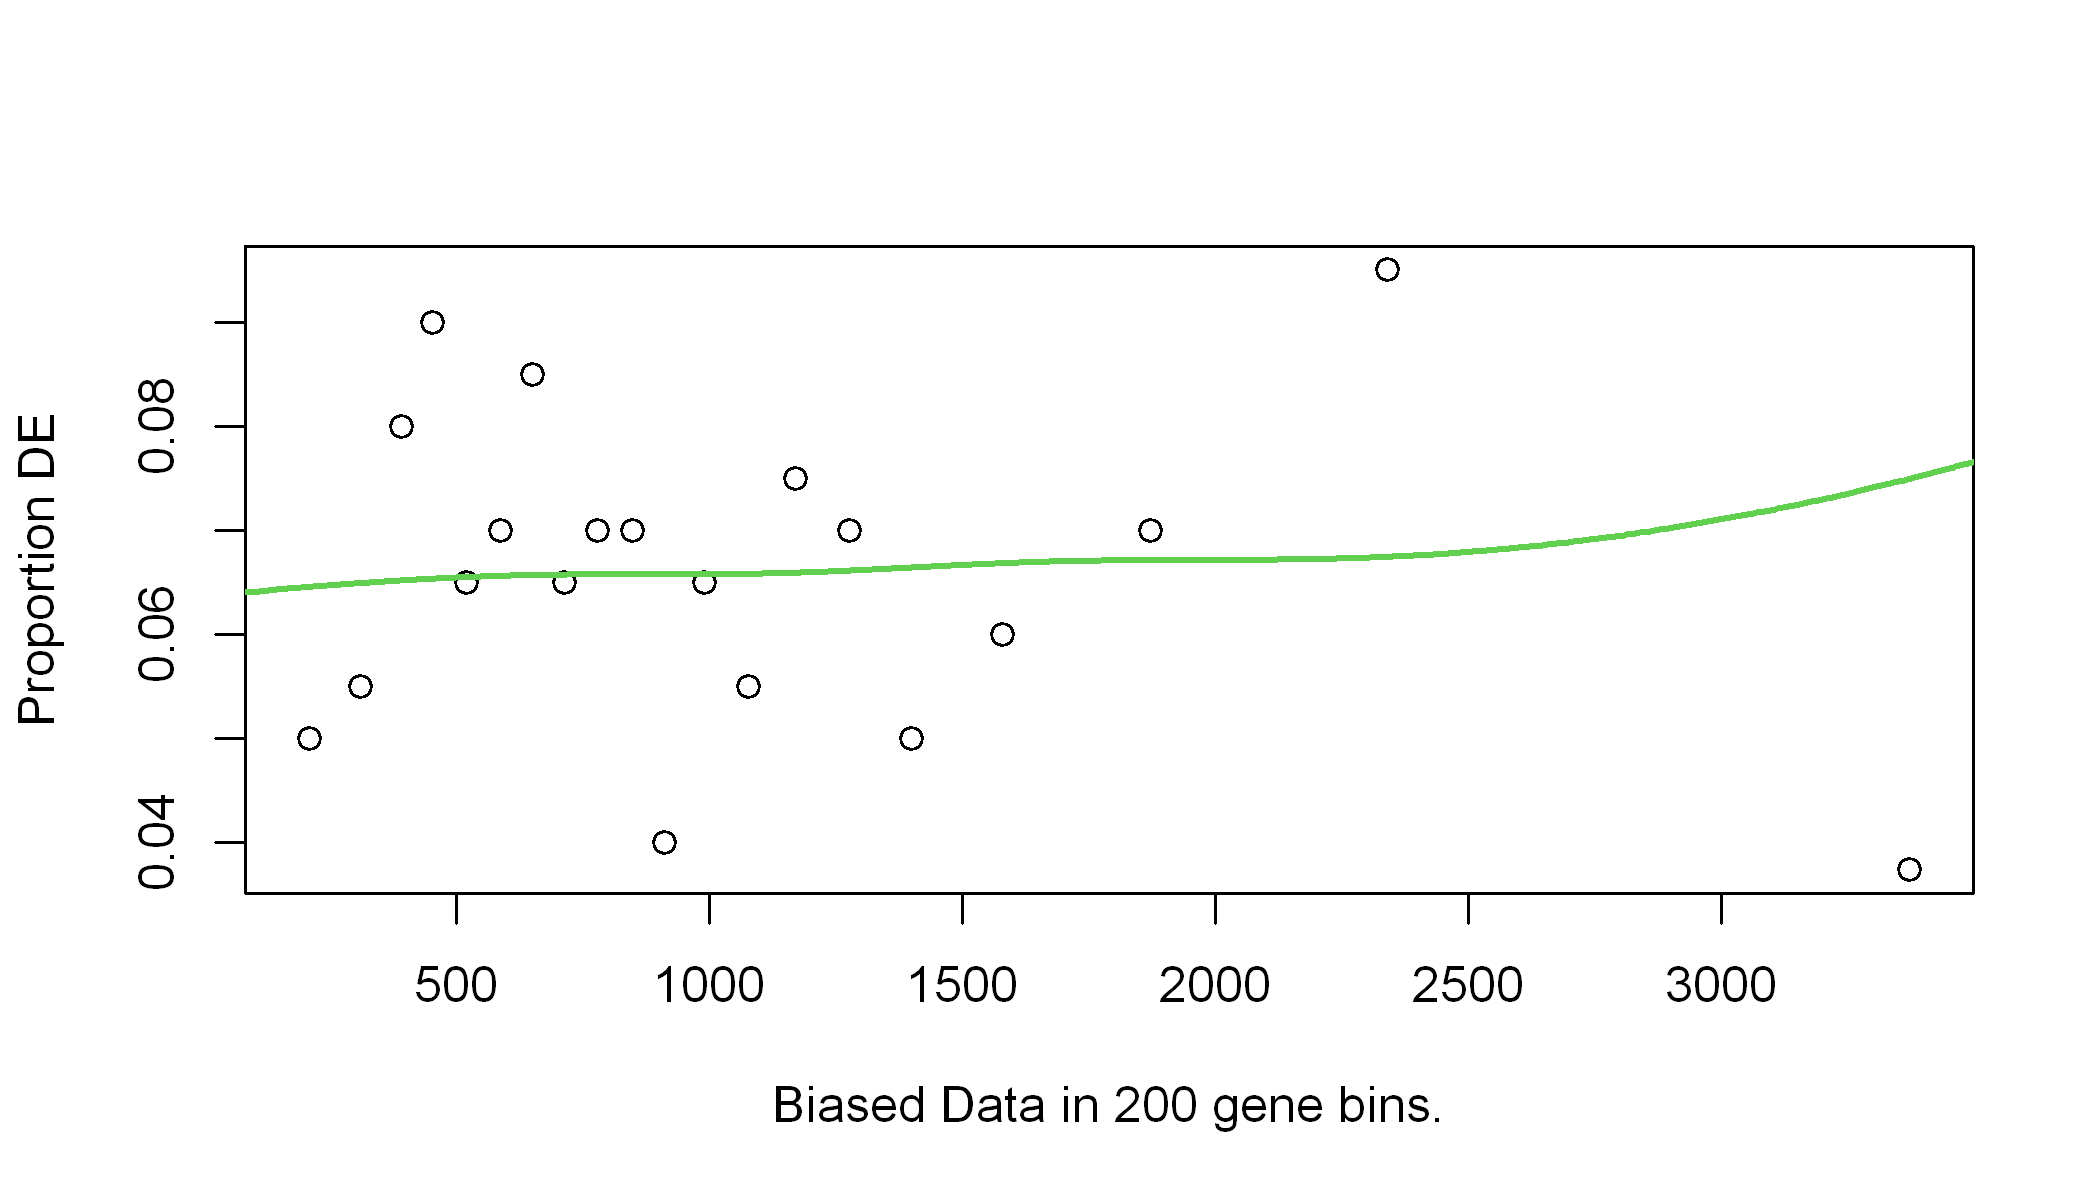

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


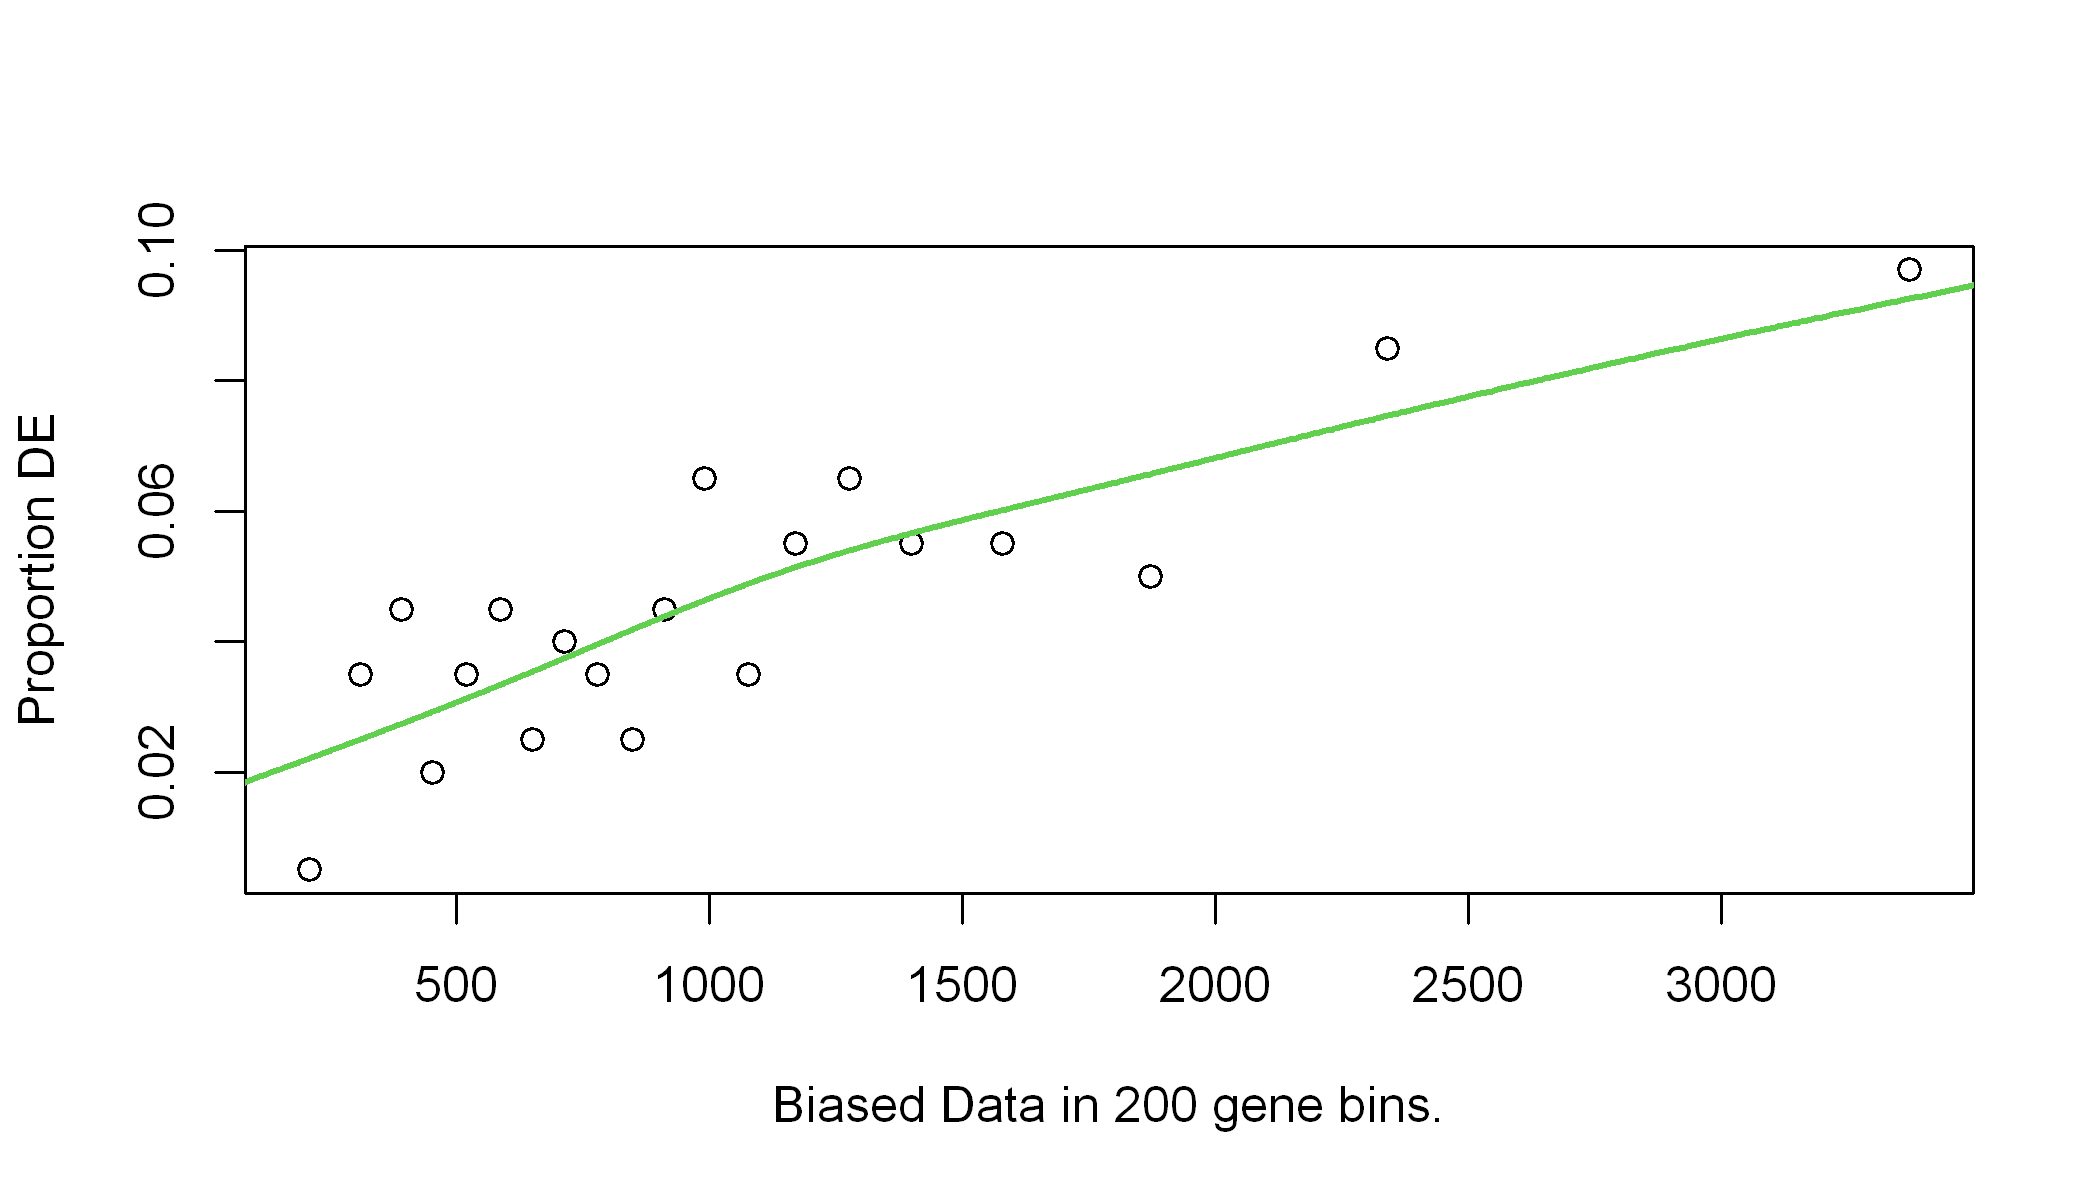

Using manually entered categories.

For 54 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


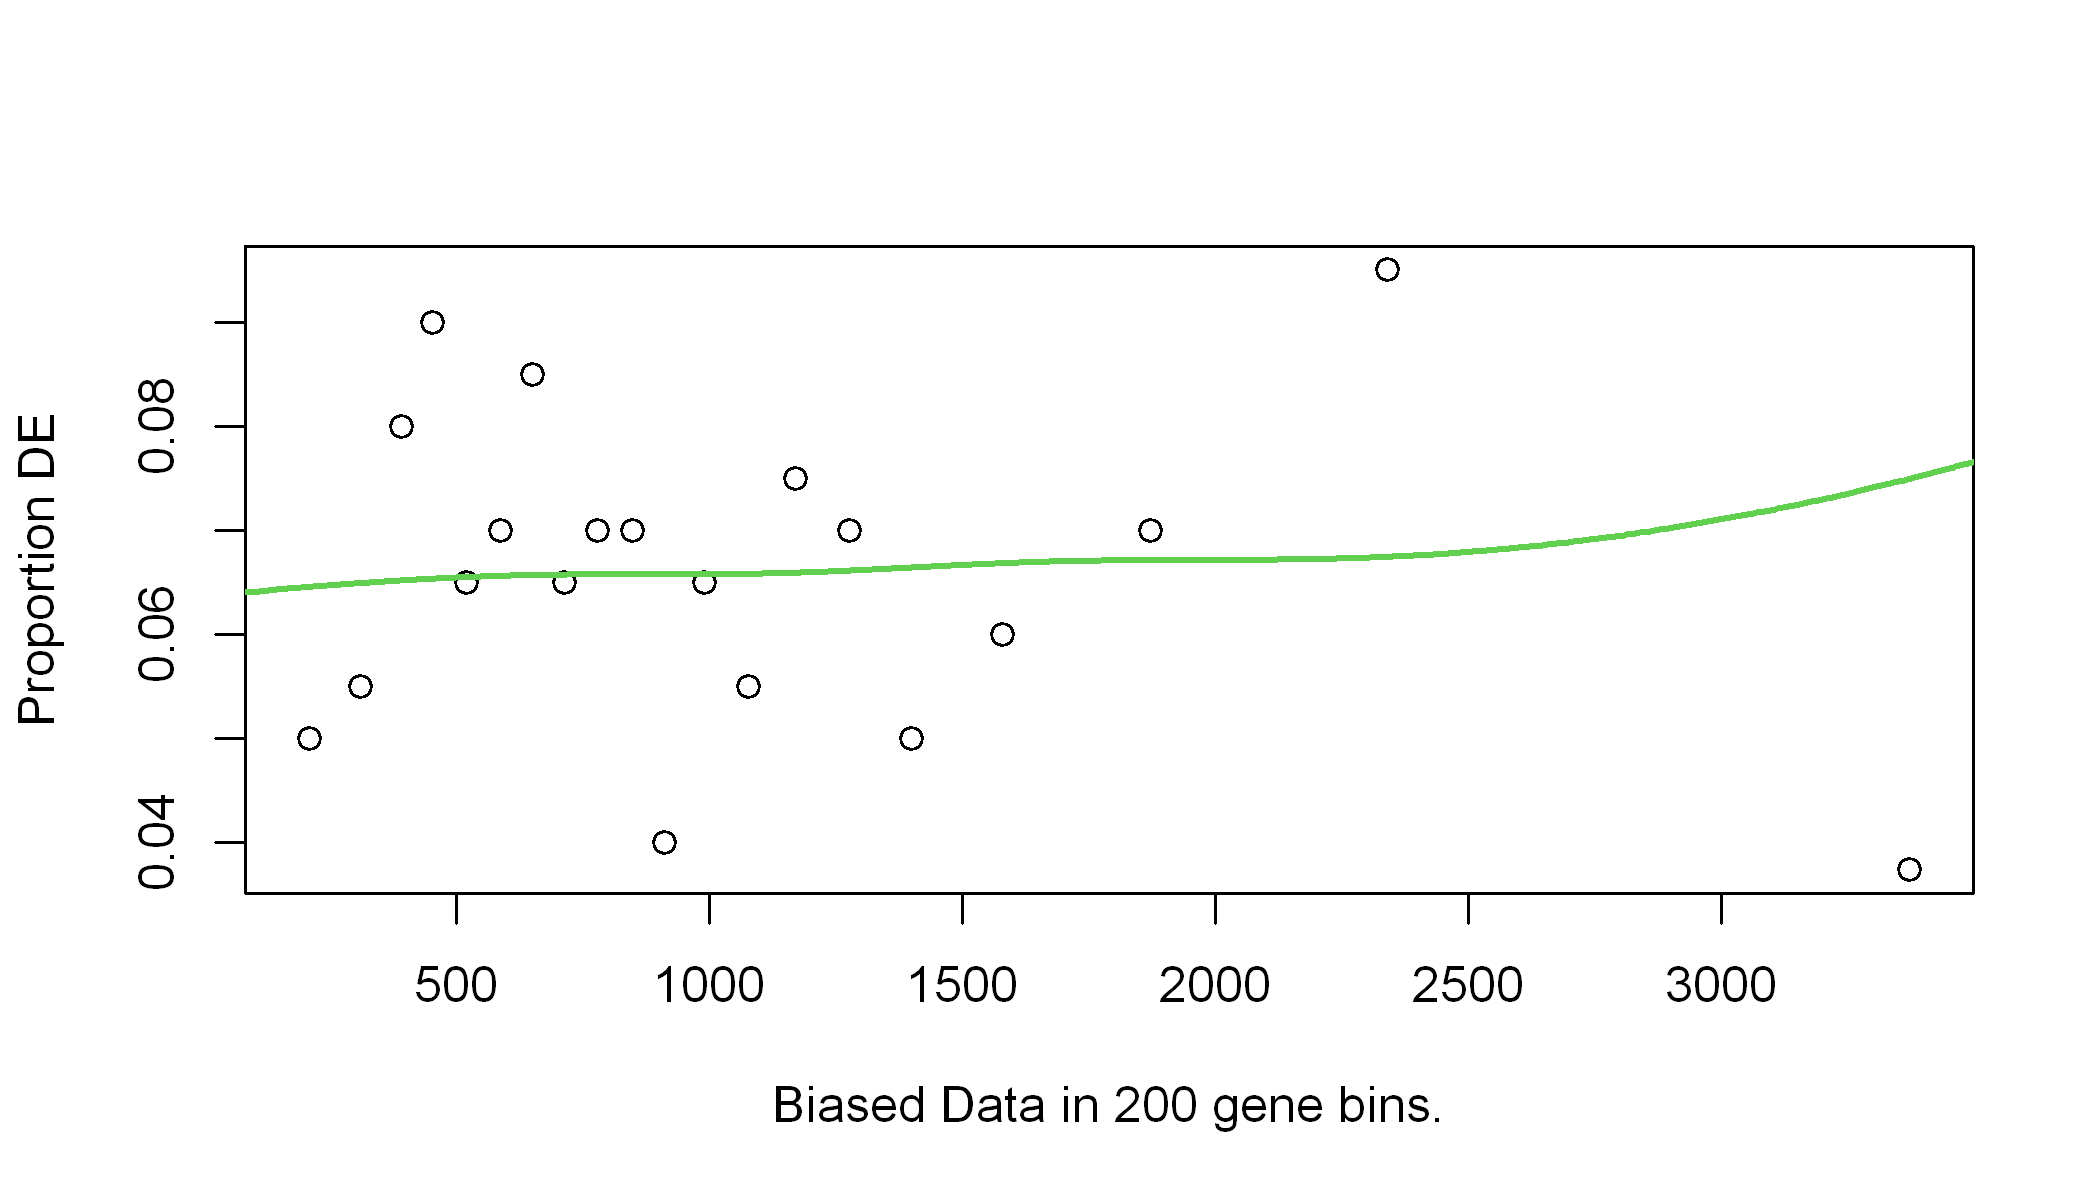

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


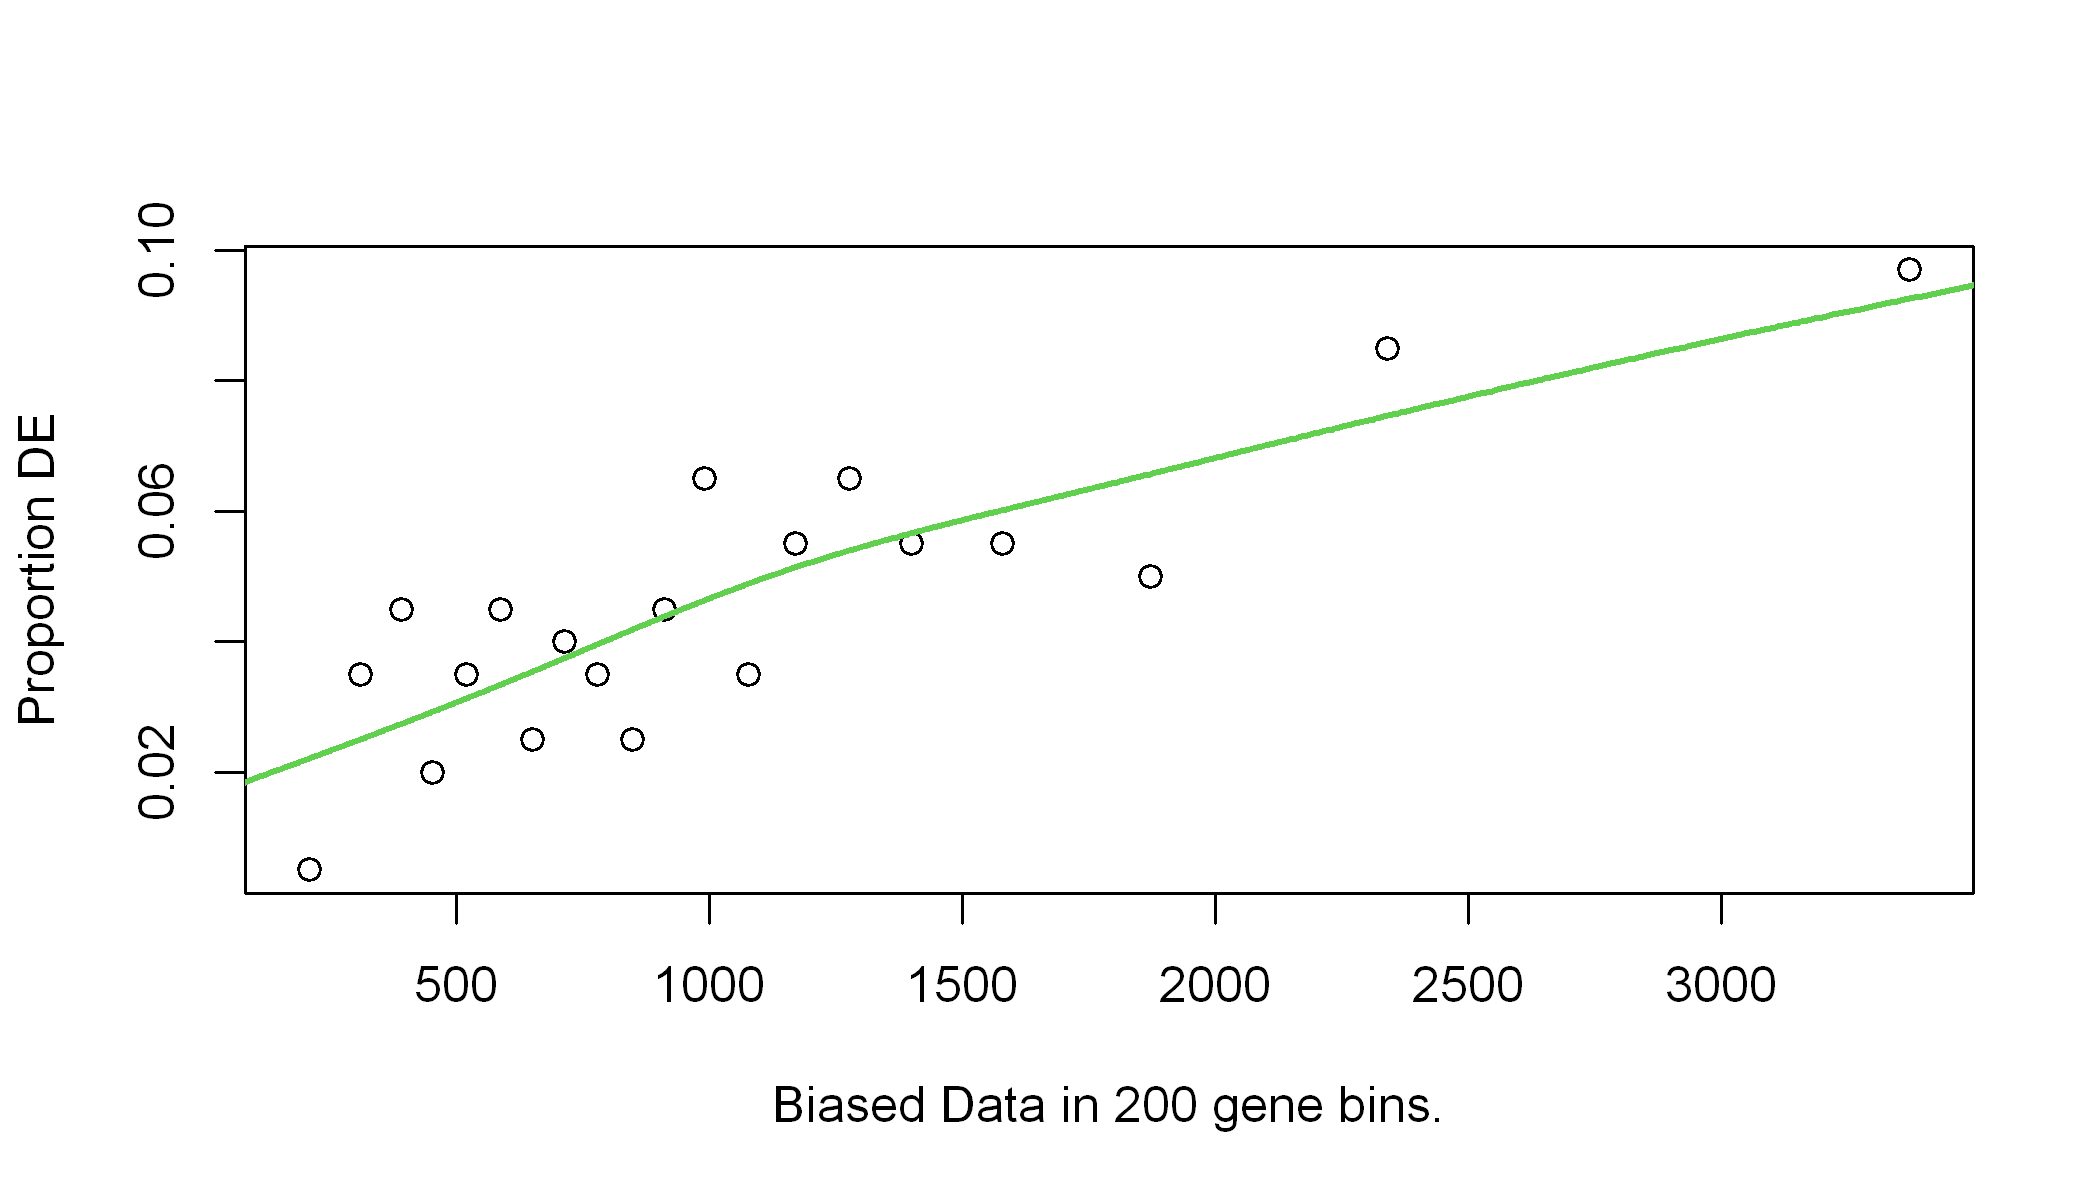

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


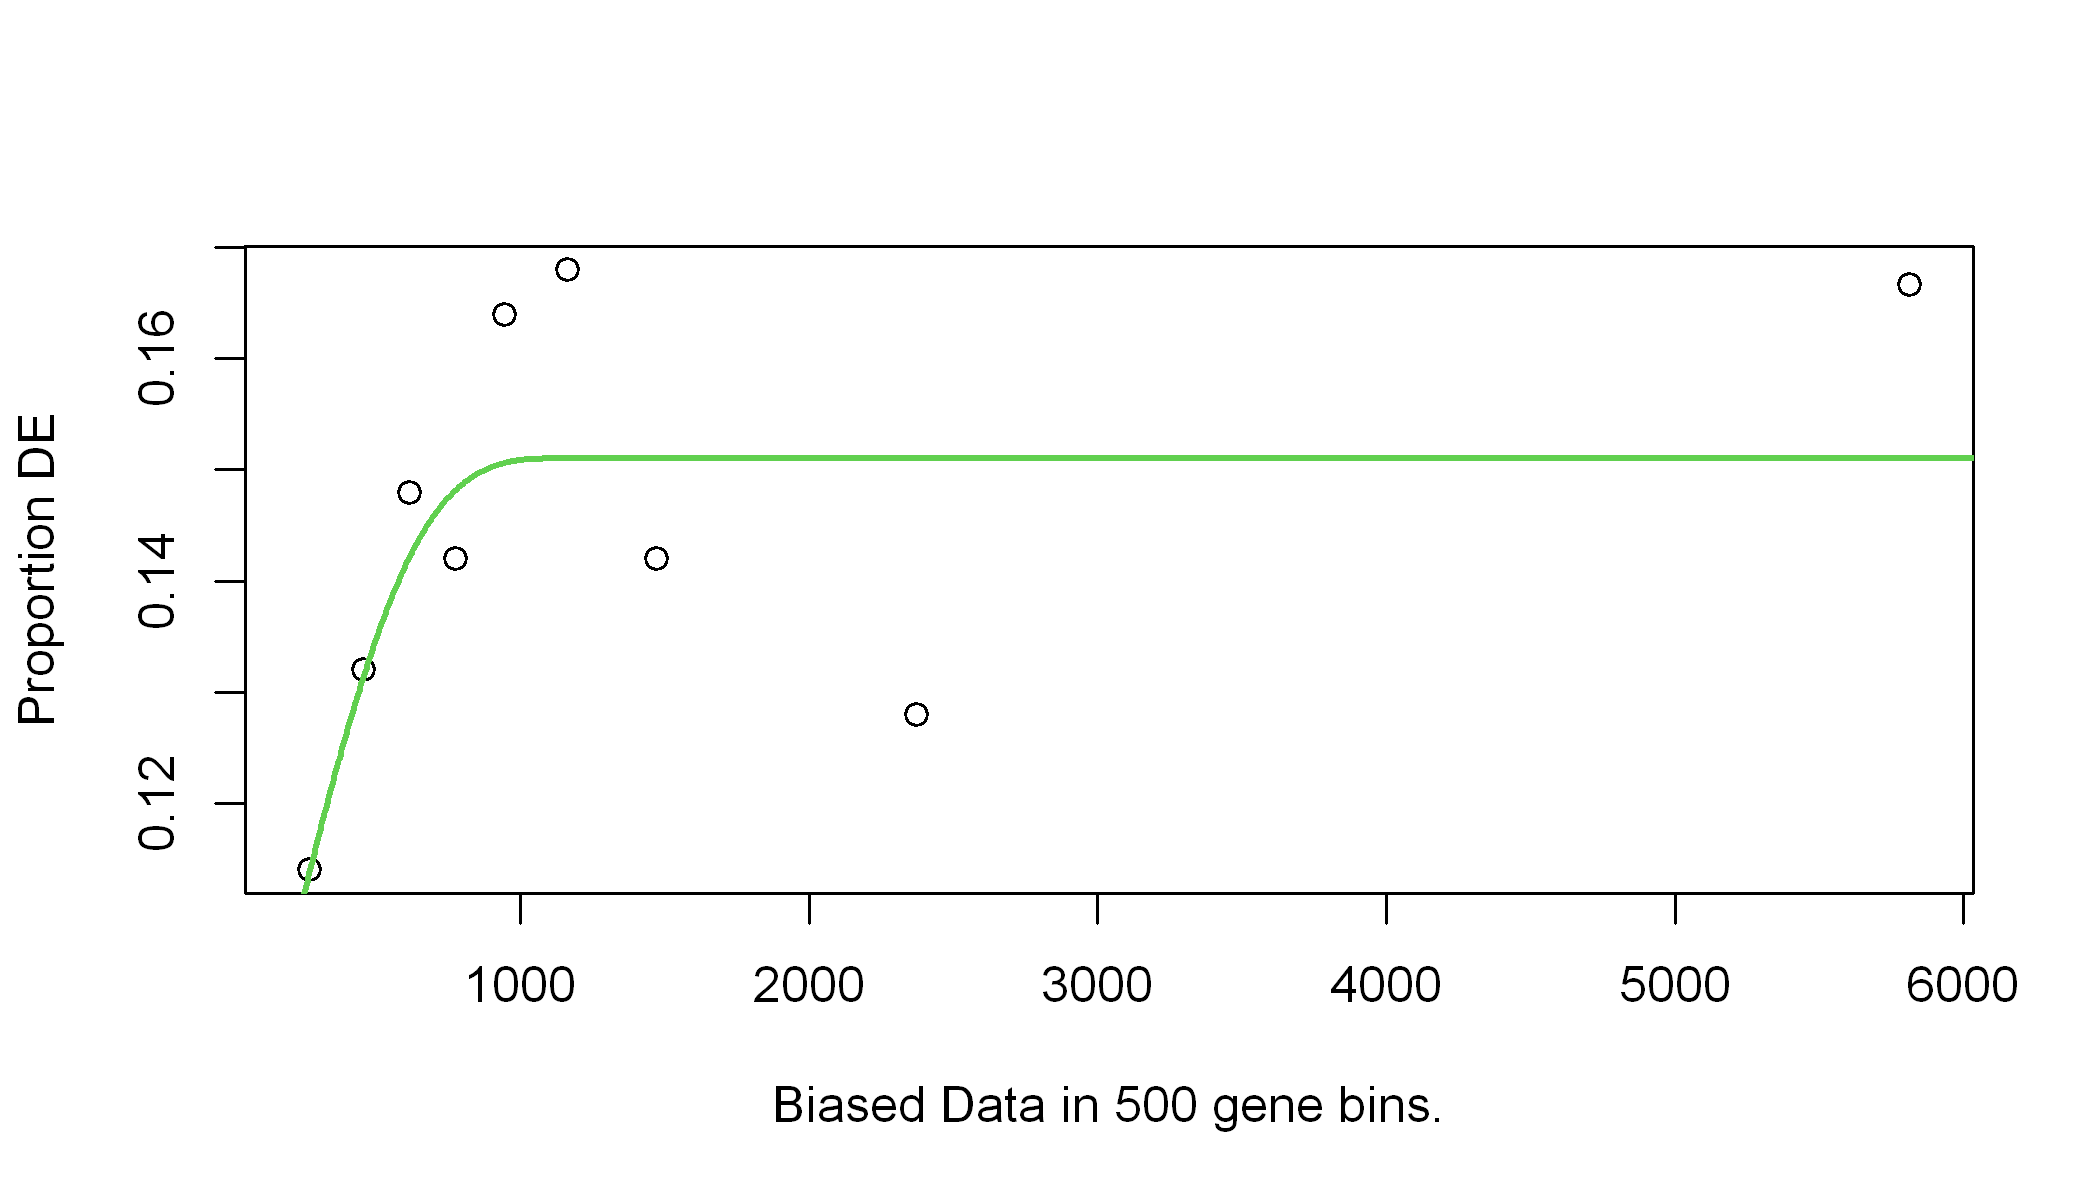

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


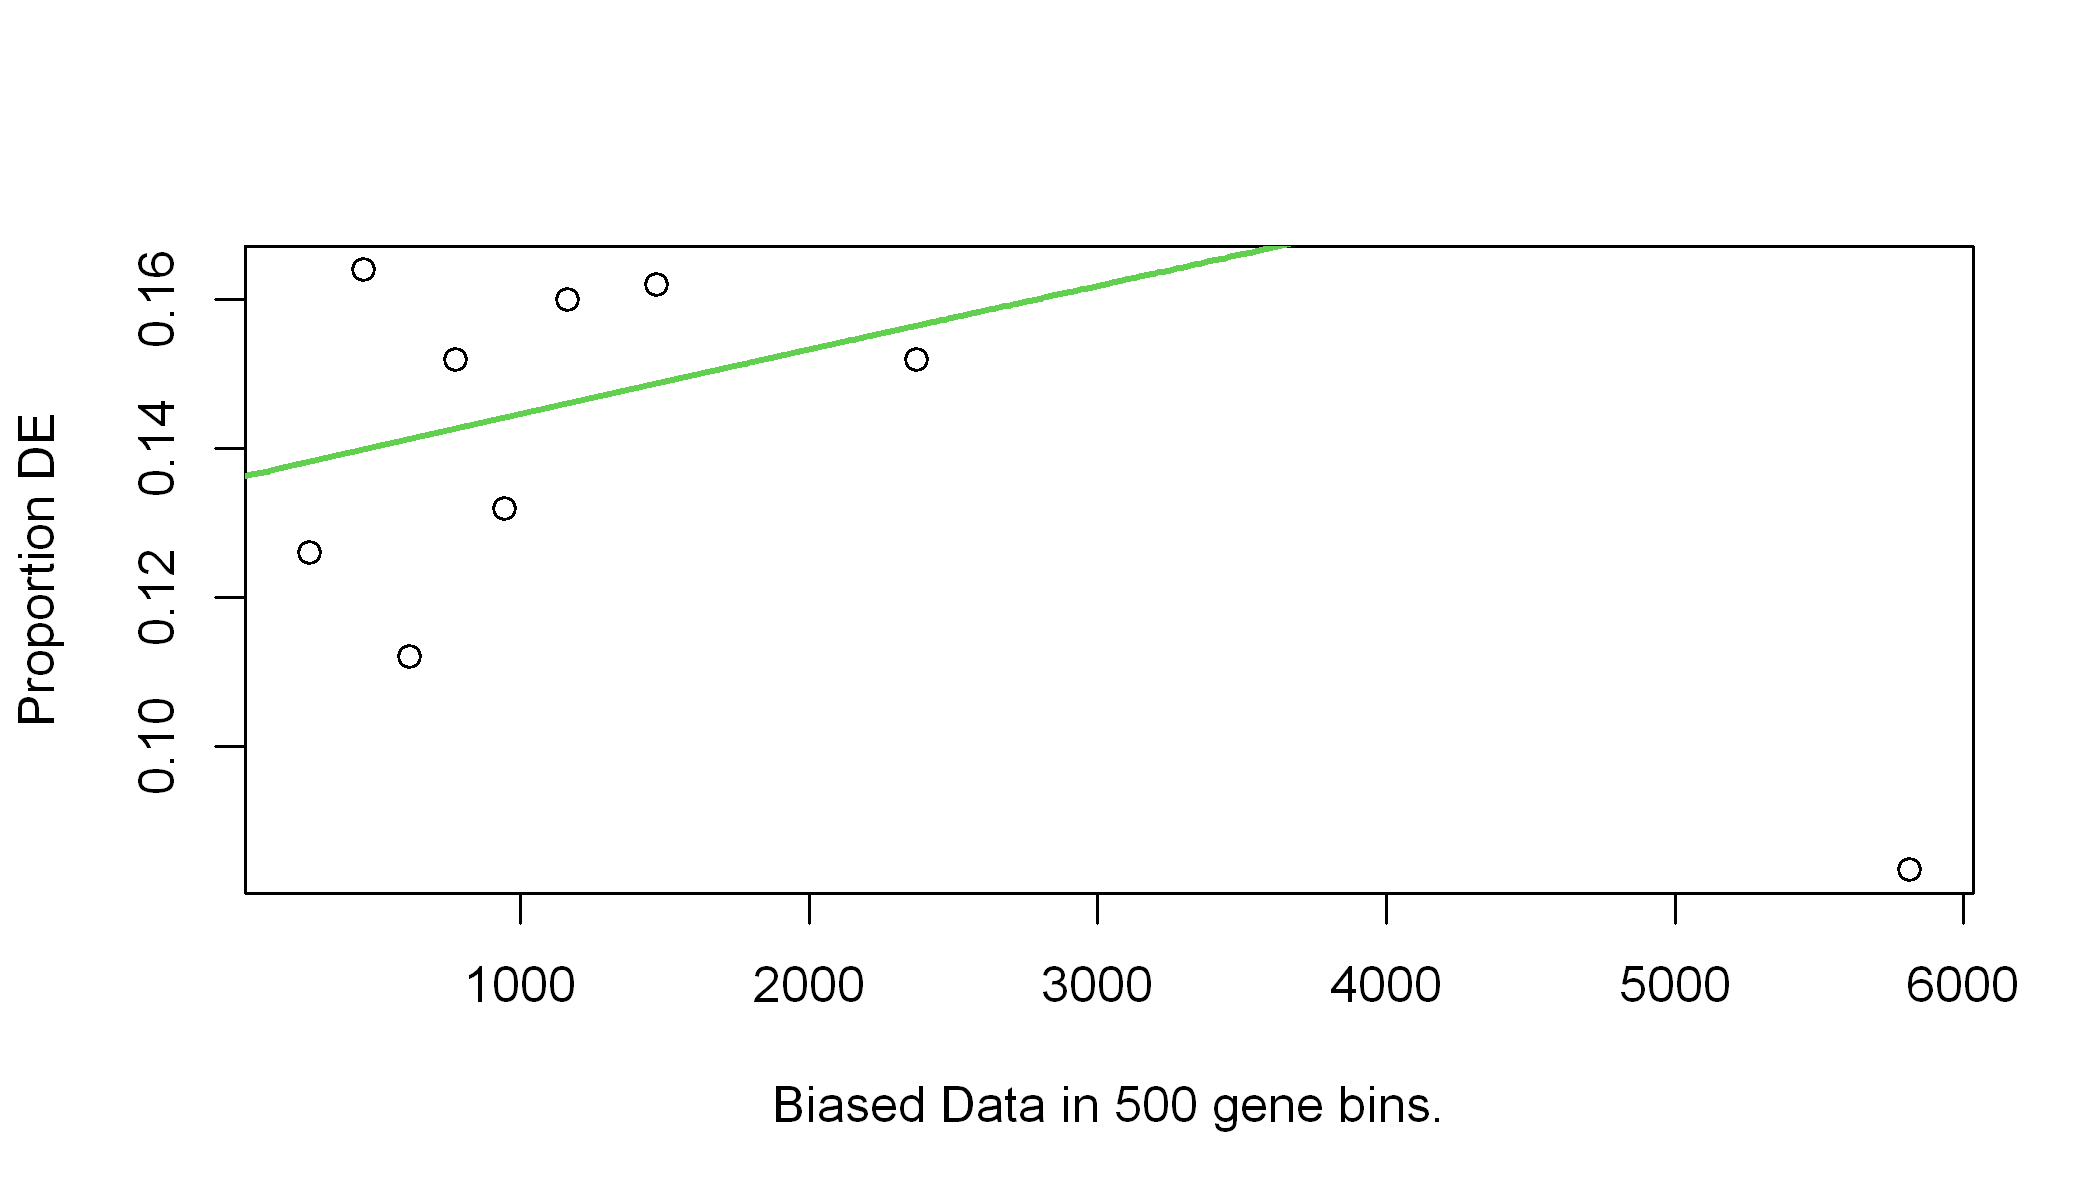

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


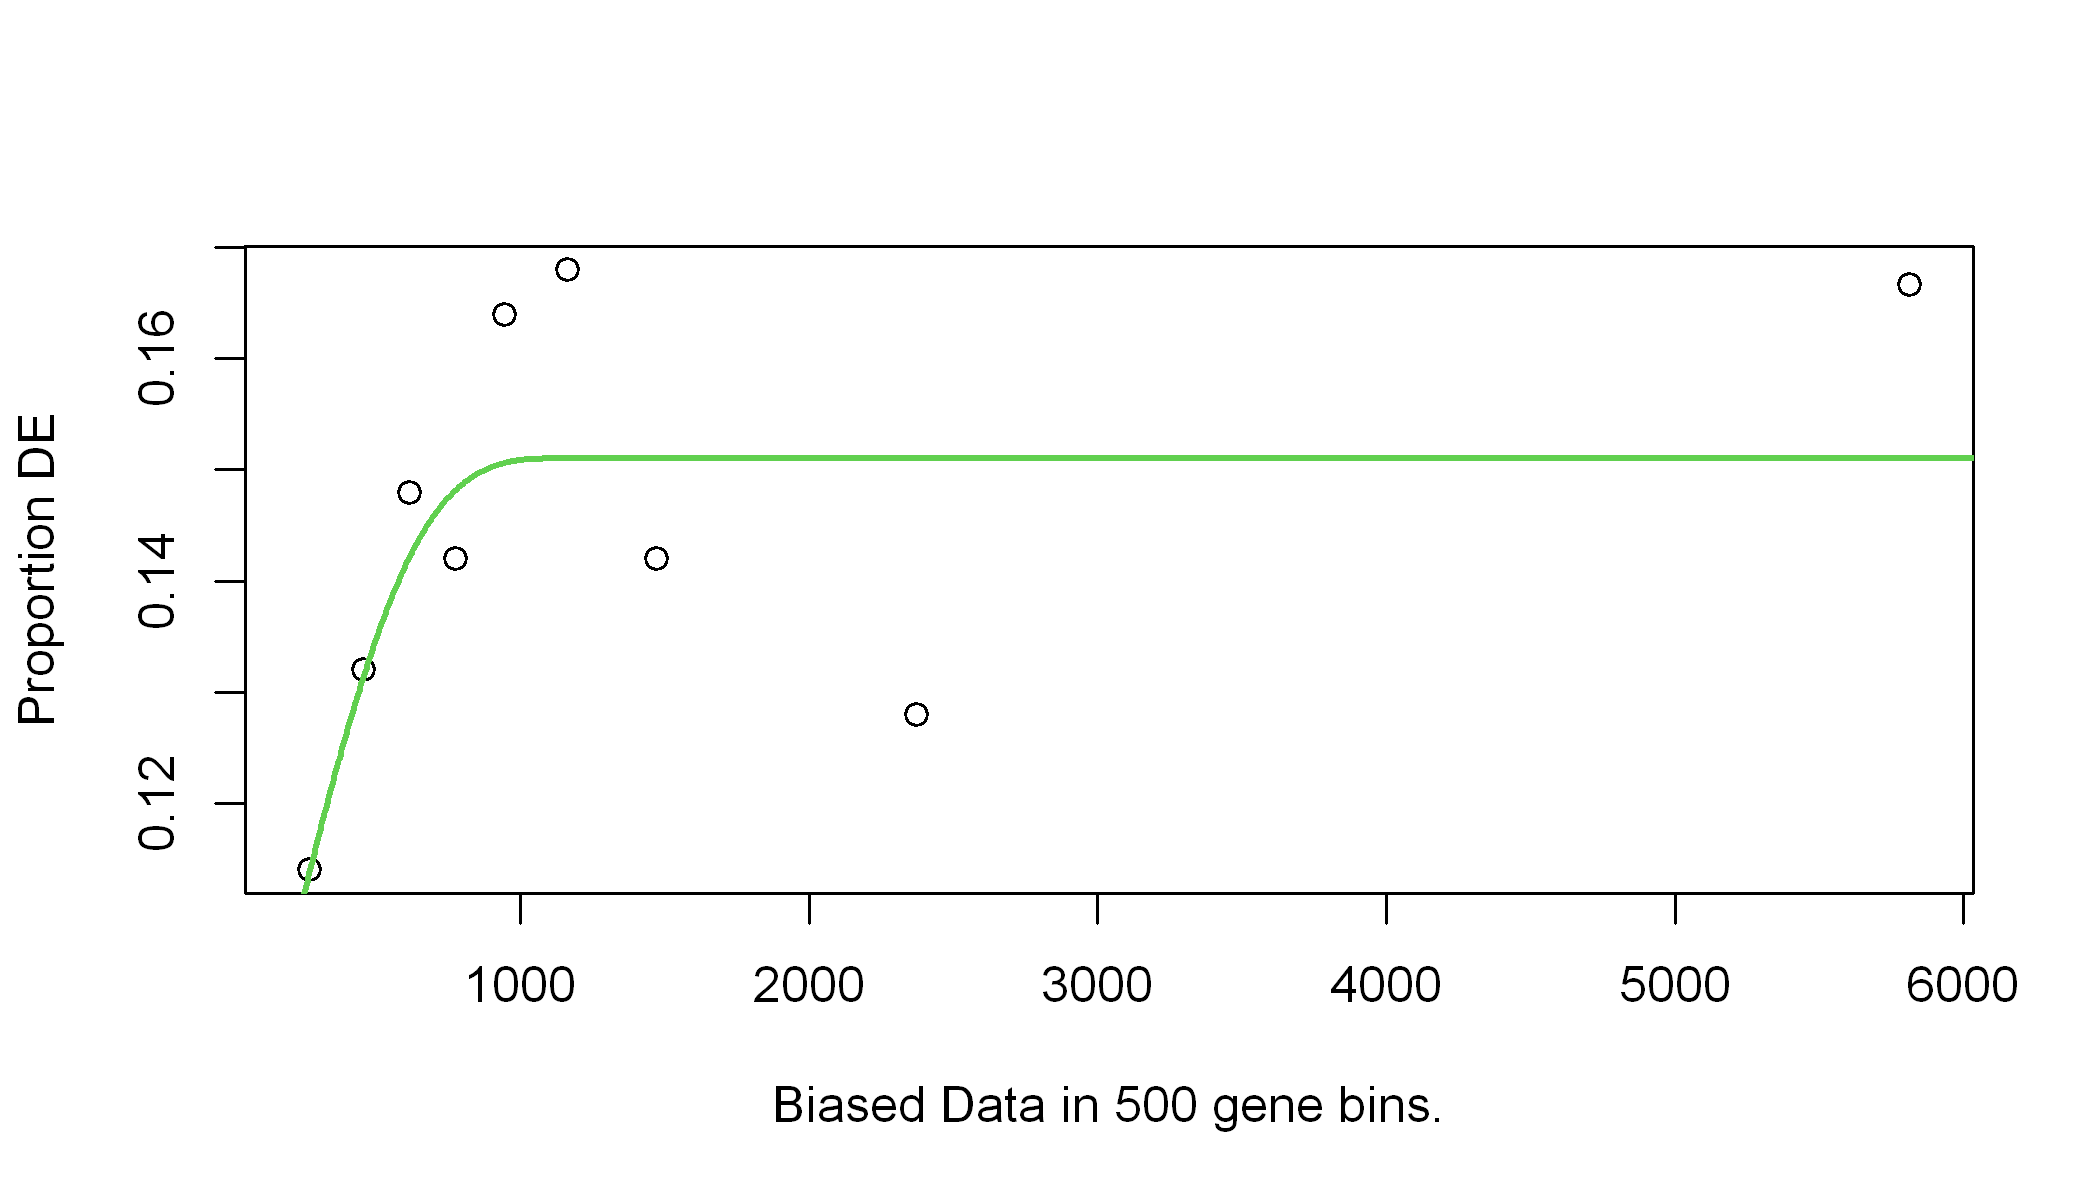

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


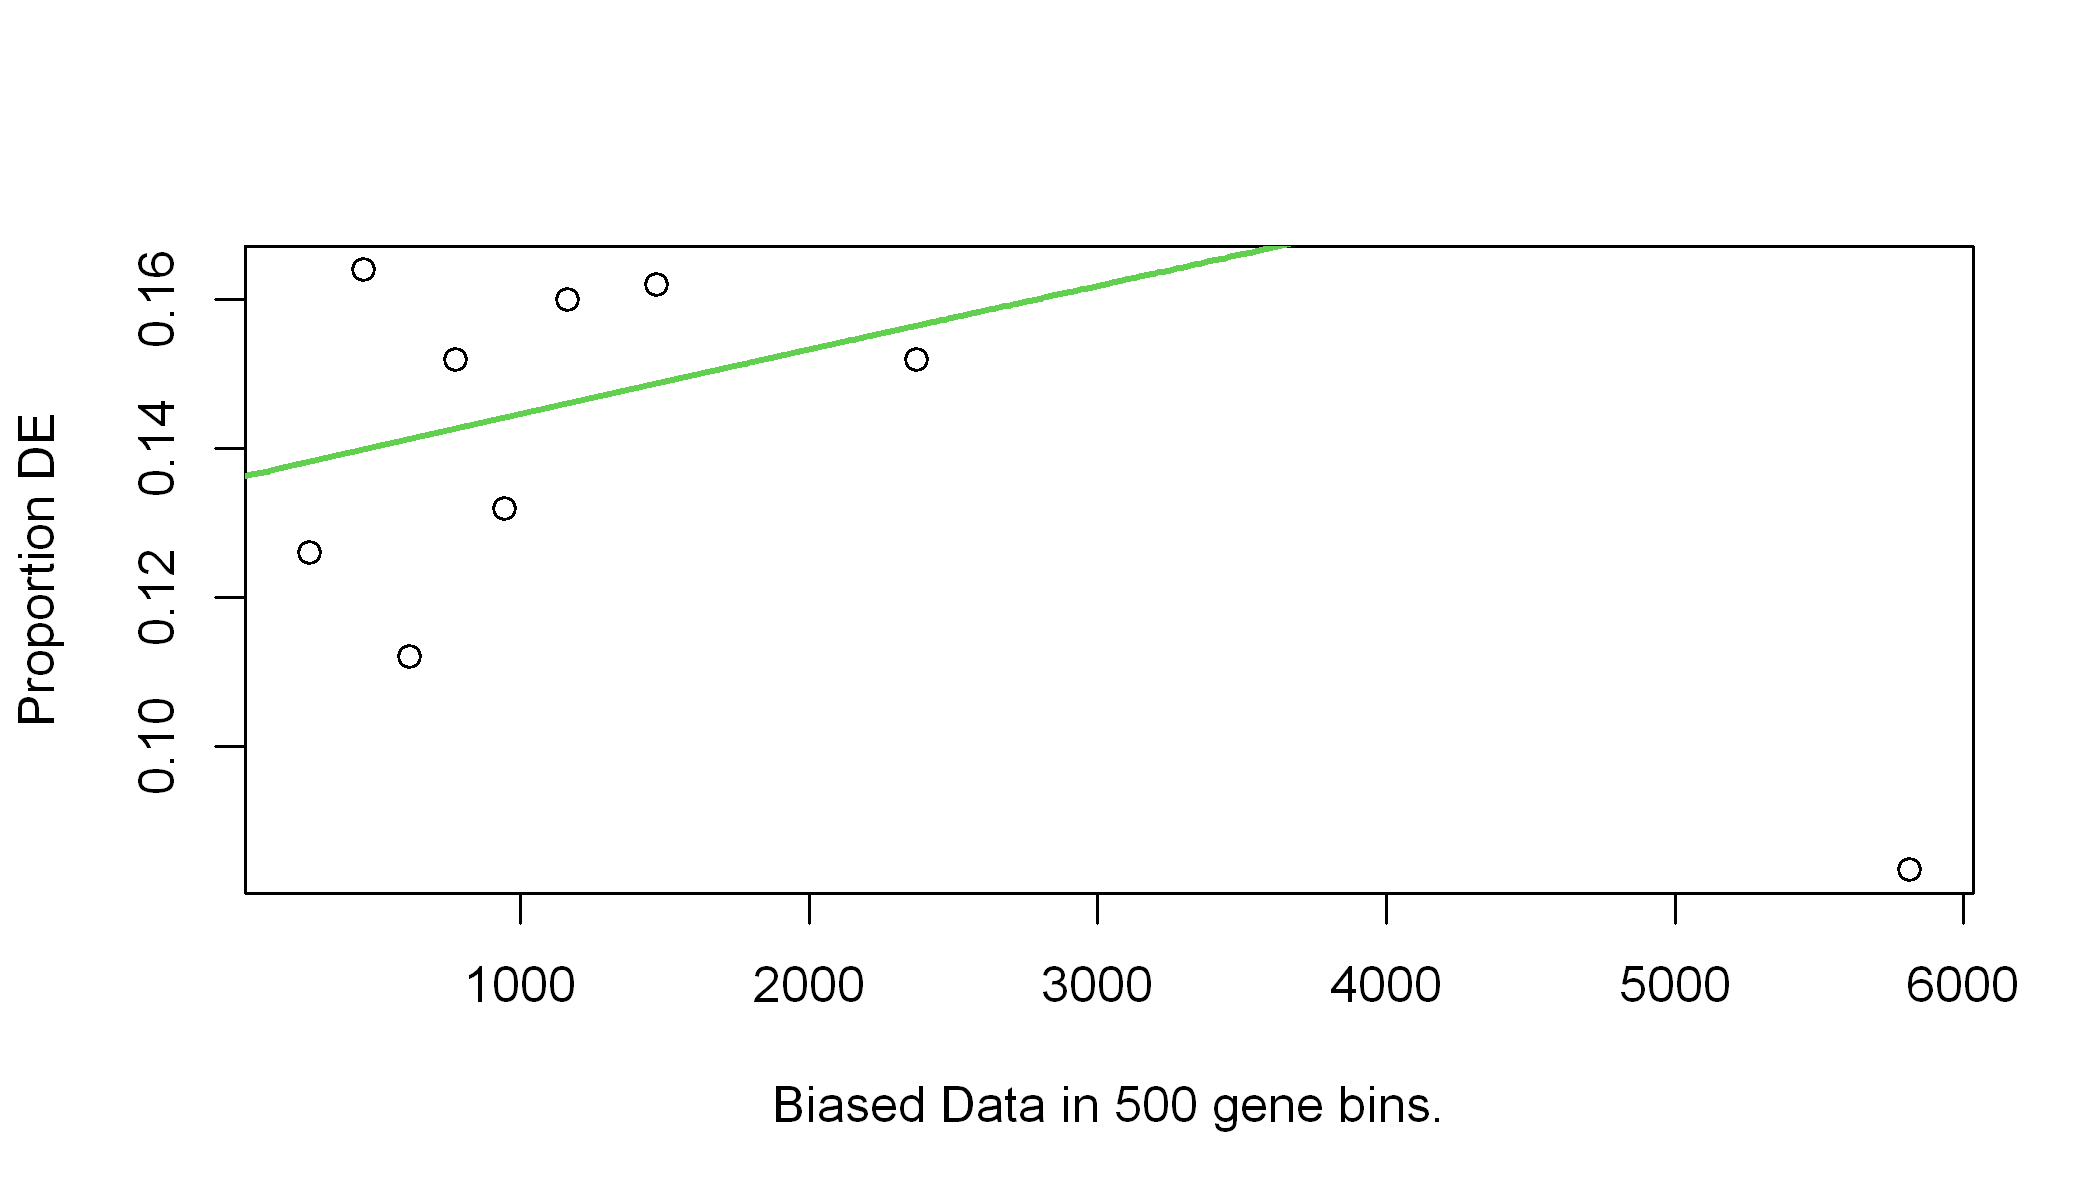

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


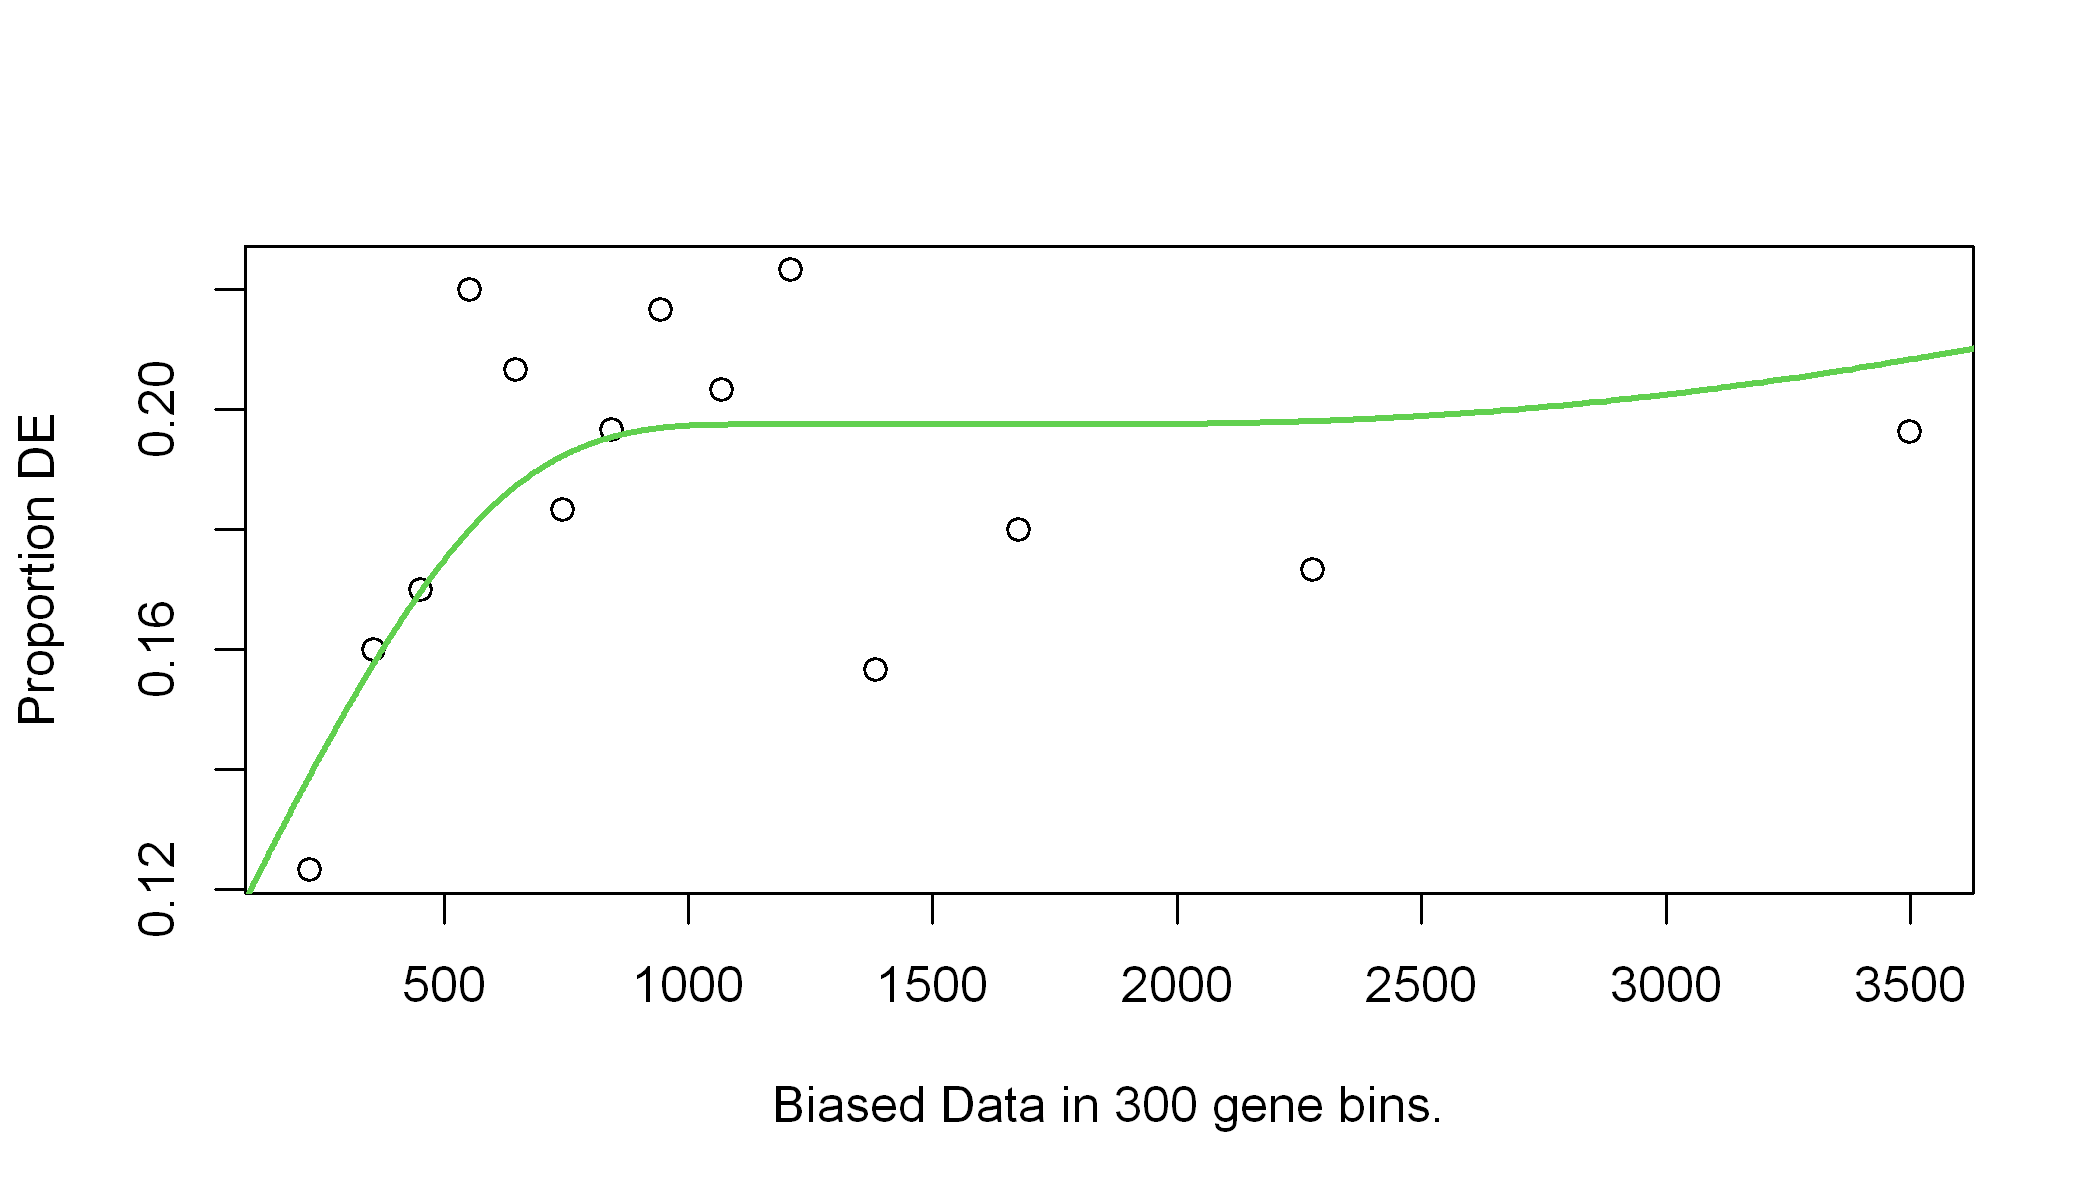

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


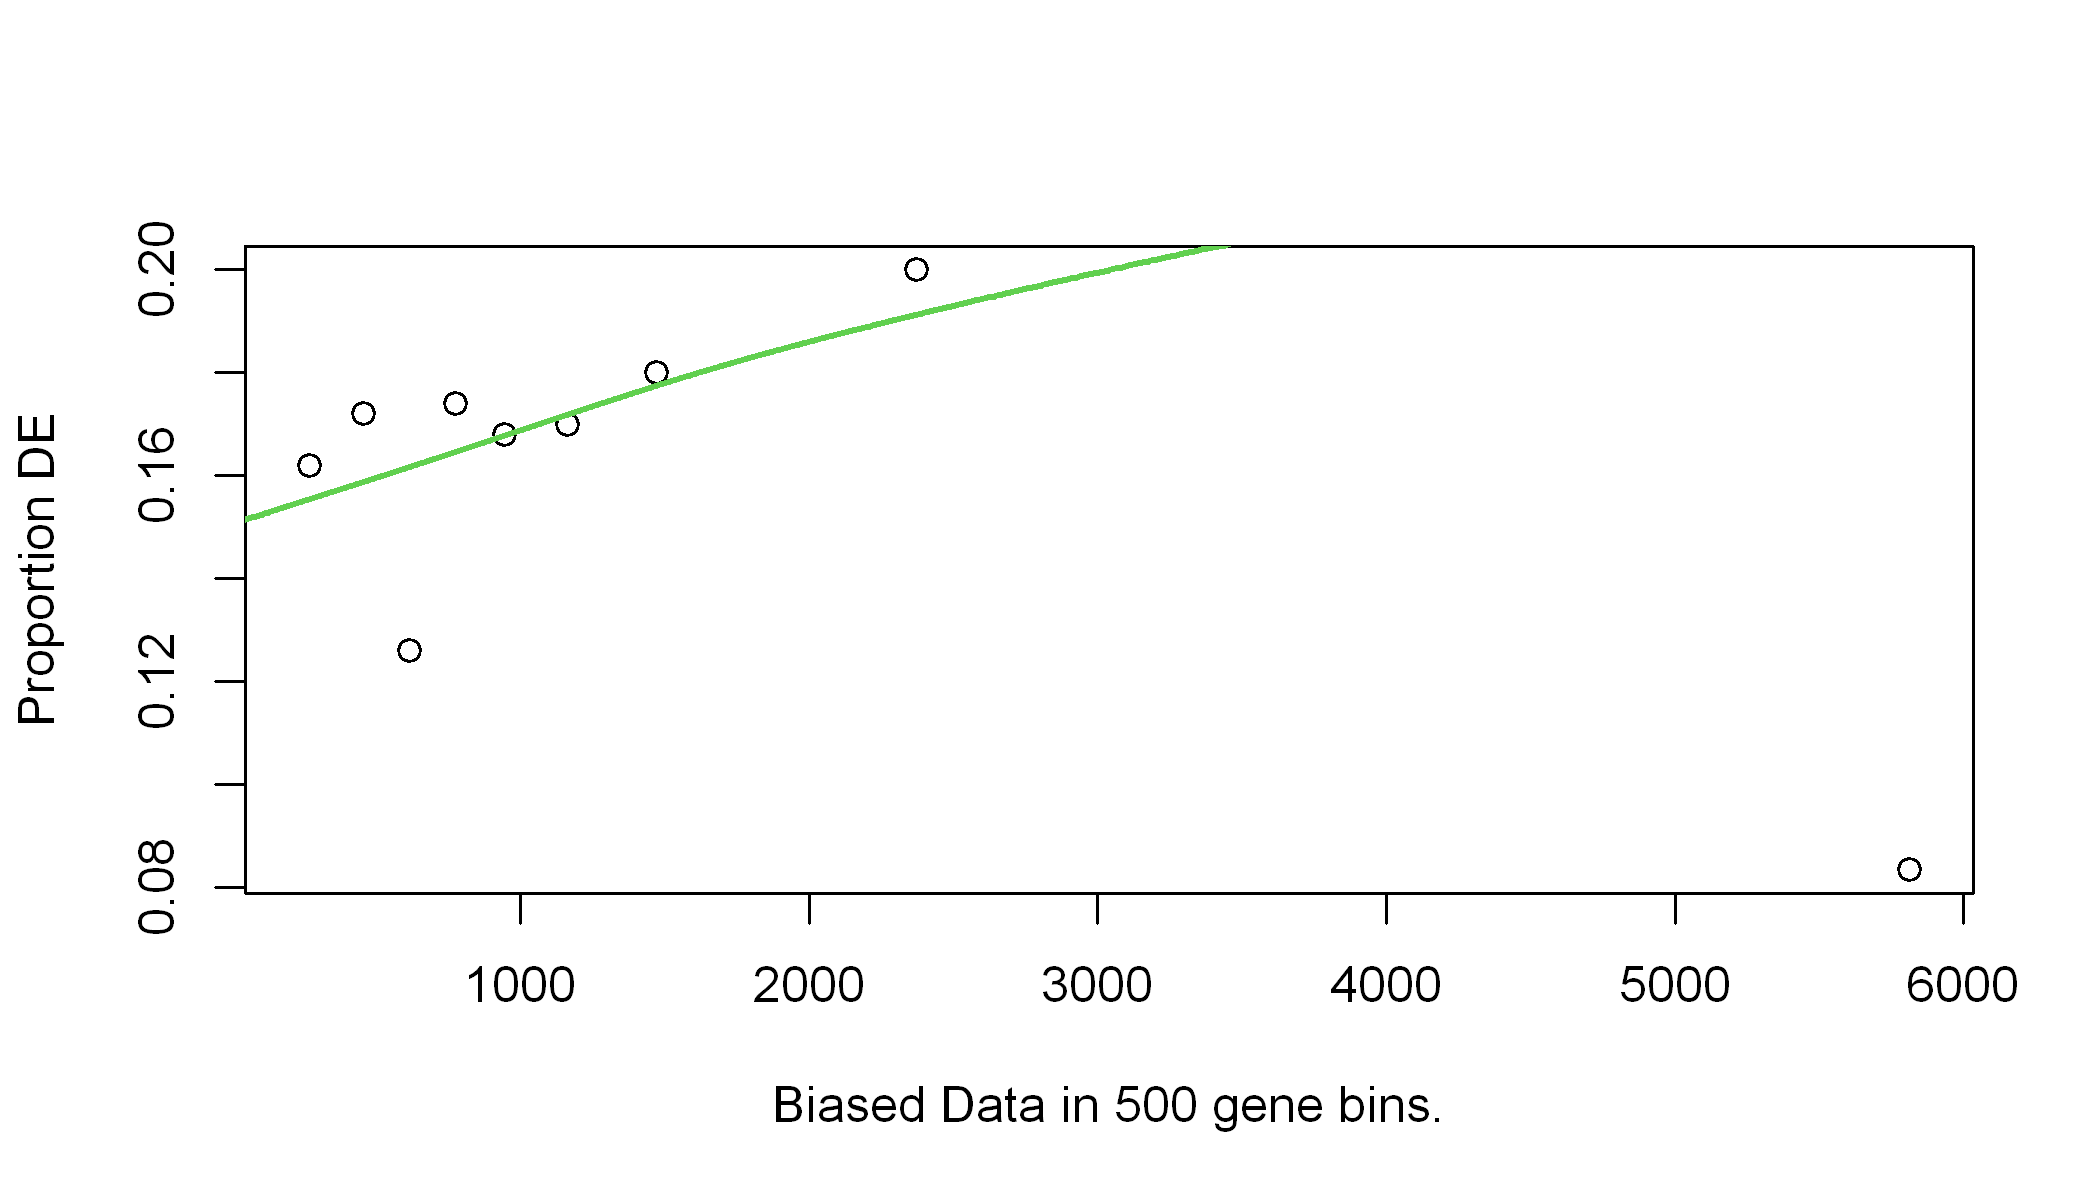

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


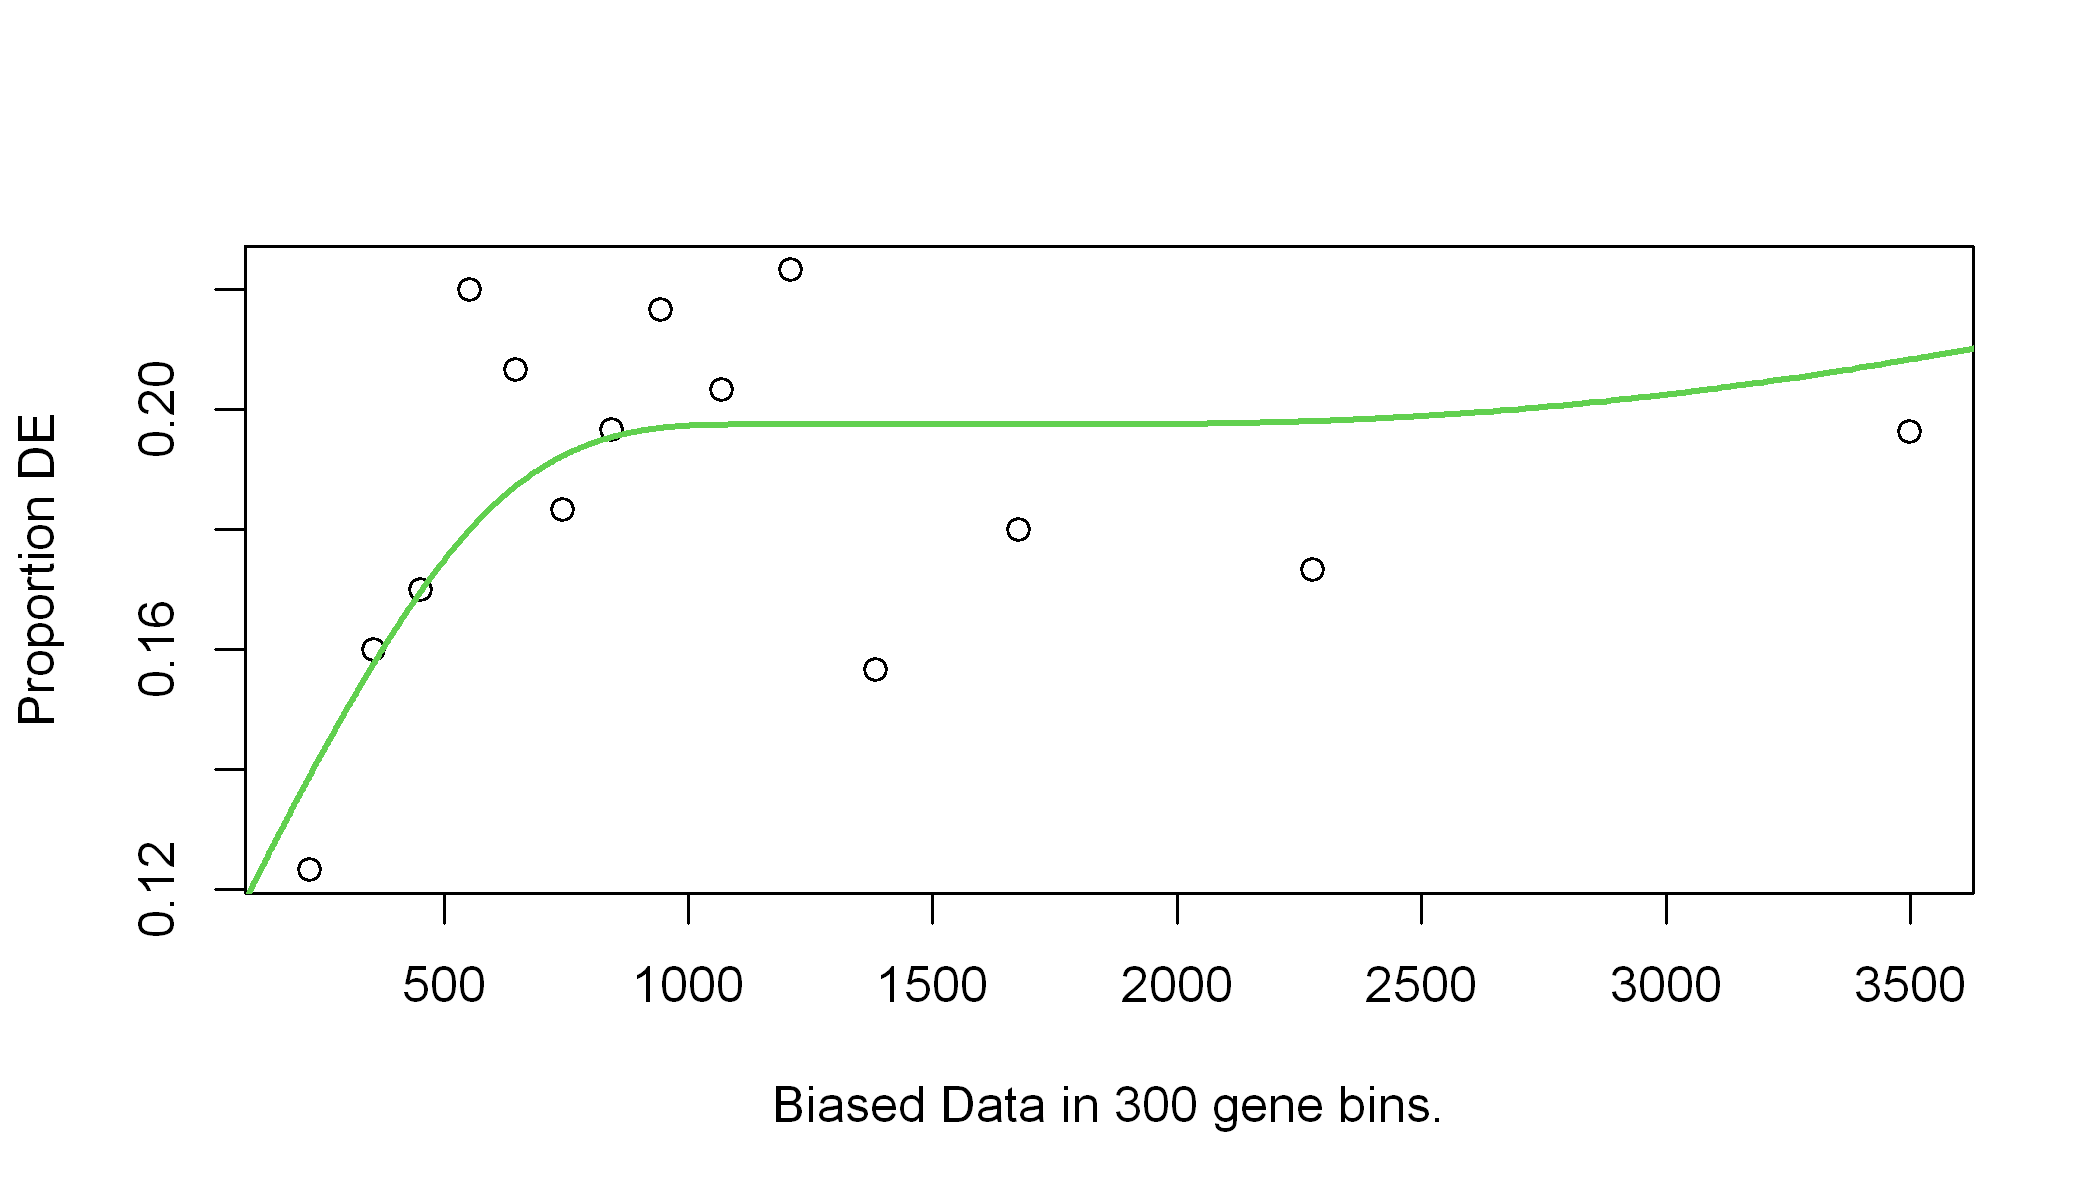

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


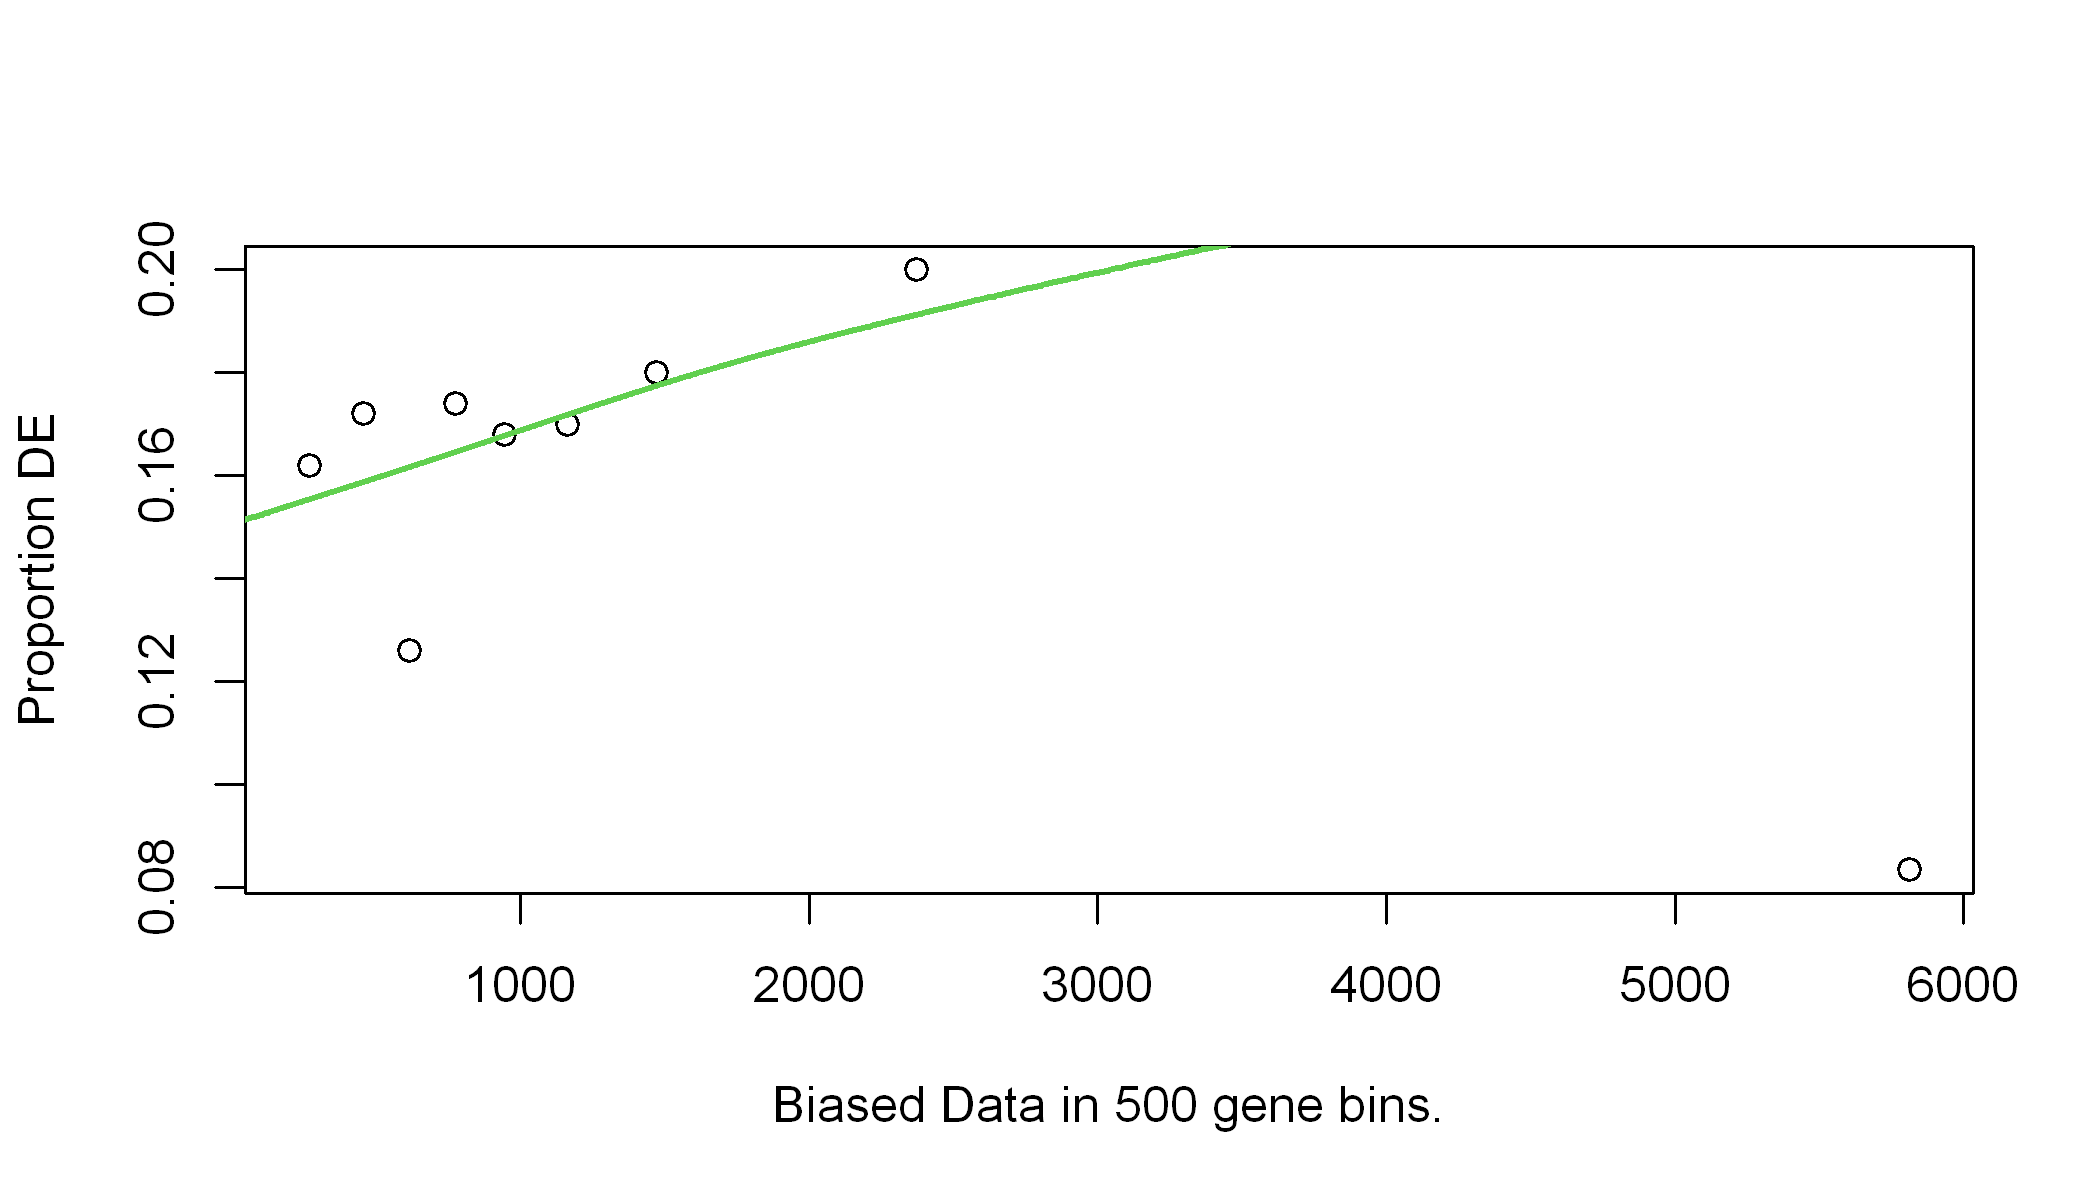

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


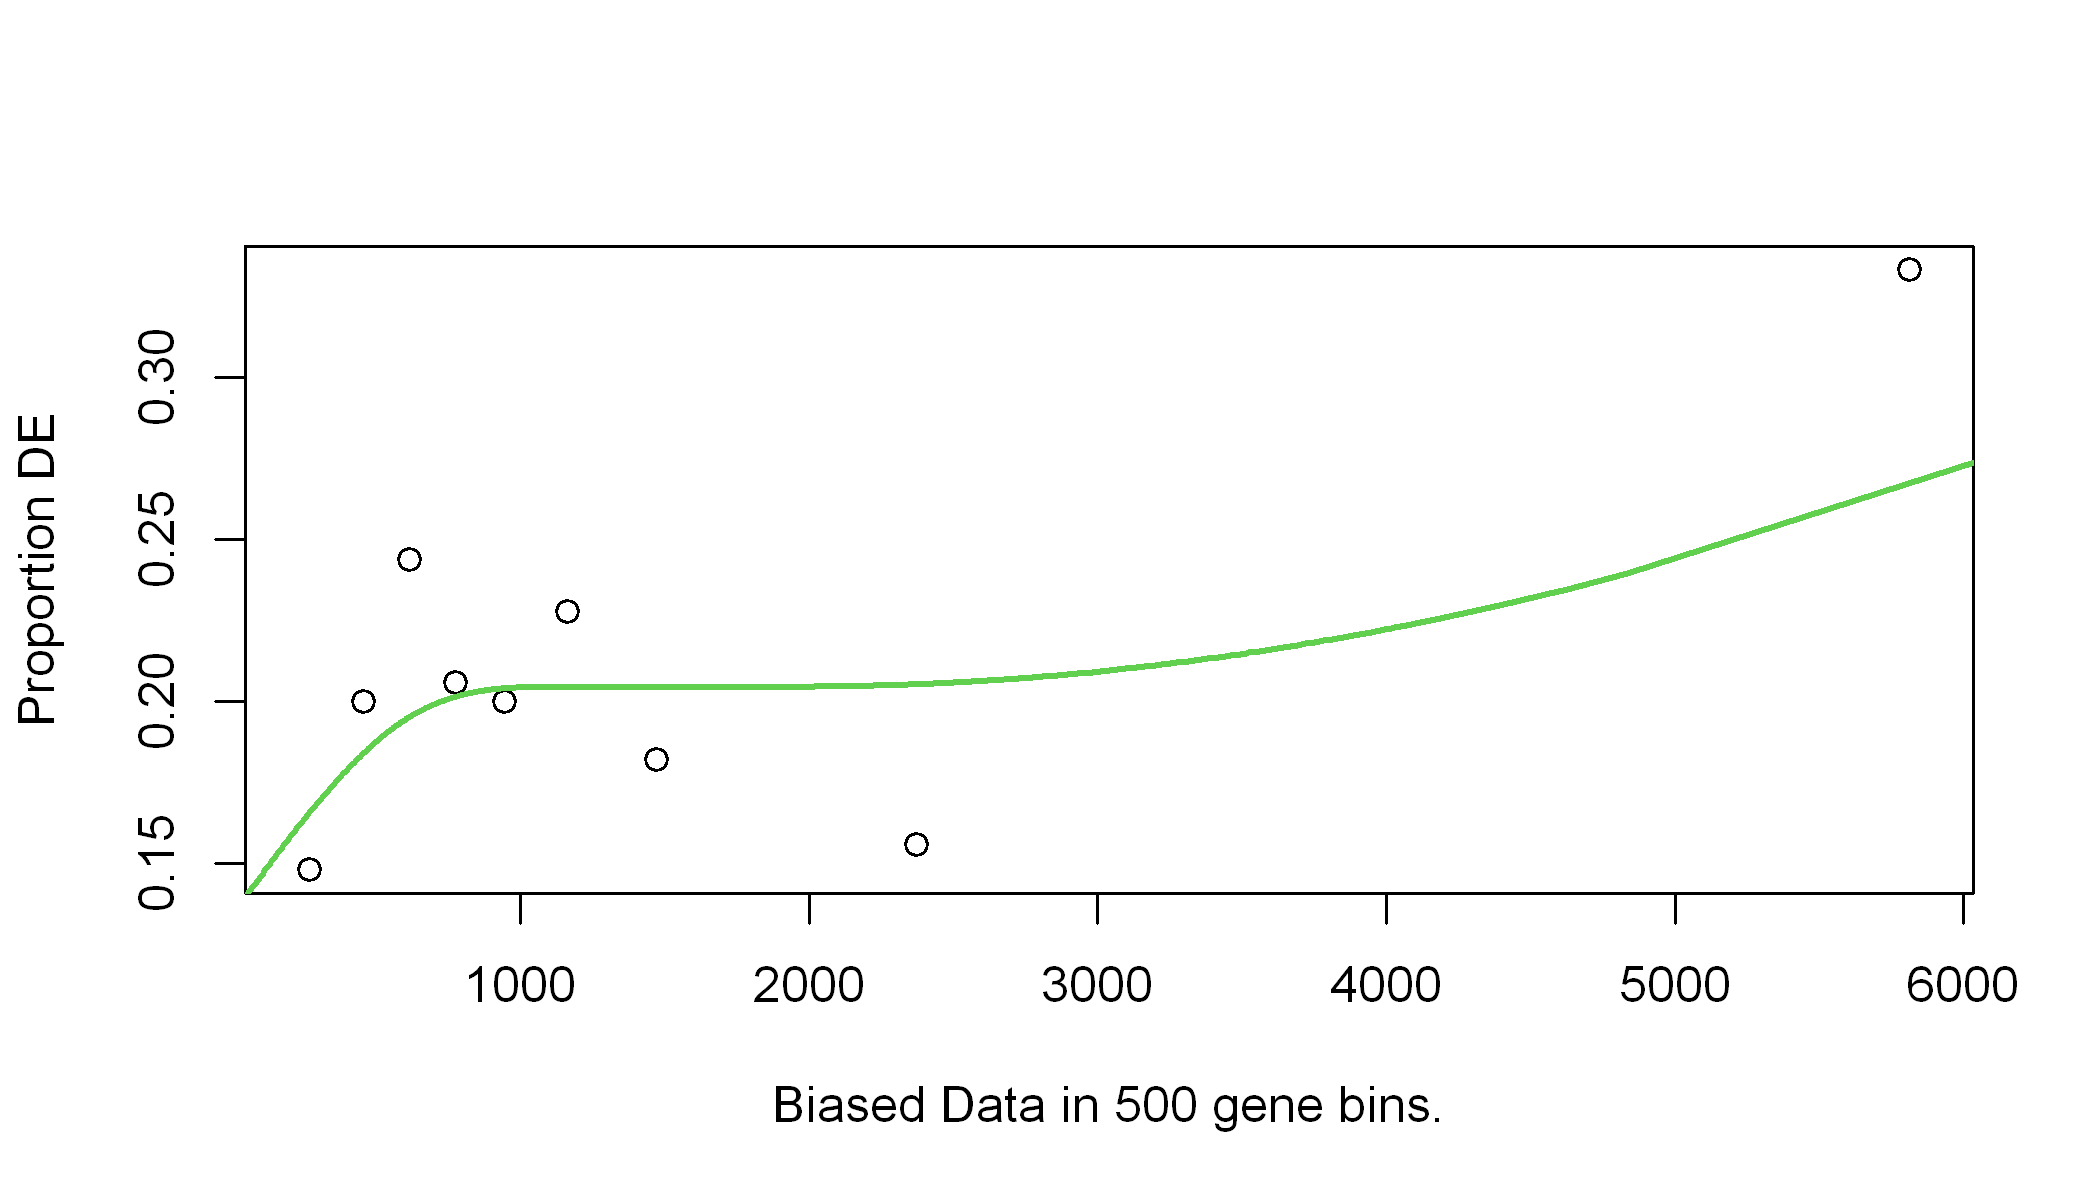

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


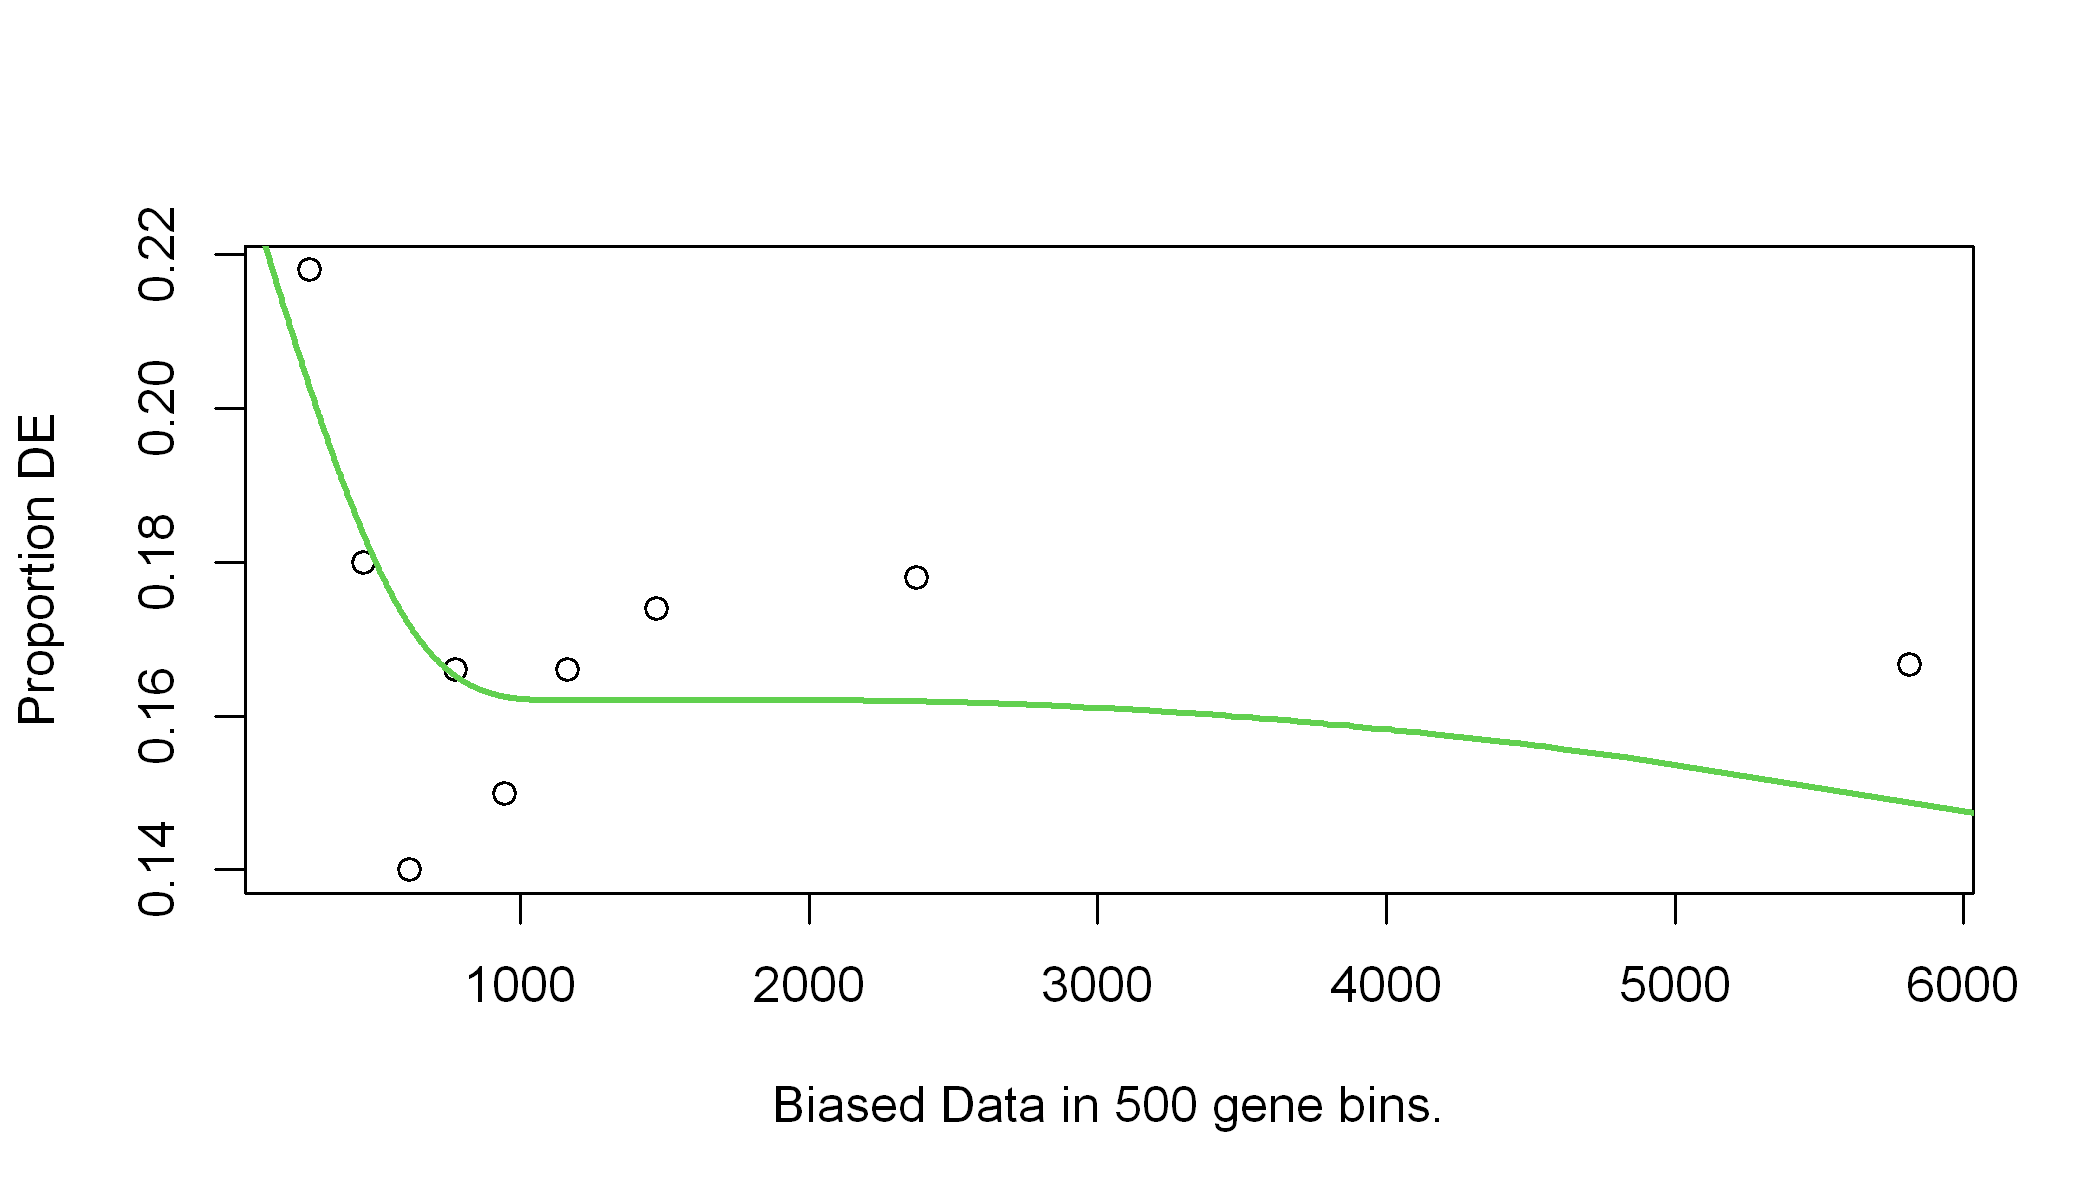

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


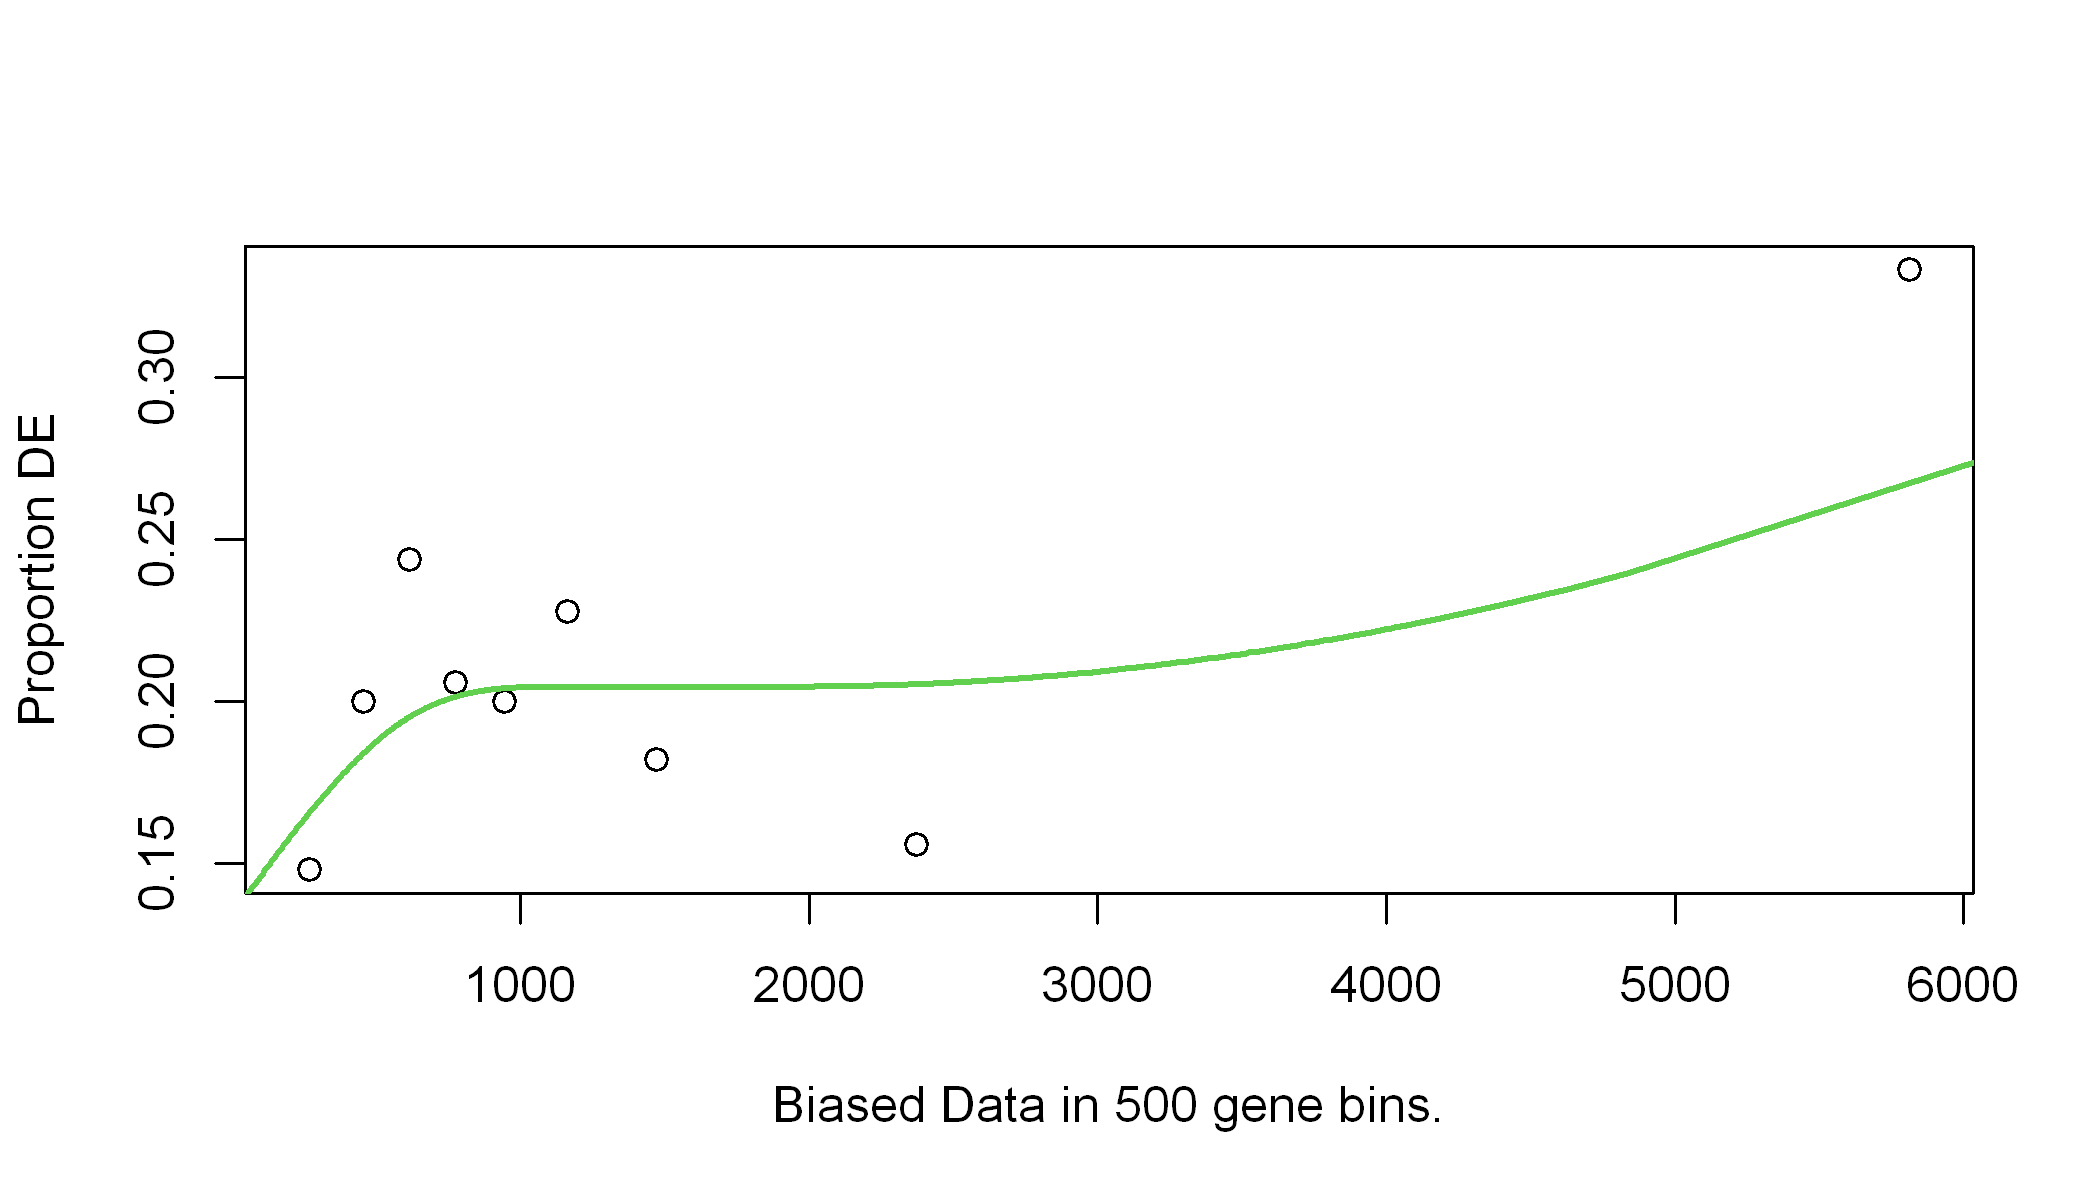

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


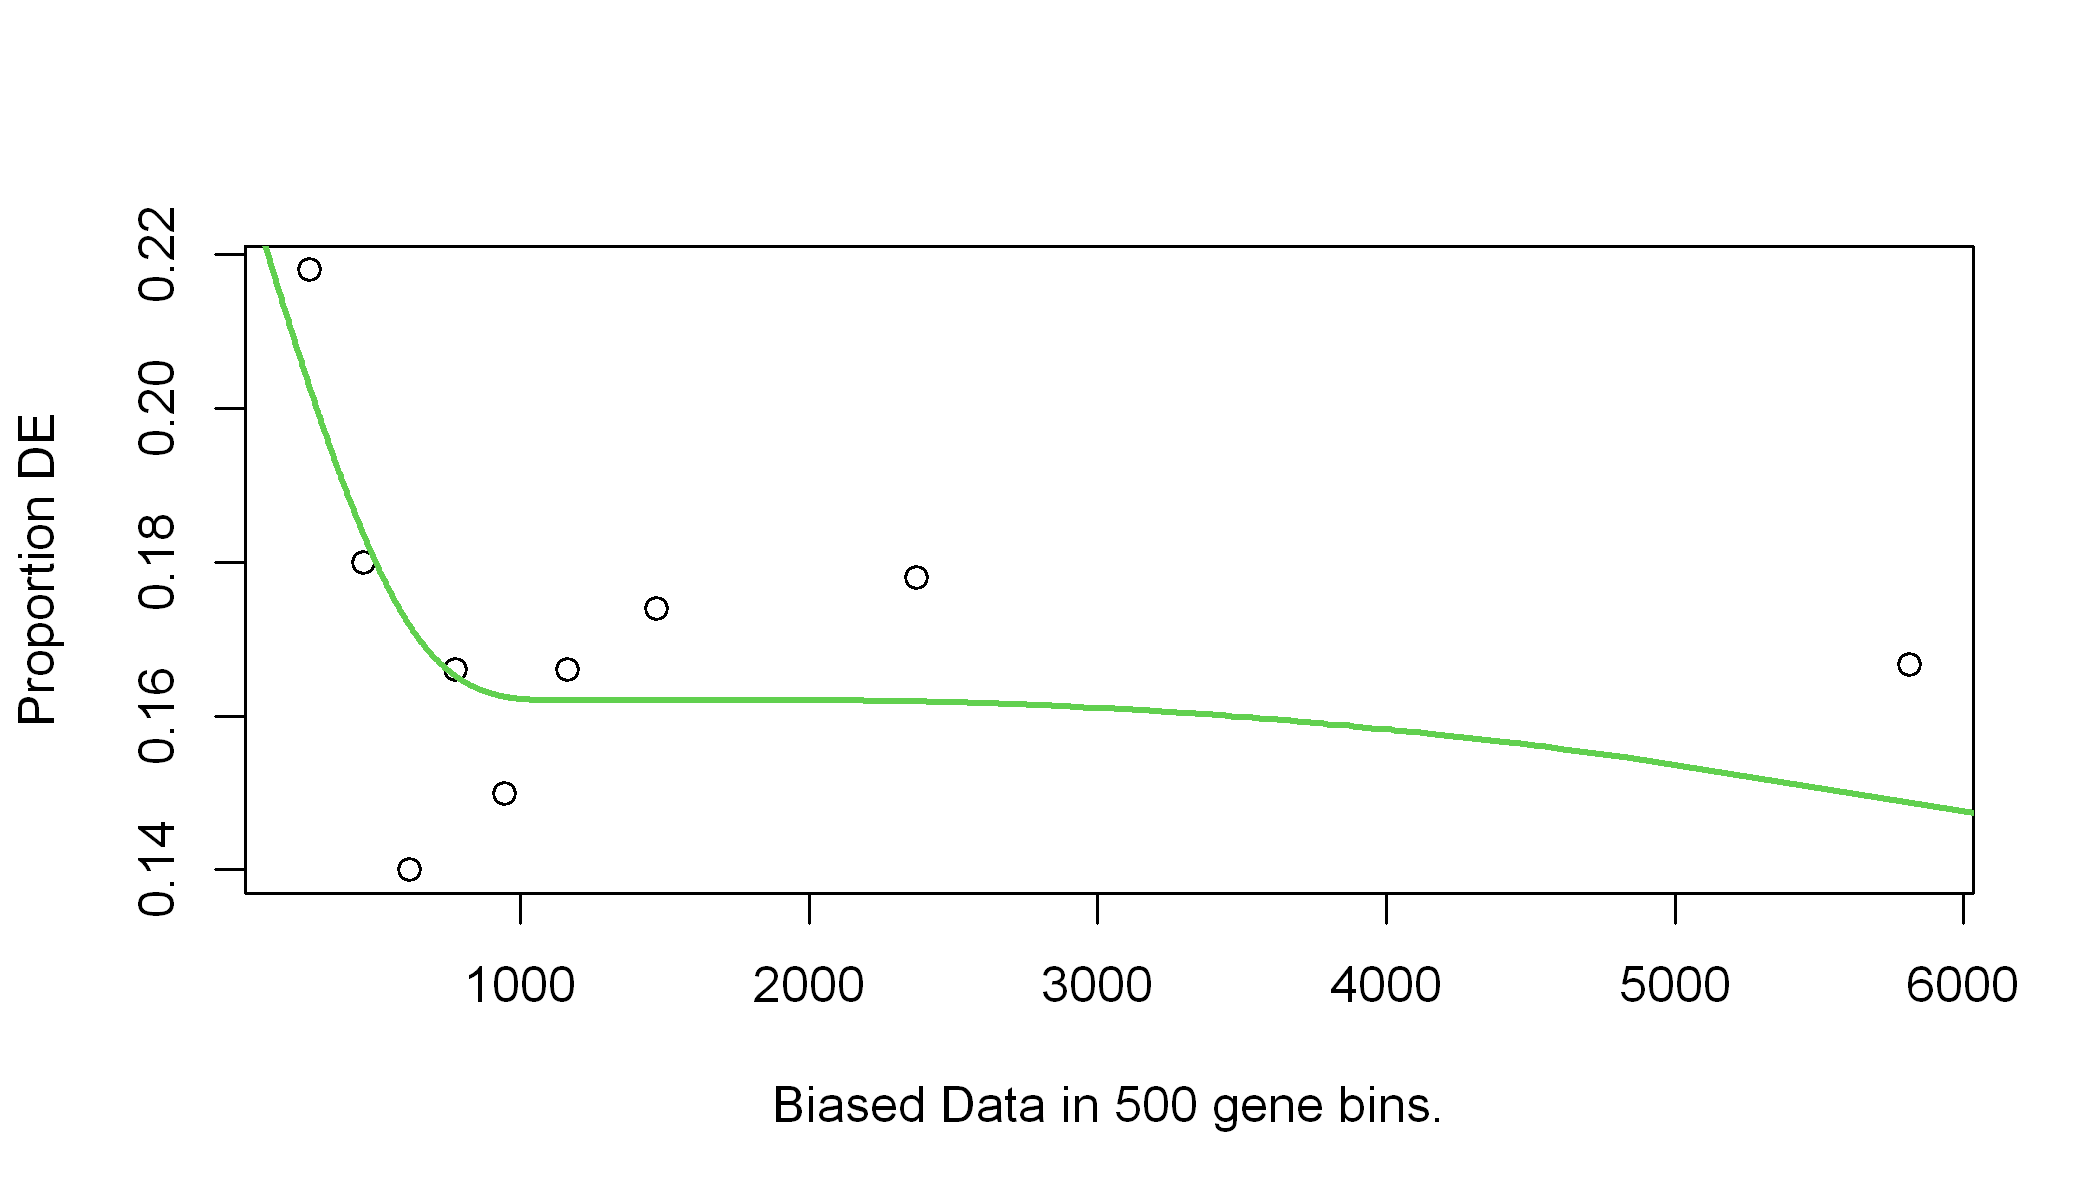

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


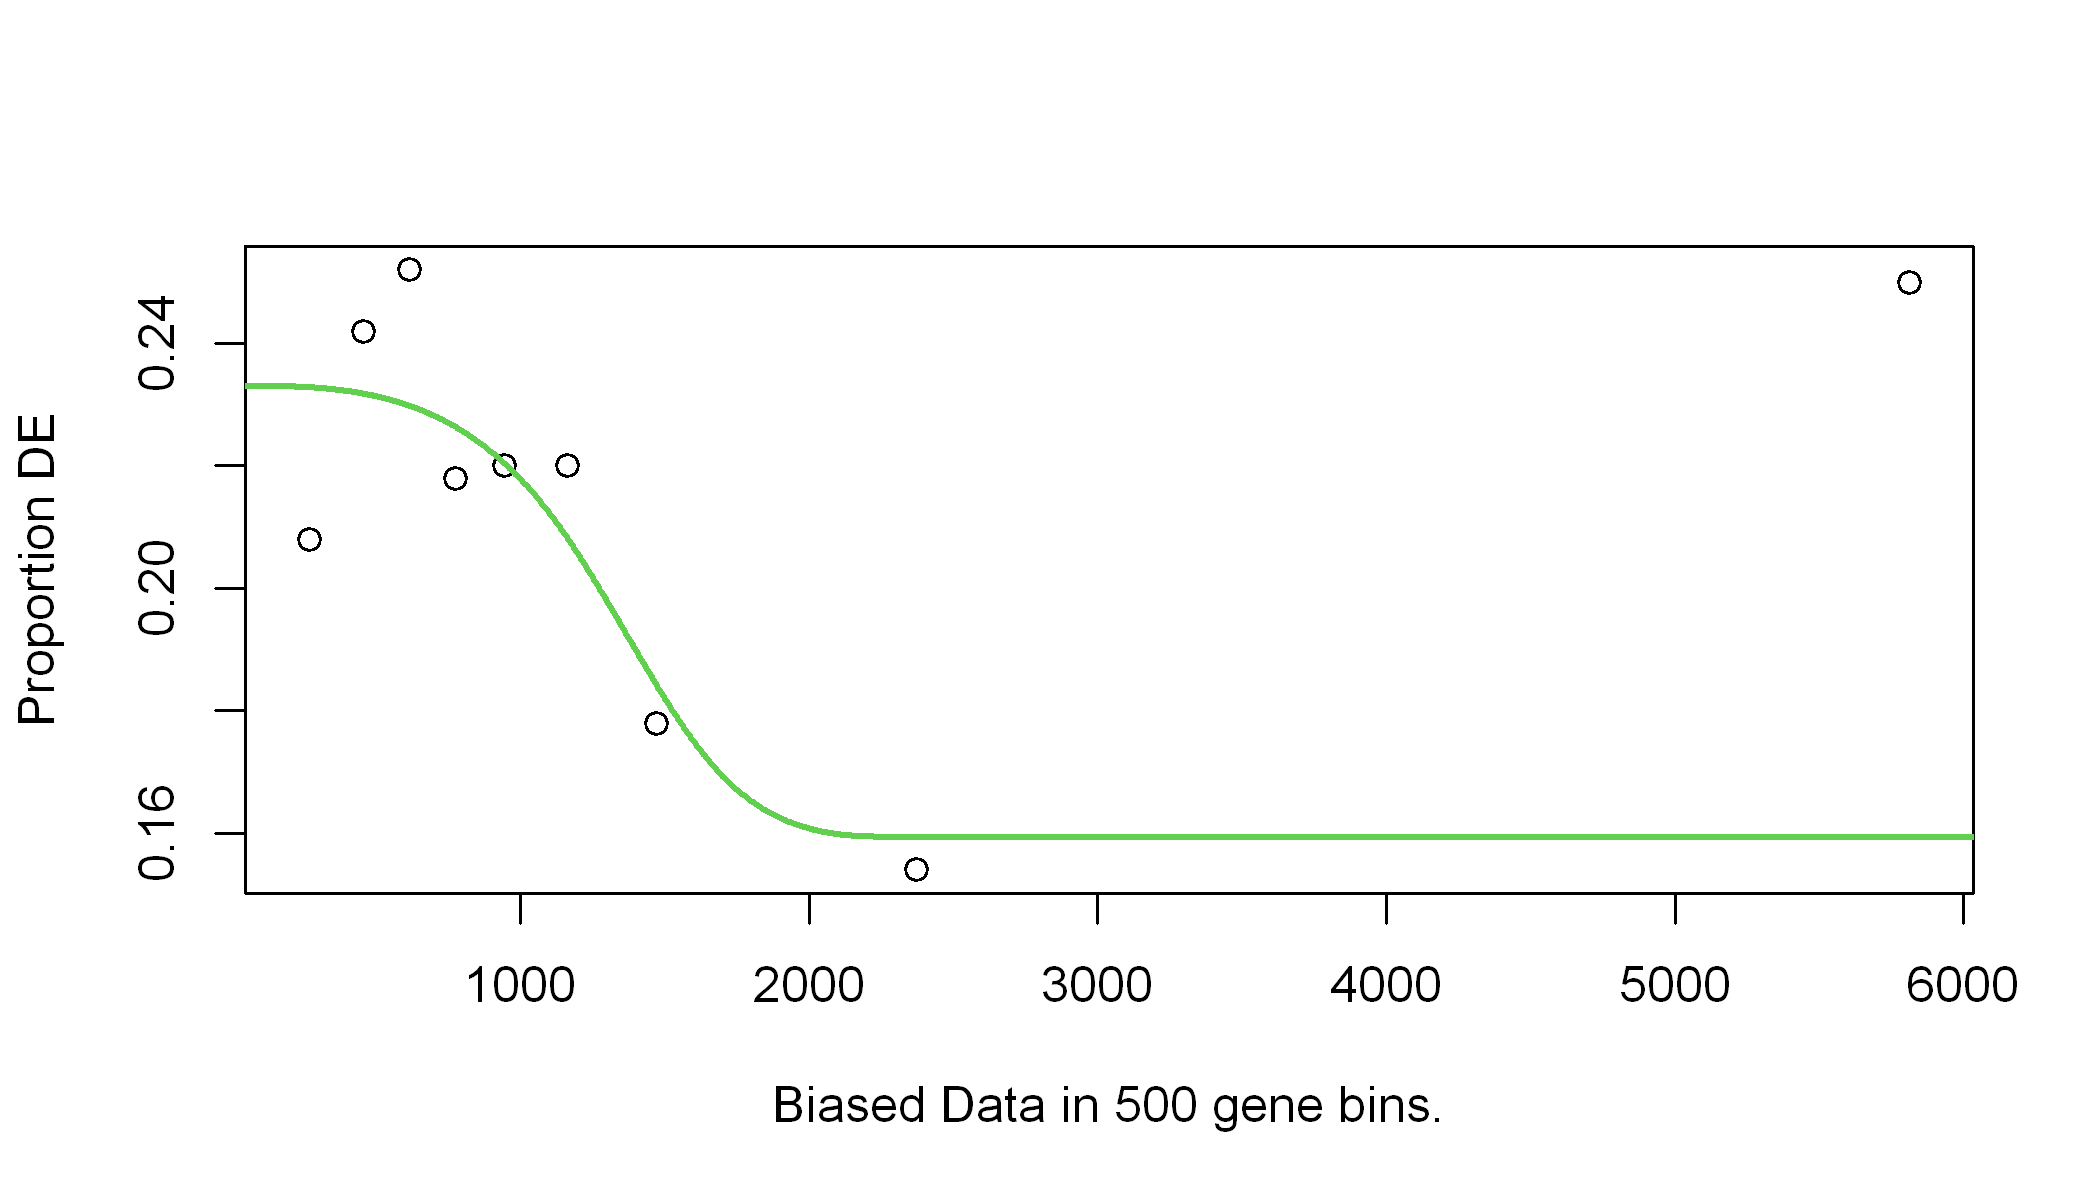

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`
Warning message in pcls(G):
"initial point very close to some inequality constraints"


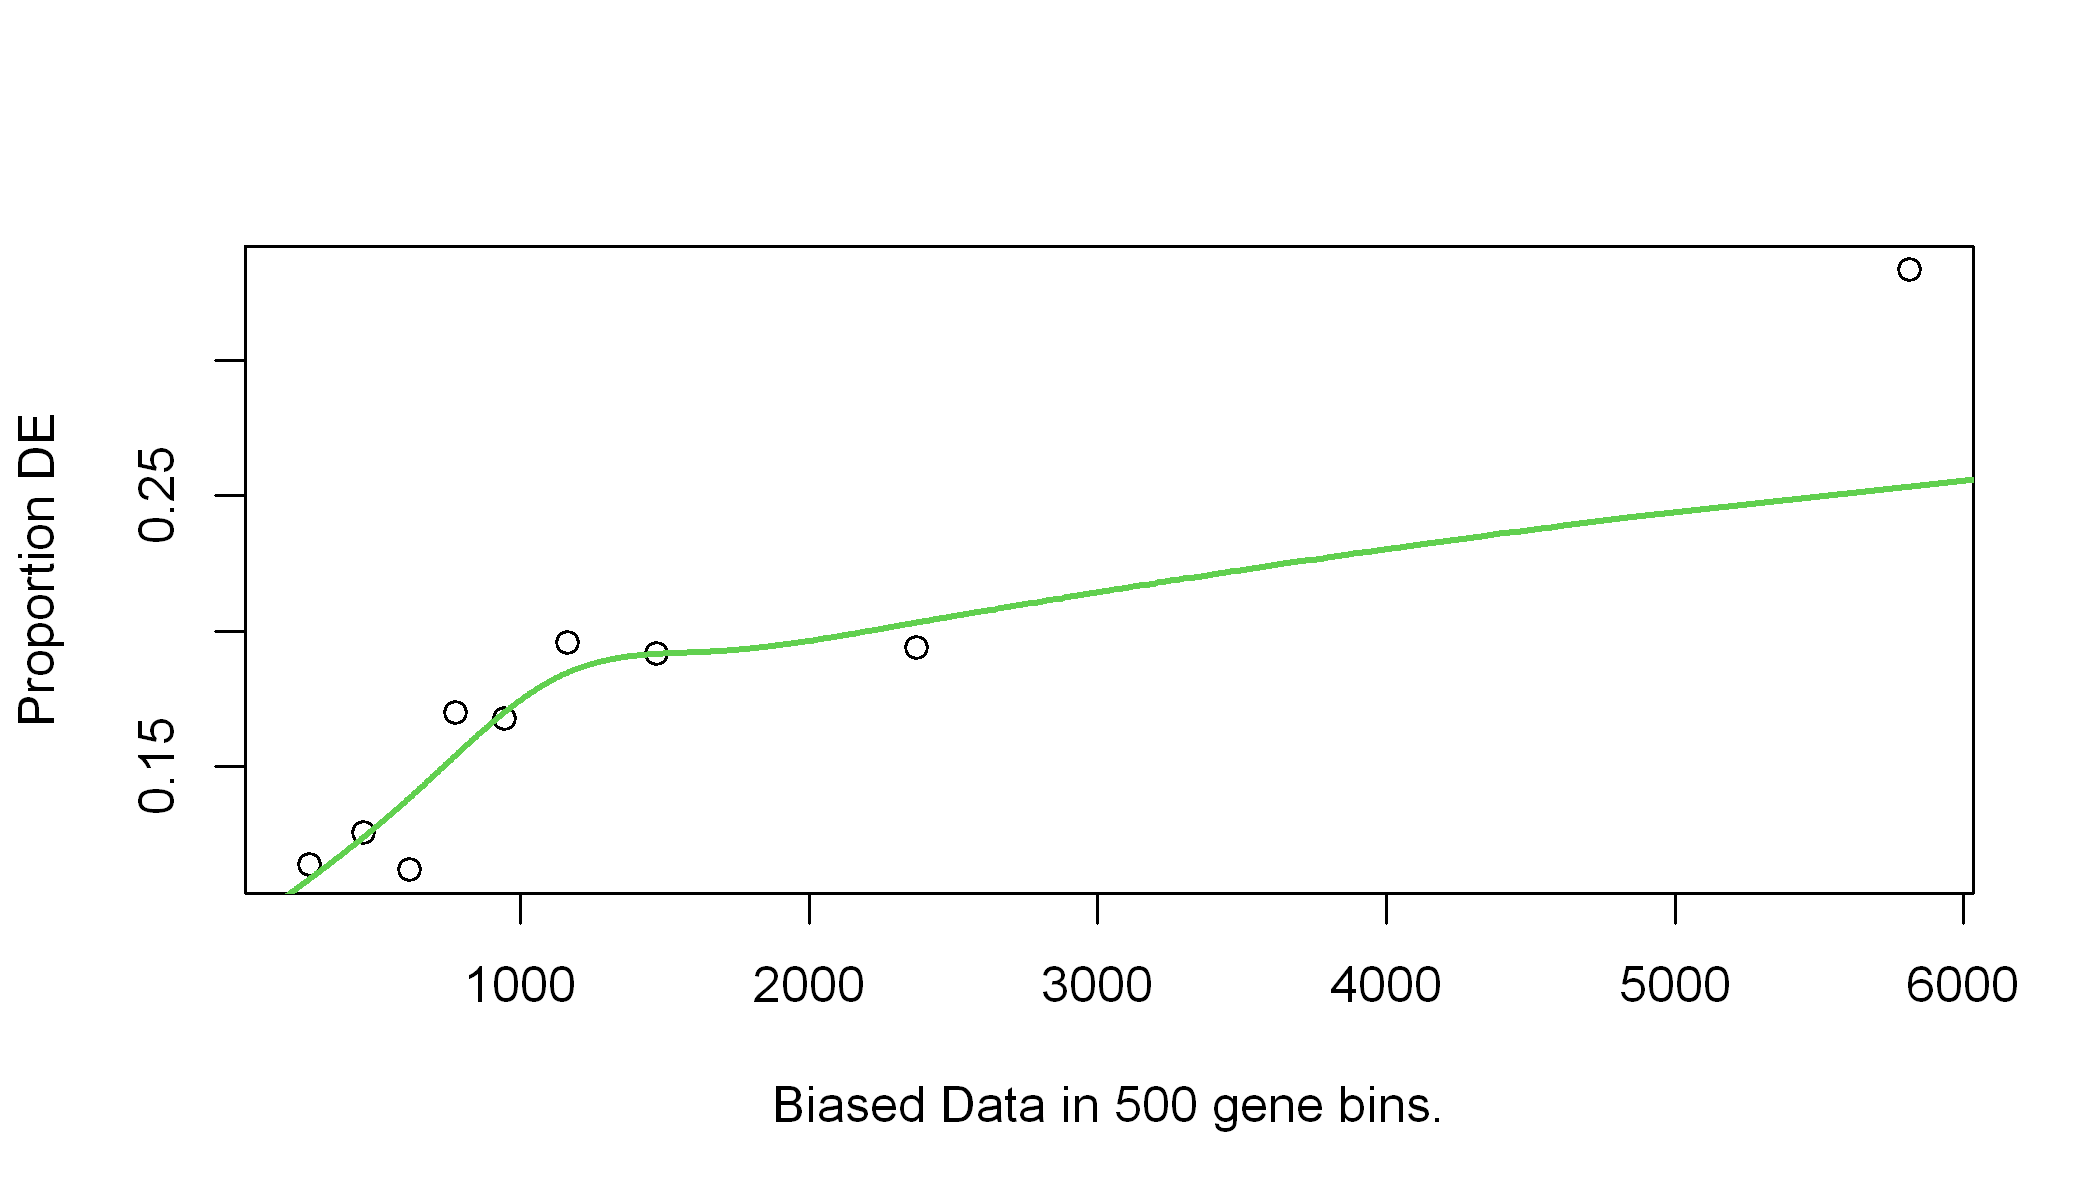

Using manually entered categories.

For 58 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

Joining with `by = join_by(category)`


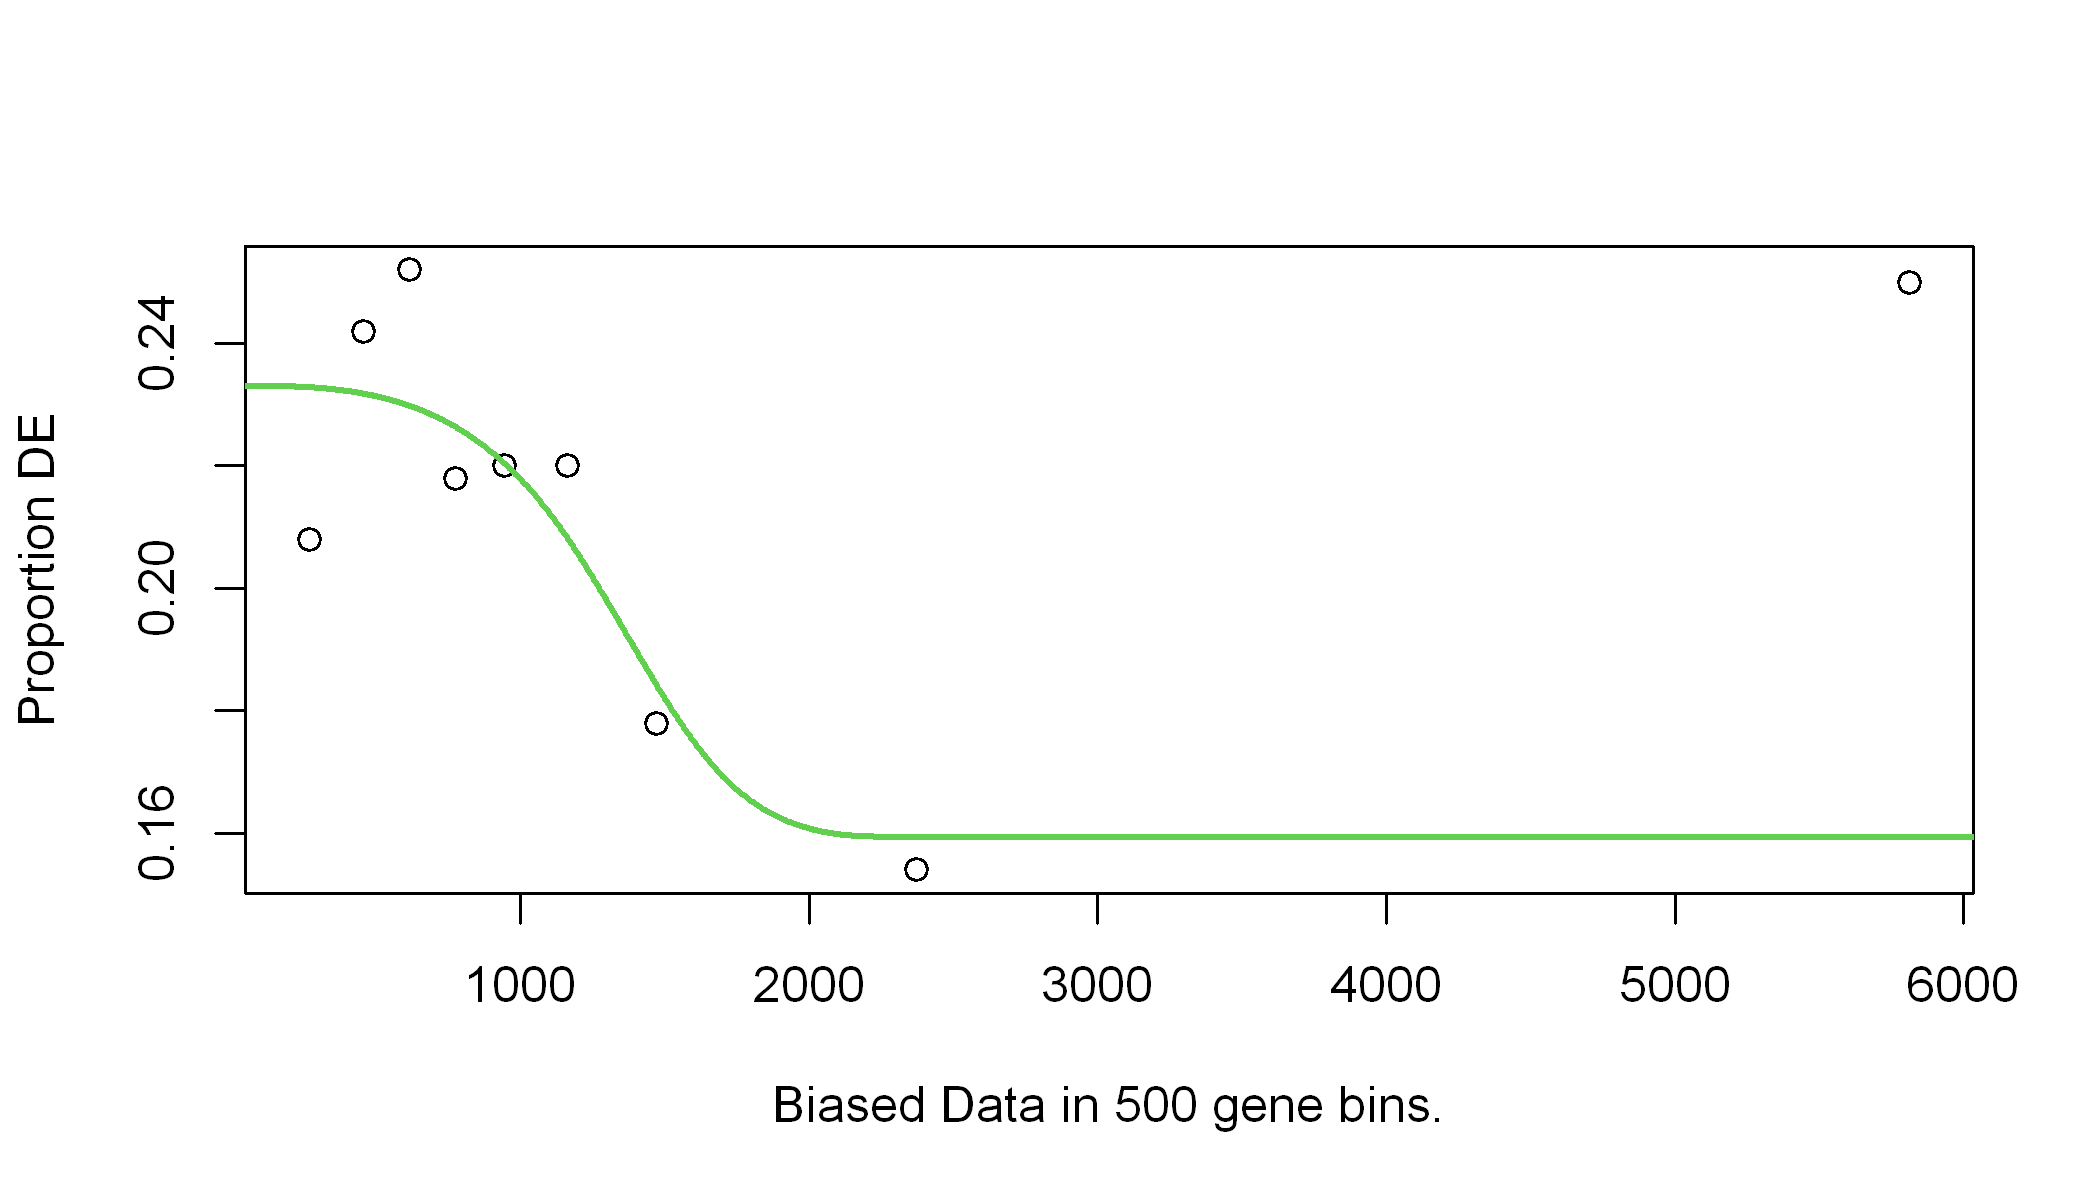

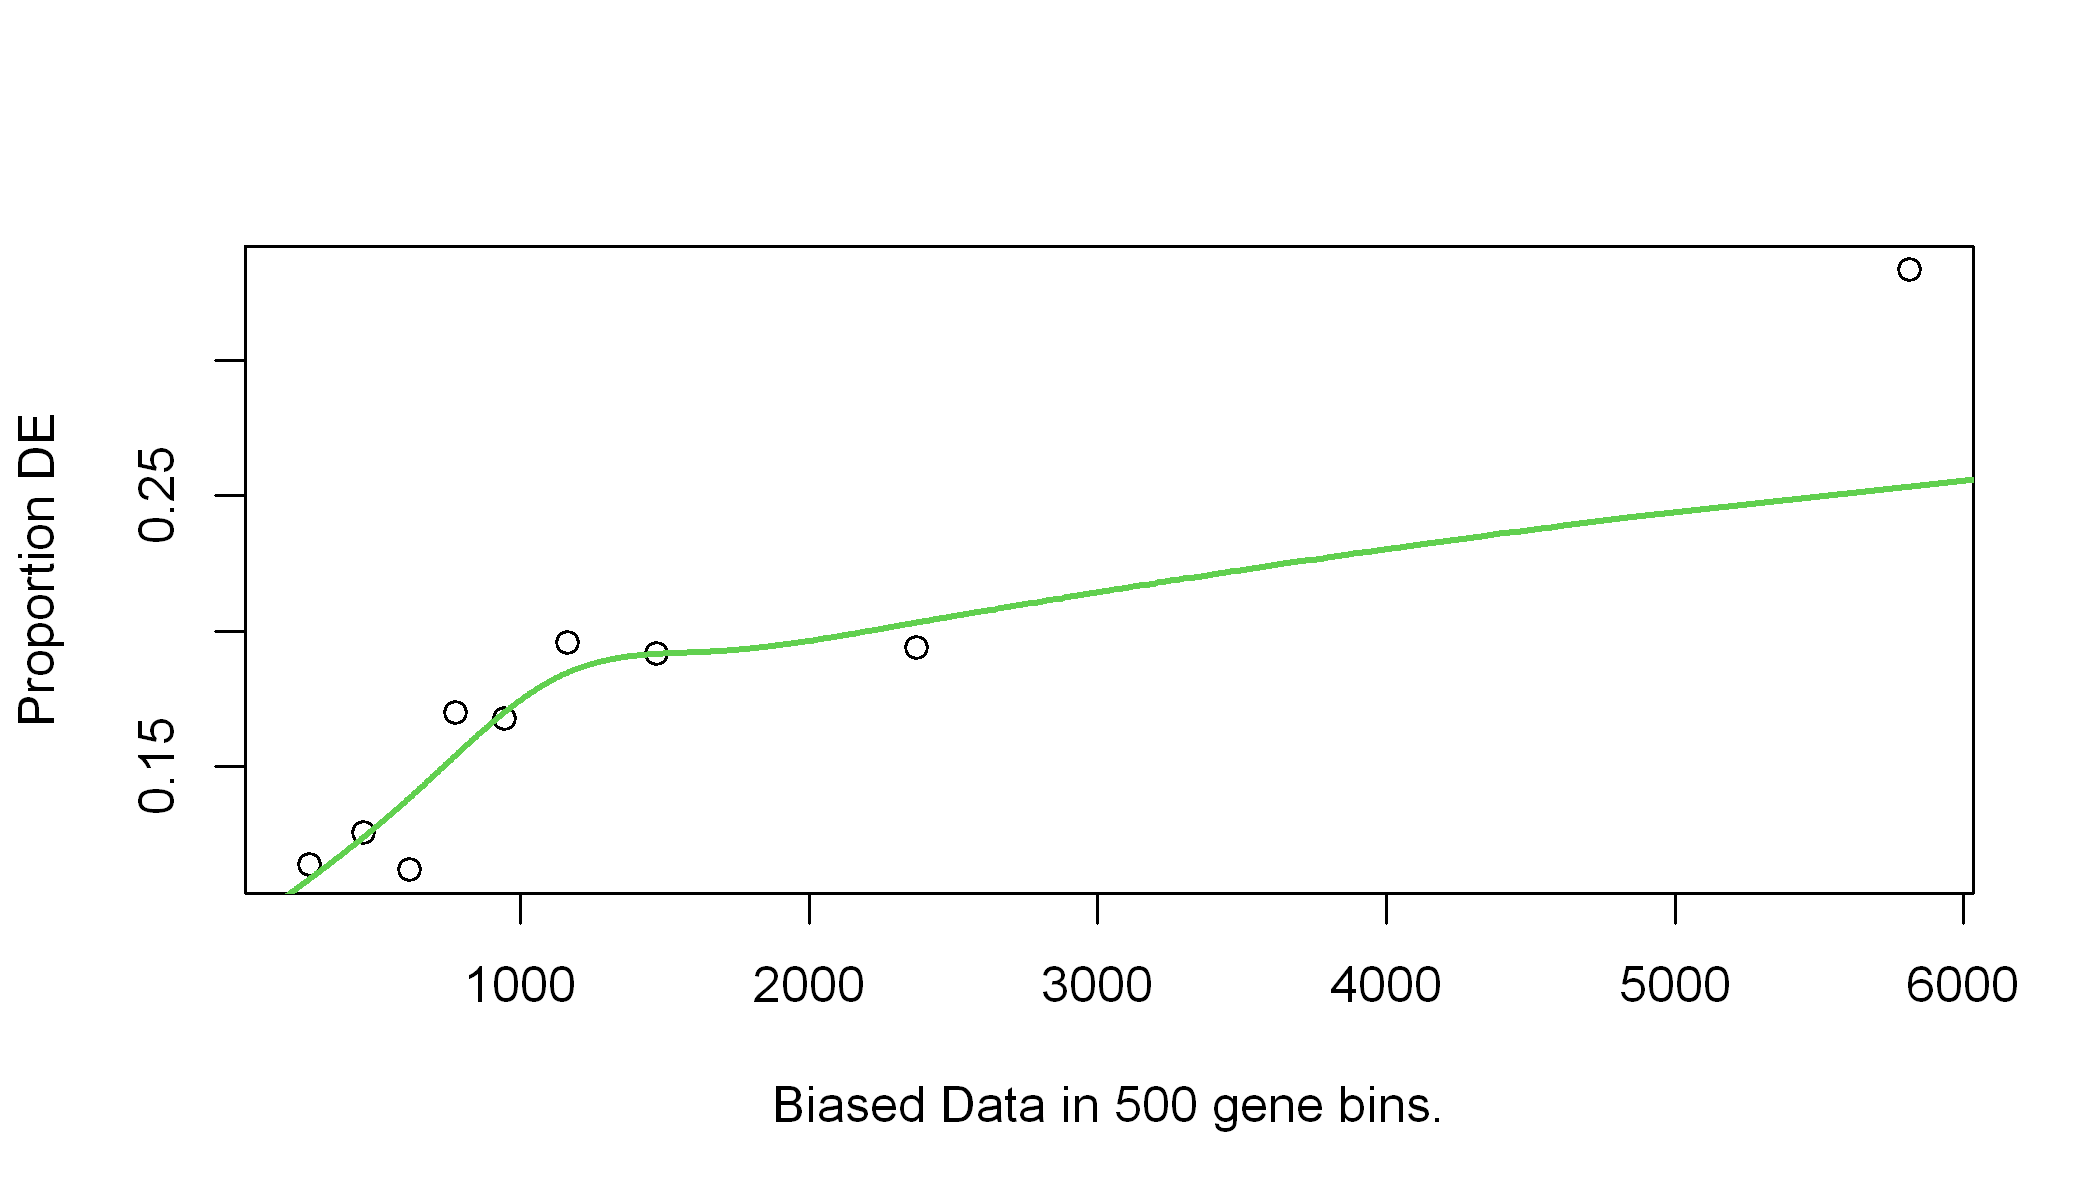

In [60]:
dlist = list()

for (contrastname in unique(df_all$contrast1)) 
{
    for (col in c('sub' ,'path')  #, 'main','ecpath')
             ) 
        {
        for (test in c('down', 'up')) 
            {
              dlist[[length(dlist) + 1]] <- run_enrichment(contrastname, col, test)
        }

    }
}
goseq_res = bind_rows(dlist)


In [61]:
goseq_res = goseq_res %>% 
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    extract(main, c("Category"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(Category = word(Category)) %>%
    mutate(pathway = str_trim(pathway), Category = str_trim(Category)) 



In [62]:
sub2path = hpath_df %>% select(sub, path) %>% distinct() 
goseq_res = left_join(goseq_res, sub2path, by=c(PATH='path')) %>% mutate(sub = if_else(is.na(sub), PATH, sub))

In [63]:
goseq_res = goseq_res %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis and metabolism", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 

In [64]:
goseq_res = goseq_res %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) 


In [65]:
goseq_res %>% write_csv(file.path('DE_results', 'HOT1A3_GOSEQ_results.csv'))

In [66]:
df_all %>% write_csv(file.path('DE_results', 'HOT1A3_all_FC_results.csv'))

In [67]:
top10 = goseq_res %>% 
  #filter(enrich == 'sub') %>%
  filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  arrange(padj, over_represented_pvalue) %>%
  head(n=50) 
  
hpath_df %>% filter(path %in% top10$PATH) %>% select(main,sub, path) %>% distinct() %>% arrange(main)

main                                      
1  09100 Metabolism                          
2  09100 Metabolism                          
3  09100 Metabolism                          
4  09100 Metabolism                          
5  09100 Metabolism                          
6  09100 Metabolism                          
7  09100 Metabolism                          
8  09100 Metabolism                          
9  09100 Metabolism                          
10 09100 Metabolism                          
11 09120 Genetic Information Processing      
12 09120 Genetic Information Processing      
13 09130 Environmental Information Processing
14 09130 Environmental Information Processing
15 09140 Cellular Processes                  
16 09140 Cellular Processes                  
   sub                                     
1  09105 Amino acid metabolism             
2  09104 Nucleotide metabolism             
3  09102 Energy metabolism                 
4  09104 Nucleotide metabolism             
5  09105 Amino acid metabolism             
6  09105 Amino acid metabolism             
7  09102 Energy metabolism                 
8  09103 Lipid metabolism                  
9  09107 Glycan biosynthesis and metabolism
10 09102 Energy metabolism                 
11 09122 Translation                       
12 09122 Translation                       
13 09132 Signal transduction               
14 09131 Membrane transport                
15 09142 Cell motility                     
16 09142 Cell motility                     
   path                                                            
1  00280 Valine, leucine and isoleucine degradation [PATH:ko00280] 
2  00230 Purine metabolism [PATH:ko00230]                          
3  00190 Oxidative phosphorylation [PATH:ko00190]                  
4  00240 Pyrimidine metabolism [PATH:ko00240]                      
5  00290 Valine, leucine and isoleucine biosynthesis [PATH:ko00290]
6  00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250]
7  00910 Nitrogen metabolism [PATH:ko00910]                        
8  00061 Fatty acid biosynthesis [PATH:ko00061]                    
9  00541 O-Antigen nucleotide sugar biosynthesis [PATH:ko00541]    
10 00195 Photosynthesis [PATH:ko00195]                             
11 00970 Aminoacyl-tRNA biosynthesis [PATH:ko00970]                
12 03010 Ribosome [PATH:ko03010]                                   
13 02020 Two-component system [PATH:ko02020]                       
14 03070 Bacterial secretion system [PATH:ko03070]                 
15 02040 Flagellar assembly [PATH:ko02040]                         
16 02030 Bacterial chemotaxis [PATH:ko02030]

In [68]:
top10 = goseq_res %>% 
  filter(enrich == 'sub') %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  arrange(padj, over_represented_pvalue) %>%
  head(n=50) 
  
hpath_df %>% filter(sub %in% top10$PATH) %>% select(main,sub) %>% distinct() %>% arrange(main)

main                                      
1  09100 Metabolism                          
2  09100 Metabolism                          
3  09100 Metabolism                          
4  09100 Metabolism                          
5  09100 Metabolism                          
6  09100 Metabolism                          
7  09100 Metabolism                          
8  09100 Metabolism                          
9  09100 Metabolism                          
10 09120 Genetic Information Processing      
11 09120 Genetic Information Processing      
12 09130 Environmental Information Processing
13 09130 Environmental Information Processing
14 09140 Cellular Processes                  
   sub                                              
1  09108 Metabolism of cofactors and vitamins       
2  09105 Amino acid metabolism                      
3  09110 Biosynthesis of other secondary metabolites
4  09102 Energy metabolism                          
5  09103 Lipid metabolism                           
6  09104 Nucleotide metabolism                      
7  09111 Xenobiotics biodegradation and metabolism  
8  09109 Metabolism of terpenoids and polyketides   
9  09101 Carbohydrate metabolism                    
10 09122 Translation                                
11 09123 Folding, sorting and degradation           
12 09132 Signal transduction                        
13 09131 Membrane transport                         
14 09142 Cell motility

In [69]:
head(goseq_res)

category PATH                          pathway                
1 09122    09122 Translation             Translation            
2 09105    09105 Amino acid metabolism   Amino acid metabolism  
3 09102    09102 Energy metabolism       Energy metabolism      
4 09142    09142 Cell motility           Cell motility          
5 09132    09132 Signal transduction     Signal transduction    
6 09101    09101 Carbohydrate metabolism Carbohydrate metabolism
  over_represented_pvalue padj         under_represented_pvalue numDEInCat
1 1.299072e-15            2.598144e-14 1.0000000                32        
2 4.758852e-05            4.758852e-04 0.9999814                34        
3 1.427825e-04            9.518832e-04 0.9999527                22        
4 5.215697e-04            2.607849e-03 0.9998582                14        
5 8.809507e-03            3.523803e-02 0.9961261                18        
6 1.167235e-02            3.890784e-02 0.9938326                27        
  numInCat main                                       Category      type enrich
1  76      09120 Genetic Information Processing       Genetic       down sub   
2 170      09100 Metabolism                           Metabolism    down sub   
3  96      09100 Metabolism                           Metabolism    down sub   
4  54      09140 Cellular Processes                   Cellular      down sub   
5  99      09130 Environmental Information Processing Environmental down sub   
6 165      09100 Metabolism                           Metabolism    down sub   
  Assay contrast    organism sub                           module             
1 prot  C2vsC1_prot HOT1A3   09122 Translation             Translation        
2 prot  C2vsC1_prot HOT1A3   09105 Amino acid metabolism   Amino acid         
3 prot  C2vsC1_prot HOT1A3   09102 Energy metabolism       Energy             
4 prot  C2vsC1_prot HOT1A3   09142 Cell motility           Cell motility      
5 prot  C2vsC1_prot HOT1A3   09132 Signal transduction     Signal transduction
6 prot  C2vsC1_prot HOT1A3   09101 Carbohydrate metabolism Carbohydrate       
  Group    
1 Coculture
2 Coculture
3 Coculture
4 Coculture
5 Coculture
6 Coculture

In [70]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

Assay Group      
C1vsA1_rna     rna   Coculture  
C2vsC1_rna     rna   Coculture  
C3vsC1_rna     rna   Coculture  
C4vsC1_rna     rna   Coculture  
C5vsC1_rna     rna   Coculture  
LATEvsC1P1_rna rna   Coculture  
C2vsC1_prot    prot  Coculture  
C3vsC1_prot    prot  Coculture  
C4vsC1_prot    prot  Coculture  
C5vsC1_prot    prot  Coculture  
LATEvsC1_prot  prot  Coculture  
A2vsA1_rna     rna   Axenic     
A2vsA1_prot    prot  Axenic     
A3vsA1_rna     rna   Axenic late
A3vsA1_prot    prot  Axenic late

In [71]:
#toppaths = 
path_meta = goseq_res %>% 
    filter(#enrich=='path', 
           padj < 0.05) %>% 
    distinct(PATH, main) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    extract(main, c("Category"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    mutate(Category = word(Category)) %>%
    column_to_rownames('pathway') 
#d_meta = d %>% select(Category, pathway) %>%column_to_rownames('pathway') 
path_meta

Category     
Translation                                  Genetic      
Amino acid metabolism                        Metabolism   
Energy metabolism                            Metabolism   
Cell motility                                Cellular     
Signal transduction                          Environmental
Carbohydrate metabolism                      Metabolism   
Ribosome                                     Genetic      
Aminoacyl-tRNA biosynthesis                  Genetic      
Valine, leucine and isoleucine biosynthesis  Metabolism   
Glycolysis / Gluconeogenesis                 Metabolism   
Bacterial chemotaxis                         Cellular     
Alanine, aspartate and glutamate metabolism  Metabolism   
Cysteine and methionine metabolism           Metabolism   
Glycine, serine and threonine metabolism     Metabolism   
Valine, leucine and isoleucine degradation   Metabolism   
Oxidative phosphorylation                    Metabolism   
Photosynthesis                               Metabolism   
Bacterial secretion system                   Environmental
Two-component system                         Environmental
Carbon fixation pathways in prokaryotes      Metabolism   
Cellular community - prokaryotes             Cellular     
Folding, sorting and degradation             Genetic      
Xenobiotics biodegradation and metabolism    Metabolism   
Biosynthesis of other secondary metabolites  Metabolism   
Fatty acid biosynthesis                      Metabolism   
Biofilm formation - Vibrio cholerae          Cellular     
Benzoate degradation                         Metabolism   
Fatty acid degradation                       Metabolism   
Starch and sucrose metabolism                Metabolism   
Selenocompound metabolism                    Metabolism   
Nucleotide metabolism                        Metabolism   
Metabolism of cofactors and vitamins         Metabolism   
Glycan biosynthesis and metabolism           Metabolism   
O-Antigen nucleotide sugar biosynthesis      Metabolism   
Streptomycin biosynthesis                    Metabolism   
Monobactam biosynthesis                      Metabolism   
Amino sugar and nucleotide sugar metabolism  Metabolism   
Purine metabolism                            Metabolism   
One carbon pool by folate                    Metabolism   
C5-Branched dibasic acid metabolism          Metabolism   
Flagellar assembly                           Cellular     
Nitrogen metabolism                          Metabolism   
Pyrimidine metabolism                        Metabolism   
Propanoate metabolism                        Metabolism   
Lipid metabolism                             Metabolism   
Drug metabolism - other enzymes              Metabolism   
Biotin metabolism                            Metabolism   
Lysine biosynthesis                          Metabolism   
Membrane transport                           Environmental
Metabolism of terpenoids and polyketides     Metabolism   
Riboflavin metabolism                        Metabolism   
Terpenoid backbone biosynthesis              Metabolism

In [72]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [73]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [74]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"The input is a data frame-like object, convert it to a matrix."
Warning message:
"Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix."


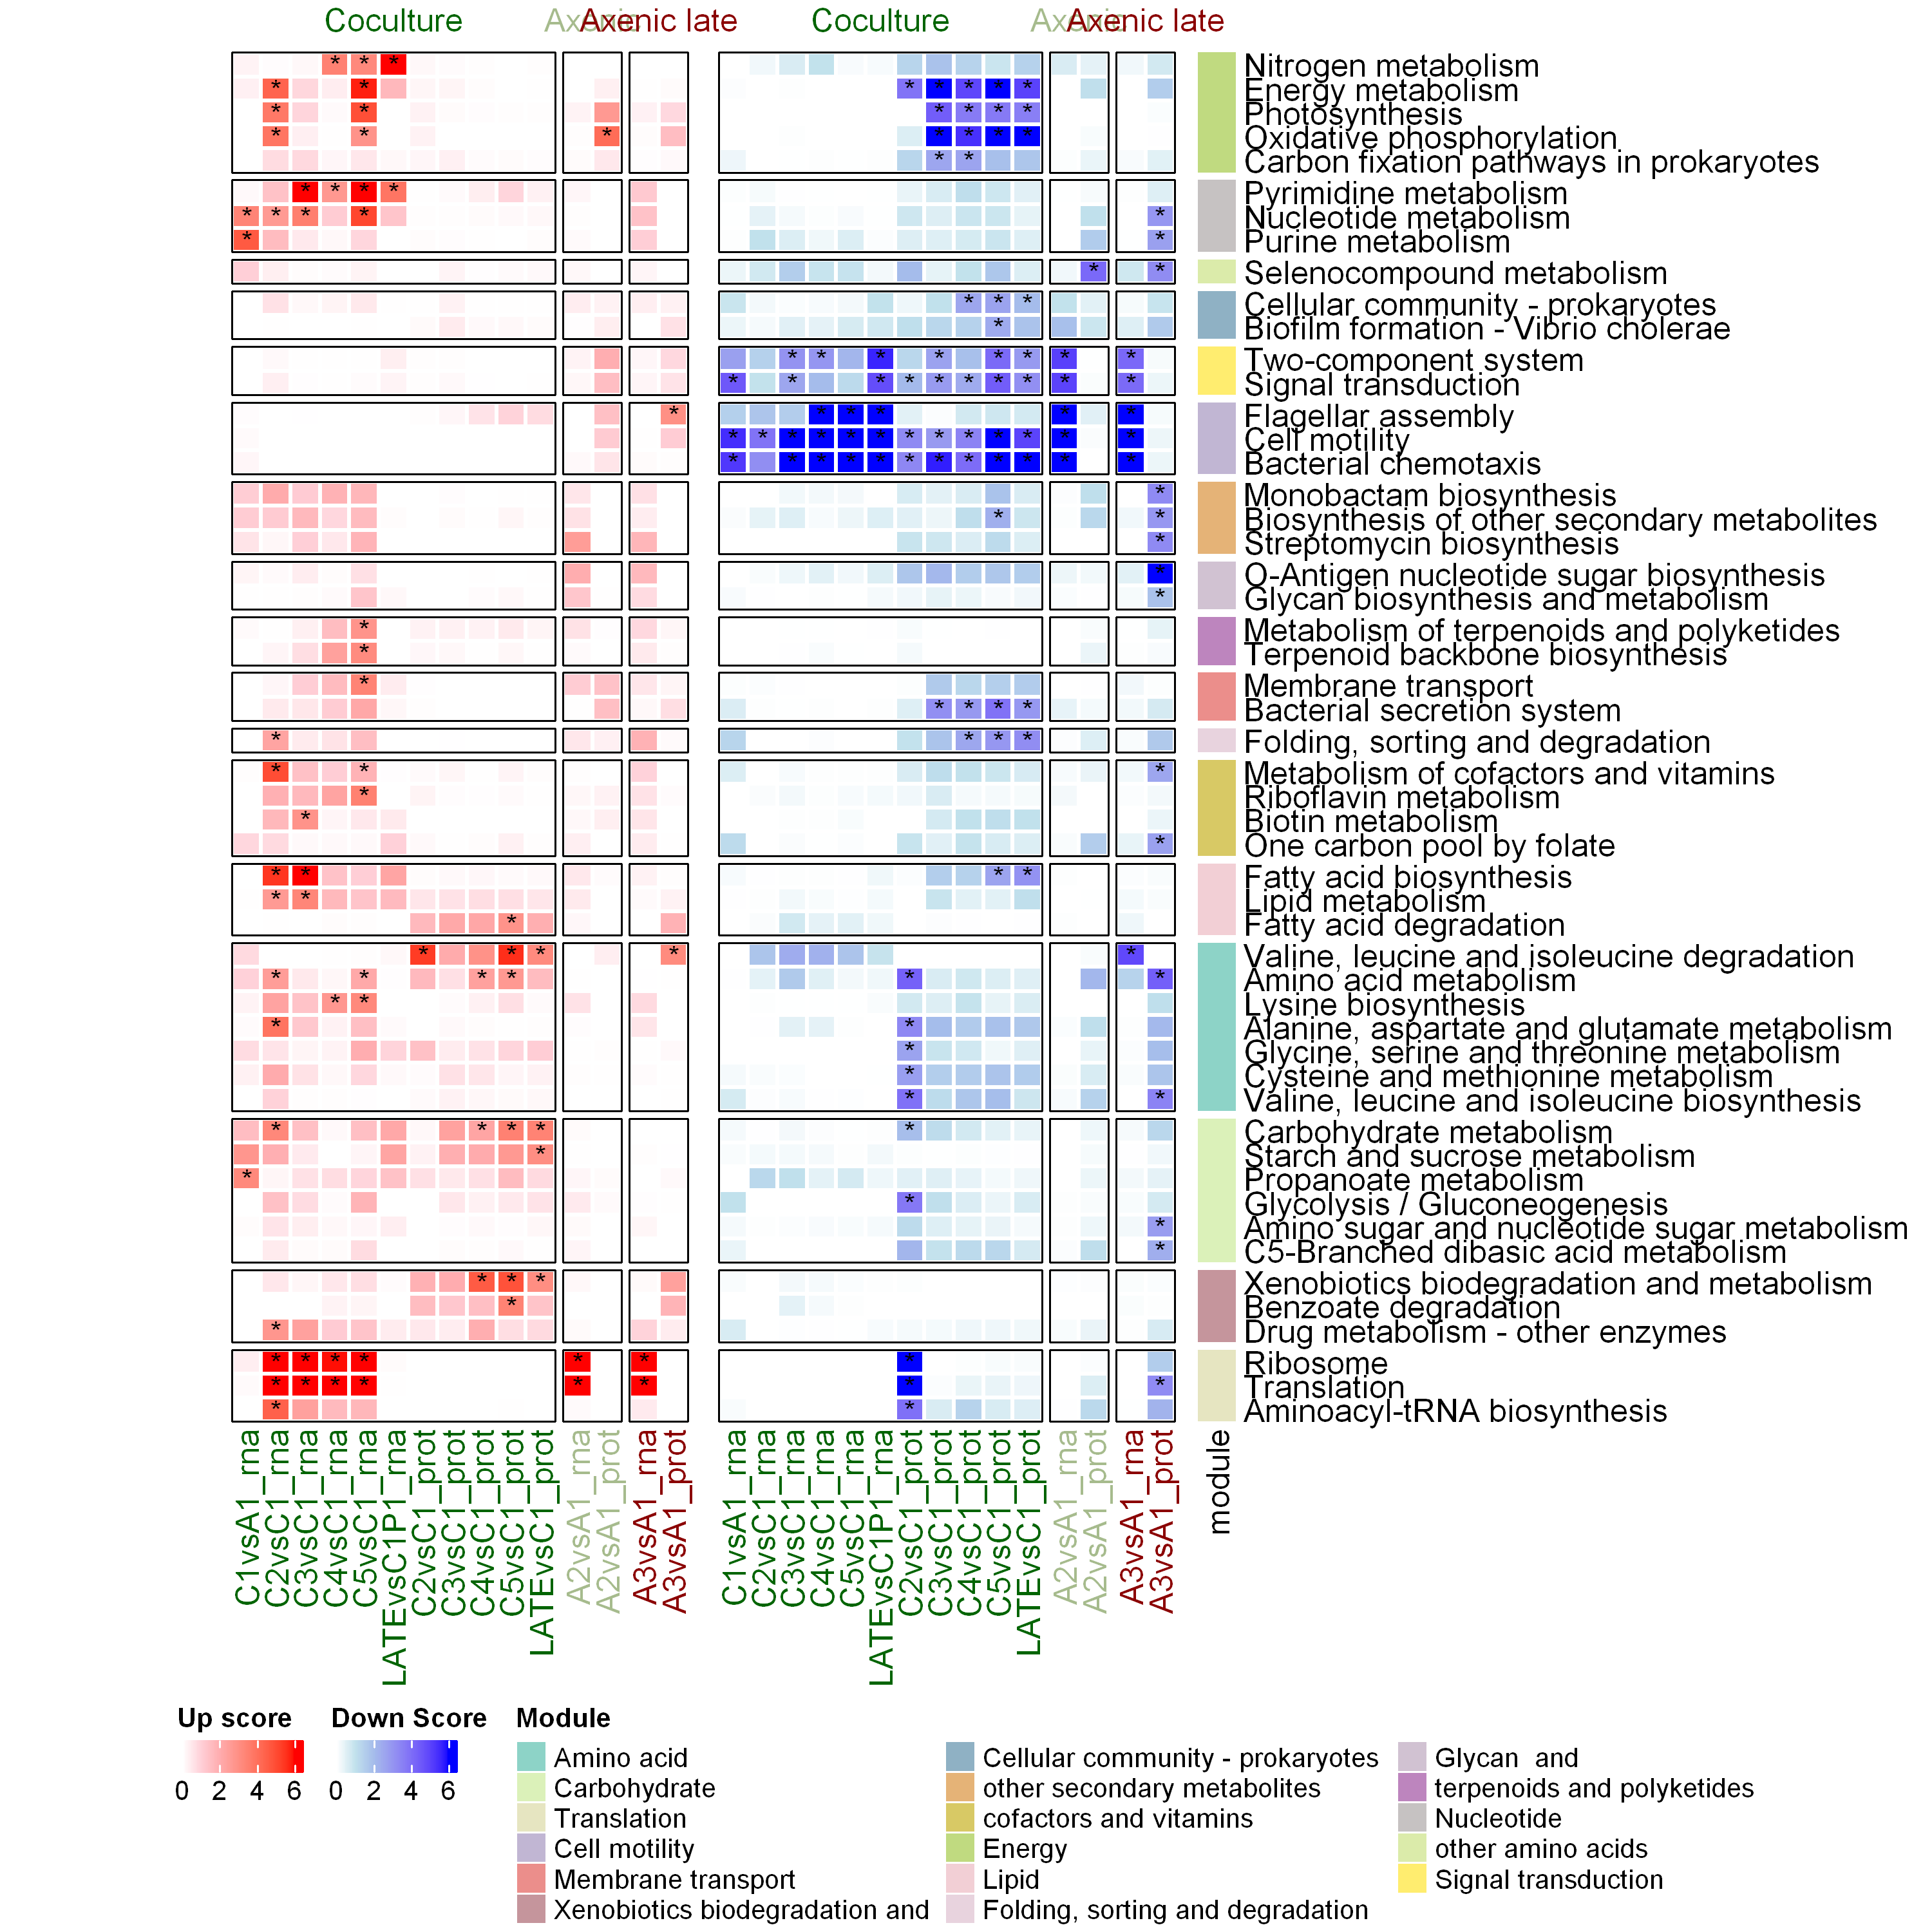

In [75]:
toppaths = goseq_res %>% 
    filter(#enrich=='path', 
           padj < 0.05) %>% 
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(18, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>%
Heatmap(
    name = 'Down Score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

gene_type_col = 
ann_mat = Heatmap(
    module_mat, 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(colorRampPalette(brewer.pal(12, "Set3"))(length(unique(module_mat$module))), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

In [76]:
length(brewer.pal(17, "Set3"))

Warning message in brewer.pal(17, "Set3"):
"n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
"


[1] 12

In [77]:
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05, type=='up') %>% 
    distinct(PATH)

goseq_res %>% filter(PATH %in% toppaths$PATH, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score>5, 5,score)) %>%
    mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
     replace(is.na(.), 0) %>% column_to_rownames('pathway') %>%
pheatmap(main='HOT1A3: GOSEQ Score - upregulated', annotation_col = goseq_meta, annotation_row = path_meta)


Warning message:
"The input is a data frame, convert it to the matrix."
Warning message:
"Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix."


ERROR: Error: number of observations in left annotation should be same as nrow of the
matrix.


In [ ]:
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05, type=='up') %>% 
    distinct(PATH)

goseq_res %>% filter(PATH %in% toppaths$PATH, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score>5, 5,score)) %>%
    mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
     replace(is.na(.), 0) %>% column_to_rownames('pathway') %>%
pheatmap(main='HOT1A3: GOSEQ Score - upregulated', annotation_col = goseq_meta, annotation_row = path_meta)


In [ ]:
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05, type=='down') %>% 
    distinct(PATH)

goseq_res %>% filter(PATH %in% toppaths$PATH, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score>5, 5,score)) %>%
    mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
     replace(is.na(.), 0) %>% column_to_rownames('pathway') %>%
pheatmap(main='HOT1A3: GOSEQ Score - downregulated', annotation_col = goseq_meta, annotation_row = path_meta)


In [ ]:
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05, type=='down') %>% 
    distinct(PATH)

goseq_res %>% filter(PATH %in% toppaths$PATH, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score>5, 5,score)) %>%
    mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
    extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
     replace(is.na(.), 0) %>% column_to_rownames('pathway') %>%
pheatmap(main='HOT1A3: GOSEQ Score - downregulated', annotation_col = goseq_meta, annotation_row = path_meta)


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(significant = ifelse(padj < 0.05, 'yes', 'no')) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun = 'mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group, alpha=significant)) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  scale_alpha_manual(values = c(no=0.3,yes=0.8)) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='path', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  filter(padj < 0.05) %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun = 'mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group), alpha=0.8) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(significant = ifelse(padj < 0.05, 'yes', 'no')) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun='mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group, alpha=significant)) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +
  scale_alpha_manual(values = c(no=0.3,yes=0.8)) +
  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
toppaths = goseq_res %>% 
    filter(enrich=='sub', padj < 0.05) %>% 
    distinct(PATH)

goseq_res %>% 
  filter(PATH %in% toppaths$PATH) %>%
  filter(padj < 0.05) %>%
  #filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  mutate(PATH = str_replace(PATH, "in photosynthetic organisms", "")) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>%
  #head(n=100) %>%
  mutate(ratio = ifelse(type == 'down', -Ratio, Ratio)) %>%
  mutate(just = ifelse(type != 'down', 'right', 'left')) %>%
  mutate(labelx = ifelse(type != 'down', -0.03, 0.1)) %>%
  mutate(padj_score = ifelse(type == 'down', -padj_Score, padj_Score)) %>%
  mutate(pathway = fct_reorder(pathway, padj_score, .fun='mean')) %>%

ggplot(aes(y=pathway, x=padj_score, size=Ratio*40, color=type, shape=Assay)) + 
  geom_vline(aes(xintercept = 0.00), color = "grey90", size = 1) +
  geom_segment( aes(x=0, xend=padj_score, y=pathway, yend=pathway), size=1) +
  geom_point(aes(color=Group), alpha=0.8) + 
 #scale_color_manual(values = c(up='#DC3220', down='#005AB5')) + # , limit=c(-15,15)) +
  geom_text(aes(x=-10, y=pathway, label=pathway, size=15, hjust='left'), nudge_y=0.4, color='black') + #, color='black')) + 
  #xlim(-10, 10) +
  #scale_color_manual(values = c(up='red', down='blue', Axenic='#FDA65D', Coculture='#c26b19', 'Axenic late'='darkred')) +
  scale_color_manual(values = c(up='red', down='blue', Axenic='green', Coculture='darkgreen', 'Axenic late'='darkred')) +

  theme_classic(base_size = 15) + 
  theme(
      axis.title.y=element_blank(),
      axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.line.y = element_blank(),
        axis.line.x = element_blank()#,
  #      legend.position="none"
  )




In [ ]:
goseq_res %>% 
  #filter(enrich == 'sub') %>%
  filter(enrich == 'path') %>%
  filter(type %in% c('up', 'down')) %>%
  mutate(Ratio = numDEInCat / numInCat) %>%
  extract(PATH, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?") %>%
  mutate(padj_Score = -log10(padj)) %>%
  #filter( type=='up') %>%
  arrange(padj, over_represented_pvalue) %>% 
#  tail(n=1000) %>% 
distinct(main)



In [ ]:
head(df_all)

In [ ]:
hpath_df %>% filter(grepl('Photosynthesis', path)) %>% distinct(gene)

In [ ]:
sessionInfo()